In [1]:
import cupy as cp
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import random
from tensorflow.keras.models import load_model
import time
# from numba import jit

2023-05-22 16:22:32.016122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:22:34.574778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ref_image1 = cv2.imread('./090523_checkerboard_2/left/Left_7850nm.png',0)
ref_image2 = cv2.imread('./090523_checkerboard_2/right/Right_7850nm.png',0)

CHECKERBOARD = (6,7)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) #maxiter = 30, epsilon = 0.0001

objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
# Defining checkerboard dimensions and size in real world coordinates (in mm)
objp = objp*4.235 + np.array([[[4.235, 4.235, 0]]])
objp = objp.astype('float32')

# Left Camera Calibration

In [3]:
objpoints1 = []
imgpoints1 = []

img = cv2.imread("./090523_checkerboard_2/left/Left_7850nm.png", 0)
ret, corners = cv2.findChessboardCorners(img, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

print(ret)
print("")
if ret == True:
    objpoints1.append(objp)
    # refining pixel coordinates for given 2d points.
    corners2 = cv2.cornerSubPix(img, corners, (11,11),(-1,-1), criteria)
         
    imgpoints1.append(corners2)
 
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)

images = glob.glob('./090523_checkerboard_2/left/Left*850nm.png')
for fname in images:
    img = cv2.imread(fname, 0)
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(img, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    print(ret)
    """
    If desired number of corner are detected,
    we refine the pixel coordinates and display 
    them on the images of checker board
    """
    if ret == True:
        objpoints1.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(img, corners, (11,11),(-1,-1), criteria)
         
        imgpoints1.append(corners2)
 
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
        
#         cv2.imshow('img', img)
#         cv2.waitKey(0)

#         cv2.destroyAllWindows()

True

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [4]:
        """
        Performing camera calibration by 
        passing the value of known 3D points (objpoints)
        and corresponding pixel coordinates of the 
        detected corners (imgpoints)
        """
ret1, mtx1, dist1, rvecs1, tvecs1 = cv2.calibrateCamera(objpoints1, imgpoints1, ref_image1.shape[::-1], None, None)

print(" ")
print("Reprojection error : \n")
print(ret1)
print("Camera matrix : \n")
print(mtx1)
print("dist : \n")
print(dist1)
print("rvecs : \n")
print(rvecs1)
print("tvecs : \n")
print(tvecs1)

 
Reprojection error : 

0.5439627408432801
Camera matrix : 

[[2.32129063e+03 0.00000000e+00 6.25384911e+02]
 [0.00000000e+00 2.30275672e+03 4.97085395e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 

[[-3.71562416e-02 -4.19030584e-01  1.65638727e-03 -1.59739572e-02
   2.21043762e+00]]
rvecs : 

(array([[ 0.16348057],
       [-0.17861793],
       [-1.57886737]]), array([[ 0.3544551 ],
       [-0.36144857],
       [-1.58243284]]), array([[ 0.35932649],
       [-0.35537653],
       [-1.57178391]]), array([[-0.02071232],
       [ 0.01971537],
       [-1.60143297]]), array([[ 0.15368572],
       [-0.19004122],
       [-1.51718669]]), array([[-0.01790737],
       [ 0.01355762],
       [-1.58299945]]), array([[-0.00719538],
       [ 0.03653   ],
       [-1.66595699]]), array([[-0.00240878],
       [ 0.00782525],
       [-1.62128947]]), array([[-3.68090750e-02],
       [-1.05992014e-03],
       [-1.54130881e+00]]), array([[ 0.35088454],
       [-0.36101539],
       [-1.53326333

In [5]:
#undistortion
img = cv2.imread('./Left_Sample850nm.png')
h,  w = img.shape[:2]
newcameramtx1, roi = cv2.getOptimalNewCameraMatrix(mtx1, dist1, (w,h), 1, (w,h))

# # undistort
# dst = cv2.undistort(img, mtx1, dist1, None, newcameramtx1)
# dst = cv2.resize(dst, (0,0), fx = 0.5, fy = 0.5)

# cv2.imshow('dst', dst)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [6]:
#reprojection error
mean_error = 0
for i in range(len(objpoints1)):
    imgpoints2_, _ = cv2.projectPoints(objpoints1[i], rvecs1[i], tvecs1[i], mtx1, dist1)
    error = cv2.norm(imgpoints1[i], imgpoints2_, cv2.NORM_L2)/len(imgpoints2_)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints1)) )

total error: 0.08343948453051139


# Right Camera Calibration

In [7]:
objpoints2 = []
imgpoints2 = []

img = cv2.imread("./090523_checkerboard_2/right/Right_7850nm.png", 0)
ret, corners = cv2.findChessboardCorners(img, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

print(ret)
print("")
if ret == True:
    objpoints2.append(objp)
    # refining pixel coordinates for given 2d points.
    corners2 = cv2.cornerSubPix(img, corners, (11,11),(-1,-1), criteria)
         
    imgpoints2.append(corners2)
 
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)



images = glob.glob("./090523_checkerboard_2/right/Right_*850nm.png")
for fname in images:
    img = cv2.imread(fname, 0)
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(img, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    print(ret)
    """
    If desired number of corner are detected,
    we refine the pixel coordinates and display 
    them on the images of checker board
    """
    if ret == True:
        objpoints2.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(img, corners, (11,11),(-1,-1), criteria)
         
        imgpoints2.append(corners2)
 
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
        
#         cv2.imshow('img', img)
#         cv2.waitKey(0)

#         cv2.destroyAllWindows()

True

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [8]:
        """
        Performing camera calibration by 
        passing the value of known 3D points (objpoints)
        and corresponding pixel coordinates of the 
        detected corners (imgpoints)
        """
ret2, mtx2, dist2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints2, imgpoints2, ref_image2.shape[::-1], None, None)

print(" ")
print("Reprojection error : \n")
print(ret2)
print("Camera matrix : \n")
print(mtx2)
print("dist : \n")
print(dist2)
print("rvecs : \n")
print(rvecs2)
print("tvecs : \n")
print(tvecs2)

 
Reprojection error : 

0.5679182425974345
Camera matrix : 

[[2.00779575e+03 0.00000000e+00 9.24272484e+02]
 [0.00000000e+00 1.98516726e+03 5.34197670e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 

[[-0.08122876 -0.19313346 -0.00052123  0.0087402   0.40401303]]
rvecs : 

(array([[-0.17231923],
       [ 0.17000999],
       [-1.5734623 ]]), array([[-0.25383944],
       [ 0.37922237],
       [-1.56740176]]), array([[-0.00527535],
       [ 0.02094702],
       [-1.56349784]]), array([[-0.35141454],
       [ 0.35439404],
       [-1.58567979]]), array([[ 0.0512388 ],
       [-0.00726694],
       [-1.60614211]]), array([[-0.14852183],
       [ 0.13598349],
       [-1.57773291]]), array([[-0.19144146],
       [ 0.1876402 ],
       [-1.49801503]]), array([[-0.11866259],
       [ 0.16381795],
       [-1.55761292]]), array([[-0.16727632],
       [ 0.19087687],
       [-1.54658271]]), array([[-0.02904297],
       [ 0.01142511],
       [-1.60113118]]), array([[-0.02634938],
       

In [9]:
#undistortion
img = cv2.imread('./Right_Sample850nm.png')
h,  w = img.shape[:2]
newcameramtx2, roi = cv2.getOptimalNewCameraMatrix(mtx2, dist2, (w,h), 1, (w,h))

# # undistort
# dst = cv2.undistort(img, mtx2, dist2, None, newcameramtx2)
# dst = cv2.resize(dst, (0,0), fx = 0.5, fy = 0.5)

# cv2.imshow('dst', dst)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [10]:
#reprojection error
mean_error = 0
for i in range(len(objpoints2)):
    imgpoints2_, _ = cv2.projectPoints(objpoints2[i], rvecs2[i], tvecs2[i], mtx2, dist2)
    error = cv2.norm(imgpoints2[i], imgpoints2_, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints2)) )

total error: 0.12119773650767815


## Stereo Calibration

In [11]:
frames_folder = r"./090523_checkerboard_2/common/Left_*850nm.png"
frames_folder1 = r"./090523_checkerboard_2/common/Right_*850nm.png"

images_names1 = glob.glob(frames_folder)
images_names2 = glob.glob(frames_folder1)
c1_images_names = images_names1[0:]
c2_images_names = images_names2[0:]
#     print()
 
c1_images = []
c2_images = []
for im1, im2 in zip(c1_images_names, c2_images_names):
    _im = cv2.imread(im1, 1)
    c1_images.append(_im)
 
    _im = cv2.imread(im2, 1)
    c2_images.append(_im)

In [12]:
#change this if stereo calibration not good.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
rows = 6 #number of checkerboard rows.
columns = 7 #number of checkerboard columns.
world_scaling = 1. #change this to the real world square size. Or not.
 
#coordinates of squares in the checkerboard world space
objp = np.zeros((rows*columns,3), np.float32)
objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
objp = 4.235 * objp
 
#frame dimensions. Frames should be the same size.
width = c1_images[0].shape[1]
height = c1_images[0].shape[0]
 
#Pixel coordinates of checkerboards
imgpoints_left = [] # 2d points in image plane.
imgpoints_right = []
 
#coordinates of the checkerboard in checkerboard world space.
objpoints = [] # 3d point in real world space
    
R=[]
T=[]
    

In [13]:
for frame1, frame2 in zip(c1_images, c2_images):
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
        
    c_ret1, corners1 = cv2.findChessboardCorners(gray1, (rows, columns), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    c_ret2, corners2 = cv2.findChessboardCorners(gray2, (rows, columns), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

In [14]:
    if c_ret1 == True and c_ret2 == True:
        corners1 = cv2.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
        corners2 = cv2.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)

#         cv2.drawChessboardCorners(frame1, (rows,columns), corners1, c_ret1)
#             cv.imshow('img', frame1)

#         cv2.drawChessboardCorners(frame2, (rows,columns), corners2, c_ret2)
#             cv.imshow('img2', frame2)
#             cv.waitKey(0)
#             cv.destroyAllWindows()
        objpoints.append(objp)
        imgpoints_left.append(corners1)
        imgpoints_right.append(corners2)

        stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC
        ret, CM1, dist1, CM2, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1, mtx2, dist2, (width, height), criteria = criteria, flags = stereocalibration_flags)
        
#                 print(R)
#                 print(T)

#         R.append(R)
#         T.append(T)
#             print(R1)
#             print(T1)
#         print(ret)

#  

# Keypoint Detection

In [15]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

1/1 [==============================] - 0s 123ms/step


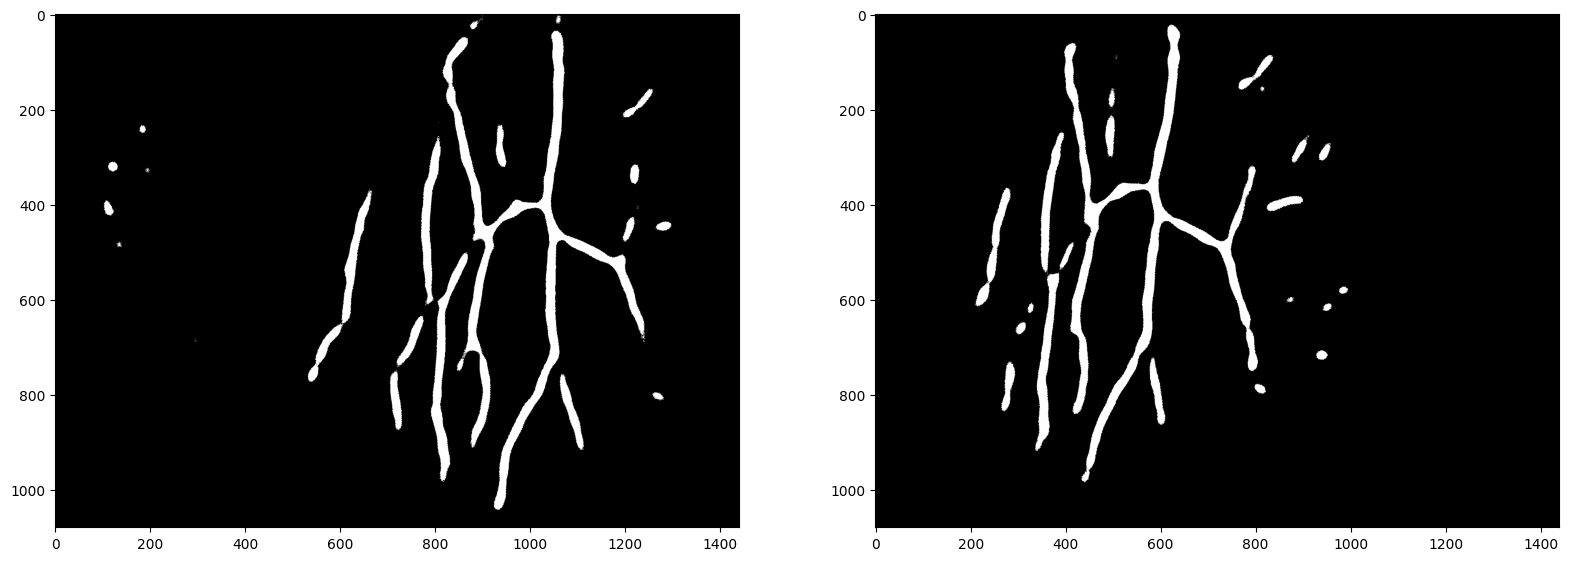

In [19]:
vein_l = cv2.imread(r"./09_05_23/Left_shubham2850nm.png",0)
vein_r = cv2.imread(r"./09_05_23/Right_shubham2850nm.png",0)

# vein_l = cv2.undistort(vein_l,mtx1,dist1,None,newcameramtx1)
# vein_r = cv2.undistort(vein_r,mtx2,dist2,None,newcameramtx2)

autoencoder_vein = load_model("./server output h5 file/trial_error_vein_train12.h5")

vein_l_input = vein_l.reshape((1,1080, 1440,1)).astype('float32') / 255.
vein_r_input = vein_r.reshape((1,1080, 1440,1)).astype('float32') / 255.

vein_proc_l = autoencoder_vein.predict(vein_l_input)
vein_proc_l = (vein_proc_l.reshape((1080, 1440)) * 255 ).astype('uint8')
vein_proc_r = autoencoder_vein.predict(vein_r_input)
vein_proc_r = (vein_proc_r.reshape((1080, 1440)) * 255 ).astype('uint8')

vein_proc_l = cv2.GaussianBlur(vein_proc_l,(75,75),0)
vein_proc_r = cv2.GaussianBlur(vein_proc_r,(75,75),0)

vein_proc_l = cv2.adaptiveThreshold(vein_proc_l, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 35, 5)
vein_proc_r = cv2.adaptiveThreshold(vein_proc_r, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 35, 5)

# vein_proc_l = sp_noise(vein_proc_l, 0.1)
# vein_proc_r = sp_noise(vein_proc_r, 0.1)

# clahe = cv2.createCLAHE(clipLimit = 8)

# feat1 = clahe.apply(vein_l)
# feat2 = clahe.apply(vein_r)

feat1 = vein_proc_l
feat2 = vein_proc_r

plt.figure(figsize=(30,10))

ax = plt.subplot(1,3,1)

plt.imshow(vein_proc_l,cmap='gray')
# plt.imshow(feat1,cmap='gray')

# target image

ax = plt.subplot(1,3,2)
plt.imshow(vein_proc_r,cmap='gray')
# plt.imshow(feat2,cmap='gray')

1/1 [==============================] - 0s 108ms/step


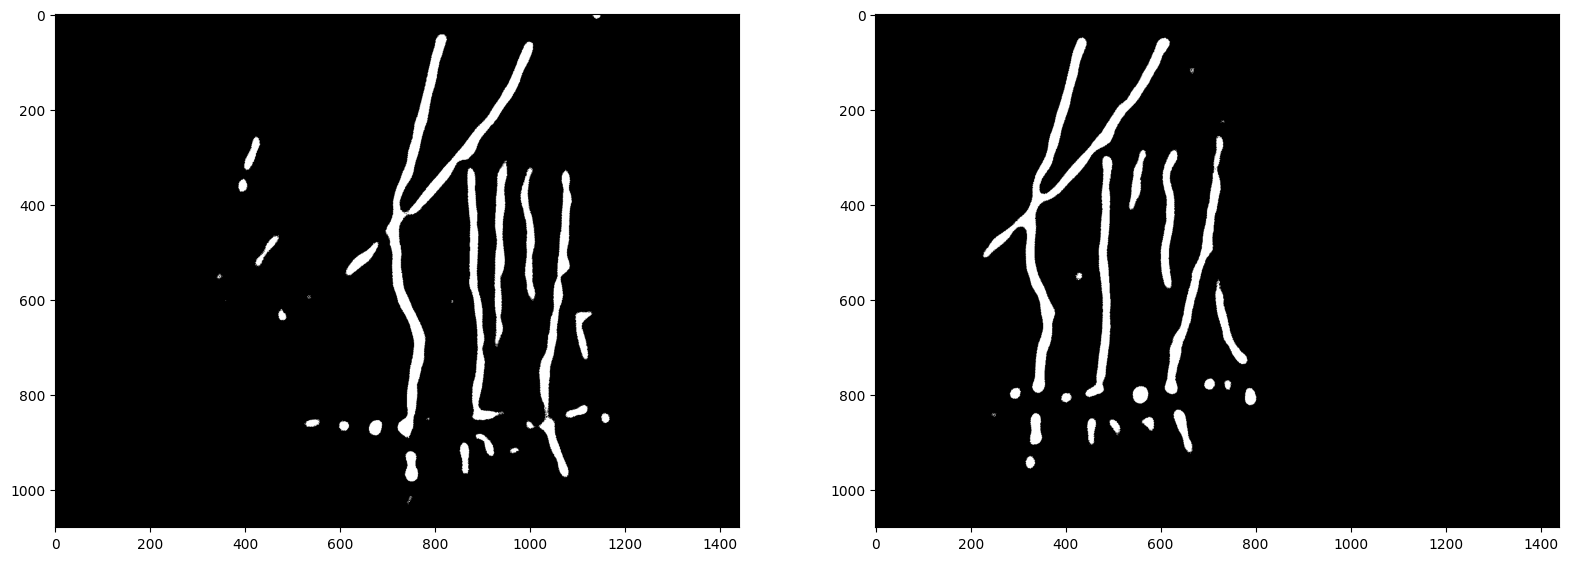

In [18]:
vein_l = cv2.imread(r"./09_05_23/Left_shubham1850nm.png",0)
vein_r = cv2.imread(r"./09_05_23/Right_shubham1850nm.png",0)

vein_l = cv2.undistort(vein_l,mtx1,dist1,None,newcameramtx1)
vein_r = cv2.undistort(vein_r,mtx2,dist2,None,newcameramtx2)

autoencoder_vein = load_model("./server output h5 file/trial_error_vein_train12.h5")

vein_l_input = vein_l.reshape((1,1080, 1440,1)).astype('float32') / 255.
vein_r_input = vein_r.reshape((1,1080, 1440,1)).astype('float32') / 255.

vein_proc_l = autoencoder_vein.predict(vein_l_input)
vein_proc_l = (vein_proc_l.reshape((1080, 1440)) * 255 ).astype('uint8')
vein_proc_r = autoencoder_vein.predict(vein_r_input)
vein_proc_r = (vein_proc_r.reshape((1080, 1440)) * 255 ).astype('uint8')

vein_proc_l = cv2.GaussianBlur(vein_proc_l,(75,75),0)
vein_proc_r = cv2.GaussianBlur(vein_proc_r,(75,75),0)

vein_proc_l = cv2.adaptiveThreshold(vein_proc_l, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 35, 5)
vein_proc_r = cv2.adaptiveThreshold(vein_proc_r, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 35, 5)

# vein_proc_l = sp_noise(vein_proc_l, 0.1)
# vein_proc_r = sp_noise(vein_proc_r, 0.1)

# clahe = cv2.createCLAHE(clipLimit = 8)

# feat1 = clahe.apply(vein_l)
# feat2 = clahe.apply(vein_r)

feat1 = vein_proc_l
feat2 = vein_proc_r

plt.figure(figsize=(30,10))

ax = plt.subplot(1,3,1)

plt.imshow(vein_proc_l,cmap='gray')
# plt.imshow(feat1,cmap='gray')

# target image

ax = plt.subplot(1,3,2)
plt.imshow(vein_proc_r,cmap='gray')
# plt.imshow(feat2,cmap='gray')

In [ ]:
vein_l = cv2.imread(r"./vein_images/Left_Vein01850nm.png",0)
vein_r = cv2.imread(r"./vein_images/Right_Vein01850nm.png",0)

vein_l = cv2.undistort(vein_l,mtx1,dist1,None,newcameramtx1)
vein_r = cv2.undistort(vein_r,mtx2,dist2,None,newcameramtx2)

autoencoder_vein = load_model("./server output h5 file/trial_error_vein_train12.h5")

vein_l_input = vein_l.reshape((1,1080, 1440,1)).astype('float32') / 255.
vein_r_input = vein_r.reshape((1,1080, 1440,1)).astype('float32') / 255.

vein_proc_l = autoencoder_vein.predict(vein_l_input)
vein_proc_l = (vein_proc_l.reshape((1080, 1440)) * 255 ).astype('uint8')
vein_proc_r = autoencoder_vein.predict(vein_r_input)
vein_proc_r = (vein_proc_r.reshape((1080, 1440)) * 255 ).astype('uint8')

vein_proc_l = cv2.GaussianBlur(vein_proc_l,(55,55),0)
vein_proc_r = cv2.GaussianBlur(vein_proc_r,(55,55),0)

vein_proc_l = cv2.adaptiveThreshold(vein_proc_l, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 35, 5)
vein_proc_r = cv2.adaptiveThreshold(vein_proc_r, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 35, 5)

# vein_proc_l = sp_noise(vein_proc_l, 0.1)
# vein_proc_r = sp_noise(vein_proc_r, 0.1)

# clahe = cv2.createCLAHE(clipLimit = 8)

# feat1 = clahe.apply(vein_l)
# feat2 = clahe.apply(vein_r)

feat1 = vein_proc_l
feat2 = vein_proc_r

plt.figure(figsize=(30,10))

ax = plt.subplot(1,3,1)

plt.imshow(vein_proc_l,cmap='gray')
# plt.imshow(feat1,cmap='gray')

# target image

ax = plt.subplot(1,3,2)
plt.imshow(vein_proc_r,cmap='gray')
# plt.imshow(feat2,cmap='gray')

In [20]:
#scaling down the images
scale = 1
widthl = int(feat1.shape[1]/scale)
heightl = int(feat1.shape[0]/scale)
diml = (widthl, heightl)
img1 = cv2.resize(feat1, diml, cv2.INTER_AREA)

widthr = int(feat2.shape[1]/scale)
heightr = int(feat2.shape[0]/scale)
dimr = (widthr, heightr)
img2 = cv2.resize(feat2, dimr, cv2.INTER_AREA)

In [21]:
orb = cv2.ORB_create(nfeatures = 1500, edgeThreshold = 180, patchSize = 180, WTA_K = 4)

KeyPoints1, des1 = orb.detectAndCompute(img1, None)
KeyPoints2, des2 = orb.detectAndCompute(img2, None)
len(KeyPoints1)

1175

In [22]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck= True)
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
len(matches)

223

In [23]:
matching_result = cv2.drawMatches(img1, KeyPoints1, img2, KeyPoints2, matches, None, flags=2)

mr = cv2.resize(matching_result, (0, 0), fx = 0.5, fy = 0.5)
# plt.figure(figsize=(30,10))
# ax = plt.subplot(1,3,1)
# plt.imshow(mr, cmap = 'gray')

p1=[]
p2=[]
for match in matches:
    p1.append([KeyPoints1[match.queryIdx].pt])
    p2.append([KeyPoints2[match.trainIdx].pt])

p1 = np.array(p1)
p2 = np.array(p2)

p1 = p1.reshape(p1.shape[0],2)
p2 = p2.reshape(p2.shape[0],2)

p1 = p1*scale
p2 = p2*scale

# Homography

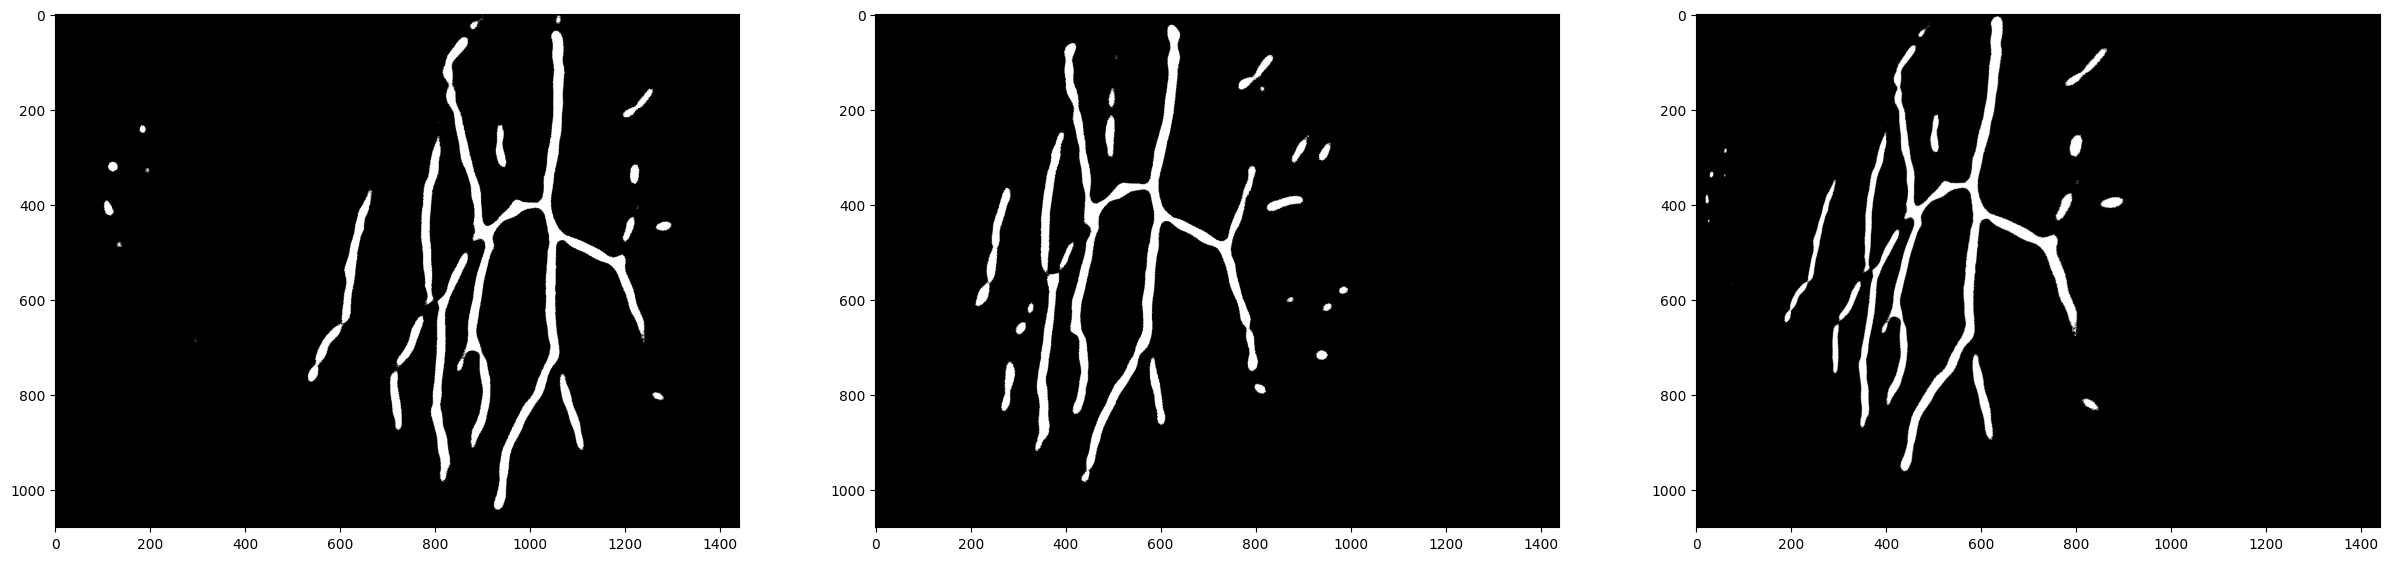

In [24]:
# Homography

h,status = cv2.findHomography(p1, p2, cv2.RANSAC, ransacReprojThreshold = 100, maxIters = 15, confidence = 0.999)

im_out = cv2.warpPerspective(img1,  h, (img1.shape[1],img1.shape[0]))

plt.figure(figsize=(30,10))
ax = plt.subplot(1,3,1)
plt.imshow(img1,cmap='gray')

# target image

ax = plt.subplot(1,3,2)
plt.imshow(img2,cmap='gray')
cv2.imwrite('image_r.png', img2)

ax = plt.subplot(1,3,3)
plt.imshow(im_out,cmap='gray')
cv2.imwrite('homography_out.png', im_out)

im_out = cv2.resize(im_out,(1440,1080))

a_h = np.where(im_out==255)
a_h=np.array(a_h)

pa_h = []
for i in range(len(a_h[0])):
    pa_h32 = (a_h[0][i],a_h[1][i])
    pa_h.append(pa_h32)

pa_h = np.array(pa_h)

In [ ]:
# Check the overlap
right = cv2.imread(r"./image_r.png")
hom_left = cv2.imread(r"./homography_out.png")
dst = cv2.addWeighted(right, 0.4, hom_left, 0.9, 0)

# img_arr = np.hstack((img1, img2))
# cv2.imshow('Input Images',img_arr)
cv2.imshow('Blended Image',dst)

cv2.waitKey(0)
cv2.destroyAllWindows()

## Triangulation

In [25]:
img1 = np.array(img1)
a = np.where(img1 == 255)
#     a_cp = cp.array(a)
pa = []
    
for i in range(len(a[0])):
    pa32 = (a[0][i],a[1][i])
    #     print(p32)
    pa.append(pa32)
pa = np.array(pa)
print(pa)

pa_h = []
for i in range(len(a[0])):
#         pa_3darr = np.array([a[0][i],a[1][i], 1], dtype = "float64")
#         pa_3d = cp.array(pa_3darr.get())
    tmp = np.array([a[0][i],a[1][i], 1])
    pa_h32 = np.dot(h,tmp)
    pa_h32 = (pa_h32[0],pa_h32[1])
    #     print(pa_h32)
    pa_h.append(pa_h32)
pa_h = np.asarray(pa_h)

[[   0 1058]
 [   0 1059]
 [   0 1060]
 ...
 [1042  936]
 [1043  931]
 [1043  933]]


In [37]:
#RT matrix for C1 is identity.
RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
P1 = mtx1 @ RT1 #projection matrix for C1
 
#RT matrix for C2 is the R and T obtained from stereo calibration.
RT2 = np.concatenate([R, T], axis = -1)
P2 = mtx2 @ RT2 #projection matrix for C2


In [45]:
def DLT(P1, P2, point1, point2):
    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = np.array(A).reshape((4,4))
    #print('A: ')
    #print(A)
 
    B = A.transpose() @ A
    from scipy import linalg
    U, s, Vh = linalg.svd(B, full_matrices = False)
 
    print('Triangulated point: ')
    print(Vh[3,0:3]/Vh[3,3])
    
    return Vh[3,0:3]/Vh[3,3]

In [46]:
def DLTg(P1, P2, point1, point2):
    P1 = cp.array(P1)
    P2 = cp.array(P2)
    point1 = cp.array(point1)
    point2 = cp.array(point2)
    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = cp.array(A).reshape((4,4))
    #print('A: ')
    #print(A)
 
    B = A.transpose() @ A
    from cupy import linalg
    U, s, Vh = linalg.svd(B, full_matrices = False)
 
    print('Triangulated point: ')
    print(Vh[3,0:3]/Vh[3,3])
    
    return Vh[3,0:3]/Vh[3,3]

In [48]:
# pa = pa.reshape(len(pa),2)
# pa = np.array(pa)
# pb = pb.reshape(len(pb),2)
# pb=np.array(pb)

# s1 = time.time()
# p3ds = []
# for uv1, uv2 in zip(pa, pa_h):
#     _p3d = DLT(P1, P2, uv1, uv2)
# #     if _p3d[0]<1440 and _p3d[1]<1440 and _p3d[2]<1440:
#     p3ds.append(_p3d)
# p3ds = np.array(p3ds)
# e1 = time.time()
# print(e1-s1)

s2 = time.time()
p3ds = []
for uv1, uv2 in zip(pa, pa_h):
    _p3d = DLTg(P1, P2, uv1, uv2)
#     if _p3d[0]<1440 and _p3d[1]<1440 and _p3d[2]<1440:
    p3ds.append(_p3d)
p3ds = np.array(p3ds)
e2 = time.time()
print(e2-s2)

# p3ds

Triangulated point: 
[-37.59053929  40.92551454 141.4756059 ]
Triangulated point: 
[-37.59137699  40.99334244 141.48408562]
Triangulated point: 
[-37.59221303  41.06117856 141.49256479]
Triangulated point: 
[-37.5930474   41.12902291 141.50104343]
Triangulated point: 
[-37.52963522  40.91509319 141.47351139]
Triangulated point: 
[-37.53213824  41.11858136 141.49895044]
Triangulated point: 
[-37.46872846  40.90466887 141.47139647]
Triangulated point: 
[-37.47122638  41.10813682 141.49683703]
Triangulated point: 
[-37.25480549  30.21821126 140.11444677]
Triangulated point: 
[-37.34607442  40.81601863 141.45862315]
Triangulated point: 
[-37.34690697  40.88381132 141.4671054 ]
Triangulated point: 
[-37.34773787  40.95161224 141.47558712]
Triangulated point: 
[-37.34856711  41.01942138 141.48406831]
Triangulated point: 
[-37.35022065  41.15506433 141.50102909]
Triangulated point: 
[-37.35104493  41.22289813 141.50950868]
Triangulated point: 
[-37.28599229  40.87337811 141.46492924]
Triangul

Triangulated point: 
[-36.26658646  28.94118201 139.93108646]
Triangulated point: 
[-36.26766658  29.0074164  139.9396528 ]
Triangulated point: 
[-36.26874519  29.07365918 139.94821876]
Triangulated point: 
[-36.2698223   29.13991037 139.95678434]
Triangulated point: 
[-36.27089789  29.20616995 139.96534955]
Triangulated point: 
[-36.27197198  29.27243794 139.97391437]
Triangulated point: 
[-36.27411561  29.40499911 139.99104288]
Triangulated point: 
[-36.27518517  29.47129229 139.99960656]
Triangulated point: 
[-36.4313095   40.59163208 141.41533992]
Triangulated point: 
[-36.43292521  40.72700443 141.43231958]
Triangulated point: 
[-36.43453447  40.86240969 141.44929725]
Triangulated point: 
[-36.43533668  40.93012465 141.45778533]
Triangulated point: 
[-36.20056017  28.60090471 139.88571244]
Triangulated point: 
[-36.20164568  28.66709022 139.89428078]
Triangulated point: 
[-36.20272968  28.73328413 139.90284875]
Triangulated point: 
[-36.20381218  28.79948645 139.91141635]
Triangul

Triangulated point: 
[-35.45667303  40.49144524 141.38165461]
Triangulated point: 
[-35.3909884   40.07567049 141.32784986]
Triangulated point: 
[-35.39177604  40.14319303 141.33635023]
Triangulated point: 
[-35.39256212  40.2107238  141.34485013]
Triangulated point: 
[-35.39334662  40.2782628  141.35334957]
Triangulated point: 
[-35.39412956  40.34581004 141.36184855]
Triangulated point: 
[-35.39491094  40.4133655  141.37034707]
Triangulated point: 
[-35.39569074  40.48092919 141.37884512]
Triangulated point: 
[-35.39646897  40.54850112 141.38734271]
Triangulated point: 
[-35.39724564  40.61608126 141.39583984]
Triangulated point: 
[-35.32843791  39.93018756 141.30801424]
Triangulated point: 
[-35.32922697  39.99768659 141.31651597]
Triangulated point: 
[-35.33001446  40.06519385 141.32501724]
Triangulated point: 
[-35.3308004   40.13270935 141.33351805]
Triangulated point: 
[-35.33158476  40.20023308 141.34201841]
Triangulated point: 
[-35.33236757  40.26776504 141.3505183 ]
Triangul

Triangulated point: 
[-34.78500695  40.30812087 141.34112496]
Triangulated point: 
[-34.78576982  40.37561379 141.34962755]
Triangulated point: 
[-34.78653114  40.44311495 141.3581297 ]
Triangulated point: 
[-34.78729093  40.51062432 141.3666314 ]
Triangulated point: 
[-34.78804916  40.57814193 141.37513266]
Triangulated point: 
[-34.78880586  40.64566776 141.38363348]
Triangulated point: 
[-34.789561    40.71320182 141.39213384]
Triangulated point: 
[-34.79031461  40.7807441  141.40063376]
Triangulated point: 
[-34.79106666  40.8482946  141.40913324]
Triangulated point: 
[-34.79181717  40.91585332 141.41763226]
Triangulated point: 
[-34.79256613  40.98342027 141.42613084]
Triangulated point: 
[-34.71553277  39.55578067 141.24452811]
Triangulated point: 
[-34.71631087  39.62317588 141.25303596]
Triangulated point: 
[-34.71708742  39.69057933 141.26154338]
Triangulated point: 
[-34.71786244  39.75799102 141.27005036]
Triangulated point: 
[-34.71863593  39.82541095 141.2785569 ]
Triangul

Triangulated point: 
[-34.48300138  40.52527227 141.35976516]
Triangulated point: 
[-34.48374967  40.5927624  141.36826824]
Triangulated point: 
[-34.48449642  40.66026075 141.37677088]
Triangulated point: 
[-34.48524164  40.72776733 141.38527309]
Triangulated point: 
[-34.48598532  40.79528214 141.39377487]
Triangulated point: 
[-34.48672748  40.86280516 141.4022762 ]
Triangulated point: 
[-34.48746809  40.93033641 141.4107771 ]
Triangulated point: 
[-34.48820717  40.99787587 141.41927755]
Triangulated point: 
[-34.48894472  41.06542356 141.42777757]
Triangulated point: 
[-34.23638343  26.78998917 139.59664077]
Triangulated point: 
[-34.23743326  26.85575791 139.60521942]
Triangulated point: 
[-34.23848169  26.92153506 139.61379777]
Triangulated point: 
[-34.2395287   26.98732061 139.62237583]
Triangulated point: 
[-34.2405743   27.05311456 139.63095359]
Triangulated point: 
[-34.24161849  27.11891691 139.63953105]
Triangulated point: 
[-34.24266126  27.18472766 139.64810822]
Triangul

Triangulated point: 
[-34.2314368   39.80876462 141.2620316 ]
Triangulated point: 
[-34.23219357  39.87614373 141.27054071]
Triangulated point: 
[-34.23294882  39.94353107 141.2790494 ]
Triangulated point: 
[-34.23370255  40.01092665 141.28755767]
Triangulated point: 
[-34.23445476  40.07833046 141.29606552]
Triangulated point: 
[-34.23520546  40.14574251 141.30457295]
Triangulated point: 
[-34.23595463  40.21316278 141.31307995]
Triangulated point: 
[-34.23670228  40.28059129 141.32158653]
Triangulated point: 
[-34.23744842  40.34802803 141.33009268]
Triangulated point: 
[-34.23819303  40.41547299 141.3385984 ]
Triangulated point: 
[-34.23893612  40.48292619 141.34710371]
Triangulated point: 
[-34.23967768  40.55038761 141.35560858]
Triangulated point: 
[-34.24041773  40.61785725 141.36411303]
Triangulated point: 
[-34.24115625  40.68533512 141.37261705]
Triangulated point: 
[-34.24189324  40.75282121 141.38112064]
Triangulated point: 
[-34.24262871  40.82031553 141.3896238 ]
Triangul

Triangulated point: 
[-33.75037111  26.65136884 139.56186091]
Triangulated point: 
[-33.75140491  26.71707204 139.57044011]
Triangulated point: 
[-33.75243733  26.78278364 139.57901904]
Triangulated point: 
[-33.75346835  26.84850363 139.58759768]
Triangulated point: 
[-33.75449797  26.91423203 139.59617605]
Triangulated point: 
[-33.7555262   26.97996882 139.60475413]
Triangulated point: 
[-33.75655303  27.04571401 139.61333193]
Triangulated point: 
[-33.75757847  27.1114676  139.62190944]
Triangulated point: 
[-33.75860251  27.17722958 139.63048667]
Triangulated point: 
[-33.75962516  27.24299995 139.63906362]
Triangulated point: 
[-33.76064641  27.30877872 139.64764028]
Triangulated point: 
[-33.76166626  27.37456589 139.65621665]
Triangulated point: 
[-33.76268471  27.44036144 139.66479274]
Triangulated point: 
[-33.76370176  27.50616539 139.67336854]
Triangulated point: 
[-33.76471741  27.57197773 139.68194406]
Triangulated point: 
[-33.76573165  27.63779846 139.69051928]
Triangul

[-33.58274308  27.54433613 139.67178779]
Triangulated point: 
[-33.74188529  39.58989974 141.2186684 ]
Triangulated point: 
[-33.74263142  39.65720454 141.22718168]
Triangulated point: 
[-33.74337606  39.72451758 141.23569456]
Triangulated point: 
[-33.7441192   39.79183885 141.24420704]
Triangulated point: 
[-33.74486084  39.85916836 141.25271911]
Triangulated point: 
[-33.74560098  39.92650611 141.26123077]
Triangulated point: 
[-33.74633963  39.99385209 141.26974203]
Triangulated point: 
[-33.74707677  40.0612063  141.27825289]
Triangulated point: 
[-33.74781242  40.12856875 141.28676333]
Triangulated point: 
[-33.74854657  40.19593943 141.29527337]
Triangulated point: 
[-33.74927921  40.26331833 141.30378301]
Triangulated point: 
[-33.75001035  40.33070547 141.31229223]
Triangulated point: 
[-33.75074     40.39810083 141.32080104]
Triangulated point: 
[-33.75146813  40.46550442 141.32930945]
Triangulated point: 
[-33.75219477  40.53291624 141.33781744]
Triangulated point: 
[-33.752

Triangulated point: 
[-33.39572953  27.18792278 139.61856827]
Triangulated point: 
[-33.39673784  27.25365831 139.62714518]
Triangulated point: 
[-33.39774477  27.31940223 139.6357218 ]
Triangulated point: 
[-33.39875031  27.38515454 139.64429816]
Triangulated point: 
[-33.39975446  27.45091524 139.65287423]
Triangulated point: 
[-33.55885213  39.55830667 141.20845299]
Triangulated point: 
[-33.55959314  39.62558965 141.2169675 ]
Triangulated point: 
[-33.56033266  39.69288086 141.22548161]
Triangulated point: 
[-33.5610707   39.76018031 141.23399533]
Triangulated point: 
[-33.56180724  39.82748799 141.24250864]
Triangulated point: 
[-33.56254229  39.89480391 141.25102156]
Triangulated point: 
[-33.56327585  39.96212807 141.25953409]
Triangulated point: 
[-33.56400792  40.02946046 141.26804621]
Triangulated point: 
[-33.5647385   40.09680108 141.27655793]
Triangulated point: 
[-33.56546758  40.16414993 141.28506925]
Triangulated point: 
[-33.56619517  40.23150701 141.29358016]
Triangul

Triangulated point: 
[-33.3866913   40.53647053 141.32574868]
Triangulated point: 
[-33.38740492  40.60385507 141.33425848]
Triangulated point: 
[-33.38811704  40.67124784 141.34276789]
Triangulated point: 
[-33.38882767  40.73864883 141.35127689]
Triangulated point: 
[-33.38953682  40.80605804 141.35978549]
Triangulated point: 
[-33.39024447  40.87347547 141.36829369]
Triangulated point: 
[-33.39095063  40.94090112 141.37680149]
Triangulated point: 
[-33.39165529  41.00833499 141.38530888]
Triangulated point: 
[-33.12973675  25.64224889 139.40715757]
Triangulated point: 
[-33.13076791  25.70776235 139.41574056]
Triangulated point: 
[-33.13179771  25.77328421 139.4243233 ]
Triangulated point: 
[-33.13282615  25.83881448 139.43290579]
Triangulated point: 
[-33.13385322  25.90435314 139.44148803]
Triangulated point: 
[-33.13487893  25.96990021 139.45007001]
Triangulated point: 
[-33.13590328  26.03545567 139.45865174]
Triangulated point: 
[-33.13692626  26.10101953 139.46723322]
Triangul

Triangulated point: 
[-33.20356233  40.50450047 141.31518498]
Triangulated point: 
[-33.20427094  40.57186303 141.32369608]
Triangulated point: 
[-33.20497807  40.63923383 141.33220679]
Triangulated point: 
[-33.20568371  40.70661284 141.34071711]
Triangulated point: 
[-33.20638787  40.77400008 141.34922703]
Triangulated point: 
[-33.20709055  40.84139554 141.35773656]
Triangulated point: 
[-33.20779174  40.90879922 141.36624569]
Triangulated point: 
[-32.94585602  25.48422626 139.37922889]
Triangulated point: 
[-32.94688328  25.54970114 139.38781232]
Triangulated point: 
[-32.94790917  25.61518442 139.39639552]
Triangulated point: 
[-32.94893372  25.68067609 139.40497847]
Triangulated point: 
[-32.94995691  25.74617617 139.41356117]
Triangulated point: 
[-32.95097875  25.81168465 139.42214363]
Triangulated point: 
[-32.95199923  25.87720152 139.43072584]
Triangulated point: 
[-32.95301835  25.94272679 139.4393078 ]
Triangulated point: 
[-32.95403611  26.00826046 139.44788951]
Triangul

Triangulated point: 
[-32.77215951  25.98105701 139.43694614]
Triangulated point: 
[-32.77316934  26.0465772  139.44552758]
Triangulated point: 
[-32.77417783  26.11210579 139.45410877]
Triangulated point: 
[-32.77518497  26.17764276 139.46268972]
Triangulated point: 
[-32.77619075  26.24318813 139.47127043]
Triangulated point: 
[-32.77719518  26.3087419  139.47985088]
Triangulated point: 
[-32.77819826  26.37430405 139.48843109]
Triangulated point: 
[-32.77919998  26.4398746  139.49701106]
Triangulated point: 
[-32.78020035  26.50545353 139.50559077]
Triangulated point: 
[-32.78119936  26.57104085 139.51417024]
Triangulated point: 
[-32.78219702  26.63663657 139.52274946]
Triangulated point: 
[-32.78319332  26.70224067 139.53132843]
Triangulated point: 
[-32.78418826  26.76785316 139.53990714]
Triangulated point: 
[-32.78518184  26.83347403 139.54848561]
Triangulated point: 
[-32.9486712   39.45282567 141.17307616]
Triangulated point: 
[-32.94939515  39.52003534 141.18159469]
Triangul

Triangulated point: 
[-32.51955925  25.29032561 139.33624648]
Triangulated point: 
[-32.52057372  25.35573258 139.3448302 ]
Triangulated point: 
[-32.52158686  25.42114795 139.35341369]
Triangulated point: 
[-32.52259866  25.48657171 139.36199695]
Triangulated point: 
[-32.52360913  25.55200387 139.37057998]
Triangulated point: 
[-32.52461825  25.61744442 139.37916278]
Triangulated point: 
[-32.52562604  25.68289337 139.38774534]
Triangulated point: 
[-32.52663249  25.74835071 139.39632767]
Triangulated point: 
[-32.5276376   25.81381645 139.40490976]
Triangulated point: 
[-32.52864137  25.87929058 139.41349162]
Triangulated point: 
[-32.5296438   25.9447731  139.42207325]
Triangulated point: 
[-32.53064488  26.01026401 139.43065464]
Triangulated point: 
[-32.53164463  26.07576331 139.43923579]
Triangulated point: 
[-32.53264303  26.141271   139.4478167 ]
Triangulated point: 
[-32.53364009  26.20678709 139.45639738]
Triangulated point: 
[-32.5346358   26.27231156 139.46497782]
Triangul

Triangulated point: 
[-32.34275505  25.59033233 139.3677972 ]
Triangulated point: 
[-32.34375624  25.65575924 139.37637968]
Triangulated point: 
[-32.3447561   25.72119454 139.38496194]
Triangulated point: 
[-32.34575463  25.78663824 139.39354396]
Triangulated point: 
[-32.34675183  25.85209032 139.40212576]
Triangulated point: 
[-32.34774769  25.9175508  139.41070733]
Triangulated point: 
[-32.34874221  25.98301966 139.41928867]
Triangulated point: 
[-32.34973541  26.04849691 139.42786977]
Triangulated point: 
[-32.35072726  26.11398256 139.43645065]
Triangulated point: 
[-32.35171778  26.17947658 139.44503129]
Triangulated point: 
[-32.35270697  26.244979   139.4536117 ]
Triangulated point: 
[-32.35369481  26.3104898  139.46219187]
Triangulated point: 
[-32.35468132  26.37600899 139.47077181]
Triangulated point: 
[-32.52077611  39.31168455 141.13857773]
Triangulated point: 
[-32.52148959  39.37883418 141.14709936]
Triangulated point: 
[-32.52220163  39.44599204 141.15562063]
Triangul

Triangulated point: 
[-32.27736919  39.33649669 141.13180706]
Triangulated point: 
[-32.27807442  39.40362477 141.14032987]
Triangulated point: 
[-32.27877821  39.47076108 141.14885233]
Triangulated point: 
[-32.27948057  39.53790564 141.15737443]
Triangulated point: 
[-32.28018148  39.60505843 141.16589618]
Triangulated point: 
[-32.28088096  39.67221945 141.17441757]
Triangulated point: 
[-32.281579    39.73938871 141.18293861]
Triangulated point: 
[-32.2822756   39.80656621 141.19145929]
Triangulated point: 
[-32.28297076  39.87375194 141.19997961]
Triangulated point: 
[-32.28366448  39.9409459  141.20849958]
Triangulated point: 
[-32.28435676  40.0081481  141.21701919]
Triangulated point: 
[-32.28504759  40.07535852 141.22553844]
Triangulated point: 
[-32.28573698  40.14257717 141.23405734]
Triangulated point: 
[-32.28642493  40.20980406 141.24257587]
Triangulated point: 
[-32.28711144  40.27703917 141.25109404]
Triangulated point: 
[-32.2877965   40.34428251 141.25961185]
Triangul

Triangulated point: 
[-32.04015857  39.96547052 141.20141642]
Triangulated point: 
[-32.0408427   40.03265102 141.20993727]
Triangulated point: 
[-32.04152539  40.09983975 141.21845778]
Triangulated point: 
[-32.04220666  40.16703672 141.22697793]
Triangulated point: 
[-32.04288649  40.23424191 141.23549773]
Triangulated point: 
[-32.04356489  40.30145533 141.24401718]
Triangulated point: 
[-32.04424185  40.36867697 141.25253627]
Triangulated point: 
[-32.04491737  40.43590684 141.26105501]
Triangulated point: 
[-32.04559147  40.50314494 141.2695734 ]
Triangulated point: 
[-32.04626412  40.57039126 141.27809143]
Triangulated point: 
[-32.04693534  40.6376458  141.28660911]
Triangulated point: 
[-31.78224567  24.52955236 139.20385747]
Triangulated point: 
[-31.78324671  24.59478688 139.21244271]
Triangulated point: 
[-31.78424646  24.66002978 139.22102775]
Triangulated point: 
[-31.7852449   24.72528108 139.2296126 ]
Triangulated point: 
[-31.78624203  24.79054077 139.23819724]
Triangul

Triangulated point: 
[-31.72806335  39.24108828 141.09620738]
Triangulated point: 
[-31.72875328  39.30814884 141.10473358]
Triangulated point: 
[-31.72944179  39.37521764 141.11325944]
Triangulated point: 
[-31.73012889  39.44229468 141.12178497]
Triangulated point: 
[-31.73081457  39.50937996 141.13031017]
Triangulated point: 
[-31.73149883  39.57647347 141.13883502]
Triangulated point: 
[-31.73218168  39.64357522 141.14735955]
Triangulated point: 
[-31.73286311  39.71068521 141.15588373]
Triangulated point: 
[-31.73354312  39.77780343 141.16440758]
Triangulated point: 
[-31.73422171  39.84492988 141.17293109]
Triangulated point: 
[-31.73489889  39.91206456 141.18145426]
Triangulated point: 
[-31.73557464  39.97920748 141.18997709]
Triangulated point: 
[-31.73624897  40.04635862 141.19849958]
Triangulated point: 
[-31.73692188  40.113518   141.20702173]
Triangulated point: 
[-31.73759337  40.1806856  141.21554353]
Triangulated point: 
[-31.73826344  40.24786143 141.224065  ]
Triangul

Triangulated point: 
[-31.49268638  40.0706557  141.19068981]
Triangulated point: 
[-31.4933512   40.13779308 141.1992132 ]
Triangulated point: 
[-31.49401461  40.20493869 141.20773625]
Triangulated point: 
[-31.49467661  40.27209253 141.21625898]
Triangulated point: 
[-31.49533719  40.3392546  141.22478136]
Triangulated point: 
[-31.49599637  40.40642489 141.23330342]
Triangulated point: 
[-31.49665412  40.47360341 141.24182513]
Triangulated point: 
[-31.49731046  40.54079015 141.25034651]
Triangulated point: 
[-31.23489917  24.31880367 139.14988604]
Triangulated point: 
[-31.23588276  24.38395428 139.15847096]
Triangulated point: 
[-31.23686507  24.44911328 139.1670557 ]
Triangulated point: 
[-31.23784609  24.51428066 139.17564025]
Triangulated point: 
[-31.23882583  24.57945643 139.18422462]
Triangulated point: 
[-31.23980429  24.64464059 139.19280881]
Triangulated point: 
[-31.24078147  24.70983313 139.20139281]
Triangulated point: 
[-31.24175736  24.77503406 139.20997663]
Triangul

Triangulated point: 
[-31.18606771  39.88284492 141.15276466]
Triangulated point: 
[-31.186727    39.94992788 141.16129065]
Triangulated point: 
[-31.18738489  40.01701907 141.16981631]
Triangulated point: 
[-31.18804139  40.08411849 141.17834166]
Triangulated point: 
[-31.18869648  40.15122615 141.18686667]
Triangulated point: 
[-31.18935017  40.21834202 141.19539137]
Triangulated point: 
[-31.19000246  40.28546613 141.20391574]
Triangulated point: 
[-31.19065335  40.35259846 141.21243979]
Triangulated point: 
[-31.19130284  40.41973901 141.22096351]
Triangulated point: 
[-31.19195092  40.48688779 141.2294869 ]
Triangulated point: 
[-31.1925976   40.5540448  141.23800997]
Triangulated point: 
[-30.92996895  24.14396647 139.11156977]
Triangulated point: 
[-30.93094395  24.20906274 139.12015459]
Triangulated point: 
[-30.93191768  24.2741674  139.12873923]
Triangulated point: 
[-30.93289013  24.33928044 139.13732369]
Triangulated point: 
[-30.93386132  24.40440186 139.14590799]
Triangul

Triangulated point: 
[-30.94313989  39.97406309 141.15275073]
Triangulated point: 
[-30.94378972  40.04113199 141.16127761]
Triangulated point: 
[-30.94443816  40.10820912 141.16980417]
Triangulated point: 
[-30.94508521  40.17529448 141.17833042]
Triangulated point: 
[-30.94573087  40.24238806 141.18685635]
Triangulated point: 
[-30.94637513  40.30948988 141.19538197]
Triangulated point: 
[-30.94701801  40.37659991 141.20390727]
Triangulated point: 
[-30.94765949  40.44371818 141.21243225]
Triangulated point: 
[-30.94829958  40.51084466 141.22095692]
Triangulated point: 
[-30.94893828  40.57797937 141.22948126]
Triangulated point: 
[-30.68566074  23.97819969 139.07712286]
Triangulated point: 
[-30.68662935  24.04324899 139.08570759]
Triangulated point: 
[-30.68759669  24.10830668 139.09429217]
Triangulated point: 
[-30.68856278  24.17337275 139.10287657]
Triangulated point: 
[-30.6895276   24.2384472  139.11146082]
Triangulated point: 
[-30.69049116  24.30353003 139.1200449 ]
Triangul

Triangulated point: 
[-30.44904297  24.33283065 139.11102885]
Triangulated point: 
[-30.44999514  24.39789989 139.1196122 ]
Triangulated point: 
[-30.45094606  24.46297752 139.12819539]
Triangulated point: 
[-30.45189572  24.52806351 139.13677843]
Triangulated point: 
[-30.45284413  24.59315789 139.1453613 ]
Triangulated point: 
[-30.45379129  24.65826063 139.15394401]
Triangulated point: 
[-30.45473719  24.72337176 139.16252656]
Triangulated point: 
[-30.45568183  24.78849125 139.17110895]
Triangulated point: 
[-30.45662522  24.85361912 139.17969118]
Triangulated point: 
[-30.45756735  24.91875537 139.18827324]
Triangulated point: 
[-30.45850822  24.98389998 139.19685514]
Triangulated point: 
[-30.63068396  39.18351729 141.03712399]
Triangulated point: 
[-30.63134059  39.25045728 141.04565606]
Triangulated point: 
[-30.63199585  39.31740551 141.05418784]
Triangulated point: 
[-30.63264974  39.38436197 141.06271932]
Triangulated point: 
[-30.63330226  39.45132668 141.0712505 ]
Triangul

Triangulated point: 
[-30.21414298  24.81757489 139.16176739]
Triangulated point: 
[-30.21507632  24.88268063 139.1703491 ]
Triangulated point: 
[-30.21600841  24.94779474 139.17893065]
Triangulated point: 
[-30.38716089  39.20771708 141.02784272]
Triangulated point: 
[-30.3878094   39.27463449 141.0363759 ]
Triangulated point: 
[-30.38845654  39.34156014 141.0449088 ]
Triangulated point: 
[-30.38910233  39.40849402 141.05344141]
Triangulated point: 
[-30.38974674  39.47543614 141.06197372]
Triangulated point: 
[-30.3903898   39.54238649 141.07050574]
Triangulated point: 
[-30.39103149  39.60934508 141.07903748]
Triangulated point: 
[-30.39167181  39.6763119  141.08756891]
Triangulated point: 
[-30.39231076  39.74328696 141.09610006]
Triangulated point: 
[-30.39294835  39.81027024 141.10463091]
Triangulated point: 
[-30.39358457  39.87726176 141.11316147]
Triangulated point: 
[-30.39421943  39.94426151 141.12169174]
Triangulated point: 
[-30.39485291  40.01126948 141.1302217 ]
Triangul

Triangulated point: 
[-30.1530883   40.23610891 141.14622287]
Triangulated point: 
[-30.15370834  40.30312707 141.15475287]
Triangulated point: 
[-30.15432702  40.37015346 141.16328258]
Triangulated point: 
[-30.15494434  40.43718807 141.17181201]
Triangulated point: 
[-30.1555603   40.5042309  141.18034114]
Triangulated point: 
[-30.15617489  40.57128196 141.18886997]
Triangulated point: 
[-29.89517206  23.66763878 138.99300895]
Triangulated point: 
[-29.89611538  23.73256393 139.00159257]
Triangulated point: 
[-29.89705747  23.79749745 139.01017606]
Triangulated point: 
[-29.89799833  23.86243934 139.01875941]
Triangulated point: 
[-29.89893796  23.9273896  139.02734262]
Triangulated point: 
[-29.89987636  23.99234824 139.03592569]
Triangulated point: 
[-29.90081354  24.05731525 139.04450863]
Triangulated point: 
[-29.90174948  24.12229062 139.05309142]
Triangulated point: 
[-29.90268419  24.18727437 139.06167408]
Triangulated point: 
[-29.90361766  24.25226649 139.0702566 ]
Triangul

Triangulated point: 
[-29.72918155  24.74545487 139.12495764]
Triangulated point: 
[-29.73009733  24.81049922 139.13353856]
Triangulated point: 
[-29.73101188  24.87555193 139.14211934]
Triangulated point: 
[-29.7319252   24.94061301 139.15069997]
Triangulated point: 
[-29.89817163  39.0552718  140.98270316]
Triangulated point: 
[-29.89880799  39.12211894 140.99123937]
Triangulated point: 
[-29.899443    39.18897431 140.9997753 ]
Triangulated point: 
[-29.90007668  39.25583792 141.00831096]
Triangulated point: 
[-29.900709    39.32270976 141.01684635]
Triangulated point: 
[-29.90133999  39.38958984 141.02538147]
Triangulated point: 
[-29.90196962  39.45647816 141.03391631]
Triangulated point: 
[-29.90259791  39.52337471 141.04245088]
Triangulated point: 
[-29.90322486  39.59027949 141.05098517]
Triangulated point: 
[-29.90385045  39.65719251 141.05951918]
Triangulated point: 
[-29.9044747   39.72411376 141.06805292]
Triangulated point: 
[-29.9050976   39.79104324 141.07658638]
Triangul

Triangulated point: 
[-29.72437744  40.02637641 141.09667028]
Triangulated point: 
[-29.72498863  40.09332364 141.10520344]
Triangulated point: 
[-29.72559849  40.1602791  141.11373633]
Triangulated point: 
[-29.726207    40.22724278 141.12226895]
Triangulated point: 
[-29.72681416  40.29421469 141.13080129]
Triangulated point: 
[-29.72741998  40.36119482 141.13933335]
Triangulated point: 
[-29.47295395  23.73518128 138.97734901]
Triangulated point: 
[-29.47387923  23.80006927 138.98593142]
Triangulated point: 
[-29.47480329  23.86496563 138.99451371]
Triangulated point: 
[-29.47572614  23.92987036 139.00309587]
Triangulated point: 
[-29.47664778  23.99478346 139.01167791]
Triangulated point: 
[-29.4775682   24.05970491 139.02025982]
Triangulated point: 
[-29.47848741  24.12463474 139.02884161]
Triangulated point: 
[-29.47940539  24.18957293 139.03742327]
Triangulated point: 
[-29.48032217  24.25451948 139.0460048 ]
Triangulated point: 
[-29.48123772  24.3194744  139.0545862 ]
Triangul

Triangulated point: 
[-29.29760441  24.16269586 139.02305159]
Triangulated point: 
[-29.29851456  24.22761918 139.03163274]
Triangulated point: 
[-29.2994235   24.29255085 139.04021376]
Triangulated point: 
[-29.30033122  24.35749089 139.04879467]
Triangulated point: 
[-29.30123773  24.42243929 139.05737545]
Triangulated point: 
[-29.30214303  24.48739605 139.0659561 ]
Triangulated point: 
[-29.30304712  24.55236118 139.07453663]
Triangulated point: 
[-29.30395     24.61733466 139.08311704]
Triangulated point: 
[-29.30485166  24.6823165  139.09169732]
Triangulated point: 
[-29.3057521   24.7473067  139.10027747]
Triangulated point: 
[-29.30665133  24.81230525 139.1088575 ]
Triangulated point: 
[-29.30754935  24.87731217 139.1174374 ]
Triangulated point: 
[-29.47026383  38.9135165  140.94106633]
Triangulated point: 
[-29.4708897   38.98030067 140.94960512]
Triangulated point: 
[-29.47151425  39.04709308 140.95814364]
Triangulated point: 
[-29.47213746  39.11389374 140.96668192]
Triangul

[-29.29330312  39.54935033 141.01196177]
Triangulated point: 
[-29.29391071  39.61619329 141.02049899]
Triangulated point: 
[-29.29451697  39.68304448 141.02903596]
Triangulated point: 
[-29.29512191  39.74990391 141.03757268]
Triangulated point: 
[-29.29572553  39.81677156 141.04610913]
Triangulated point: 
[-29.29632782  39.88364745 141.05464533]
Triangulated point: 
[-29.29692878  39.95053156 141.06318127]
Triangulated point: 
[-29.29752842  40.0174239  141.07171696]
Triangulated point: 
[-29.29812673  40.08432447 141.08025238]
Triangulated point: 
[-29.29872371  40.15123327 141.08878754]
Triangulated point: 
[-29.29931937  40.21815029 141.09732244]
Triangulated point: 
[-29.2999137   40.28507554 141.10585709]
Triangulated point: 
[-29.05340242  23.9970928  138.98644767]
Triangulated point: 
[-29.05430615  24.06196829 138.99502852]
Triangulated point: 
[-29.05520867  24.12685215 139.00360925]
Triangulated point: 
[-29.05610999  24.19174437 139.01218986]
Triangulated point: 
[-29.057

[-28.99456765  40.23062822 141.08133496]
Triangulated point: 
[-28.75222511  24.08203559 138.97885633]
Triangulated point: 
[-28.7531154   24.14688875 138.98743624]
Triangulated point: 
[-28.75400451  24.21175027 138.99601606]
Triangulated point: 
[-28.75489243  24.27662014 139.00459576]
Triangulated point: 
[-28.75577915  24.34149836 139.01317536]
Triangulated point: 
[-28.75666468  24.40638494 139.02175486]
Triangulated point: 
[-28.75754902  24.47127988 139.03033424]
Triangulated point: 
[-28.75843217  24.53618316 139.03891352]
Triangulated point: 
[-28.75931412  24.6010948  139.04749269]
Triangulated point: 
[-28.76019487  24.66601479 139.05607176]
Triangulated point: 
[-28.76107444  24.73094314 139.06465071]
Triangulated point: 
[-28.7619528   24.79587983 139.07322955]
Triangulated point: 
[-28.92033892  38.75031903 140.88850347]
Triangulated point: 
[-28.92095089  38.81702402 140.89704536]
Triangulated point: 
[-28.92156156  38.88373725 140.90558702]
Triangulated point: 
[-28.922

Triangulated point: 
[-28.55656935  38.95261131 140.89241379]
Triangulated point: 
[-28.55716602  39.01930158 140.90095662]
Triangulated point: 
[-28.5577614   39.0860001  140.90949923]
Triangulated point: 
[-28.55835548  39.15270685 140.9180416 ]
Triangulated point: 
[-28.55894828  39.21942184 140.92658376]
Triangulated point: 
[-28.55953978  39.28614506 140.93512568]
Triangulated point: 
[-28.56012998  39.35287652 140.94366737]
Triangulated point: 
[-28.5607189   39.41961621 140.95220884]
Triangulated point: 
[-28.56130651  39.48636414 140.96075007]
Triangulated point: 
[-28.56189283  39.5531203  140.96929108]
Triangulated point: 
[-28.56247786  39.61988469 140.97783185]
Triangulated point: 
[-28.56306159  39.68665731 140.98637239]
Triangulated point: 
[-28.56364402  39.75343816 140.9949127 ]
Triangulated point: 
[-28.56422515  39.82022724 141.00345278]
Triangulated point: 
[-28.56480499  39.88702455 141.01199263]
Triangulated point: 
[-28.56538353  39.95383009 141.02053224]
Triangul

Triangulated point: 
[-28.32058807  39.84347893 140.99143397]
Triangulated point: 
[-28.32116002  39.91025253 140.99997493]
Triangulated point: 
[-28.32173068  39.97703436 141.00851567]
Triangulated point: 
[-28.32230005  40.04382441 141.01705618]
Triangulated point: 
[-28.08831363  24.17771906 138.94837562]
Triangulated point: 
[-28.09003764  24.30731053 138.96553152]
Triangulated point: 
[-28.09089789  24.37211879 138.97410934]
Triangulated point: 
[-28.09175696  24.43693538 138.98268708]
Triangulated point: 
[-28.09261488  24.50176033 138.99126473]
Triangulated point: 
[-28.09347162  24.56659361 138.99984229]
Triangulated point: 
[-28.09432719  24.63143524 139.00841976]
Triangulated point: 
[-28.09518158  24.69628522 139.01699715]
Triangulated point: 
[-28.09688687  24.8260102  139.03415165]
Triangulated point: 
[-28.24964443  38.69883087 140.84100778]
Triangulated point: 
[-28.25023655  38.76545648 140.8495528 ]
Triangulated point: 
[-28.25082738  38.83209034 140.85809759]
Triangul

Triangulated point: 
[-27.84594584  24.14173975 138.92733265]
Triangulated point: 
[-27.84679966  24.20649955 138.93591001]
Triangulated point: 
[-27.84765232  24.2712677  138.9444873 ]
Triangulated point: 
[-27.84850382  24.33604419 138.9530645 ]
Triangulated point: 
[-27.84935416  24.40082902 138.96164163]
Triangulated point: 
[-27.85020335  24.4656222  138.97021868]
Triangulated point: 
[-27.85105137  24.53042371 138.97879565]
Triangulated point: 
[-27.85189822  24.59523357 138.98737254]
Triangulated point: 
[-27.85274392  24.66005176 138.99594935]
Triangulated point: 
[-27.85358845  24.7248783  139.00452608]
Triangulated point: 
[-27.85443182  24.78971317 139.01310272]
Triangulated point: 
[-28.00555944  38.65578215 140.82002156]
Triangulated point: 
[-28.0061448   38.72237566 140.82856775]
Triangulated point: 
[-28.0067289   38.7889774  140.83711374]
Triangulated point: 
[-28.00731173  38.85558739 140.84565952]
Triangulated point: 
[-28.00789328  38.92220561 140.85420509]
Triangul

[-27.82938672  39.42284732 140.90662036]
Triangulated point: 
[-27.82995185  39.48951549 140.91516499]
Triangulated point: 
[-27.83051571  39.55619189 140.92370942]
Triangulated point: 
[-27.8310783   39.62287652 140.93225365]
Triangulated point: 
[-27.83163963  39.68956939 140.94079767]
Triangulated point: 
[-27.83219968  39.75627048 140.94934148]
Triangulated point: 
[-27.83275846  39.82297981 140.95788508]
Triangulated point: 
[-27.83331598  39.88969736 140.96642847]
Triangulated point: 
[-27.83387222  39.95642314 140.97497166]
Triangulated point: 
[-27.91219187  51.96401078 142.49178156]
Triangulated point: 
[-27.91283314  52.10039239 142.5087744 ]
Triangulated point: 
[-27.91315175  52.16859532 142.51727035]
Triangulated point: 
[-27.913469    52.23680634 142.52576599]
Triangulated point: 
[-27.9137849   52.30502545 142.53426132]
Triangulated point: 
[-27.91409945  52.37325264 142.54275633]
Triangulated point: 
[-27.91441264  52.44148791 142.55125103]
Triangulated point: 
[-27.914

Triangulated point: 
[-27.6474025   39.52352147 140.9075868 ]
Triangulated point: 
[-27.64796014  39.59018187 140.91613198]
Triangulated point: 
[-27.64851651  39.6568505  140.92467695]
Triangulated point: 
[-27.64907162  39.72352735 140.93322172]
Triangulated point: 
[-27.64962547  39.79021244 140.94176629]
Triangulated point: 
[-27.65017805  39.85690575 140.95031065]
Triangulated point: 
[-27.72796799  51.85874062 142.46744516]
Triangulated point: 
[-27.72828702  51.92689528 142.47594421]
Triangulated point: 
[-27.7286047   51.99505804 142.48444296]
Triangulated point: 
[-27.72892104  52.06322888 142.4929414 ]
Triangulated point: 
[-27.72923603  52.13140781 142.50143954]
Triangulated point: 
[-27.72954967  52.19959483 142.50993737]
Triangulated point: 
[-27.72986197  52.26778994 142.5184349 ]
Triangulated point: 
[-27.73017292  52.33599314 142.52693212]
Triangulated point: 
[-27.73048252  52.40420442 142.53542903]
Triangulated point: 
[-27.73079077  52.47242378 142.54392563]
Triangul

Triangulated point: 
[-27.46095749  39.09118604 140.84000085]
Triangulated point: 
[-27.46151768  39.15777272 140.84854811]
Triangulated point: 
[-27.46207663  39.22436764 140.85709518]
Triangulated point: 
[-27.46263432  39.29097079 140.86564206]
Triangulated point: 
[-27.46319076  39.35758218 140.87418874]
Triangulated point: 
[-27.46374595  39.4242018  140.88273523]
Triangulated point: 
[-27.46429988  39.49082965 140.89128153]
Triangulated point: 
[-27.46485256  39.55746573 140.89982764]
Triangulated point: 
[-27.46540398  39.62411005 140.90837355]
Triangulated point: 
[-27.46595415  39.69076259 140.91691927]
Triangulated point: 
[-27.46650306  39.75742336 140.92546479]
Triangulated point: 
[-27.46705071  39.82409237 140.93401012]
Triangulated point: 
[-27.54280239  51.5491728  142.41741298]
Triangulated point: 
[-27.54312312  51.617271   142.42591536]
Triangulated point: 
[-27.54344252  51.68537729 142.43441746]
Triangulated point: 
[-27.54376058  51.75349167 142.44291925]
Triangul

[-27.2801093   39.32491783 140.85769904]
Triangulated point: 
[-27.28065951  39.39151306 140.86624644]
Triangulated point: 
[-27.28120848  39.45811652 140.87479366]
Triangulated point: 
[-27.2817562   39.52472822 140.88334069]
Triangulated point: 
[-27.28230268  39.59134815 140.89188753]
Triangulated point: 
[-27.2828479   39.65797631 140.90043418]
Triangulated point: 
[-27.28339188  39.72461269 140.90898064]
Triangulated point: 
[-27.28393461  39.79125731 140.91752692]
Triangulated point: 
[-27.35829938  51.37598438 142.38418536]
Triangulated point: 
[-27.3586191   51.4440422  142.39269043]
Triangulated point: 
[-27.35893749  51.51210813 142.40119522]
Triangulated point: 
[-27.35925455  51.58018215 142.40969972]
Triangulated point: 
[-27.35957028  51.64826427 142.41820394]
Triangulated point: 
[-27.35988468  51.7163545  142.42670786]
Triangulated point: 
[-27.36019775  51.78445282 142.4352115 ]
Triangulated point: 
[-27.3605095   51.85255923 142.44371485]
Triangulated point: 
[-27.360

Triangulated point: 
[-27.0937422   38.89298071 140.78973329]
Triangulated point: 
[-27.09429488  38.95950207 140.79828265]
Triangulated point: 
[-27.09484632  39.02603167 140.80683184]
Triangulated point: 
[-27.09539652  39.09256951 140.81538085]
Triangulated point: 
[-27.09594548  39.15911558 140.82392968]
Triangulated point: 
[-27.09649321  39.22566989 140.83247834]
Triangulated point: 
[-27.0970397   39.29223243 140.84102682]
Triangulated point: 
[-27.09758494  39.3588032  140.84957511]
Triangulated point: 
[-27.09812895  39.42538221 140.85812323]
Triangulated point: 
[-27.09867172  39.49196944 140.86667117]
Triangulated point: 
[-27.09921325  39.55856491 140.87521893]
Triangulated point: 
[-27.09975353  39.62516861 140.8837665 ]
Triangulated point: 
[-27.10029257  39.69178054 140.89231389]
Triangulated point: 
[-27.10083038  39.7584007  140.9008611 ]
Triangulated point: 
[-27.17445364  51.33893375 142.36777866]
Triangulated point: 
[-27.17476966  51.40696732 142.37628582]
Triangul

Triangulated point: 
[-26.763599    24.62626707 138.9144292 ]
Triangulated point: 
[-26.76440224  24.69096564 138.92300297]
Triangulated point: 
[-26.76520436  24.75567253 138.9315767 ]
Triangulated point: 
[-26.76600535  24.82038776 138.94015037]
Triangulated point: 
[-26.76680522  24.8851113  138.948724  ]
Triangulated point: 
[-26.76760396  24.94984318 138.95729758]
Triangulated point: 
[-26.90740325  38.46161357 140.72156863]
Triangulated point: 
[-26.90795829  38.52806097 140.73011985]
Triangulated point: 
[-26.9085121   38.59451662 140.7386709 ]
Triangulated point: 
[-26.90906468  38.6609805  140.74722178]
Triangulated point: 
[-26.90961604  38.72745262 140.7557725 ]
Triangulated point: 
[-26.91016616  38.79393298 140.76432305]
Triangulated point: 
[-26.91071506  38.86042157 140.77287343]
Triangulated point: 
[-26.91126273  38.9269184  140.78142364]
Triangulated point: 
[-26.91180916  38.99342347 140.78997368]
Triangulated point: 
[-26.91235437  39.05993678 140.79852354]
Triangul

Triangulated point: 
[-26.57702999  24.21113909 138.84591491]
Triangulated point: 
[-26.57783345  24.27576335 138.85448841]
Triangulated point: 
[-26.57863579  24.34039594 138.86306186]
Triangulated point: 
[-26.57943702  24.40503685 138.87163528]
Triangulated point: 
[-26.58023714  24.46968608 138.88020866]
Triangulated point: 
[-26.58103613  24.53434364 138.888782  ]
Triangulated point: 
[-26.58183401  24.59900953 138.8973553 ]
Triangulated point: 
[-26.58263078  24.66368374 138.90592856]
Triangulated point: 
[-26.58342642  24.72836627 138.91450177]
Triangulated point: 
[-26.58422095  24.79305713 138.92307495]
Triangulated point: 
[-26.58501435  24.85775631 138.93164808]
Triangulated point: 
[-26.58580664  24.92246381 138.94022117]
Triangulated point: 
[-26.72441945  38.42918169 140.70452158]
Triangulated point: 
[-26.72496944  38.49560449 140.71307359]
Triangulated point: 
[-26.7255182   38.56203552 140.72162544]
Triangulated point: 
[-26.72606575  38.6284748  140.73017713]
Triangul

Triangulated point: 
[-26.39691009  24.31323164 138.8458108 ]
Triangulated point: 
[-26.39770481  24.37784812 138.85438367]
Triangulated point: 
[-26.39849843  24.44247293 138.8629565 ]
Triangulated point: 
[-26.39929093  24.50710606 138.8715293 ]
Triangulated point: 
[-26.40008233  24.57174752 138.88010206]
Triangulated point: 
[-26.40087261  24.63639729 138.88867479]
Triangulated point: 
[-26.40166179  24.70105539 138.89724749]
Triangulated point: 
[-26.40244985  24.76572181 138.90582014]
Triangulated point: 
[-26.4032368   24.83039654 138.91439276]
Triangulated point: 
[-26.54144943  38.39672997 140.68729232]
Triangulated point: 
[-26.54199437  38.46312809 140.69584511]
Triangulated point: 
[-26.54253809  38.52953444 140.70439775]
Triangulated point: 
[-26.5430806   38.59594904 140.71295023]
Triangulated point: 
[-26.5436219   38.66237187 140.72150256]
Triangulated point: 
[-26.54416198  38.72880294 140.73005473]
Triangulated point: 
[-26.54470084  38.79524224 140.73860675]
Triangul

Triangulated point: 
[-26.43889871  51.12246288 142.29178966]
Triangulated point: 
[-26.43920125  51.19039061 142.30030531]
Triangulated point: 
[-26.43950251  51.25832645 142.3088207 ]
Triangulated point: 
[-26.43980248  51.3262704  142.31733585]
Triangulated point: 
[-26.44010115  51.39422246 142.32585074]
Triangulated point: 
[-26.44039853  51.46218264 142.33436538]
Triangulated point: 
[-26.14830289  23.76063528 138.7539529 ]
Triangulated point: 
[-26.14909774  23.82515253 138.76252519]
Triangulated point: 
[-26.14989149  23.88967809 138.77109746]
Triangulated point: 
[-26.15068414  23.95421198 138.77966971]
Triangulated point: 
[-26.15147569  24.01875419 138.78824194]
Triangulated point: 
[-26.15226615  24.08330472 138.79681415]
Triangulated point: 
[-26.15305551  24.14786356 138.80538633]
Triangulated point: 
[-26.15384376  24.21243073 138.81395849]
Triangulated point: 
[-26.15463092  24.27700622 138.82253062]
Triangulated point: 
[-26.15541698  24.34159003 138.83110273]
Triangul

Triangulated point: 
[-26.1849965   39.52730123 140.80624302]
Triangulated point: 
[-26.18550967  39.59379799 140.81479471]
Triangulated point: 
[-26.25143902  50.27106321 142.17222691]
Triangulated point: 
[-26.25175324  50.33886887 142.18074748]
Triangulated point: 
[-26.25206618  50.40668265 142.18926781]
Triangulated point: 
[-26.25237784  50.47450455 142.1977879 ]
Triangulated point: 
[-26.25268821  50.54233458 142.20630775]
Triangulated point: 
[-26.25299731  50.61017273 142.21482737]
Triangulated point: 
[-26.25330513  50.678019   142.22334674]
Triangulated point: 
[-26.25361167  50.7458734  142.23186587]
Triangulated point: 
[-26.25391693  50.81373591 142.24038476]
Triangulated point: 
[-26.2542209   50.88160654 142.2489034 ]
Triangulated point: 
[-26.25452359  50.9494853  142.25742181]
Triangulated point: 
[-26.254825    51.01737217 142.26593997]
Triangulated point: 
[-26.25512513  51.08526716 142.27445788]
Triangulated point: 
[-26.25542397  51.15317026 142.28297555]
Triangul

Triangulated point: 
[-25.93740074  39.01833721 140.72264716]
Triangulated point: 
[-25.93791573  39.08474313 140.73120098]
Triangulated point: 
[-25.93842953  39.15115728 140.73975465]
Triangulated point: 
[-25.93894213  39.21757967 140.74830818]
Triangulated point: 
[-25.93945353  39.28401029 140.75686158]
Triangulated point: 
[-25.93996374  39.35044914 140.76541483]
Triangulated point: 
[-25.94047275  39.41689623 140.77396795]
Triangulated point: 
[-25.94098057  39.48335154 140.78252092]
Triangulated point: 
[-25.94148718  39.54981509 140.79107375]
Triangulated point: 
[-25.9419926   39.61628686 140.79962644]
Triangulated point: 
[-26.00555692  50.01854311 142.12322877]
Triangulated point: 
[-26.00586988  50.0862914  142.1317526 ]
Triangulated point: 
[-26.00618158  50.15404781 142.14027619]
Triangulated point: 
[-26.00649201  50.22181236 142.14879955]
Triangulated point: 
[-26.00680117  50.28958504 142.15732269]
Triangulated point: 
[-26.00710906  50.35736584 142.1658456 ]
Triangul

Triangulated point: 
[-25.54828593  24.12191904 138.75436733]
Triangulated point: 
[-25.54905143  24.18641228 138.76293744]
Triangulated point: 
[-25.54981585  24.25091383 138.77150754]
Triangulated point: 
[-25.55057919  24.31542369 138.78007763]
Triangulated point: 
[-25.55134145  24.37994186 138.78864772]
Triangulated point: 
[-25.55210263  24.44446835 138.7972178 ]
Triangulated point: 
[-25.55286273  24.50900314 138.80578787]
Triangulated point: 
[-25.55362175  24.57354625 138.81435794]
Triangulated point: 
[-25.55437968  24.63809767 138.822928  ]
Triangulated point: 
[-25.55513654  24.70265739 138.83149804]
Triangulated point: 
[-25.55589231  24.76722543 138.84006808]
Triangulated point: 
[-25.556647    24.83180178 138.84863811]
Triangulated point: 
[-25.55740061  24.89638644 138.85720813]
Triangulated point: 
[-25.55815313  24.9609794  138.86577814]
Triangulated point: 
[-25.55890457  25.02558068 138.87434813]
Triangulated point: 
[-25.68779027  38.24502941 140.60448167]
Triangul

Triangulated point: 
[-25.37194472  24.54621094 138.7960886 ]
Triangulated point: 
[-25.37269622  24.61073751 138.80465806]
Triangulated point: 
[-25.37344663  24.67527239 138.81322751]
Triangulated point: 
[-25.37419597  24.73981557 138.82179697]
Triangulated point: 
[-25.37494424  24.80436707 138.83036641]
Triangulated point: 
[-25.37569142  24.86892687 138.83893586]
Triangulated point: 
[-25.37643753  24.93349498 138.8475053 ]
Triangulated point: 
[-25.37718256  24.9980714  138.85607473]
Triangulated point: 
[-25.37792652  25.06265612 138.86464416]
Triangulated point: 
[-25.5049104   38.21246728 140.58622104]
Triangulated point: 
[-25.50542674  38.27872415 140.594778  ]
Triangulated point: 
[-25.5059419   38.34498927 140.60333484]
Triangulated point: 
[-25.50645589  38.41126262 140.61189157]
Triangulated point: 
[-25.5069687   38.47754421 140.62044818]
Triangulated point: 
[-25.50748034  38.54383404 140.62900467]
Triangulated point: 
[-25.5079908   38.61013211 140.63756104]
Triangul

Triangulated point: 
[-25.4518001   49.29904617 141.99252858]
Triangulated point: 
[-25.45211281  49.3666465  142.00105987]
Triangulated point: 
[-25.45242427  49.43425497 142.00959096]
Triangulated point: 
[-25.4527345   49.50187158 142.01812184]
Triangulated point: 
[-25.45304347  49.56949634 142.02665252]
Triangulated point: 
[-25.45335121  49.63712923 142.035183  ]
Triangulated point: 
[-25.4536577   49.70477027 142.04371327]
Triangulated point: 
[-25.45396294  49.77241944 142.05224334]
Triangulated point: 
[-25.45426694  49.84007675 142.0607732 ]
Triangulated point: 
[-25.4545697   49.9077422  142.06930286]
Triangulated point: 
[-25.4548712   49.97541578 142.07783231]
Triangulated point: 
[-25.45517147  50.04309751 142.08636155]
Triangulated point: 
[-25.45547048  50.11078736 142.09489059]
Triangulated point: 
[-25.18729444  24.26094809 138.74336504]
Triangulated point: 
[-25.18804376  24.32541652 138.75193387]
Triangulated point: 
[-25.18879201  24.38989325 138.7605027 ]
Triangul

Triangulated point: 
[-25.27064424  49.80310423 142.04242788]
Triangulated point: 
[-25.00642197  24.29814826 138.73330877]
Triangulated point: 
[-25.00716376  24.3626     138.74187696]
Triangulated point: 
[-25.0079045   24.42706005 138.75044516]
Triangulated point: 
[-25.00864417  24.49152841 138.75901337]
Triangulated point: 
[-25.00938278  24.55600507 138.76758159]
Triangulated point: 
[-25.01012033  24.62049003 138.77614982]
Triangulated point: 
[-25.01085681  24.6849833  138.78471805]
Triangulated point: 
[-25.01159223  24.74948487 138.7932863 ]
Triangulated point: 
[-25.01232659  24.81399474 138.80185455]
Triangulated point: 
[-25.01305988  24.87851292 138.81042281]
Triangulated point: 
[-25.01379211  24.9430394  138.81899107]
Triangulated point: 
[-25.01452327  25.00757418 138.82755934]
Triangulated point: 
[-25.01525337  25.07211727 138.83612762]
Triangulated point: 
[-25.0159824   25.13666866 138.8446959 ]
Triangulated point: 
[-25.01671037  25.20122835 138.85326418]
Triangul

Triangulated point: 
[-25.08494042  49.29302111 141.96415988]
Triangulated point: 
[-25.08524413  49.36057938 141.97269455]
Triangulated point: 
[-25.0855466   49.42814579 141.98122903]
Triangulated point: 
[-25.08584785  49.49572035 141.98976332]
Triangulated point: 
[-25.08614786  49.56330305 141.99829741]
Triangulated point: 
[-24.8262887   24.39973808 138.73164007]
Triangulated point: 
[-24.82702193  24.46418137 138.74020764]
Triangulated point: 
[-24.8277541   24.52863297 138.74877521]
Triangulated point: 
[-24.82848522  24.59309287 138.7573428 ]
Triangulated point: 
[-24.82921528  24.65756107 138.76591041]
Triangulated point: 
[-24.82994429  24.72203757 138.77447803]
Triangulated point: 
[-24.83067224  24.78652237 138.78304567]
Triangulated point: 
[-24.83139912  24.85101548 138.79161331]
Triangulated point: 
[-24.83212496  24.91551688 138.80018097]
Triangulated point: 
[-24.83284973  24.98002658 138.80874864]
Triangulated point: 
[-24.83357344  25.04454459 138.81731632]
Triangul

Triangulated point: 
[-24.8379708   38.55623265 140.5776245 ]
Triangulated point: 
[-24.83846059  38.62245455 140.58618327]
Triangulated point: 
[-24.83894923  38.68868468 140.59474193]
Triangulated point: 
[-24.83943672  38.75492306 140.60330051]
Triangulated point: 
[-24.83992305  38.82116966 140.61185898]
Triangulated point: 
[-24.84040823  38.8874245  140.62041735]
Triangulated point: 
[-24.84089225  38.95368758 140.62897563]
Triangulated point: 
[-24.84137512  39.01995889 140.6375338 ]
Triangulated point: 
[-24.84185683  39.08623843 140.64609188]
Triangulated point: 
[-24.84233739  39.1525262  140.65464985]
Triangulated point: 
[-24.84281679  39.21882221 140.66320772]
Triangulated point: 
[-24.89513097  47.90721261 141.77466785]
Triangulated point: 
[-24.89545515  47.97458258 141.78320783]
Triangulated point: 
[-24.8957781   48.04196071 141.79174763]
Triangulated point: 
[-24.89609985  48.109347   141.80028726]
Triangulated point: 
[-24.89642038  48.17674145 141.80882672]
Triangul

Triangulated point: 
[-24.53365921  25.2565676  138.81983378]
Triangulated point: 
[-24.65171982  38.06025952 140.498602  ]
Triangulated point: 
[-24.65221262  38.12639832 140.50716207]
Triangulated point: 
[-24.65270428  38.19254536 140.51572205]
Triangulated point: 
[-24.65319479  38.25870064 140.52428195]
Triangulated point: 
[-24.65368417  38.32486416 140.53284176]
Triangulated point: 
[-24.65417239  38.39103592 140.54140148]
Triangulated point: 
[-24.65465948  38.45721591 140.54996111]
Triangulated point: 
[-24.65514542  38.52340414 140.55852066]
Triangulated point: 
[-24.65563021  38.58960061 140.56708011]
Triangulated point: 
[-24.65611386  38.65580531 140.57563947]
Triangulated point: 
[-24.65659637  38.72201824 140.58419874]
Triangulated point: 
[-24.65707772  38.78823942 140.59275792]
Triangulated point: 
[-24.65755793  38.85446882 140.60131701]
Triangulated point: 
[-24.658037    38.92070646 140.609876  ]
Triangulated point: 
[-24.65851491  38.98695233 140.6184349 ]
Triangul

Triangulated point: 
[-24.47282086  38.55672746 140.54779536]
Triangulated point: 
[-24.47329952  38.62290665 140.5563554 ]
Triangulated point: 
[-24.47377704  38.68909408 140.56491535]
Triangulated point: 
[-24.47425342  38.75528975 140.57347523]
Triangulated point: 
[-24.47472867  38.82149365 140.58203501]
Triangulated point: 
[-24.47520277  38.88770578 140.59059471]
Triangulated point: 
[-24.47567573  38.95392615 140.59915433]
Triangulated point: 
[-24.47614755  39.02015474 140.60771385]
Triangulated point: 
[-24.47661823  39.08639158 140.61627329]
Triangulated point: 
[-24.47708777  39.15263664 140.62483264]
Triangulated point: 
[-24.52855282  47.90173413 141.74514104]
Triangulated point: 
[-24.52886774  47.96906155 141.75368408]
Triangulated point: 
[-24.52918146  48.03639713 141.76222697]
Triangulated point: 
[-24.52949398  48.10374087 141.7707697 ]
Triangulated point: 
[-24.52980529  48.17109278 141.77931226]
Triangulated point: 
[-24.53011541  48.23845285 141.78785467]
Triangul

Triangulated point: 
[-24.22480995  37.91793193 140.44474832]
Triangulated point: 
[-24.22529212  37.98400287 140.45330991]
Triangulated point: 
[-24.22577315  38.05008204 140.46187142]
Triangulated point: 
[-24.22625306  38.11616945 140.47043286]
Triangulated point: 
[-24.22673185  38.1822651  140.47899423]
Triangulated point: 
[-24.2272095   38.24836899 140.48755553]
Triangulated point: 
[-24.22768603  38.31448112 140.49611676]
Triangulated point: 
[-24.22816143  38.38060148 140.50467791]
Triangulated point: 
[-24.2286357   38.44673008 140.51323899]
Triangulated point: 
[-24.22910884  38.51286691 140.52179999]
Triangulated point: 
[-24.22958086  38.57901199 140.53036091]
Triangulated point: 
[-24.23005174  38.64516529 140.53892177]
Triangulated point: 
[-24.23052149  38.71132683 140.54748254]
Triangulated point: 
[-24.23099011  38.77749661 140.55604324]
Triangulated point: 
[-24.2314576   38.84367462 140.56460386]
Triangulated point: 
[-24.23192396  38.90986086 140.5731644 ]
Triangul

Triangulated point: 
[-23.79891328  24.37345541 138.63883362]
Triangulated point: 
[-23.79960802  24.43777192 138.64739733]
Triangulated point: 
[-23.80030174  24.50209672 138.65596108]
Triangulated point: 
[-23.80099445  24.56642981 138.66452489]
Triangulated point: 
[-23.80168613  24.63077119 138.67308874]
Triangulated point: 
[-23.80237679  24.69512086 138.68165264]
Triangulated point: 
[-23.80306642  24.75947881 138.69021659]
Triangulated point: 
[-23.80375504  24.82384506 138.69878058]
Triangulated point: 
[-23.80444263  24.88821959 138.70734462]
Triangulated point: 
[-23.8051292   24.95260241 138.7159087 ]
Triangulated point: 
[-23.80581475  25.01699351 138.72447282]
Triangulated point: 
[-23.80649927  25.08139291 138.73303699]
Triangulated point: 
[-23.80718277  25.14580059 138.74160121]
Triangulated point: 
[-23.80786524  25.21021656 138.75016547]
Triangulated point: 
[-23.80854669  25.27464081 138.75872976]
Triangulated point: 
[-23.80922711  25.33907336 138.7672941 ]
Triangul

Triangulated point: 
[-23.67813981  38.01782392 140.41075325]
Triangulated point: 
[-23.67860351  38.08384232 140.41931641]
Triangulated point: 
[-23.67906611  38.14986896 140.42787951]
Triangulated point: 
[-23.67952759  38.21590384 140.43644256]
Triangulated point: 
[-23.67998797  38.28194696 140.44500555]
Triangulated point: 
[-23.68044724  38.34799831 140.45356849]
Triangulated point: 
[-23.68090541  38.4140579  140.46213137]
Triangulated point: 
[-23.68136246  38.48012572 140.4706942 ]
Triangulated point: 
[-23.6818184   38.54620178 140.47925697]
Triangulated point: 
[-23.68227323  38.61228608 140.48781968]
Triangulated point: 
[-23.68272696  38.67837861 140.49638234]
Triangulated point: 
[-23.68317957  38.74447937 140.50494494]
Triangulated point: 
[-23.68363107  38.81058837 140.51350748]
Triangulated point: 
[-23.68408146  38.8767056  140.52206996]
Triangulated point: 
[-23.68453073  38.94283106 140.53063239]
Triangulated point: 
[-23.68497889  39.00896476 140.53919475]
Triangul

Triangulated point: 
[-23.37911776  38.75536268 140.47965959]
Triangulated point: 
[-23.3795599   38.82143671 140.48822314]
Triangulated point: 
[-23.38000095  38.88751898 140.49678664]
Triangulated point: 
[-23.38044089  38.95360948 140.50535009]
Triangulated point: 
[-22.55621019 -16.25191438 132.96897099]
Triangulated point: 
[-22.55988582 -16.07543605 132.9941907 ]
Triangulated point: 
[-23.19539916  24.4105948  138.58861094]
Triangulated point: 
[-23.19607056  24.47484246 138.59717227]
Triangulated point: 
[-23.19674095  24.5390984  138.60573368]
Triangulated point: 
[-23.19741034  24.60336263 138.61429515]
Triangulated point: 
[-23.19807873  24.66763513 138.62285668]
Triangulated point: 
[-23.19874612  24.73191591 138.63141829]
Triangulated point: 
[-23.19941251  24.79620498 138.63997996]
Triangulated point: 
[-23.2000779   24.86050233 138.64854169]
Triangulated point: 
[-23.20074229  24.92480795 138.65710349]
Triangulated point: 
[-23.20140567  24.98912186 138.66566535]
Triangul

Triangulated point: 
[-23.07094754  30.32619234 139.35583608]
Triangulated point: 
[-23.07151925  30.39117541 139.36440127]
Triangulated point: 
[-23.07208992  30.45616675 139.37296649]
Triangulated point: 
[-23.07265956  30.52116635 139.38153174]
Triangulated point: 
[-23.07322816  30.58617422 139.39009701]
Triangulated point: 
[-23.07379572  30.65119036 139.3986623 ]
Triangulated point: 
[-23.07436225  30.71621476 139.40722762]
Triangulated point: 
[-23.12798687  37.58973568 140.30661899]
Triangulated point: 
[-23.12844092  37.655635   140.31518396]
Triangulated point: 
[-23.12889389  37.72154256 140.3237489 ]
Triangulated point: 
[-23.12934577  37.78745835 140.3323138 ]
Triangulated point: 
[-23.12979657  37.85338239 140.34087868]
Triangulated point: 
[-23.13024628  37.91931466 140.34944352]
Triangulated point: 
[-23.1306949   37.98525517 140.35800833]
Triangulated point: 
[-23.13114244  38.05120391 140.36657311]
Triangulated point: 
[-23.13158888  38.11716089 140.37513785]
Triangul

[-23.01422771  38.75504461 140.44694264]
Triangulated point: 
[-23.01465887  38.82107478 140.45550738]
Triangulated point: 
[-22.19962303 -16.50951111 132.89747769]
Triangulated point: 
[-22.20083121 -16.45077045 132.90587372]
Triangulated point: 
[-22.20203872 -16.39202174 132.91427017]
Triangulated point: 
[-22.20324556 -16.33326498 132.92266702]
Triangulated point: 
[-22.20445174 -16.27450017 132.93106428]
Triangulated point: 
[-22.20565726 -16.21572732 132.93946194]
Triangulated point: 
[-22.20686212 -16.15694641 132.94786   ]
Triangulated point: 
[-22.20806631 -16.09815744 132.95625847]
Triangulated point: 
[-22.20926983 -16.03936043 132.96465734]
Triangulated point: 
[-22.21047269 -15.98055536 132.97305662]
Triangulated point: 
[-22.21167488 -15.92174224 132.98145629]
Triangulated point: 
[-22.21287641 -15.86292107 132.98985637]
Triangulated point: 
[-22.83324995  24.41987288 138.55581157]
Triangulated point: 
[-22.83390758  24.48407718 138.56437143]
Triangulated point: 
[-22.834

Triangulated point: 
[-22.71559026  24.72256487 138.58466409]
Triangulated point: 
[-22.71623872  24.78679327 138.59322382]
Triangulated point: 
[-22.7168862   24.85102994 138.60178364]
Triangulated point: 
[-22.7175327   24.91527489 138.61034353]
Triangulated point: 
[-22.7181782   24.97952811 138.61890351]
Triangulated point: 
[-22.71882272  25.04378961 138.62746356]
Triangulated point: 
[-22.71946626  25.10805938 138.63602369]
Triangulated point: 
[-22.7201088   25.17233742 138.6445839 ]
Triangulated point: 
[-22.72075036  25.23662374 138.65314419]
Triangulated point: 
[-22.72139093  25.30091833 138.66170456]
Triangulated point: 
[-22.72203051  25.3652212  138.670265  ]
Triangulated point: 
[-22.7226691   25.42953234 138.67882552]
Triangulated point: 
[-22.76545162  30.01676558 139.28678541]
Triangulated point: 
[-22.76601777  30.08167218 139.29535008]
Triangulated point: 
[-22.7665829   30.14658704 139.30391478]
Triangulated point: 
[-22.767147    30.21151017 139.31247952]
Triangul

Triangulated point: 
[-22.64531669  30.12671424 139.28985912]
Triangulated point: 
[-22.64587693  30.19161995 139.29842369]
Triangulated point: 
[-22.64643615  30.25653393 139.3069883 ]
Triangulated point: 
[-22.64699435  30.32145617 139.31555295]
Triangulated point: 
[-22.64755152  30.38638667 139.32411765]
Triangulated point: 
[-22.64810768  30.45132544 139.33268238]
Triangulated point: 
[-22.64866282  30.51627247 139.34124716]
Triangulated point: 
[-22.64921693  30.58122777 139.34981197]
Triangulated point: 
[-22.64977003  30.64619133 139.35837683]
Triangulated point: 
[-22.6503221   30.71116315 139.36694172]
Triangulated point: 
[-22.70206921  37.51331121 140.25780222]
Triangulated point: 
[-22.70251146  37.5791495  140.26636831]
Triangulated point: 
[-22.70295264  37.64499602 140.27493439]
Triangulated point: 
[-22.70339274  37.71085078 140.28350045]
Triangulated point: 
[-22.70383178  37.77671378 140.29206649]
Triangulated point: 
[-22.70426975  37.84258502 140.30063252]
Triangul

Triangulated point: 
[-22.51957894  37.48052903 140.23657963]
Triangulated point: 
[-22.52001612  37.54634104 140.24514618]
Triangulated point: 
[-22.52045225  37.61216129 140.25371272]
Triangulated point: 
[-22.52088731  37.67798977 140.26227925]
Triangulated point: 
[-22.52132131  37.7438265  140.27084577]
Triangulated point: 
[-22.52175425  37.80967146 140.27941228]
Triangulated point: 
[-22.52218612  37.87552465 140.28797878]
Triangulated point: 
[-22.52261692  37.94138609 140.29654527]
Triangulated point: 
[-22.52304666  38.00725576 140.30511174]
Triangulated point: 
[-22.52347534  38.07313367 140.31367821]
Triangulated point: 
[-22.52390295  38.13901981 140.32224466]
Triangulated point: 
[-22.52432949  38.20491419 140.33081109]
Triangulated point: 
[-22.52475497  38.27081681 140.33937751]
Triangulated point: 
[-22.52517938  38.33672766 140.34794392]
Triangulated point: 
[-22.52560272  38.40264674 140.35651031]
Triangulated point: 
[-22.52602499  38.46857406 140.36507669]
Triangul

Triangulated point: 
[-22.1696269   24.44729081 138.49525149]
Triangulated point: 
[-22.17025925  24.51141624 138.50380855]
Triangulated point: 
[-22.17089063  24.57554994 138.5123657 ]
Triangulated point: 
[-22.17152104  24.63969191 138.52092295]
Triangulated point: 
[-22.17215049  24.70384214 138.5294803 ]
Triangulated point: 
[-22.17277897  24.76800064 138.53803776]
Triangulated point: 
[-22.17340649  24.83216741 138.54659531]
Triangulated point: 
[-22.17403304  24.89634244 138.55515296]
Triangulated point: 
[-22.17465862  24.96052575 138.5637107 ]
Triangulated point: 
[-22.17528323  25.02471732 138.57226855]
Triangulated point: 
[-22.17590688  25.08891716 138.58082649]
Triangulated point: 
[-22.17652955  25.15312526 138.58938452]
Triangulated point: 
[-22.17715126  25.21734164 138.59794265]
Triangulated point: 
[-22.177772    25.28156628 138.60650088]
Triangulated point: 
[-22.17839176  25.34579918 138.6150592 ]
Triangulated point: 
[-22.17901056  25.41004036 138.62361762]
Triangul

Triangulated point: 
[-21.99763573  25.3820954  138.60200603]
Triangulated point: 
[-21.99824729  25.44631862 138.61056379]
Triangulated point: 
[-21.9988579   25.5105501  138.61912164]
Triangulated point: 
[-21.99946753  25.57478985 138.6276796 ]
Triangulated point: 
[-22.03754539  29.83288473 139.19269777]
Triangulated point: 
[-22.03808929  29.8976781  139.20126119]
Triangulated point: 
[-22.03863219  29.96247973 139.20982468]
Triangulated point: 
[-22.0391741   30.02728962 139.21838824]
Triangulated point: 
[-22.039715    30.09210777 139.22695186]
Triangulated point: 
[-22.04025491  30.15693418 139.23551554]
Triangulated point: 
[-22.04079383  30.22176885 139.24407928]
Triangulated point: 
[-22.04133174  30.28661178 139.25264309]
Triangulated point: 
[-22.04186865  30.35146297 139.26120695]
Triangulated point: 
[-22.04240457  30.41632242 139.26977088]
Triangulated point: 
[-22.04293948  30.48119012 139.27833487]
Triangulated point: 
[-22.0434734   30.54606609 139.28689892]
Triangul

[-21.85685875  29.93265943 139.1879965 ]
Triangulated point: 
[-21.85739485  29.9974429  139.19655973]
Triangulated point: 
[-21.85792997  30.06223463 139.20512303]
Triangulated point: 
[-21.85846409  30.12703461 139.21368639]
Triangulated point: 
[-21.85899722  30.19184286 139.22224983]
Triangulated point: 
[-21.85952935  30.25665936 139.23081334]
Triangulated point: 
[-21.8600605   30.32148412 139.23937691]
Triangulated point: 
[-21.86059065  30.38631714 139.24794055]
Triangulated point: 
[-21.86111981  30.45115842 139.25650426]
Triangulated point: 
[-21.86164797  30.51600795 139.26506803]
Triangulated point: 
[-21.86217514  30.58086574 139.27363187]
Triangulated point: 
[-21.86270132  30.64573179 139.28219578]
Triangulated point: 
[-21.8632265   30.7106061  139.29075975]
Triangulated point: 
[-21.91106557  37.30541619 140.15596624]
Triangulated point: 
[-21.91148693  37.37113186 140.1645342 ]
Triangulated point: 
[-21.91190726  37.43685576 140.17310217]
Triangulated point: 
[-21.912

Triangulated point: 
[-21.61926158  30.47591596 139.23568225]
Triangulated point: 
[-21.6197811   30.5407384  139.24424571]
Triangulated point: 
[-21.62029962  30.60556909 139.25280924]
Triangulated point: 
[-21.66709692  37.13030465 140.1094497 ]
Triangulated point: 
[-21.6675136   37.19596838 140.11801812]
Triangulated point: 
[-21.66792924  37.26164034 140.12658656]
Triangulated point: 
[-21.66834385  37.32732054 140.13515503]
Triangulated point: 
[-21.66875743  37.39300898 140.14372352]
Triangulated point: 
[-21.66916998  37.45870566 140.15229203]
Triangulated point: 
[-21.6695815   37.52441057 140.16086056]
Triangulated point: 
[-21.66999199  37.59012373 140.16942911]
Triangulated point: 
[-21.67040144  37.65584511 140.17799768]
Triangulated point: 
[-21.67080986  37.72157474 140.18656627]
Triangulated point: 
[-21.67121724  37.7873126  140.19513488]
Triangulated point: 
[-21.67162359  37.8530587  140.20370351]
Triangulated point: 
[-21.67202891  37.91881303 140.21227216]
Triangul

Triangulated point: 
[-21.48479137  37.09750678 140.08720406]
Triangulated point: 
[-21.48520296  37.16314382 140.09577283]
Triangulated point: 
[-21.48561354  37.22878911 140.10434164]
Triangulated point: 
[-21.48602308  37.29444263 140.11291047]
Triangulated point: 
[-21.4864316   37.36010439 140.12147933]
Triangulated point: 
[-21.4868391   37.42577438 140.13004822]
Triangulated point: 
[-21.48724557  37.49145261 140.13861714]
Triangulated point: 
[-21.48765102  37.55713908 140.14718609]
Triangulated point: 
[-21.48805544  37.62283379 140.15575506]
Triangulated point: 
[-21.48845883  37.68853673 140.16432406]
Triangulated point: 
[-21.4888612   37.75424791 140.17289308]
Triangulated point: 
[-21.48926253  37.81996732 140.18146213]
Triangulated point: 
[-21.48966284  37.88569497 140.1900312 ]
Triangulated point: 
[-21.49006212  37.95143086 140.1986003 ]
Triangulated point: 
[-21.49046038  38.01717498 140.20716942]
Triangulated point: 
[-21.4908576   38.08292733 140.21573856]
Triangul

Triangulated point: 
[-21.30534207  37.52413762 140.12476295]
Triangulated point: 
[-21.30574146  37.58980557 140.13333231]
Triangulated point: 
[-21.30613983  37.65548176 140.14190169]
Triangulated point: 
[-21.30653717  37.72116619 140.15047112]
Triangulated point: 
[-21.3069335   37.78685884 140.15904057]
Triangulated point: 
[-21.3073288   37.85255974 140.16761005]
Triangulated point: 
[-21.30772308  37.91826887 140.17617957]
Triangulated point: 
[-21.30811634  37.98398623 140.18474911]
Triangulated point: 
[-21.30850858  38.04971183 140.19331869]
Triangulated point: 
[-21.30889979  38.11544567 140.20188829]
Triangulated point: 
[-21.30928998  38.18118774 140.21045792]
Triangulated point: 
[-21.30967914  38.24693804 140.21902758]
Triangulated point: 
[-21.11625742  21.54796557 138.00290694]
Triangulated point: 
[-21.11689334  21.61158676 138.01145273]
Triangulated point: 
[-21.11752835  21.6752162  138.01999867]
Triangulated point: 
[-21.11816244  21.73885389 138.02854477]
Triangul

Triangulated point: 
[-21.1242458   37.68806754 140.12786908]
Triangulated point: 
[-21.12463712  37.75373337 140.13643893]
Triangulated point: 
[-21.12502741  37.81940744 140.14500881]
Triangulated point: 
[-21.12541669  37.88508975 140.15357872]
Triangulated point: 
[-21.12580496  37.95078028 140.16214868]
Triangulated point: 
[-21.12619221  38.01647906 140.17071867]
Triangulated point: 
[-21.12657844  38.08218607 140.17928869]
Triangulated point: 
[-21.12696365  38.14790131 140.18785875]
Triangulated point: 
[-20.93480183  21.45795408 137.97180533]
Triangulated point: 
[-20.93543204  21.52154054 137.98034976]
Triangulated point: 
[-20.93606135  21.58513525 137.98889436]
Triangulated point: 
[-20.93668976  21.64873821 137.99743911]
Triangulated point: 
[-20.93731726  21.71234941 138.00598403]
Triangulated point: 
[-20.93794386  21.77596887 138.01452911]
Triangulated point: 
[-20.93856956  21.83959658 138.02307435]
Triangulated point: 
[-20.93919435  21.90323254 138.03161975]
Triangul

Triangulated point: 
[-20.94390912  37.98322911 140.1479386 ]
Triangulated point: 
[-20.94429037  38.04890922 140.15650903]
Triangulated point: 
[-20.94467061  38.11459757 140.16507951]
Triangulated point: 
[-20.75276629  21.30446133 137.9319874 ]
Triangulated point: 
[-20.75339169  21.36800475 137.94053028]
Triangulated point: 
[-20.75401619  21.43155641 137.94907333]
Triangulated point: 
[-20.7546398   21.49511633 137.95761654]
Triangulated point: 
[-20.75526251  21.55868449 137.96615993]
Triangulated point: 
[-20.75588432  21.62226089 137.97470348]
Triangulated point: 
[-20.75650524  21.68584555 137.9832472 ]
Triangulated point: 
[-20.75712525  21.74943845 137.99179109]
Triangulated point: 
[-20.75774437  21.8130396  138.00033514]
Triangulated point: 
[-20.75836259  21.87664899 138.00887937]
Triangulated point: 
[-20.78350965  24.55569187 138.36788055]
Triangulated point: 
[-20.78408877  24.61965597 138.37643147]
Triangulated point: 
[-20.78466698  24.68362832 138.38498254]
Triangul

Triangulated point: 
[-20.57264645  21.34163468 137.9176236 ]
Triangulated point: 
[-20.57326434  21.40515973 137.92616541]
Triangulated point: 
[-20.57388134  21.46869303 137.93470739]
Triangulated point: 
[-20.57449746  21.53223457 137.94324955]
Triangulated point: 
[-20.57511267  21.59578436 137.95179188]
Triangulated point: 
[-20.575727    21.65934239 137.96033439]
Triangulated point: 
[-20.57634044  21.72290866 137.96887707]
Triangulated point: 
[-20.57695298  21.78648318 137.97741992]
Triangulated point: 
[-20.57756463  21.85006594 137.98596295]
Triangulated point: 
[-20.60301423  24.59192533 138.35346938]
Triangulated point: 
[-20.60358613  24.65587094 138.36201952]
Triangulated point: 
[-20.60415713  24.7198248  138.37056981]
Triangulated point: 
[-20.60472721  24.7837869  138.37912025]
Triangulated point: 
[-20.60529637  24.84775725 138.38767083]
Triangulated point: 
[-20.60586462  24.91173585 138.39622157]
Triangulated point: 
[-20.60643196  24.9757227  138.40477246]
Triangul

Triangulated point: 
[-20.57375656  36.9332748  139.97327756]
Triangulated point: 
[-20.57414276  36.99877737 139.98184788]
Triangulated point: 
[-20.57452798  37.06428818 139.99041826]
Triangulated point: 
[-20.57491219  37.12980723 139.9989887 ]
Triangulated point: 
[-20.57529542  37.19533451 140.00755921]
Triangulated point: 
[-20.57567766  37.26087003 140.01612977]
Triangulated point: 
[-20.5760589   37.32641378 140.0247004 ]
Triangulated point: 
[-20.57643915  37.39196577 140.03327108]
Triangulated point: 
[-20.5768184   37.457526   140.04184183]
Triangulated point: 
[-20.57719666  37.52309446 140.05041263]
Triangulated point: 
[-20.57757393  37.58867115 140.05898349]
Triangulated point: 
[-20.5779502   37.65425608 140.06755441]
Triangulated point: 
[-20.57832547  37.71984925 140.07612539]
Triangulated point: 
[-20.57869975  37.78545065 140.08469643]
Triangulated point: 
[-20.57907303  37.85106028 140.09326752]
Triangulated point: 
[-20.57944532  37.91667815 140.10183867]
Triangul

Triangulated point: 
[-20.34527062  29.94212061 139.03340112]
Triangulated point: 
[-20.34575468  30.00671415 139.04196153]
Triangulated point: 
[-20.34623779  30.07131593 139.05052206]
Triangulated point: 
[-20.34671997  30.13592596 139.05908271]
Triangulated point: 
[-20.34720121  30.20054424 139.06764348]
Triangulated point: 
[-20.34768151  30.26517076 139.07620437]
Triangulated point: 
[-20.34816087  30.32980553 139.08476537]
Triangulated point: 
[-20.39011828  36.63856115 139.91567163]
Triangulated point: 
[-20.39050334  36.70400366 139.92424193]
Triangulated point: 
[-20.39088742  36.76945442 139.9328123 ]
Triangulated point: 
[-20.39127051  36.83491341 139.94138275]
Triangulated point: 
[-20.39165262  36.90038064 139.94995326]
Triangulated point: 
[-20.39203374  36.96585611 139.95852384]
Triangulated point: 
[-20.39241388  37.03133981 139.96709449]
Triangulated point: 
[-20.39279303  37.09683174 139.97566521]
Triangulated point: 
[-20.3931712   37.16233192 139.98423599]
Triangul

Triangulated point: 
[-20.09441766  21.65216633 137.90691343]
Triangulated point: 
[-20.09501269  21.71566949 137.915453  ]
Triangulated point: 
[-20.09560683  21.7791809  137.92399276]
Triangulated point: 
[-20.0962001   21.84270054 137.9325327 ]
Triangulated point: 
[-20.0967925   21.90622842 137.94107283]
Triangulated point: 
[-20.1203194   24.51796544 138.29137399]
Triangulated point: 
[-20.12087453  24.58183939 138.29992158]
Triangulated point: 
[-20.12142877  24.64572159 138.30846933]
Triangulated point: 
[-20.1219821   24.70961204 138.31701725]
Triangulated point: 
[-20.12253454  24.77351072 138.32556533]
Triangulated point: 
[-20.12308608  24.83741764 138.33411358]
Triangulated point: 
[-20.12363672  24.90133281 138.342662  ]
Triangulated point: 
[-20.12418647  24.96525622 138.35121058]
Triangulated point: 
[-20.12473531  25.02918788 138.35975933]
Triangulated point: 
[-20.12528325  25.09312777 138.36830824]
Triangulated point: 
[-20.1258303   25.15707591 138.37685731]
Triangul

Triangulated point: 
[-20.08859858  36.9109524  139.91925168]
Triangulated point: 
[-20.08897027  36.97639076 139.92782275]
Triangulated point: 
[-20.08934098  37.04183736 139.93639389]
Triangulated point: 
[-20.08971071  37.1072922  139.94496511]
Triangulated point: 
[-20.09007947  37.17275527 139.95353642]
Triangulated point: 
[-20.09044725  37.23822658 139.9621078 ]
Triangulated point: 
[-20.09081406  37.30370612 139.97067925]
Triangulated point: 
[-20.09117989  37.36919389 139.97925079]
Triangulated point: 
[-20.09154474  37.4346899  139.9878224 ]
Triangulated point: 
[-20.09190862  37.50019415 139.99639409]
Triangulated point: 
[-20.09227152  37.56570663 140.00496585]
Triangulated point: 
[-20.09263344  37.63122734 140.01353769]
Triangulated point: 
[-20.09299438  37.69675629 140.0221096 ]
Triangulated point: 
[-20.09335434  37.76229347 140.03068159]
Triangulated point: 
[-20.09371332  37.82783888 140.03925365]
Triangulated point: 
[-20.09407133  37.89339253 140.04782578]
Triangul

Triangulated point: 
[-19.82684178  25.4300315  138.38013492]
Triangulated point: 
[-19.82737309  25.493984   138.38868346]
Triangulated point: 
[-19.82790351  25.55794475 138.39723218]
Triangulated point: 
[-19.82843303  25.62191374 138.40578106]
Triangulated point: 
[-19.82896166  25.68589096 138.41433012]
Triangulated point: 
[-19.85760227  29.34621498 138.90189084]
Triangulated point: 
[-19.85807832  29.4106702  138.91044891]
Triangulated point: 
[-19.85855346  29.47513366 138.91900712]
Triangulated point: 
[-19.85902768  29.53960536 138.92756547]
Triangulated point: 
[-19.85950098  29.60408531 138.93612396]
Triangulated point: 
[-19.85997335  29.6685735  138.9446826 ]
Triangulated point: 
[-19.86044481  29.73306993 138.95324137]
Triangulated point: 
[-19.86091535  29.7975746  138.96180028]
Triangulated point: 
[-19.86138496  29.86208752 138.97035933]
Triangulated point: 
[-19.86185365  29.92660867 138.97891851]
Triangulated point: 
[-19.86232142  29.99113807 138.98747784]
Triangul

[-19.78671294  37.11762621 139.91376777]
Triangulated point: 
[-19.78707231  37.18305198 139.92233956]
Triangulated point: 
[-19.78743071  37.24848598 139.93091145]
Triangulated point: 
[-19.78778815  37.31392822 139.93948342]
Triangulated point: 
[-19.78814463  37.3793787  139.94805548]
Triangulated point: 
[-19.78850013  37.4448374  139.95662763]
Triangulated point: 
[-19.78885467  37.51030435 139.96519986]
Triangulated point: 
[-19.78920824  37.57577952 139.97377218]
Triangulated point: 
[-19.78956085  37.64126293 139.98234459]
Triangulated point: 
[-19.78991248  37.70675457 139.99091708]
Triangulated point: 
[-19.79026315  37.77225445 139.99948966]
Triangulated point: 
[-19.79061284  37.83776256 140.00806232]
Triangulated point: 
[-19.6051659   20.75757244 137.73274988]
Triangulated point: 
[-19.60575457  20.82089679 137.74128334]
Triangulated point: 
[-19.60634239  20.88422937 137.74981702]
Triangulated point: 
[-19.60692935  20.94757017 137.7583509 ]
Triangulated point: 
[-19.607

Triangulated point: 
[-19.66925877  37.81549776 139.9920174 ]
Triangulated point: 
[-19.48426311  20.67682603 137.70823132]
Triangulated point: 
[-19.4848482   20.74012414 137.71676365]
Triangulated point: 
[-19.48543245  20.80343048 137.72529619]
Triangulated point: 
[-19.48601585  20.86674504 137.73382894]
Triangulated point: 
[-19.4865984   20.93006783 137.74236191]
Triangulated point: 
[-19.48718009  20.99339885 137.75089509]
Triangulated point: 
[-19.48776093  21.05673809 137.75942849]
Triangulated point: 
[-19.48834092  21.12008556 137.7679621 ]
Triangulated point: 
[-19.48892006  21.18344125 137.77649592]
Triangulated point: 
[-19.48949834  21.24680517 137.78502995]
Triangulated point: 
[-19.49007577  21.31017732 137.7935642 ]
Triangulated point: 
[-19.49065235  21.3735577  137.80209865]
Triangulated point: 
[-19.49122807  21.4369463  137.81063332]
Triangulated point: 
[-19.49180293  21.50034313 137.8191682 ]
Triangulated point: 
[-19.49237694  21.56374819 137.82770329]
Triangul

Triangulated point: 
[-19.37144941  21.48267914 137.80309331]
Triangulated point: 
[-19.37201905  21.54606613 137.81162752]
Triangulated point: 
[-19.37258783  21.60946135 137.82016194]
Triangulated point: 
[-19.37315576  21.6728648  137.82869657]
Triangulated point: 
[-19.37372284  21.73627647 137.83723142]
Triangulated point: 
[-19.39782333  24.53453662 138.2129679 ]
Triangulated point: 
[-19.39835158  24.59831864 138.22151182]
Triangulated point: 
[-19.39887895  24.6621089  138.23005594]
Triangulated point: 
[-19.39940546  24.72590738 138.23860024]
Triangulated point: 
[-19.39993108  24.7897141  138.24714474]
Triangulated point: 
[-19.40045584  24.85352906 138.25568942]
Triangulated point: 
[-19.40097972  24.91735224 138.2642343 ]
Triangulated point: 
[-19.40150273  24.98118367 138.27277936]
Triangulated point: 
[-19.40202486  25.04502332 138.28132461]
Triangulated point: 
[-19.40254611  25.10887121 138.28987005]
Triangulated point: 
[-19.40306649  25.17272733 138.29841567]
Triangul

Triangulated point: 
[-19.25167835  21.52838466 137.79547392]
Triangulated point: 
[-19.25224276  21.59176178 137.80400746]
Triangulated point: 
[-19.25280633  21.65514712 137.81254121]
Triangulated point: 
[-19.27728166  24.51600263 138.19677718]
Triangulated point: 
[-19.27780574  24.57976647 138.20532041]
Triangulated point: 
[-19.27832894  24.64353854 138.21386383]
Triangulated point: 
[-19.27885127  24.70731885 138.22240746]
Triangulated point: 
[-19.27937274  24.77110739 138.23095127]
Triangulated point: 
[-19.27989333  24.83490416 138.23949528]
Triangulated point: 
[-19.28041305  24.89870916 138.24803949]
Triangulated point: 
[-19.2809319   24.96252239 138.25658388]
Triangulated point: 
[-19.28144989  25.02634386 138.26512847]
Triangulated point: 
[-19.281967    25.09017356 138.27367325]
Triangulated point: 
[-19.28248323  25.15401149 138.28221822]
Triangulated point: 
[-19.2829986   25.21785765 138.29076338]
Triangulated point: 
[-19.28351309  25.28171205 138.29930874]
Triangul

Triangulated point: 
[-19.20135318  30.46103321 138.97575573]
Triangulated point: 
[-19.2370717   36.30005163 139.74664068]
Triangulated point: 
[-19.2374263   36.36530437 139.75521189]
Triangulated point: 
[-19.23777997  36.43056534 139.76378322]
Triangulated point: 
[-19.23813269  36.49583454 139.77235466]
Triangulated point: 
[-19.23848446  36.56111198 139.78092621]
Triangulated point: 
[-19.2388353   36.62639765 139.78949787]
Triangulated point: 
[-19.23918519  36.69169156 139.79806965]
Triangulated point: 
[-19.23953414  36.7569937  139.80664153]
Triangulated point: 
[-19.23988214  36.82230408 139.81521353]
Triangulated point: 
[-19.2402292   36.88762269 139.82378564]
Triangulated point: 
[-19.24057532  36.95294953 139.83235785]
Triangulated point: 
[-19.24092049  37.01828461 139.84093018]
Triangulated point: 
[-19.24126471  37.08362792 139.84950261]
Triangulated point: 
[-19.24160799  37.14897947 139.85807516]
Triangulated point: 
[-19.24195032  37.21433925 139.86664781]
Triangul

Triangulated point: 
[-18.9503487   21.42086018 137.74621859]
Triangulated point: 
[-18.95090303  21.48418369 137.75474965]
Triangulated point: 
[-18.95145653  21.54751543 137.76328095]
Triangulated point: 
[-18.9765178   24.53338233 138.16450004]
Triangulated point: 
[-18.97703057  24.59710882 138.17304172]
Triangulated point: 
[-18.97754248  24.66084354 138.1815836 ]
Triangulated point: 
[-18.97805354  24.72458648 138.19012568]
Triangulated point: 
[-18.97856373  24.78833766 138.19866797]
Triangulated point: 
[-18.97907306  24.85209706 138.20721047]
Triangulated point: 
[-18.97958154  24.9158647  138.21575317]
Triangulated point: 
[-18.98008915  24.97964056 138.22429606]
Triangulated point: 
[-18.9805959   25.04342465 138.23283917]
Triangulated point: 
[-18.98110179  25.10721696 138.24138247]
Triangulated point: 
[-18.98160682  25.17101751 138.24992597]
Triangulated point: 
[-18.98211098  25.23482629 138.25846968]
Triangulated point: 
[-18.98261428  25.29864329 138.26701359]
Triangul

Triangulated point: 
[-18.93650354  36.70192844 139.76547931]
Triangulated point: 
[-18.93684308  36.76719273 139.77405156]
Triangulated point: 
[-18.93718169  36.83246526 139.78262392]
Triangulated point: 
[-18.93751937  36.89774602 139.79119641]
Triangulated point: 
[-18.93785611  36.96303502 139.79976902]
Triangulated point: 
[-18.93819192  37.02833225 139.80834175]
Triangulated point: 
[-18.93852679  37.09363771 139.8169146 ]
Triangulated point: 
[-18.93886072  37.1589514  139.82548756]
Triangulated point: 
[-18.93919372  37.22427333 139.83406065]
Triangulated point: 
[-18.93952578  37.28960349 139.84263385]
Triangulated point: 
[-18.93985691  37.35494189 139.85120717]
Triangulated point: 
[-18.9401871   37.42028851 139.85978061]
Triangulated point: 
[-18.94051634  37.48564337 139.86835417]
Triangulated point: 
[-18.94084465  37.55100647 139.87692784]
Triangulated point: 
[-18.7616272   20.44591178 137.5936352 ]
Triangulated point: 
[-18.76218741  20.50908475 137.60216133]
Triangul

Triangulated point: 
[-18.77536532  29.9392869  138.85812884]
Triangulated point: 
[-18.77579593  30.00367632 138.86668556]
Triangulated point: 
[-18.77622564  30.06807397 138.87524246]
Triangulated point: 
[-18.77665447  30.13247986 138.88379953]
Triangulated point: 
[-18.77708241  30.19689398 138.89235677]
Triangulated point: 
[-18.77750946  30.26131634 138.90091418]
Triangulated point: 
[-18.77793562  30.32574693 138.90947177]
Triangulated point: 
[-18.7783609   30.39018575 138.91802953]
Triangulated point: 
[-18.77878528  30.45463281 138.92658746]
Triangulated point: 
[-18.81260019  36.15822069 139.68030136]
Triangulated point: 
[-18.81294378  36.22340063 139.68887267]
Triangulated point: 
[-18.81328643  36.2885888  139.69744411]
Triangulated point: 
[-18.81362816  36.3537852  139.70601568]
Triangulated point: 
[-18.81396897  36.41898984 139.71458738]
Triangulated point: 
[-18.81430884  36.48420272 139.72315921]
Triangulated point: 
[-18.81464779  36.54942382 139.73173116]
Triangul

Triangulated point: 
[-18.69515614  36.85355303 139.75790986]
Triangulated point: 
[-18.69548614  36.91880501 139.76648266]
Triangulated point: 
[-18.69581521  36.98406523 139.77505559]
Triangulated point: 
[-18.69614336  37.04933369 139.78362865]
Triangulated point: 
[-18.69647058  37.11461038 139.79220184]
Triangulated point: 
[-18.69679687  37.17989529 139.80077515]
Triangulated point: 
[-18.69712223  37.24518845 139.8093486 ]
Triangulated point: 
[-18.69744666  37.31048983 139.81792216]
Triangulated point: 
[-18.69777016  37.37579945 139.82649586]
Triangulated point: 
[-18.69809274  37.4411173  139.83506968]
Triangulated point: 
[-17.98836875 -20.18071589 131.91103726]
Triangulated point: 
[-17.98936904 -20.12299247 131.91929509]
Triangulated point: 
[-17.99036882 -20.06526121 131.92755346]
Triangulated point: 
[-17.99336506 -19.89202045 131.95233177]
Triangulated point: 
[-18.52128237  20.41114022 137.56050385]
Triangulated point: 
[-18.52183372  20.47427672 137.56902801]
Triangul

Triangulated point: 
[-17.86806898 -20.41727731 131.86285055]
Triangulated point: 
[-17.86906446 -20.35960101 131.87110286]
Triangulated point: 
[-17.87005943 -20.30191688 131.87935571]
Triangulated point: 
[-17.87105389 -20.24422493 131.8876091 ]
Triangulated point: 
[-17.87204783 -20.18652516 131.89586303]
Triangulated point: 
[-17.87304126 -20.12881756 131.9041175 ]
Triangulated point: 
[-17.87403418 -20.07110213 131.91237251]
Triangulated point: 
[-17.87502658 -20.01337888 131.92062805]
Triangulated point: 
[-17.87601847 -19.9556478  131.92888414]
Triangulated point: 
[-17.87700985 -19.89790889 131.93714077]
Triangulated point: 
[-17.87800071 -19.84016215 131.94539793]
Triangulated point: 
[-17.87899105 -19.78240758 131.95365563]
Triangulated point: 
[-17.87998088 -19.72464518 131.96191386]
Triangulated point: 
[-18.40058985  20.3306463  137.53529908]
Triangulated point: 
[-18.40113759  20.39375631 137.54382197]
Triangulated point: 
[-18.40168451  20.45687453 137.55234513]
Triangul

Triangulated point: 
[-18.45057855  36.35306    139.664299  ]
Triangulated point: 
[-18.45090822  36.41821723 139.67287099]
Triangulated point: 
[-18.45123697  36.48338269 139.68144312]
Triangulated point: 
[-18.45156481  36.54855638 139.6900154 ]
Triangulated point: 
[-18.45189173  36.6137383  139.69858781]
Triangulated point: 
[-18.45221774  36.67892846 139.70716036]
Triangulated point: 
[-18.45254283  36.74412685 139.71573305]
Triangulated point: 
[-18.452867    36.80933348 139.72430588]
Triangulated point: 
[-18.45319026  36.87454833 139.73287885]
Triangulated point: 
[-18.45351259  36.93977142 139.74145196]
Triangulated point: 
[-18.45383401  37.00500274 139.7500252 ]
Triangulated point: 
[-18.45415451  37.0702423  139.75859858]
Triangulated point: 
[-18.45447409  37.13549008 139.7671721 ]
Triangulated point: 
[-18.45479274  37.2007461  139.77574575]
Triangulated point: 
[-18.45511048  37.26601035 139.78431954]
Triangulated point: 
[-18.4554273   37.33128283 139.79289346]
Triangul

Triangulated point: 
[-18.26348492  25.69592893 138.2353305 ]
Triangulated point: 
[-18.26395591  25.75970964 138.2438723 ]
Triangulated point: 
[-18.26442606  25.82349858 138.25241432]
Triangulated point: 
[-18.26489536  25.88729574 138.26095655]
Triangulated point: 
[-18.29065759  29.6016037  138.75676759]
Triangulated point: 
[-18.29107639  29.6658862  138.76532202]
Triangulated point: 
[-18.29149432  29.73017693 138.77387664]
Triangulated point: 
[-18.29191139  29.79447588 138.78243145]
Triangulated point: 
[-18.29232758  29.85878307 138.79098645]
Triangulated point: 
[-18.29274291  29.92309848 138.79954165]
Triangulated point: 
[-18.29315736  29.98742213 138.80809703]
Triangulated point: 
[-18.29357095  30.051754   138.81665261]
Triangulated point: 
[-18.29398366  30.11609411 138.82520838]
Triangulated point: 
[-18.2943955   30.18044244 138.83376433]
Triangulated point: 
[-18.29480647  30.244799   138.84232048]
Triangulated point: 
[-18.29521657  30.3091638  138.85087681]
Triangul

Triangulated point: 
[-17.58911603 -19.73939477 131.9235968 ]
Triangulated point: 
[-17.59008826 -19.68166432 131.93184719]
Triangulated point: 
[-17.59105998 -19.62392605 131.94009812]
Triangulated point: 
[-17.59203119 -19.56617996 131.9483496 ]
Triangulated point: 
[-18.10032108  20.28723801 137.4932583 ]
Triangulated point: 
[-18.10085775  20.35030219 137.50177866]
Triangulated point: 
[-18.10139362  20.41337457 137.51029927]
Triangulated point: 
[-18.10192868  20.47645515 137.51882015]
Triangulated point: 
[-18.10246295  20.53954393 137.52734129]
Triangulated point: 
[-18.1029964   20.60264092 137.5358627 ]
Triangulated point: 
[-18.10352905  20.66574612 137.54438436]
Triangulated point: 
[-18.1040609   20.72885952 137.55290629]
Triangulated point: 
[-18.10459194  20.79198112 137.56142848]
Triangulated point: 
[-18.10512218  20.85511092 137.56995092]
Triangulated point: 
[-18.1056516   20.91824893 137.57847363]
Triangulated point: 
[-18.10618023  20.98139515 137.5869966 ]
Triangul

[-18.14658918  36.03771448 139.5875604 ]
Triangulated point: 
[-18.14691396  36.1027922  139.59613187]
Triangulated point: 
[-18.14723783  36.16787814 139.6047035 ]
Triangulated point: 
[-18.14756081  36.23297232 139.61327527]
Triangulated point: 
[-18.14788288  36.29807473 139.6218472 ]
Triangulated point: 
[-18.14820404  36.36318537 139.63041929]
Triangulated point: 
[-18.1485243   36.42830424 139.63899152]
Triangulated point: 
[-18.14884365  36.49343135 139.64756391]
Triangulated point: 
[-18.1491621   36.55856669 139.65613644]
Triangulated point: 
[-18.14947965  36.62371026 139.66470913]
Triangulated point: 
[-18.14979628  36.68886206 139.67328196]
Triangulated point: 
[-18.15011201  36.75402209 139.68185495]
Triangulated point: 
[-18.15042683  36.81919036 139.69042809]
Triangulated point: 
[-18.15074075  36.88436686 139.69900137]
Triangulated point: 
[-18.15105376  36.94955159 139.7075748 ]
Triangulated point: 
[-18.15136585  37.01474455 139.71614838]
Triangulated point: 
[-18.151

[-17.40693513 -20.20955326 131.8344483 ]
Triangulated point: 
[-17.40790114 -20.15190924 131.84268923]
Triangulated point: 
[-17.40886665 -20.09425742 131.85093071]
Triangulated point: 
[-17.40983165 -20.03659778 131.85917275]
Triangulated point: 
[-17.41079616 -19.97893034 131.86741533]
Triangulated point: 
[-17.41176016 -19.92125509 131.87565846]
Triangulated point: 
[-17.41272366 -19.86357203 131.88390215]
Triangulated point: 
[-17.41368666 -19.80588116 131.89214638]
Triangulated point: 
[-17.41464916 -19.74818248 131.90039116]
Triangulated point: 
[-17.41561115 -19.69047598 131.90863649]
Triangulated point: 
[-17.41657263 -19.63276168 131.91688237]
Triangulated point: 
[-17.41753361 -19.57503956 131.9251288 ]
Triangulated point: 
[-17.41849409 -19.51730962 131.93337577]
Triangulated point: 
[-17.91968623  20.19816875 137.45928331]
Triangulated point: 
[-17.92021706  20.26119713 137.46780185]
Triangulated point: 
[-17.9207471   20.32423372 137.47632065]
Triangulated point: 
[-17.921

Triangulated point: 
[-17.2945343  -19.98469899 131.85186881]
Triangulated point: 
[-17.29549147 -19.92703972 131.86010854]
Triangulated point: 
[-17.29644814 -19.86937265 131.86834884]
Triangulated point: 
[-17.29740431 -19.81169777 131.87658968]
Triangulated point: 
[-17.29835998 -19.75401509 131.88483107]
Triangulated point: 
[-17.29931515 -19.6963246  131.89307302]
Triangulated point: 
[-17.30026982 -19.6386263  131.90131552]
Triangulated point: 
[-17.30122398 -19.5809202  131.90955857]
Triangulated point: 
[-17.79964555  20.18082835 137.44221681]
Triangulated point: 
[-17.80017196  20.24383831 137.45073429]
Triangulated point: 
[-17.80069757  20.30685646 137.45925205]
Triangulated point: 
[-17.80122238  20.36988281 137.46777009]
Triangulated point: 
[-17.80174641  20.43291736 137.47628839]
Triangulated point: 
[-17.80226964  20.49596011 137.48480697]
Triangulated point: 
[-17.80279207  20.55901106 137.49332582]
Triangulated point: 
[-17.80331371  20.62207021 137.50184495]
Triangul

Triangulated point: 
[-17.84593261  36.37318619 139.5960451 ]
Triangulated point: 
[-17.84624347  36.43826652 139.60461755]
Triangulated point: 
[-17.84655345  36.50335507 139.61319017]
Triangulated point: 
[-17.84686252  36.56845186 139.62176294]
Triangulated point: 
[-17.84717071  36.63355688 139.63033588]
Triangulated point: 
[-17.84747799  36.69867013 139.63890897]
Triangulated point: 
[-17.84778438  36.76379161 139.64748223]
Triangulated point: 
[-17.84808987  36.82892133 139.65605565]
Triangulated point: 
[-17.84839446  36.89405927 139.66462922]
Triangulated point: 
[-17.84869816  36.95920545 139.67320296]
Triangulated point: 
[-17.84900095  37.02435986 139.68177685]
Triangulated point: 
[-17.88575371  47.6215275  141.06391578]
Triangulated point: 
[-17.88590574  47.6880145  141.07250931]
Triangulated point: 
[-17.88605681  47.75450972 141.08110292]
Triangulated point: 
[-17.88620692  47.82101315 141.08969662]
Triangulated point: 
[-17.88635607  47.88752479 141.0982904 ]
Triangul

Triangulated point: 
[-17.05449854 -20.45691111 131.75471769]
Triangulated point: 
[-17.05544598 -20.39934622 131.76294613]
Triangulated point: 
[-17.05639294 -20.34177354 131.77117513]
Triangulated point: 
[-17.0573394  -20.28419307 131.77940469]
Triangulated point: 
[-17.05828537 -20.22660482 131.78763481]
Triangulated point: 
[-17.05923085 -20.16900877 131.79586549]
Triangulated point: 
[-17.06017584 -20.11140493 131.80409673]
Triangulated point: 
[-17.06112034 -20.0537933  131.81232853]
Triangulated point: 
[-17.06206434 -19.99617388 131.82056089]
Triangulated point: 
[-17.06300786 -19.93854666 131.82879381]
Triangulated point: 
[-17.06395088 -19.88091165 131.83702729]
Triangulated point: 
[-17.06489341 -19.82326884 131.84526133]
Triangulated point: 
[-17.06583544 -19.76561824 131.85349592]
Triangulated point: 
[-17.06677698 -19.70795984 131.86173108]
Triangulated point: 
[-17.06771803 -19.65029364 131.86996679]
Triangulated point: 
[-17.12507844 -16.05972423 132.38165307]
Triangul

Triangulated point: 
[-17.64331168  47.83683326 141.06371785]
Triangulated point: 
[-17.64345455  47.90331569 141.07231332]
Triangulated point: 
[-17.64359647  47.96980634 141.08090889]
Triangulated point: 
[-17.64373743  48.0363052  141.08950454]
Triangulated point: 
[-17.64387744  48.10281228 141.09810028]
Triangulated point: 
[-17.64401649  48.16932758 141.10669612]
Triangulated point: 
[-17.64415458  48.2358511  141.11529204]
Triangulated point: 
[-17.64429172  48.30238282 141.12388806]
Triangulated point: 
[-17.6444279   48.36892277 141.13248416]
Triangulated point: 
[-17.64456312  48.43547093 141.14108035]
Triangulated point: 
[-17.64469738  48.50202731 141.14967663]
Triangulated point: 
[-17.64483069  48.5685919  141.15827299]
Triangulated point: 
[-17.64496303  48.63516471 141.16686944]
Triangulated point: 
[-16.94022622 -20.34738348 131.75543443]
Triangulated point: 
[-16.94116584 -20.28981905 131.76366055]
Triangulated point: 
[-16.94210497 -20.23224683 131.77188723]
Triangul

Triangulated point: 
[-17.32372868  20.61519853 137.4412929 ]
Triangulated point: 
[-17.32423116  20.67819999 137.44980843]
Triangulated point: 
[-17.32473285  20.74120965 137.45832424]
Triangulated point: 
[-17.32523377  20.80422749 137.46684034]
Triangulated point: 
[-17.32573391  20.86725353 137.47535673]
Triangulated point: 
[-17.32623327  20.93028776 137.4838734 ]
Triangulated point: 
[-17.32673184  20.99333019 137.49239036]
Triangulated point: 
[-17.32722964  21.05638081 137.5009076 ]
Triangulated point: 
[-17.32772665  21.11943962 137.50942512]
Triangulated point: 
[-17.32822287  21.18250663 137.51794293]
Triangulated point: 
[-17.35654774  24.98153206 138.02951349]
Triangulated point: 
[-17.35699541  25.04509939 138.03804775]
Triangulated point: 
[-17.35744227  25.10867493 138.04658227]
Triangulated point: 
[-17.35788833  25.17225868 138.05511705]
Triangulated point: 
[-17.35833357  25.23585063 138.06365208]
Triangulated point: 
[-17.358778    25.2994508  138.07218737]
Triangul

Triangulated point: 
[-17.34029071  48.1056628  141.06303884]
Triangulated point: 
[-17.34042221  48.17213936 141.07163679]
Triangulated point: 
[-17.34055277  48.23862414 141.08023485]
Triangulated point: 
[-17.34068238  48.30511714 141.088833  ]
Triangulated point: 
[-17.34081104  48.37161836 141.09743125]
Triangulated point: 
[-17.34093875  48.43812779 141.10602961]
Triangulated point: 
[-17.34106552  48.50464545 141.11462806]
Triangulated point: 
[-17.13877091  19.95969157 137.3299496 ]
Triangulated point: 
[-17.13927452  20.02258325 137.33846059]
Triangulated point: 
[-17.13977736  20.08548312 137.34697188]
Triangulated point: 
[-17.14027944  20.14839117 137.35548347]
Triangulated point: 
[-17.14078074  20.21130741 137.36399536]
Triangulated point: 
[-17.14128127  20.27423184 137.37250754]
Triangulated point: 
[-17.14178103  20.33716445 137.38102001]
Triangulated point: 
[-17.14228002  20.40010526 137.38953278]
Triangulated point: 
[-17.14277823  20.46305425 137.39804585]
Triangul

[-17.11846222  35.85111354 139.43952745]
Triangulated point: 
[-17.11875792  35.91603142 139.44809873]
Triangulated point: 
[-17.11905276  35.98095753 139.45667021]
Triangulated point: 
[-17.11934673  36.04589188 139.46524187]
Triangulated point: 
[-17.11963983  36.11083445 139.47381373]
Triangulated point: 
[-17.11993206  36.17578525 139.48238577]
Triangulated point: 
[-17.12022343  36.24074428 139.49095801]
Triangulated point: 
[-17.12051392  36.30571154 139.49953043]
Triangulated point: 
[-17.12080354  36.37068703 139.50810305]
Triangulated point: 
[-17.12109229  36.43567075 139.51667585]
Triangulated point: 
[-17.12138017  36.5006627  139.52524883]
Triangulated point: 
[-17.12166718  36.56566289 139.53382201]
Triangulated point: 
[-17.12195332  36.6306713  139.54239537]
Triangulated point: 
[-17.12223859  36.69568794 139.55096892]
Triangulated point: 
[-17.12252298  36.76071281 139.55954265]
Triangulated point: 
[-17.15651281  47.2706904  140.93342253]
Triangulated point: 
[-17.156

Triangulated point: 
[-17.03718691  48.30769167 141.05328047]
Triangulated point: 
[-17.03730806  48.37415397 141.06188086]
Triangulated point: 
[-17.03742828  48.44062449 141.07048135]
Triangulated point: 
[-16.83856415  19.853625   137.27738372]
Triangulated point: 
[-16.83905745  19.91646189 137.28589163]
Triangulated point: 
[-16.83955     19.97930696 137.29439985]
Triangulated point: 
[-16.84004179  20.04216021 137.30290837]
Triangulated point: 
[-16.84053281  20.10502164 137.3114172 ]
Triangulated point: 
[-16.84102308  20.16789126 137.31992634]
Triangulated point: 
[-16.84151258  20.23076906 137.32843578]
Triangulated point: 
[-16.84200132  20.29365504 137.33694553]
Triangulated point: 
[-16.8424893   20.3565492  137.34545558]
Triangulated point: 
[-16.84297652  20.41945154 137.35396594]
Triangulated point: 
[-16.84346297  20.48236207 137.3624766 ]
Triangulated point: 
[-16.84394866  20.54528079 137.37098756]
Triangulated point: 
[-16.84443359  20.60820768 137.37949883]
Triangul

Triangulated point: 
[-16.75838087  25.33216719 138.00083697]
Triangulated point: 
[-16.75880244  25.39569806 138.00936925]
Triangulated point: 
[-16.75922322  25.45923713 138.01790179]
Triangulated point: 
[-16.75964321  25.52278441 138.02643461]
Triangulated point: 
[-16.76006241  25.58633989 138.03496771]
Triangulated point: 
[-16.76048081  25.64990357 138.04350108]
Triangulated point: 
[-16.76089842  25.71347546 138.05203471]
Triangulated point: 
[-16.76131523  25.77705556 138.06056862]
Triangulated point: 
[-16.76173125  25.84064385 138.06910281]
Triangulated point: 
[-16.76214648  25.90424036 138.07763726]
Triangulated point: 
[-16.76256091  25.96784507 138.08617198]
Triangulated point: 
[-16.76297455  26.03145798 138.09470698]
Triangulated point: 
[-16.76338739  26.0950791  138.10324224]
Triangulated point: 
[-16.81461375  35.40709929 139.34348092]
Triangulated point: 
[-16.81490604  35.47192037 139.35205082]
Triangulated point: 
[-16.81519747  35.53674968 139.36062093]
Triangul

Triangulated point: 
[-16.64232689  25.94875192 138.06824737]
Triangulated point: 
[-16.64273648  26.01234594 138.07678162]
Triangulated point: 
[-16.64314528  26.07594817 138.08531615]
Triangulated point: 
[-16.64355329  26.1395586  138.09385096]
Triangulated point: 
[-16.69353893  35.3204237  139.31692442]
Triangulated point: 
[-16.69382862  35.38521753 139.32549402]
Triangulated point: 
[-16.69411746  35.45001959 139.33406382]
Triangulated point: 
[-16.69440544  35.51482987 139.34263383]
Triangulated point: 
[-16.69469258  35.57964838 139.35120405]
Triangulated point: 
[-16.69497887  35.64447512 139.35977448]
Triangulated point: 
[-16.6952643   35.70931009 139.36834512]
Triangulated point: 
[-16.69554888  35.77415328 139.37691596]
Triangulated point: 
[-16.69583261  35.83900471 139.38548701]
Triangulated point: 
[-16.69611548  35.90386436 139.39405827]
Triangulated point: 
[-16.6963975   35.96873224 139.40262973]
Triangulated point: 
[-16.69667867  36.03360835 139.4112014 ]
Triangul

[-16.61199213  48.01893233 140.96481879]
Triangulated point: 
[-16.61210685  48.08530363 140.97342156]
Triangulated point: 
[-16.61222064  48.15168315 140.98202445]
Triangulated point: 
[-16.61233352  48.2180709  140.99062747]
Triangulated point: 
[-16.61244547  48.28446687 140.99923062]
Triangulated point: 
[-16.41776513  19.60492234 137.18938963]
Triangulated point: 
[-16.41824518  19.66766915 137.19789258]
Triangulated point: 
[-16.41872448  19.73042414 137.20639586]
Triangulated point: 
[-16.41920304  19.79318729 137.21489946]
Triangulated point: 
[-16.41968085  19.85595862 137.22340338]
Triangulated point: 
[-16.42015791  19.91873812 137.23190762]
Triangulated point: 
[-16.42063423  19.9815258  137.24041219]
Triangulated point: 
[-16.4211098   20.04432165 137.24891707]
Triangulated point: 
[-16.42158462  20.10712567 137.25742228]
Triangulated point: 
[-16.4220587   20.16993787 137.26592781]
Triangulated point: 
[-16.42253203  20.23275825 137.27443365]
Triangulated point: 
[-16.423

Triangulated point: 
[-16.33982742  25.58340397 137.98043901]
Triangulated point: 
[-16.34023081  25.64690964 137.98896996]
Triangulated point: 
[-16.34063342  25.7104235  137.99750121]
Triangulated point: 
[-16.34103525  25.77394556 138.00603274]
Triangulated point: 
[-16.3414363   25.83747582 138.01456455]
Triangulated point: 
[-16.34183656  25.90101428 138.02309665]
Triangulated point: 
[-16.34223605  25.96456095 138.03162903]
Triangulated point: 
[-16.34263475  26.02811581 138.0401617 ]
Triangulated point: 
[-16.34303267  26.09167887 138.04869465]
Triangulated point: 
[-16.34342981  26.15525014 138.05722789]
Triangulated point: 
[-16.34382616  26.21882961 138.0657614 ]
Triangulated point: 
[-16.39167952  35.26574266 139.27161339]
Triangulated point: 
[-16.39196058  35.33048879 139.28018268]
Triangulated point: 
[-16.3922408   35.39524315 139.28875219]
Triangulated point: 
[-16.39252018  35.46000574 139.29732193]
Triangulated point: 
[-16.39279872  35.52477655 139.30589188]
Triangul

Triangulated point: 
[-16.30892184  48.08762854 140.93666971]
Triangulated point: 
[-16.30902812  48.15396868 140.94527464]
Triangulated point: 
[-16.11747728  19.43653247 137.12719219]
Triangulated point: 
[-16.11794771  19.49921591 137.13569154]
Triangulated point: 
[-16.1184174   19.56190751 137.14419122]
Triangulated point: 
[-16.11888636  19.62460728 137.15269124]
Triangulated point: 
[-16.11935458  19.68731522 137.16119159]
Triangulated point: 
[-16.11982206  19.75003133 137.16969227]
Triangulated point: 
[-16.12028881  19.8127556  137.17819329]
Triangulated point: 
[-16.12075483  19.87548804 137.18669463]
Triangulated point: 
[-16.12122011  19.93822865 137.19519631]
Triangulated point: 
[-16.12168465  20.00097744 137.20369832]
Triangulated point: 
[-16.12214845  20.06373439 137.21220066]
Triangulated point: 
[-16.12261152  20.12649951 137.22070333]
Triangulated point: 
[-16.12307384  20.1892728  137.22920634]
Triangulated point: 
[-16.12353543  20.25205426 137.23770967]
Triangul

Triangulated point: 
[-16.09421684  36.2471865  139.36294205]
Triangulated point: 
[-16.09447594  36.31201637 139.37151465]
Triangulated point: 
[-16.0947342   36.37685446 139.38008748]
Triangulated point: 
[-16.09499163  36.44170079 139.38866053]
Triangulated point: 
[-16.12571014  47.25406544 140.80595577]
Triangulated point: 
[-16.1258233   47.32027816 140.81456004]
Triangulated point: 
[-16.12593555  47.3864991  140.82316446]
Triangulated point: 
[-16.1260469   47.45272828 140.83176902]
Triangulated point: 
[-16.12615735  47.51896568 140.84037374]
Triangulated point: 
[-16.1262669   47.58521132 140.84897861]
Triangulated point: 
[-16.12637554  47.65146518 140.85758363]
Triangulated point: 
[-16.12648328  47.71772728 140.8661888 ]
Triangulated point: 
[-16.12659012  47.7839976  140.87479411]
Triangulated point: 
[-16.12669606  47.85027615 140.88339958]
Triangulated point: 
[-16.12680109  47.91656294 140.89200519]
Triangulated point: 
[-16.12690522  47.98285795 140.90061095]
Triangul

Triangulated point: 
[-15.85979857  25.5708208  137.91573484]
Triangulated point: 
[-15.86018495  25.63425851 137.92426292]
Triangulated point: 
[-15.86057057  25.69770442 137.93279129]
Triangulated point: 
[-15.86095542  25.76115853 137.94131998]
Triangulated point: 
[-15.8613395   25.82462083 137.94984896]
Triangulated point: 
[-15.86172283  25.88809132 137.95837824]
Triangulated point: 
[-15.86210538  25.95157001 137.96690783]
Triangulated point: 
[-15.86248717  26.0150569  137.97543772]
Triangulated point: 
[-15.86286819  26.07855198 137.9839679 ]
Triangulated point: 
[-15.86324844  26.14205525 137.99249839]
Triangulated point: 
[-15.86362793  26.20556673 138.00102918]
Triangulated point: 
[-15.86400665  26.2690864  138.00956026]
Triangulated point: 
[-15.8643846   26.33261426 138.01809165]
Triangulated point: 
[-15.90899216  35.17818208 139.19809463]
Triangulated point: 
[-15.90925941  35.2428515  139.20666335]
Triangulated point: 
[-15.90952583  35.30752915 139.2152323 ]
Triangul

Triangulated point: 
[-15.57859196  19.2967177  137.03614639]
Triangulated point: 
[-15.57904313  19.35930786 137.04463994]
Triangulated point: 
[-15.57949357  19.42190618 137.05313384]
Triangulated point: 
[-15.57994331  19.48451265 137.06162809]
Triangulated point: 
[-15.58039232  19.54712728 137.0701227 ]
Triangulated point: 
[-15.58084062  19.60975007 137.07861765]
Triangulated point: 
[-15.58128819  19.67238102 137.08711296]
Triangulated point: 
[-15.58173506  19.73502013 137.09560862]
Triangulated point: 
[-15.5821812   19.7976674  137.10410463]
Triangulated point: 
[-15.58262662  19.86032282 137.11260098]
Triangulated point: 
[-15.58307132  19.92298641 137.12109769]
Triangulated point: 
[-15.5835153   19.98565816 137.12959475]
Triangulated point: 
[-15.58395857  20.04833807 137.13809215]
Triangulated point: 
[-15.58440111  20.11102614 137.14658991]
Triangulated point: 
[-15.58484293  20.17372237 137.15508801]
Triangulated point: 
[-15.58528402  20.23642676 137.16358646]
Triangul

Triangulated point: 
[-15.54721512  35.11245544 139.14213209]
Triangulated point: 
[-15.547472    35.17706701 139.15070029]
Triangulated point: 
[-15.54772807  35.2416868  139.15926874]
Triangulated point: 
[-15.54798333  35.30631481 139.16783745]
Triangulated point: 
[-15.54823778  35.37095105 139.1764064 ]
Triangulated point: 
[-15.54849141  35.43559551 139.18497561]
Triangulated point: 
[-15.54874423  35.5002482  139.19354507]
Triangulated point: 
[-15.54899623  35.56490911 139.20211478]
Triangulated point: 
[-15.54924742  35.62957825 139.21068473]
Triangulated point: 
[-15.5494978   35.69425561 139.21925494]
Triangulated point: 
[-15.54974736  35.7589412  139.22782539]
Triangulated point: 
[-15.54999611  35.82363501 139.23639609]
Triangulated point: 
[-15.55024404  35.88833704 139.24496704]
Triangulated point: 
[-15.55049115  35.95304731 139.25353823]
Triangulated point: 
[-15.55073745  36.01776579 139.26210968]
Triangulated point: 
[-15.55098293  36.08249251 139.27068136]
Triangul

[-15.3669076   35.20874765 139.13102258]
Triangulated point: 
[-15.36715768  35.27334664 139.13959102]
Triangulated point: 
[-15.36740697  35.33795384 139.14815971]
Triangulated point: 
[-15.36765544  35.40256927 139.15672867]
Triangulated point: 
[-15.3679031   35.46719293 139.16529787]
Triangulated point: 
[-15.36814996  35.53182481 139.17386734]
Triangulated point: 
[-15.36839601  35.59646491 139.18243706]
Triangulated point: 
[-15.36864125  35.66111323 139.19100703]
Triangulated point: 
[-15.36888569  35.72576978 139.19957726]
Triangulated point: 
[-15.36912931  35.79043456 139.20814775]
Triangulated point: 
[-15.36937212  35.85510756 139.21671849]
Triangulated point: 
[-15.36961413  35.91978878 139.22528948]
Triangulated point: 
[-15.36985532  35.98447823 139.23386072]
Triangulated point: 
[-15.3700957   36.04917591 139.24243222]
Triangulated point: 
[-15.37033527  36.11388181 139.25100397]
Triangulated point: 
[-15.37057403  36.17859593 139.25957598]
Triangulated point: 
[-15.370

Triangulated point: 
[-14.98497001  11.90117702 135.9531995 ]
Triangulated point: 
[-15.03891274  18.96968657 136.91810489]
Triangulated point: 
[-15.03934672  19.03215843 136.92659132]
Triangulated point: 
[-15.03978001  19.09463844 136.93507812]
Triangulated point: 
[-15.04021259  19.15712659 136.9435653 ]
Triangulated point: 
[-15.04064448  19.21962289 136.95205285]
Triangulated point: 
[-15.04107568  19.28212734 136.96054076]
Triangulated point: 
[-15.04150617  19.34463994 136.96902905]
Triangulated point: 
[-15.04193596  19.40716068 136.97751771]
Triangulated point: 
[-15.04236506  19.46968958 136.98600674]
Triangulated point: 
[-15.04279345  19.53222662 136.99449614]
Triangulated point: 
[-15.04322114  19.59477181 137.00298591]
Triangulated point: 
[-15.04364813  19.65732515 137.01147605]
Triangulated point: 
[-15.04407442  19.71988664 137.01996656]
Triangulated point: 
[-15.04450001  19.78245628 137.02845743]
Triangulated point: 
[-15.0449249   19.84503407 137.03694868]
Triangul

Triangulated point: 
[-14.86606701  19.88161617 137.01704537]
Triangulated point: 
[-14.86648391  19.94418153 137.0255355 ]
Triangulated point: 
[-14.8669001   20.00675503 137.034026  ]
Triangulated point: 
[-14.89897205  25.22880366 137.73999703]
Triangulated point: 
[-14.8993282   25.2920631  137.74851739]
Triangulated point: 
[-14.89968362  25.35533072 137.75703808]
Triangulated point: 
[-14.9000383   25.41860652 137.76555911]
Triangulated point: 
[-14.90039226  25.48189051 137.77408047]
Triangulated point: 
[-14.90074547  25.54518267 137.78260218]
Triangulated point: 
[-14.90109796  25.60848302 137.79112422]
Triangulated point: 
[-14.90144971  25.67179156 137.79964659]
Triangulated point: 
[-14.90180073  25.73510827 137.8081693 ]
Triangulated point: 
[-14.90215101  25.79843317 137.81669235]
Triangulated point: 
[-14.90250056  25.86176626 137.82521573]
Triangulated point: 
[-14.90284938  25.92510753 137.83373944]
Triangulated point: 
[-14.90319745  25.98845698 137.84226349]
Triangul

Triangulated point: 
[-14.72267292  25.83301824 137.79650002]
Triangulated point: 
[-14.7230157   25.89633045 137.80502246]
Triangulated point: 
[-14.72335775  25.95965085 137.81354524]
Triangulated point: 
[-14.72369906  26.02297943 137.82206837]
Triangulated point: 
[-14.72403965  26.0863162  137.83059183]
Triangulated point: 
[-14.72437951  26.14966114 137.83911563]
Triangulated point: 
[-14.72471863  26.21301427 137.84763977]
Triangulated point: 
[-14.72505702  26.27637559 137.85616425]
Triangulated point: 
[-14.72539468  26.33974509 137.86468906]
Triangulated point: 
[-14.72573161  26.40312278 137.87321421]
Triangulated point: 
[-14.76385638  34.90540983 139.00989724]
Triangulated point: 
[-14.76409158  34.96988688 139.01846381]
Triangulated point: 
[-14.76432599  35.03437216 139.02703066]
Triangulated point: 
[-14.76455962  35.09886565 139.03559779]
Triangulated point: 
[-14.76479246  35.16336737 139.04416521]
Triangulated point: 
[-14.76502452  35.22787731 139.0527329 ]
Triangul

[-14.58420135  35.1303484  139.01515666]
Triangulated point: 
[-14.58442824  35.19482901 139.02372402]
Triangulated point: 
[-14.58465434  35.25931785 139.03229165]
Triangulated point: 
[-14.58487967  35.3238149  139.04085958]
Triangulated point: 
[-14.58510421  35.38832017 139.04942779]
Triangulated point: 
[-14.58532797  35.45283367 139.05799628]
Triangulated point: 
[-14.58555095  35.51735538 139.06656506]
Triangulated point: 
[-14.58577315  35.58188532 139.07513413]
Triangulated point: 
[-14.58599456  35.64642348 139.08370347]
Triangulated point: 
[-14.58621519  35.71096987 139.0922731 ]
Triangulated point: 
[-14.58643503  35.77552447 139.10084301]
Triangulated point: 
[-14.58665409  35.8400873  139.10941321]
Triangulated point: 
[-14.58687237  35.90465835 139.11798368]
Triangulated point: 
[-14.58708986  35.96923762 139.12655444]
Triangulated point: 
[-14.38812538  11.51967161 135.81669921]
Triangulated point: 
[-14.38861497  11.58108298 135.82512946]
Triangulated point: 
[-14.389

Triangulated point: 
[-14.36118442  25.39616555 137.68743795]
Triangulated point: 
[-14.36151943  25.4593704  137.69595567]
Triangulated point: 
[-14.36185372  25.52258342 137.70447375]
Triangulated point: 
[-14.3621873   25.58580462 137.71299218]
Triangulated point: 
[-14.36252016  25.649034   137.72151097]
Triangulated point: 
[-14.3628523   25.71227155 137.73003011]
Triangulated point: 
[-14.36318373  25.77551728 137.73854961]
Triangulated point: 
[-14.36351444  25.83877119 137.74706946]
Triangulated point: 
[-14.36384443  25.90203328 137.75558966]
Triangulated point: 
[-14.3641737   25.96530354 137.76411021]
Triangulated point: 
[-14.36450225  26.02858199 137.77263112]
Triangulated point: 
[-14.36483009  26.09186861 137.78115238]
Triangulated point: 
[-14.3651572   26.15516341 137.78967398]
Triangulated point: 
[-14.36548359  26.2184664  137.79819594]
Triangulated point: 
[-14.36580927  26.28177756 137.80671825]
Triangulated point: 
[-14.36613422  26.34509691 137.81524091]
Triangul

Triangulated point: 
[-14.14395035  18.90420505 136.7830385 ]
Triangulated point: 
[-14.14435031  18.96654093 136.79151546]
Triangulated point: 
[-14.1447496   19.02888494 136.79999282]
Triangulated point: 
[-14.14514823  19.09123708 136.80847059]
Triangulated point: 
[-14.14554618  19.15359735 136.81694876]
Triangulated point: 
[-14.14594346  19.21596575 136.82542734]
Triangulated point: 
[-14.14634007  19.27834228 136.83390631]
Triangulated point: 
[-14.14673601  19.34072695 136.84238568]
Triangulated point: 
[-14.14713128  19.40311975 136.85086546]
Triangulated point: 
[-14.14752587  19.46552068 136.85934563]
Triangulated point: 
[-14.1479198   19.52792975 136.86782621]
Triangulated point: 
[-14.14831305  19.59034695 136.87630718]
Triangulated point: 
[-14.14870562  19.65277229 136.88478856]
Triangulated point: 
[-14.14909753  19.71520576 136.89327033]
Triangulated point: 
[-14.14948876  19.77764737 136.9017525 ]
Triangulated point: 
[-14.14987931  19.84009712 136.91023507]
Triangul

Triangulated point: 
[-14.06346015  25.66439832 137.68121244]
Triangulated point: 
[-14.06378151  25.72759526 137.68972971]
Triangulated point: 
[-14.06410216  25.79080038 137.69824734]
Triangulated point: 
[-14.06442211  25.85401367 137.70676533]
Triangulated point: 
[-14.06474135  25.91723513 137.71528369]
Triangulated point: 
[-14.06505987  25.98046477 137.72380241]
Triangulated point: 
[-14.06537769  26.04370259 137.73232149]
Triangulated point: 
[-14.0656948   26.10694858 137.74084093]
Triangulated point: 
[-14.0660112   26.17020275 137.74936074]
Triangulated point: 
[-14.06632688  26.2334651  137.7578809 ]
Triangulated point: 
[-14.06664186  26.29673562 137.76640143]
Triangulated point: 
[-14.06695612  26.36001432 137.77492232]
Triangulated point: 
[-14.10160476  34.6560024  138.88555107]
Triangulated point: 
[-14.10182244  34.72035516 138.8941156 ]
Triangulated point: 
[-14.10203935  34.78471613 138.90268044]
Triangulated point: 
[-14.10225551  34.84908533 138.91124559]
Triangul

[-13.79678     11.75258854 135.7626356 ]
Triangulated point: 
[-13.79724208  11.81394508 135.77105904]
Triangulated point: 
[-13.84540728  18.79930651 136.72576567]
Triangulated point: 
[-13.8457968   18.86158585 136.73423883]
Triangulated point: 
[-13.84618567  18.92387332 136.74271241]
Triangulated point: 
[-13.84657387  18.98616891 136.75118641]
Triangulated point: 
[-13.84696142  19.04847263 136.75966081]
Triangulated point: 
[-13.8473483   19.11078447 136.76813563]
Triangulated point: 
[-13.84773453  19.17310444 136.77661086]
Triangulated point: 
[-13.84812009  19.23543254 136.7850865 ]
Triangulated point: 
[-13.84850499  19.29776876 136.79356256]
Triangulated point: 
[-13.84888923  19.36011312 136.80203902]
Triangulated point: 
[-13.84927281  19.4224656  136.8105159 ]
Triangulated point: 
[-13.84965572  19.48482621 136.81899318]
Triangulated point: 
[-13.85003797  19.54719495 136.82747088]
Triangulated point: 
[-13.85041955  19.60957182 136.83594898]
Triangulated point: 
[-13.850

Triangulated point: 
[-13.80020605  34.34406007 138.80178719]
Triangulated point: 
[-13.80041805  34.40833064 138.8103497 ]
Triangulated point: 
[-13.8006293   34.47260942 138.81891253]
Triangulated point: 
[-13.8008398   34.53689643 138.82747568]
Triangulated point: 
[-13.80104955  34.60119164 138.83603914]
Triangulated point: 
[-13.80125854  34.66549508 138.84460292]
Triangulated point: 
[-13.80146678  34.72980673 138.85316702]
Triangulated point: 
[-13.80167427  34.79412659 138.86173144]
Triangulated point: 
[-13.80188101  34.85845468 138.87029617]
Triangulated point: 
[-13.80208699  34.92279098 138.87886122]
Triangulated point: 
[-13.80229222  34.9871355  138.88742659]
Triangulated point: 
[-13.80249669  35.05148823 138.89599227]
Triangulated point: 
[-13.80270041  35.11584919 138.90455826]
Triangulated point: 
[-13.80290337  35.18021836 138.91312457]
Triangulated point: 
[-13.80310557  35.24459575 138.92169119]
Triangulated point: 
[-13.80330702  35.30898135 138.93025813]
Triangul

[-13.61264997  19.6997221  136.81348832]
Triangulated point: 
[-13.6130208   19.76208445 136.82196502]
Triangulated point: 
[-13.64272152  25.21877161 137.56098654]
Triangulated point: 
[-13.64303296  25.28185093 137.56949832]
Triangulated point: 
[-13.64334371  25.34493841 137.57801048]
Triangulated point: 
[-13.64365376  25.40803407 137.58652302]
Triangulated point: 
[-13.64396312  25.47113789 137.59503595]
Triangulated point: 
[-13.64427178  25.53424988 137.60354925]
Triangulated point: 
[-13.64457975  25.59737004 137.61206293]
Triangulated point: 
[-13.64488703  25.66049836 137.620577  ]
Triangulated point: 
[-13.64519361  25.72363486 137.62909144]
Triangulated point: 
[-13.6454995   25.78677952 137.63760625]
Triangulated point: 
[-13.64580469  25.84993236 137.64612145]
Triangulated point: 
[-13.64610919  25.91309336 137.65463702]
Triangulated point: 
[-13.64641299  25.97626254 137.66315297]
Triangulated point: 
[-13.64671609  26.03943988 137.6716693 ]
Triangulated point: 
[-13.647

Triangulated point: 
[-13.62377231  35.53326005 138.93458233]
Triangulated point: 
[-13.62396485  35.59765706 138.94315045]
Triangulated point: 
[-13.62415664  35.66206229 138.95171889]
Triangulated point: 
[-13.10953743 -21.20437365 131.09896105]
Triangulated point: 
[-13.11025805 -21.1474448  131.10706051]
Triangulated point: 
[-13.11097829 -21.09050835 131.11516064]
Triangulated point: 
[-13.11169816 -21.03356429 131.12326144]
Triangulated point: 
[-13.11241764 -20.97661263 131.1313629 ]
Triangulated point: 
[-13.11313675 -20.91965337 131.13946503]
Triangulated point: 
[-13.11385548 -20.86268651 131.14756783]
Triangulated point: 
[-13.43539627  10.97316701 135.60302831]
Triangulated point: 
[-13.43585096  11.03436948 135.61144057]
Triangulated point: 
[-13.43630506  11.09557999 135.61985331]
Triangulated point: 
[-13.43675856  11.15679854 135.62826652]
Triangulated point: 
[-13.43721146  11.21802515 135.63668021]
Triangulated point: 
[-13.43766377  11.27925981 135.64509437]
Triangul

Triangulated point: 
[-13.46813861  26.19999747 137.66728428]
Triangulated point: 
[-13.46843295  26.26317797 137.67580077]
Triangulated point: 
[-13.48655599  30.51490341 138.24725333]
Triangulated point: 
[-13.48680234  30.57864038 138.25579481]
Triangulated point: 
[-13.48704797  30.64238555 138.26433665]
Triangulated point: 
[-13.48729288  30.70613891 138.27287884]
Triangulated point: 
[-13.48753707  30.76990047 138.28142138]
Triangulated point: 
[-13.48778054  30.83367023 138.28996428]
Triangulated point: 
[-13.48802329  30.89744818 138.29850752]
Triangulated point: 
[-13.48826532  30.96123433 138.30705112]
Triangulated point: 
[-13.48850663  31.02502867 138.31559508]
Triangulated point: 
[-13.48874722  31.08883122 138.32413938]
Triangulated point: 
[-13.48898708  31.15264196 138.33268403]
Triangulated point: 
[-13.48922622  31.21646091 138.34122903]
Triangulated point: 
[-13.48946464  31.28028805 138.34977439]
Triangulated point: 
[-13.48970234  31.34412339 138.35832009]
Triangul

Triangulated point: 
[-13.43385457  32.48390795 138.50215077]
Triangulated point: 
[-13.43407665  32.54788923 138.5107028 ]
Triangulated point: 
[-13.434298    32.61187871 138.51925517]
Triangulated point: 
[-13.43451863  32.67587639 138.52780788]
Triangulated point: 
[-13.43473852  32.73988228 138.53636093]
Triangulated point: 
[-13.43495769  32.80389638 138.54491433]
Triangulated point: 
[-13.43517612  32.86791869 138.55346807]
Triangulated point: 
[-13.43539383  32.9319492  138.56202215]
Triangulated point: 
[-13.4356108   32.99598792 138.57057657]
Triangulated point: 
[-13.43582704  33.06003484 138.57913133]
Triangulated point: 
[-13.43604255  33.12408997 138.58768644]
Triangulated point: 
[-13.43625733  33.18815332 138.59624188]
Triangulated point: 
[-13.43647137  33.25222487 138.60479766]
Triangulated point: 
[-13.43668469  33.31630463 138.61335378]
Triangulated point: 
[-13.43689726  33.38039259 138.62191024]
Triangulated point: 
[-13.43710911  33.44448877 138.63046704]
Triangul

Triangulated point: 
[-13.37495313  32.79319182 138.53484261]
Triangulated point: 
[-13.37516978  32.8572042  138.54339612]
Triangulated point: 
[-13.37538569  32.92122479 138.55194998]
Triangulated point: 
[-13.37560088  32.98525358 138.56050418]
Triangulated point: 
[-13.37581534  33.04929058 138.56905872]
Triangulated point: 
[-13.37602906  33.11333579 138.5776136 ]
Triangulated point: 
[-13.37624206  33.1773892  138.58616883]
Triangulated point: 
[-13.37645432  33.24145083 138.59472439]
Triangulated point: 
[-13.37666586  33.30552066 138.6032803 ]
Triangulated point: 
[-13.37687666  33.3695987  138.61183655]
Triangulated point: 
[-13.37708673  33.43368495 138.62039314]
Triangulated point: 
[-13.37729607  33.49777941 138.62895007]
Triangulated point: 
[-13.37750468  33.56188208 138.63750734]
Triangulated point: 
[-13.37771255  33.62599295 138.64606495]
Triangulated point: 
[-13.37791969  33.69011204 138.65462289]
Triangulated point: 
[-13.3781261   33.75423934 138.66318118]
Triangul

Triangulated point: 
[-13.31686272  33.3588038  138.60174351]
Triangulated point: 
[-13.31707101  33.42288011 138.61029989]
Triangulated point: 
[-13.31727858  33.48696463 138.61885661]
Triangulated point: 
[-13.31748542  33.55105737 138.62741367]
Triangulated point: 
[-13.31769152  33.61515831 138.63597108]
Triangulated point: 
[-13.3178969   33.67926746 138.64452883]
Triangulated point: 
[-13.31810154  33.74338482 138.65308691]
Triangulated point: 
[-13.31830545  33.80751039 138.66164534]
Triangulated point: 
[-13.31850863  33.87164418 138.67020411]
Triangulated point: 
[-13.31871108  33.93578617 138.67876321]
Triangulated point: 
[-13.31891279  33.99993638 138.68732266]
Triangulated point: 
[-13.31911377  34.06409479 138.69588244]
Triangulated point: 
[-13.31931401  34.12826142 138.70444256]
Triangulated point: 
[-13.31951352  34.19243626 138.71300302]
Triangulated point: 
[-13.3197123   34.25661932 138.72156382]
Triangulated point: 
[-13.31991034  34.32081058 138.73012495]
Triangul

Triangulated point: 
[-13.25664819  33.28394972 138.58307531]
Triangulated point: 
[-13.25685545  33.34800789 138.59163113]
Triangulated point: 
[-13.25706197  33.41207426 138.6001873 ]
Triangulated point: 
[-13.25726777  33.47614884 138.60874381]
Triangulated point: 
[-13.25747283  33.54023163 138.61730066]
Triangulated point: 
[-13.25767717  33.60432262 138.62585786]
Triangulated point: 
[-13.25788078  33.66842183 138.63441541]
Triangulated point: 
[-13.25808366  33.73252925 138.64297329]
Triangulated point: 
[-13.25828581  33.79664488 138.65153152]
Triangulated point: 
[-13.25848723  33.86076872 138.66009009]
Triangulated point: 
[-13.25868792  33.92490077 138.668649  ]
Triangulated point: 
[-13.25888788  33.98904103 138.67720825]
Triangulated point: 
[-13.2590871   34.0531895  138.68576785]
Triangulated point: 
[-13.25928559  34.11734618 138.69432778]
Triangulated point: 
[-13.25948335  34.18151107 138.70288806]
Triangulated point: 
[-13.25968038  34.24568418 138.71144867]
Triangul

Triangulated point: 
[-13.19746695  33.52940486 138.60716831]
Triangulated point: 
[-13.19766952  33.59348591 138.6157253 ]
Triangulated point: 
[-13.19787137  33.65757517 138.62428264]
Triangulated point: 
[-13.19807248  33.72167263 138.63284032]
Triangulated point: 
[-13.19827287  33.78577831 138.64139835]
Triangulated point: 
[-13.19847253  33.84989219 138.64995672]
Triangulated point: 
[-13.19867146  33.91401429 138.65851543]
Triangulated point: 
[-13.19886966  33.9781446  138.66707449]
Triangulated point: 
[-13.19906713  34.04228312 138.67563389]
Triangulated point: 
[-13.19926387  34.10642985 138.68419364]
Triangulated point: 
[-13.19945988  34.17058479 138.69275373]
Triangulated point: 
[-13.19965516  34.23474794 138.70131415]
Triangulated point: 
[-13.19984971  34.2989193  138.70987492]
Triangulated point: 
[-13.20004353  34.36309888 138.71843604]
Triangulated point: 
[-13.20023661  34.42728667 138.72699749]
Triangulated point: 
[-13.20042896  34.49148268 138.73555928]
Triangul

Triangulated point: 
[-13.13944313  34.1596574  138.68260004]
Triangulated point: 
[-13.13963666  34.2238106  138.69116028]
Triangulated point: 
[-13.13982947  34.287972   138.69972086]
Triangulated point: 
[-13.14002154  34.35214161 138.70828179]
Triangulated point: 
[-13.14021288  34.41631944 138.71684306]
Triangulated point: 
[-13.14040349  34.48050548 138.72540468]
Triangulated point: 
[-13.14059337  34.54469974 138.73396663]
Triangulated point: 
[-13.14078252  34.60890221 138.74252893]
Triangulated point: 
[-13.14097094  34.67311289 138.75109157]
Triangulated point: 
[-13.14115863  34.73733178 138.75965455]
Triangulated point: 
[-13.14134558  34.80155889 138.76821787]
Triangulated point: 
[-13.1415318   34.86579422 138.77678152]
Triangulated point: 
[-13.14171729  34.93003775 138.78534552]
Triangulated point: 
[-13.14190205  34.99428951 138.79390986]
Triangulated point: 
[-13.14208607  35.05854948 138.80247454]
Triangulated point: 
[-13.14226935  35.12281766 138.81103956]
Triangul

Triangulated point: 
[-13.08241416  35.17600606 138.8094291 ]
Triangulated point: 
[-13.08259426  35.2402807  138.81799464]
Triangulated point: 
[-13.08277363  35.30456356 138.82656052]
Triangulated point: 
[-13.08295226  35.36885464 138.83512674]
Triangulated point: 
[-13.08313016  35.43315394 138.84369329]
Triangulated point: 
[-13.08330733  35.49746145 138.85226018]
Triangulated point: 
[-13.08348376  35.56177718 138.86082742]
Triangulated point: 
[-12.58993862 -21.2821656  131.00889395]
Triangulated point: 
[-12.59062929 -21.22532049 131.01697561]
Triangulated point: 
[-12.5913196  -21.16846781 131.02505796]
Triangulated point: 
[-12.59200955 -21.11160755 131.03314098]
Triangulated point: 
[-12.59269913 -21.05473972 131.04122469]
Triangulated point: 
[-12.59338835 -20.9978643  131.04930908]
Triangulated point: 
[-12.5940772  -20.94098131 131.05739414]
Triangulated point: 
[-12.59476568 -20.88409074 131.06547989]
Triangulated point: 
[-12.5954538  -20.82719258 131.07356632]
Triangul

Triangulated point: 
[-13.0203728   34.45854771 138.70503738]
Triangulated point: 
[-13.02055921  34.52272202 138.71359898]
Triangulated point: 
[-13.02074488  34.58690454 138.72216092]
Triangulated point: 
[-13.02092983  34.65109527 138.73072321]
Triangulated point: 
[-13.02111405  34.71529422 138.73928585]
Triangulated point: 
[-13.02129755  34.77950138 138.74784883]
Triangulated point: 
[-13.02148031  34.84371675 138.75641215]
Triangulated point: 
[-13.02166234  34.90794034 138.76497582]
Triangulated point: 
[-13.02184365  34.97217214 138.77353983]
Triangulated point: 
[-13.02202422  35.03641216 138.78210418]
Triangulated point: 
[-13.02220407  35.10066039 138.79066888]
Triangulated point: 
[-13.02238318  35.16491684 138.79923392]
Triangulated point: 
[-13.02256157  35.2291815  138.8077993 ]
Triangulated point: 
[-13.02273922  35.29345438 138.81636502]
Triangulated point: 
[-13.02291614  35.35773548 138.82493109]
Triangulated point: 
[-13.02309233  35.42202479 138.8334975 ]
Triangul

Triangulated point: 
[-12.96036763  34.44756715 138.69482471]
Triangulated point: 
[-12.96055229  34.51173147 138.70338612]
Triangulated point: 
[-12.96073623  34.575904   138.71194789]
Triangulated point: 
[-12.96091945  34.64008475 138.72051   ]
Triangulated point: 
[-12.96110194  34.70427371 138.72907245]
Triangulated point: 
[-12.9612837   34.76847088 138.73763526]
Triangulated point: 
[-12.96146473  34.83267627 138.74619841]
Triangulated point: 
[-12.96164504  34.89688987 138.75476191]
Triangulated point: 
[-12.96182462  34.96111168 138.76332575]
Triangulated point: 
[-12.96200347  35.02534171 138.77188994]
Triangulated point: 
[-12.9621816   35.08957996 138.78045448]
Triangulated point: 
[-12.96235899  35.15382642 138.78901936]
Triangulated point: 
[-12.96253566  35.21808109 138.79758458]
Triangulated point: 
[-12.96271159  35.28234399 138.80615015]
Triangulated point: 
[-12.9628868   35.34661509 138.81471606]
Triangulated point: 
[-12.96306128  35.41089442 138.82328232]
Triangul

Triangulated point: 
[-12.90303704  35.39976282 138.81304776]
Triangulated point: 
[-12.90320907  35.46404036 138.82161421]
Triangulated point: 
[-12.90338038  35.52832612 138.830181  ]
Triangulated point: 
[-12.90355096  35.5926201  138.83874813]
Triangulated point: 
[-12.92210124  47.49702802 140.41191172]
Triangulated point: 
[-12.41709223 -21.28902621 130.98125849]
Triangulated point: 
[-12.41777281 -21.23220661 130.98933441]
Triangulated point: 
[-12.41845304 -21.17537943 130.997411  ]
Triangulated point: 
[-12.4191329  -21.11854469 131.00548829]
Triangulated point: 
[-12.41981241 -21.06170238 131.01356625]
Triangulated point: 
[-12.42049155 -21.0048525  131.02164491]
Triangulated point: 
[-12.42117033 -20.94799505 131.02972425]
Triangulated point: 
[-12.42184876 -20.89113002 131.03780427]
Triangulated point: 
[-12.42252682 -20.83425742 131.04588497]
Triangulated point: 
[-12.42320452 -20.77737725 131.05396636]
Triangulated point: 
[-12.42388185 -20.7204895  131.06204843]
Triangul

Triangulated point: 
[-12.66320517  10.57326052 135.43185464]
Triangulated point: 
[-12.66363089  10.63429767 135.4402519 ]
Triangulated point: 
[-12.66405604  10.69534285 135.44864966]
Triangulated point: 
[-12.66448062  10.75639605 135.45704792]
Triangulated point: 
[-12.66490462  10.81745728 135.46544669]
Triangulated point: 
[-12.66532805  10.87852654 135.47384595]
Triangulated point: 
[-12.66575091  10.93960382 135.48224572]
Triangulated point: 
[-12.66617319  11.00068914 135.49064598]
Triangulated point: 
[-12.66659489  11.06178248 135.49904675]
Triangulated point: 
[-12.66701603  11.12288386 135.50744801]
Triangulated point: 
[-12.66743658  11.18399326 135.51584977]
Triangulated point: 
[-12.66785656  11.2451107  135.52425203]
Triangulated point: 
[-12.66827596  11.30623617 135.53265479]
Triangulated point: 
[-12.66869479  11.36736967 135.54105805]
Triangulated point: 
[-12.66911304  11.4285112  135.5494618 ]
Triangulated point: 
[-12.66953071  11.48966077 135.55786605]
Triangul

Triangulated point: 
[-12.69026668  25.88510557 137.51004416]
Triangulated point: 
[-12.69053712  25.94813281 137.51855339]
Triangulated point: 
[-12.6908069   26.01116821 137.52706304]
Triangulated point: 
[-12.69107601  26.07421178 137.5355731 ]
Triangulated point: 
[-12.69134445  26.1372635  137.54408356]
Triangulated point: 
[-12.69161222  26.20032339 137.55259444]
Triangulated point: 
[-12.70575888  29.80824179 138.03837708]
Triangulated point: 
[-12.70598726  29.87177577 138.04691099]
Triangulated point: 
[-12.70621496  29.93531793 138.05544528]
Triangulated point: 
[-12.70644196  29.99886829 138.06397996]
Triangulated point: 
[-12.70666827  30.06242682 138.07251503]
Triangulated point: 
[-12.70689389  30.12599355 138.08105047]
Triangulated point: 
[-12.70711882  30.18956846 138.08958631]
Triangulated point: 
[-12.70734305  30.25315156 138.09812252]
Triangulated point: 
[-12.70756659  30.31674285 138.10665912]
Triangulated point: 
[-12.70778944  30.38034232 138.1151961 ]
Triangul

[-12.65031716  31.07001173 138.19883176]
Triangulated point: 
[-12.65052983  31.1336995  138.207373  ]
Triangulated point: 
[-12.65074179  31.19739546 138.21591462]
Triangulated point: 
[-12.65095306  31.26109961 138.22445662]
Triangulated point: 
[-12.65116364  31.32481196 138.232999  ]
Triangulated point: 
[-12.65137352  31.3885325  138.24154175]
Triangulated point: 
[-12.65158269  31.45226124 138.25008489]
Triangulated point: 
[-12.65179118  31.51599817 138.2586284 ]
Triangulated point: 
[-12.65199896  31.5797433  138.26717229]
Triangulated point: 
[-12.65220604  31.64349662 138.27571655]
Triangulated point: 
[-12.65241243  31.70725814 138.2842612 ]
Triangulated point: 
[-12.65261811  31.77102785 138.29280622]
Triangulated point: 
[-12.6528231   31.83480576 138.30135161]
Triangulated point: 
[-12.65302739  31.89859187 138.30989738]
Triangulated point: 
[-12.65323097  31.96238617 138.31844353]
Triangulated point: 
[-12.65343386  32.02618868 138.32699005]
Triangulated point: 
[-12.653

Triangulated point: 
[-12.13378202 -20.90275608 130.99133125]
Triangulated point: 
[-12.13444334 -20.8459262  130.99940238]
Triangulated point: 
[-12.13510431 -20.78908876 131.00747419]
Triangulated point: 
[-12.13576492 -20.73224376 131.0155467 ]
Triangulated point: 
[-12.13642518 -20.6753912  131.0236199 ]
Triangulated point: 
[-12.13708507 -20.61853107 131.03169379]
Triangulated point: 
[-12.13774462 -20.56166338 131.03976837]
Triangulated point: 
[-12.13840381 -20.50478812 131.04784364]
Triangulated point: 
[-12.13906264 -20.44790529 131.0559196 ]
Triangulated point: 
[-12.13972111 -20.39101489 131.06399625]
Triangulated point: 
[-12.14037922 -20.33411693 131.07207358]
Triangulated point: 
[-12.14103698 -20.27721139 131.08015161]
Triangulated point: 
[-12.42487048  10.30047581 135.35792674]
Triangulated point: 
[-12.42528864  10.36144216 135.366318  ]
Triangulated point: 
[-12.42570624  10.42241653 135.37470978]
Triangulated point: 
[-12.42612327  10.48339892 135.38310206]
Triangul

Triangulated point: 
[-12.36573118  10.29330098 135.34779451]
Triangulated point: 
[-12.36614688  10.35425764 135.35618477]
Triangulated point: 
[-12.36656201  10.41522232 135.36457554]
Triangulated point: 
[-12.36697659  10.47619501 135.37296683]
Triangulated point: 
[-12.3673906   10.53717571 135.38135862]
Triangulated point: 
[-12.36780405  10.59816444 135.38975093]
Triangulated point: 
[-12.36821693  10.65916118 135.39814375]
Triangulated point: 
[-12.36862926  10.72016594 135.40653708]
Triangulated point: 
[-12.36904101  10.78117872 135.41493092]
Triangulated point: 
[-12.36945221  10.84219952 135.42332527]
Triangulated point: 
[-12.36986283  10.90322834 135.43172014]
Triangulated point: 
[-12.3702729   10.96426519 135.44011551]
Triangulated point: 
[-12.37068239  11.02531005 135.44851139]
Triangulated point: 
[-12.37109132  11.08636294 135.45690778]
Triangulated point: 
[-12.37149969  11.14742385 135.46530468]
Triangulated point: 
[-12.37190748  11.20849279 135.47370208]
Triangul

Triangulated point: 
[-12.359819    19.08321561 136.54235901]
Triangulated point: 
[-12.36014818  19.14531499 136.55081814]
Triangulated point: 
[-12.36047675  19.20742248 136.55927773]
Triangulated point: 
[-12.3608047   19.26953807 136.56773778]
Triangulated point: 
[-12.36113204  19.33166177 136.5761983 ]
Triangulated point: 
[-12.36145876  19.39379356 136.58465927]
Triangulated point: 
[-12.36178486  19.45593347 136.59312071]
Triangulated point: 
[-12.38936078  25.27044003 137.38199302]
Triangulated point: 
[-12.38962714  25.33334404 137.39049601]
Triangulated point: 
[-12.38989284  25.3962562  137.39899943]
Triangulated point: 
[-12.39015789  25.45917652 137.40750327]
Triangulated point: 
[-12.39042228  25.52210498 137.41600753]
Triangulated point: 
[-12.39068602  25.5850416  137.42451222]
Triangulated point: 
[-12.3909491   25.64798638 137.43301733]
Triangulated point: 
[-12.39121153  25.71093931 137.44152286]
Triangulated point: 
[-12.3914733   25.77390039 137.45002881]
Triangul

Triangulated point: 
[-12.33358986  26.20514893 137.49922045]
Triangulated point: 
[-12.34550299  29.36596925 137.92516925]
Triangulated point: 
[-12.34572416  29.42939407 137.93369862]
Triangulated point: 
[-12.34594466  29.49282707 137.9422284 ]
Triangulated point: 
[-12.34616449  29.55626825 137.95075857]
Triangulated point: 
[-12.34638363  29.61971761 137.95928914]
Triangulated point: 
[-12.3466021   29.68317515 137.96782012]
Triangulated point: 
[-12.34681989  29.74664087 137.97635149]
Triangulated point: 
[-12.347037    29.81011478 137.98488326]
Triangulated point: 
[-12.34725343  29.87359686 137.99341543]
Triangulated point: 
[-12.34746919  29.93708714 138.001948  ]
Triangulated point: 
[-12.34768426  30.00058559 138.01048097]
Triangulated point: 
[-12.34789865  30.06409223 138.01901433]
Triangulated point: 
[-12.34811237  30.12760705 138.02754809]
Triangulated point: 
[-12.3483254   30.19113006 138.03608225]
Triangulated point: 
[-12.34853775  30.25466125 138.04461681]
Triangul

[-12.28745103  29.86330804 137.98301008]
Triangulated point: 
[-12.28766491  29.92678827 137.99154229]
Triangulated point: 
[-12.28787811  29.99027669 138.0000749 ]
Triangulated point: 
[-12.28809063  30.05377329 138.00860791]
Triangulated point: 
[-12.28830248  30.11727807 138.01714132]
Triangulated point: 
[-12.28851364  30.18079104 138.02567513]
Triangulated point: 
[-12.28872413  30.24431219 138.03420933]
Triangulated point: 
[-12.28893393  30.30784153 138.04274394]
Triangulated point: 
[-12.28914306  30.37137905 138.05127894]
Triangulated point: 
[-12.2893515   30.43492476 138.05981434]
Triangulated point: 
[-12.28955927  30.49847865 138.06835013]
Triangulated point: 
[-12.28976635  30.56204074 138.07688633]
Triangulated point: 
[-12.28997276  30.625611   138.08542292]
Triangulated point: 
[-12.29017848  30.68918946 138.0939599 ]
Triangulated point: 
[-12.29038351  30.7527761  138.10249728]
Triangulated point: 
[-12.29058787  30.81637094 138.11103506]
Triangulated point: 
[-12.290

Triangulated point: 
[-12.24276233  35.08478323 138.67349857]
Triangulated point: 
[-12.24291767  35.14892568 138.68206211]
Triangulated point: 
[-12.24307231  35.21307634 138.69062602]
Triangulated point: 
[-12.24322624  35.27723522 138.6991903 ]
Triangulated point: 
[-12.24337946  35.34140231 138.70775495]
Triangulated point: 
[-12.24353197  35.40557761 138.71631997]
Triangulated point: 
[-12.24368377  35.46976113 138.72488535]
Triangulated point: 
[-12.24383487  35.53395287 138.73345111]
Triangulated point: 
[-11.78574836 -21.14357047 130.90276097]
Triangulated point: 
[-11.78639101 -21.08682224 130.91081772]
Triangulated point: 
[-11.7870333  -21.03006647 130.91887517]
Triangulated point: 
[-11.78767526 -20.97330316 130.92693332]
Triangulated point: 
[-11.78831687 -20.91653231 130.93499218]
Triangulated point: 
[-11.78895813 -20.85975391 130.94305174]
Triangulated point: 
[-11.78959905 -20.80296797 130.95111199]
Triangulated point: 
[-11.79023963 -20.74617448 130.95917295]
Triangul

Triangulated point: 
[-12.10724659  29.57871979 137.9175588 ]
Triangulated point: 
[-12.10745753  29.64213714 137.92608829]
Triangulated point: 
[-12.10766779  29.70556267 137.93461819]
Triangulated point: 
[-12.10787739  29.76899637 137.9431485 ]
Triangulated point: 
[-12.10808631  29.83243826 137.95167921]
Triangulated point: 
[-12.10829457  29.89588834 137.96021033]
Triangulated point: 
[-12.10850215  29.95934659 137.96874186]
Triangulated point: 
[-12.10870906  30.02281302 137.97727379]
Triangulated point: 
[-12.10891529  30.08628764 137.98580613]
Triangulated point: 
[-12.10912086  30.14977044 137.99433887]
Triangulated point: 
[-12.10932575  30.21326142 138.00287202]
Triangulated point: 
[-12.10952996  30.27676059 138.01140558]
Triangulated point: 
[-12.1097335   30.34026794 138.01993953]
Triangulated point: 
[-12.10993637  30.40378347 138.0284739 ]
Triangulated point: 
[-12.11013856  30.46730719 138.03700866]
Triangulated point: 
[-12.11034008  30.5308391  138.04554383]
Triangul

[-12.0617501   34.53883069 138.57355206]
Triangulated point: 
[-12.06190588  34.60287717 138.58211201]
Triangulated point: 
[-12.06206096  34.66693186 138.59067235]
Triangulated point: 
[-12.06221534  34.73099476 138.59923306]
Triangulated point: 
[-12.06236903  34.79506587 138.60779416]
Triangulated point: 
[-12.06252202  34.8591452  138.61635564]
Triangulated point: 
[-12.06267431  34.92323273 138.62491749]
Triangulated point: 
[-12.06282589  34.98732848 138.63347972]
Triangulated point: 
[-12.06297678  35.05143243 138.64204233]
Triangulated point: 
[-12.06312697  35.1155446  138.65060532]
Triangulated point: 
[-12.06327646  35.17966499 138.65916868]
Triangulated point: 
[-12.06342525  35.24379358 138.66773242]
Triangulated point: 
[-12.06357333  35.30793039 138.67629654]
Triangulated point: 
[-12.06372071  35.37207542 138.68486103]
Triangulated point: 
[-12.0638674   35.43622865 138.69342589]
Triangulated point: 
[-12.06401337  35.50039011 138.70199114]
Triangulated point: 
[-12.064

Triangulated point: 
[-11.83925231  11.08170056 135.37315724]
Triangulated point: 
[-11.8805609   18.27103802 136.3580868 ]
Triangulated point: 
[-11.88087968  18.33296099 136.36653434]
Triangulated point: 
[-11.88119786  18.39489205 136.37498236]
Triangulated point: 
[-11.88151545  18.45683119 136.38343087]
Triangulated point: 
[-11.88183244  18.51877843 136.39187985]
Triangulated point: 
[-11.88214883  18.58073375 136.40032932]
Triangulated point: 
[-11.88246463  18.64269716 136.40877926]
Triangulated point: 
[-11.88277983  18.70466865 136.41722969]
Triangulated point: 
[-11.88309442  18.76664824 136.4256806 ]
Triangulated point: 
[-11.88340842  18.82863592 136.43413199]
Triangulated point: 
[-11.88372182  18.89063169 136.44258386]
Triangulated point: 
[-11.88403462  18.95263555 136.4510362 ]
Triangulated point: 
[-11.88434682  19.0146475  136.45948903]
Triangulated point: 
[-11.88465842  19.07666754 136.46794233]
Triangulated point: 
[-11.88496942  19.13869568 136.47639612]
Triangul

Triangulated point: 
[-11.87197469  30.7432763  138.03762504]
Triangulated point: 
[-11.87216544  30.80680879 138.04616086]
Triangulated point: 
[-11.8822209   34.56972846 138.55048637]
Triangulated point: 
[-11.88237079  34.63375281 138.55904609]
Triangulated point: 
[-11.88251998  34.69778537 138.5676062 ]
Triangulated point: 
[-11.88266849  34.76182614 138.57616669]
Triangulated point: 
[-11.8828163   34.82587512 138.58472756]
Triangulated point: 
[-11.88296341  34.88993231 138.59328882]
Triangulated point: 
[-11.88310984  34.95399771 138.60185047]
Triangulated point: 
[-11.88325556  35.01807133 138.6104125 ]
Triangulated point: 
[-11.8834006   35.08215315 138.61897491]
Triangulated point: 
[-11.88354494  35.14624319 138.62753771]
Triangulated point: 
[-11.88368858  35.21034144 138.63610089]
Triangulated point: 
[-11.88383153  35.2744479  138.64466446]
Triangulated point: 
[-11.88397378  35.33856257 138.6532284 ]
Triangulated point: 
[-11.88411534  35.40268546 138.66179273]
Triangul

Triangulated point: 
[-11.73629873  25.91936878 137.369048  ]
Triangulated point: 
[-11.73653532  25.98226032 137.37755057]
Triangulated point: 
[-11.73677127  26.04516001 137.38605358]
Triangulated point: 
[-11.73700658  26.10806785 137.39455703]
Triangulated point: 
[-11.74589153  28.63107023 137.73505359]
Triangulated point: 
[-11.74610036  28.69431264 137.74357486]
Triangulated point: 
[-11.74630854  28.75756323 137.75209655]
Triangulated point: 
[-11.74651606  28.82082199 137.76061867]
Triangulated point: 
[-11.74672292  28.88408892 137.76914121]
Triangulated point: 
[-11.74692913  28.94736402 137.77766418]
Triangulated point: 
[-11.74713469  29.01064729 137.78618758]
Triangulated point: 
[-11.74733959  29.07393873 137.7947114 ]
Triangulated point: 
[-11.74754383  29.13723835 137.80323564]
Triangulated point: 
[-11.74774742  29.20054614 137.81176031]
Triangulated point: 
[-11.74795035  29.26386211 137.8202854 ]
Triangulated point: 
[-11.74815262  29.32718624 137.82881091]
Triangul

Triangulated point: 
[-11.58680648  18.84789942 136.39018833]
Triangulated point: 
[-11.58710828  18.90985347 136.39863694]
Triangulated point: 
[-11.58740949  18.9718156  136.40708605]
Triangulated point: 
[-11.5877101   19.03378582 136.41553564]
Triangulated point: 
[-11.58801012  19.09576413 136.42398573]
Triangulated point: 
[-11.58830955  19.15775053 136.4324363 ]
Triangulated point: 
[-11.58860839  19.21974502 136.44088735]
Triangulated point: 
[-11.58890664  19.28174759 136.4493389 ]
Triangulated point: 
[-11.61423993  25.14619053 137.24590712]
Triangulated point: 
[-11.61448011  25.20896417 137.25440327]
Triangulated point: 
[-11.61471966  25.27174596 137.26289987]
Triangulated point: 
[-11.61495859  25.33453588 137.27139692]
Triangulated point: 
[-11.61519688  25.39733396 137.27989442]
Triangulated point: 
[-11.61543455  25.46014017 137.28839237]
Triangulated point: 
[-11.61567158  25.52295453 137.29689077]
Triangulated point: 
[-11.61590798  25.58577704 137.30538963]
Triangul

Triangulated point: 
[-11.46689581  18.58315625 136.33531565]
Triangulated point: 
[-11.46719556  18.64505799 136.34376078]
Triangulated point: 
[-11.46749472  18.70696781 136.35220641]
Triangulated point: 
[-11.46779329  18.76888572 136.36065253]
Triangulated point: 
[-11.46809127  18.83081171 136.36909915]
Triangulated point: 
[-11.46838867  18.89274578 136.37754625]
Triangulated point: 
[-11.46868548  18.95468794 136.38599386]
Triangulated point: 
[-11.4689817   19.01663818 136.39444195]
Triangulated point: 
[-11.46927734  19.07859651 136.40289054]
Triangulated point: 
[-11.46957239  19.14056293 136.41133962]
Triangulated point: 
[-11.46986684  19.20253743 136.41978919]
Triangulated point: 
[-11.49509902  25.12707531 137.22468669]
Triangulated point: 
[-11.49533518  25.18982878 137.23318176]
Triangulated point: 
[-11.49557071  25.2525904  137.24167727]
Triangulated point: 
[-11.49580562  25.31536016 137.25017325]
Triangulated point: 
[-11.4960399   25.37813806 137.25866968]
Triangul

Triangulated point: 
[-11.30205921  10.10367587 135.15388757]
Triangulated point: 
[-11.30243121  10.16444885 135.16225886]
Triangulated point: 
[-11.30280269  10.22522982 135.17063071]
Triangulated point: 
[-11.30317364  10.28601877 135.1790031 ]
Triangulated point: 
[-11.30354405  10.34681571 135.18737603]
Triangulated point: 
[-11.30391394  10.40762064 135.19574952]
Triangulated point: 
[-11.3042833   10.46843357 135.20412355]
Triangulated point: 
[-11.30465212  10.52925448 135.21249813]
Triangulated point: 
[-11.30502041  10.59008339 135.22087326]
Triangulated point: 
[-11.30538818  10.65092028 135.22924893]
Triangulated point: 
[-11.3057554   10.71176518 135.23762515]
Triangulated point: 
[-11.3061221   10.77261806 135.24600191]
Triangulated point: 
[-11.30648826  10.83347894 135.25437922]
Triangulated point: 
[-11.34644342  18.19503069 136.26350671]
Triangulated point: 
[-11.34674224  18.25686397 136.27194731]
Triangulated point: 
[-11.34704047  18.31870533 136.28038841]
Triangul

Triangulated point: 
[-11.33047213  29.318874   137.76277751]
Triangulated point: 
[-11.33065988  29.38214357 137.77130108]
Triangulated point: 
[-11.343826    34.59809841 138.47168616]
Triangulated point: 
[-11.34395895  34.66204776 138.48024472]
Triangulated point: 
[-11.34409122  34.72600531 138.48880369]
Triangulated point: 
[-11.34422281  34.78997107 138.49736306]
Triangulated point: 
[-11.34435373  34.85394504 138.50592284]
Triangulated point: 
[-11.34448397  34.91792722 138.51448302]
Triangulated point: 
[-11.34461353  34.9819176  138.5230436 ]
Triangulated point: 
[-11.34474241  35.0459162  138.53160459]
Triangulated point: 
[-11.34487062  35.10992301 138.54016598]
Triangulated point: 
[-11.34499815  35.17393803 138.54872777]
Triangulated point: 
[-11.345125    35.23796126 138.55728997]
Triangulated point: 
[-11.34525117  35.3019927  138.56585257]
Triangulated point: 
[-11.34537666  35.36603235 138.57441557]
Triangulated point: 
[-11.34550147  35.43008021 138.58297898]
Triangul

[-11.12653304  10.3253067  135.15586428]
Triangulated point: 
[-11.12689558  10.38608211 135.16423464]
Triangulated point: 
[-11.1272576   10.44686551 135.17260556]
Triangulated point: 
[-11.1276191   10.5076569  135.18097703]
Triangulated point: 
[-11.12798007  10.56845628 135.18934906]
Triangulated point: 
[-11.12834051  10.62926364 135.19772163]
Triangulated point: 
[-11.12870042  10.69007899 135.20609476]
Triangulated point: 
[-11.12905981  10.75090233 135.21446844]
Triangulated point: 
[-11.16824366  18.10791454 136.22320623]
Triangulated point: 
[-11.1685364   18.16970973 136.23164397]
Triangulated point: 
[-11.16882856  18.23151299 136.24008221]
Triangulated point: 
[-11.16912015  18.29332432 136.24852097]
Triangulated point: 
[-11.16941117  18.35514372 136.25696023]
Triangulated point: 
[-11.16970161  18.4169712  136.2654    ]
Triangulated point: 
[-11.16999147  18.47880675 136.27384027]
Triangulated point: 
[-11.17028076  18.54065038 136.28228105]
Triangulated point: 
[-11.170

Triangulated point: 
[-11.14006676  25.69702464 137.24551046]
Triangulated point: 
[-11.14028468  25.75979883 137.25400689]
Triangulated point: 
[-11.14050198  25.82258117 137.26250378]
Triangulated point: 
[-11.14071867  25.88537164 137.27100113]
Triangulated point: 
[-11.14093474  25.94817026 137.27949896]
Triangulated point: 
[-11.14115018  26.01097703 137.28799724]
Triangulated point: 
[-11.14136501  26.07379193 137.29649599]
Triangulated point: 
[-11.14157922  26.13661498 137.3049952 ]
Triangulated point: 
[-11.14751982  27.96202837 137.55167207]
Triangulated point: 
[-11.14771526  28.02509597 137.560185  ]
Triangulated point: 
[-11.14791006  28.08817174 137.56869838]
Triangulated point: 
[-11.14810422  28.15125567 137.57721221]
Triangulated point: 
[-11.14829776  28.21434776 137.5857265 ]
Triangulated point: 
[-11.14849066  28.27744801 137.59424123]
Triangulated point: 
[-11.14868293  28.34055642 137.60275641]
Triangulated point: 
[-11.14887457  28.403673   137.61127205]
Triangul

Triangulated point: 
[-11.10558784  35.06526331 138.49702814]
Triangulated point: 
[-11.10570851  35.1292375  138.5055891 ]
Triangulated point: 
[-11.10582851  35.19321989 138.51415046]
Triangulated point: 
[-11.10594783  35.2572105  138.52271224]
Triangulated point: 
[-11.10606649  35.32120931 138.53127442]
Triangulated point: 
[-11.10618447  35.38521634 138.53983702]
Triangulated point: 
[-11.10630178  35.44923157 138.54840003]
Triangulated point: 
[-11.10641842  35.51325502 138.55696345]
Triangulated point: 
[-11.10653438  35.57728668 138.56552727]
Triangulated point: 
[-11.10664967  35.64132656 138.57409151]
Triangulated point: 
[-11.10676429  35.70537465 138.58265615]
Triangulated point: 
[-11.10687823  35.76943095 138.5912212 ]
Triangulated point: 
[-11.11615067  45.73235572 139.91487403]
Triangulated point: 
[-11.11615569  45.79768938 139.92349773]
Triangulated point: 
[-11.11615999  45.8630313  139.93212178]
Triangulated point: 
[-11.11616355  45.92838149 139.94074617]
Triangul

Triangulated point: 
[-10.96966808  28.24722127 137.56185139]
Triangulated point: 
[-10.9698546   28.31029914 137.57036522]
Triangulated point: 
[-10.97004049  28.37338517 137.5788795 ]
Triangulated point: 
[-10.97022576  28.43647937 137.58739425]
Triangulated point: 
[-10.97041039  28.49958172 137.59590944]
Triangulated point: 
[-10.97059439  28.56269224 137.60442509]
Triangulated point: 
[-10.97077777  28.62581092 137.6129412 ]
Triangulated point: 
[-10.98515207  34.59548061 138.41543203]
Triangulated point: 
[-10.98527397  34.65937687 138.42398963]
Triangulated point: 
[-10.9853952   34.72328135 138.43254765]
Triangulated point: 
[-10.98551577  34.78719403 138.44110608]
Triangulated point: 
[-10.98563568  34.85111492 138.44966493]
Triangulated point: 
[-10.98575492  34.91504401 138.4582242 ]
Triangulated point: 
[-10.98587349  34.97898132 138.46678389]
Triangulated point: 
[-10.9859914   35.04292683 138.47534399]
Triangulated point: 
[-10.98610864  35.10688055 138.48390451]
Triangul

Triangulated point: 
[-10.92643488  35.15965212 138.48159415]
Triangulated point: 
[-10.92654907  35.22361201 138.49015528]
Triangulated point: 
[-10.92666259  35.28758012 138.49871684]
Triangulated point: 
[-10.92677545  35.35155644 138.50727881]
Triangulated point: 
[-10.92688765  35.41554097 138.5158412 ]
Triangulated point: 
[-10.92699917  35.47953371 138.524404  ]
Triangulated point: 
[-10.92711003  35.54353467 138.53296722]
Triangulated point: 
[-10.92722022  35.60754383 138.54153086]
Triangulated point: 
[-10.92732974  35.67156121 138.55009491]
Triangulated point: 
[-10.9274386   35.7355868  138.55865937]
Triangulated point: 
[-10.92754678  35.79962061 138.56722425]
Triangulated point: 
[-10.93599221  45.56319993 139.86505618]
Triangulated point: 
[-10.93599449  45.62848638 139.87367965]
Triangulated point: 
[-10.93599605  45.6937811  139.88230348]
Triangulated point: 
[-10.93599688  45.75908408 139.89092765]
Triangulated point: 
[-10.93599699  45.82439533 139.89955219]
Triangul

[-10.87595564  45.87682126 139.89728163]
Triangulated point: 
[-10.87595291  45.94213879 139.90590703]
Triangulated point: 
[-10.87594945  46.0074646  139.9145328 ]
Triangulated point: 
[-10.87594526  46.07279868 139.92315892]
Triangulated point: 
[-10.87594035  46.13814102 139.93178539]
Triangulated point: 
[-10.87593472  46.20349163 139.94041223]
Triangulated point: 
[-10.87592836  46.26885051 139.94903941]
Triangulated point: 
[-10.87592127  46.33421765 139.95766695]
Triangulated point: 
[-10.87591346  46.39959307 139.96629485]
Triangulated point: 
[-10.87590492  46.46497675 139.9749231 ]
Triangulated point: 
[-10.87589566  46.53036871 139.9835517 ]
Triangulated point: 
[-10.87425647  50.1396685  140.45865795]
Triangulated point: 
[-10.87420594  50.20552394 140.46730573]
Triangulated point: 
[-10.87415467  50.27138766 140.47595384]
Triangulated point: 
[-10.87410264  50.33725967 140.48460229]
Triangulated point: 
[-10.87404987  50.40313996 140.49325106]
Triangulated point: 
[-10.873

Triangulated point: 
[-10.81590161  46.1252041  139.92087107]
Triangulated point: 
[-10.81589458  46.19054446 139.92949807]
Triangulated point: 
[-10.81588684  46.2558931  139.93812543]
Triangulated point: 
[-10.81587837  46.32125    139.94675314]
Triangulated point: 
[-10.81586918  46.38661517 139.95538121]
Triangulated point: 
[-10.81585926  46.45198861 139.96400964]
Triangulated point: 
[-10.81584862  46.51737032 139.97263843]
Triangulated point: 
[-10.81428766  49.92862141 140.42181603]
Triangulated point: 
[-10.8142381   49.99444178 140.43046313]
Triangulated point: 
[-10.81418779  50.06027044 140.43911056]
Triangulated point: 
[-10.81413674  50.12610738 140.44775832]
Triangulated point: 
[-10.81408494  50.1919526  140.45640642]
Triangulated point: 
[-10.8140324   50.25780611 140.46505485]
Triangulated point: 
[-10.81397912  50.3236679  140.47370361]
Triangulated point: 
[-10.81392509  50.38953798 140.48235271]
Triangulated point: 
[-10.81387031  50.45541634 140.49100214]
Triangul

Triangulated point: 
[-10.75588507  45.9816294  139.89268394]
Triangulated point: 
[-10.7558781   46.04694298 139.90131039]
Triangulated point: 
[-10.75587042  46.11226482 139.9099372 ]
Triangulated point: 
[-10.75586201  46.17759492 139.91856437]
Triangulated point: 
[-10.75585288  46.2429333  139.9271919 ]
Triangulated point: 
[-10.75584303  46.30827995 139.93581979]
Triangulated point: 
[-10.75583246  46.37363487 139.94444803]
Triangulated point: 
[-10.75582116  46.43899805 139.95307664]
Triangulated point: 
[-10.75580915  46.50436951 139.96170561]
Triangulated point: 
[-10.75432733  49.71770738 140.38495565]
Triangulated point: 
[-10.75422937  49.84928626 140.40224876]
Triangulated point: 
[-10.75417927  49.91508813 140.41089582]
Triangulated point: 
[-10.75412844  49.98089828 140.41954322]
Triangulated point: 
[-10.75407686  50.04671671 140.42819095]
Triangulated point: 
[-10.75402454  50.11254342 140.43683903]
Triangulated point: 
[-10.75397147  50.17837842 140.44548744]
Triangul

Triangulated point: 
[-10.6958265   46.22997113 139.91623883]
Triangulated point: 
[-10.69581527  46.29530752 139.92486689]
Triangulated point: 
[-10.69580332  46.36065217 139.93349531]
Triangulated point: 
[-10.69579064  46.4260051  139.9421241 ]
Triangulated point: 
[-10.69423033  49.704202   140.37401489]
Triangulated point: 
[-10.69418044  49.76997706 140.38266157]
Triangulated point: 
[-10.69412981  49.83576041 140.39130859]
Triangulated point: 
[-10.69407843  49.90155204 140.39995595]
Triangulated point: 
[-10.69402632  49.96735196 140.40860365]
Triangulated point: 
[-10.69397347  50.03316016 140.41725169]
Triangulated point: 
[-10.69391988  50.09897664 140.42590007]
Triangulated point: 
[-10.69386555  50.16480141 140.43454879]
Triangulated point: 
[-10.69381047  50.23063446 140.44319785]
Triangulated point: 
[-10.69375466  50.2964758  140.45184725]
Triangulated point: 
[-10.6936981   50.36232543 140.46049698]
Triangulated point: 
[-10.69364081  50.42818334 140.46914706]
Triangul

Triangulated point: 
[-10.63323348  50.74392521 140.50144705]
Triangulated point: 
[-10.63317048  50.80982261 140.51009947]
Triangulated point: 
[-10.63310673  50.87572829 140.51875223]
Triangulated point: 
[-10.63304223  50.94164226 140.52740532]
Triangulated point: 
[-10.632977    51.00756453 140.53605875]
Triangulated point: 
[-10.63291102  51.07349508 140.54471252]
Triangulated point: 
[-10.6328443   51.13943391 140.55336662]
Triangulated point: 
[-10.63277683  51.20538104 140.56202106]
Triangulated point: 
[-10.63270862  51.27133646 140.57067583]
Triangulated point: 
[-10.63263966  51.33730017 140.57933094]
Triangulated point: 
[-10.63256996  51.40327216 140.58798638]
Triangulated point: 
[-10.63249951  51.46925245 140.59664216]
Triangulated point: 
[-10.47400067   9.51919639 134.9386489 ]
Triangulated point: 
[-10.47434238   9.57976747 134.94700074]
Triangulated point: 
[-10.47468359   9.6403465  134.95535315]
Triangulated point: 
[-10.47502429   9.7009335  134.96370615]
Triangul

Triangulated point: 
[-10.57273472  51.12569762 140.54239355]
Triangulated point: 
[-10.57266602  51.19163451 140.55104833]
Triangulated point: 
[-10.57259657  51.25757969 140.55970345]
Triangulated point: 
[-10.57252638  51.32353316 140.56835891]
Triangulated point: 
[-10.57245544  51.38949492 140.5770147 ]
Triangulated point: 
[-10.57238376  51.45546497 140.58567083]
Triangulated point: 
[-10.57231134  51.52144332 140.5943273 ]
Triangulated point: 
[-10.41512425   9.51216854 134.92791976]
Triangulated point: 
[-10.41546349   9.57272971 134.9362705 ]
Triangulated point: 
[-10.41580224   9.63329883 134.94462182]
Triangulated point: 
[-10.41614048   9.69387591 134.95297373]
Triangulated point: 
[-10.41647822   9.75446096 134.96132621]
Triangulated point: 
[-10.41681547   9.81505396 134.96967928]
Triangulated point: 
[-10.41715221   9.87565493 134.97803292]
Triangulated point: 
[-10.41748845   9.93626385 134.98638714]
Triangulated point: 
[-10.41782419   9.99688075 134.99474194]
Triangul

Triangulated point: 
[-10.39917746  18.24511524 136.11692127]
Triangulated point: 
[-10.39943918  18.30681182 136.1253507 ]
Triangulated point: 
[-10.39970034  18.36851647 136.13378066]
Triangulated point: 
[-10.39996095  18.43022918 136.14221116]
Triangulated point: 
[-10.40022101  18.49194995 136.15064218]
Triangulated point: 
[-10.40048052  18.55367878 136.15907374]
Triangulated point: 
[-10.40073947  18.61541567 136.16750583]
Triangulated point: 
[-10.40099787  18.67716062 136.17593846]
Triangulated point: 
[-10.40125571  18.73891364 136.18437161]
Triangulated point: 
[-10.401513    18.80067473 136.19280529]
Triangulated point: 
[-10.40176974  18.86244387 136.2012395 ]
Triangulated point: 
[-10.40202592  18.92422109 136.20967425]
Triangulated point: 
[-10.40228154  18.98600637 136.21810952]
Triangulated point: 
[-10.40253661  19.04779972 136.22654532]
Triangulated point: 
[-10.42397646  24.89248368 137.02182117]
Triangulated point: 
[-10.42417699  24.95504625 137.03030559]
Triangul

Triangulated point: 
[-10.36803812  26.01012318 137.1636286 ]
Triangulated point: 
[-10.36822597  26.07282187 137.17212131]
Triangulated point: 
[-10.36841321  26.13552869 137.18061452]
Triangulated point: 
[-10.36859986  26.19824364 137.18910822]
Triangulated point: 
[-10.36878591  26.26096673 137.1976024 ]
Triangulated point: 
[-10.36897137  26.32369796 137.20609708]
Triangulated point: 
[-10.36915622  26.38643733 137.21459224]
Triangulated point: 
[-10.36934048  26.44918483 137.22308789]
Triangulated point: 
[-10.36952413  26.51194048 137.23158403]
Triangulated point: 
[-10.36970719  26.57470426 137.24008066]
Triangulated point: 
[-10.36988965  26.63747618 137.24857777]
Triangulated point: 
[-10.37007151  26.70025625 137.25707538]
Triangulated point: 
[-10.37025277  26.76304445 137.26557346]
Triangulated point: 
[-10.37043342  26.8258408  137.27407204]
Triangulated point: 
[-10.37061348  26.88864528 137.2825711 ]
Triangulated point: 
[-10.37079293  26.95145791 137.29107064]
Triangul

Triangulated point: 
[-10.31131414  26.94157374 137.28005632]
Triangulated point: 
[-10.31149104  27.00438425 137.28855583]
Triangulated point: 
[-10.31166734  27.06720292 137.29705583]
Triangulated point: 
[-10.31184304  27.13002972 137.30555632]
Triangulated point: 
[-10.31201814  27.19286467 137.31405729]
Triangulated point: 
[-10.31219264  27.25570777 137.32255875]
Triangulated point: 
[-10.31236653  27.31855901 137.33106069]
Triangulated point: 
[-10.31253982  27.3814184  137.33956312]
Triangulated point: 
[-10.31271251  27.44428593 137.34806603]
Triangulated point: 
[-10.3128846   27.50716161 137.35656943]
Triangulated point: 
[-10.31305608  27.57004544 137.36507331]
Triangulated point: 
[-10.31322696  27.63293741 137.37357767]
Triangulated point: 
[-10.31339724  27.69583754 137.38208252]
Triangulated point: 
[-10.31356691  27.75874581 137.39058785]
Triangulated point: 
[-10.31373597  27.82166223 137.39909367]
Triangulated point: 
[-10.31390443  27.88458681 137.40759996]
Triangul

Triangulated point: 
[-10.26971628  35.35580177 138.40354232]
Triangulated point: 
[-10.2698084   35.41968956 138.41210316]
Triangulated point: 
[-10.26989987  35.48358556 138.42066443]
Triangulated point: 
[-10.2699907   35.54748977 138.42922614]
Triangulated point: 
[-10.27008088  35.61140219 138.43778829]
Triangulated point: 
[-10.27017041  35.67532281 138.44635088]
Triangulated point: 
[-10.27025929  35.73925165 138.45491391]
Triangulated point: 
[-10.27034752  35.80318871 138.46347738]
Triangulated point: 
[-10.2704351   35.86713397 138.47204129]
Triangulated point: 
[-10.27052204  35.93108745 138.48060563]
Triangulated point: 
[-10.27060832  35.99504914 138.48917042]
Triangulated point: 
[-10.27069395  36.05901904 138.49773564]
Triangulated point: 
[-10.27607497  45.22633733 139.71825199]
Triangulated point: 
[-10.27605213  45.35664272 139.73550011]
Triangulated point: 
[-10.27603966  45.42180782 139.74412474]
Triangulated point: 
[-10.27602648  45.48698119 139.75274976]
Triangul

Triangulated point: 
[-10.21372883  49.59605937 140.28578208]
Triangulated point: 
[-10.21366868  49.66175228 140.29443105]
Triangulated point: 
[-10.2136078   49.72745347 140.30308038]
Triangulated point: 
[-10.21354619  49.79316296 140.31173008]
Triangulated point: 
[-10.21348387  49.85888073 140.32038013]
Triangulated point: 
[-10.21342081  49.92460679 140.32903054]
Triangulated point: 
[-10.21335704  49.99034114 140.3376813 ]
Triangulated point: 
[-10.21329254  50.05608378 140.34633243]
Triangulated point: 
[-10.21322731  50.12183471 140.35498391]
Triangulated point: 
[-10.21316136  50.18759393 140.36363576]
Triangulated point: 
[-10.21309468  50.25336145 140.37228795]
Triangulated point: 
[-10.21302727  50.31913725 140.38094051]
Triangulated point: 
[-10.21295914  50.38492134 140.38959342]
Triangulated point: 
[-10.21289028  50.45071373 140.39824669]
Triangulated point: 
[-10.21282069  50.5165144  140.40690031]
Triangulated point: 
[-10.21275038  50.58232337 140.41555429]
Triangul

[-10.15357719  49.71390266 140.29196359]
Triangulated point: 
[-10.1535143   49.77960184 140.30061356]
Triangulated point: 
[-10.1534507   49.84530931 140.30926389]
Triangulated point: 
[-10.15338637  49.91102507 140.31791459]
Triangulated point: 
[-10.15332132  49.97674912 140.32656565]
Triangulated point: 
[-10.15325554  50.04248146 140.33521706]
Triangulated point: 
[-10.15318904  50.10822209 140.34386884]
Triangulated point: 
[-10.15312182  50.17397102 140.35252098]
Triangulated point: 
[-10.15305387  50.23972823 140.36117348]
Triangulated point: 
[-10.1529852   50.30549373 140.36982633]
Triangulated point: 
[-10.1529158   50.37126753 140.37847955]
Triangulated point: 
[-10.15284568  50.43704962 140.38713312]
Triangulated point: 
[-10.15277483  50.50284    140.39578705]
Triangulated point: 
[-10.15270326  50.56863867 140.40444134]
Triangulated point: 
[-10.15263096  50.63444563 140.41309598]
Triangulated point: 
[-10.15255793  50.70026089 140.42175098]
Triangulated point: 
[-10.152

Triangulated point: 
[ -9.94693397   9.94008824 134.9081823 ]
Triangulated point: 
[ -9.94724964  10.00063346 134.91652899]
Triangulated point: 
[ -9.94756481  10.06118663 134.92487627]
Triangulated point: 
[ -9.94787949  10.12174775 134.93322414]
Triangulated point: 
[ -9.94819369  10.18231683 134.94157261]
Triangulated point: 
[ -9.94850739  10.24289387 134.94992167]
Triangulated point: 
[ -9.94882061  10.30347886 134.95827132]
Triangulated point: 
[ -9.94913333  10.36407181 134.96662156]
Triangulated point: 
[ -9.94944556  10.42467271 134.97497239]
Triangulated point: 
[ -9.9497573   10.48528157 134.98332381]
Triangulated point: 
[ -9.98398498  17.93950672 136.0065264 ]
Triangulated point: 
[ -9.9842334   18.00110014 136.01494791]
Triangulated point: 
[ -9.98448128  18.0627016  136.02336998]
Triangulated point: 
[ -9.98472863  18.12431111 136.0317926 ]
Triangulated point: 
[ -9.98497543  18.18592867 136.04021576]
Triangulated point: 
[ -9.9852217   18.24755428 136.04863947]
Triangul

Triangulated point: 
[ -9.92705007  18.48563468 136.07130366]
Triangulated point: 
[ -9.92729143  18.54729038 136.07972928]
Triangulated point: 
[ -9.92753226  18.60895414 136.08815546]
Triangulated point: 
[ -9.92777255  18.67062595 136.09658218]
Triangulated point: 
[ -9.9280123   18.73230582 136.10500945]
Triangulated point: 
[ -9.9282515   18.79399375 136.11343727]
Triangulated point: 
[ -9.92849017  18.85568973 136.12186563]
Triangulated point: 
[ -9.92872829  18.91739377 136.13029454]
Triangulated point: 
[ -9.92896587  18.97910586 136.13872399]
Triangulated point: 
[ -9.94901125  24.87859685 136.94195731]
Triangulated point: 
[ -9.94937838  25.00358239 136.95891817]
Triangulated point: 
[ -9.94956107  25.06608733 136.96739937]
Triangulated point: 
[ -9.94974319  25.1286004  136.97588108]
Triangulated point: 
[ -9.94992473  25.19112159 136.9843633 ]
Triangulated point: 
[ -9.95010569  25.2536509  136.99284603]
Triangulated point: 
[ -9.95028607  25.31618834 137.00132926]
Triangul

[ -9.89214427  25.7444782  137.04958999]
Triangulated point: 
[ -9.89231802  25.80707035 137.05807672]
Triangulated point: 
[ -9.89249119  25.86967062 137.06656396]
Triangulated point: 
[ -9.89266377  25.93227903 137.0750517 ]
Triangulated point: 
[ -9.89283577  25.99489557 137.08353995]
Triangulated point: 
[ -9.89300719  26.05752023 137.09202871]
Triangulated point: 
[ -9.89317803  26.12015302 137.10051798]
Triangulated point: 
[ -9.89334828  26.18279395 137.10900775]
Triangulated point: 
[ -9.89351796  26.245443   137.11749803]
Triangulated point: 
[ -9.89368704  26.30810019 137.12598882]
Triangulated point: 
[ -9.89385555  26.37076551 137.13448011]
Triangulated point: 
[ -9.89402347  26.43343897 137.14297191]
Triangulated point: 
[ -9.8941908   26.49612055 137.15146421]
Triangulated point: 
[ -9.89435755  26.55881027 137.15995701]
Triangulated point: 
[ -9.89452372  26.62150813 137.16845032]
Triangulated point: 
[ -9.8946893   26.68421412 137.17694414]
Triangulated point: 
[ -9.894

Triangulated point: 
[ -9.85144161  34.89427424 138.27407906]
Triangulated point: 
[ -9.85152559  34.95804031 138.28263549]
Triangulated point: 
[ -9.85160893  35.02181459 138.29119238]
Triangulated point: 
[ -9.85169165  35.08559708 138.29974973]
Triangulated point: 
[ -9.85177373  35.14938777 138.30830753]
Triangulated point: 
[ -9.85185519  35.21318666 138.3168658 ]
Triangulated point: 
[ -9.851936    35.27699377 138.32542452]
Triangulated point: 
[ -9.85201619  35.34080908 138.33398369]
Triangulated point: 
[ -9.85209574  35.4046326  138.34254333]
Triangulated point: 
[ -9.85217465  35.46846432 138.35110342]
Triangulated point: 
[ -9.85225293  35.53230426 138.35966396]
Triangulated point: 
[ -9.85233058  35.5961524  138.36822496]
Triangulated point: 
[ -9.85240759  35.66000876 138.37678641]
Triangulated point: 
[ -9.85248396  35.72387332 138.38534832]
Triangulated point: 
[ -9.8525597   35.7877461  138.39391068]
Triangulated point: 
[ -9.8526348   35.85162709 138.4024735 ]
Triangul

Triangulated point: 
[ -9.64982157   9.30013648 134.77011191]
Triangulated point: 
[ -9.6501298    9.36055229 134.77844704]
Triangulated point: 
[ -9.65043754   9.42097605 134.78678278]
Triangulated point: 
[ -9.65074482   9.48140774 134.79511913]
Triangulated point: 
[ -9.65105161   9.54184737 134.80345608]
Triangulated point: 
[ -9.65135793   9.60229494 134.81179363]
Triangulated point: 
[ -9.65166377   9.66275045 134.82013179]
Triangulated point: 
[ -9.65196913   9.7232139  134.82847056]
Triangulated point: 
[ -9.65227402   9.7836853  134.83680993]
Triangulated point: 
[ -9.65257842   9.84416463 134.8451499 ]
Triangulated point: 
[ -9.65288234   9.90465191 134.85349048]
Triangulated point: 
[ -9.65318579   9.96514713 134.86183166]
Triangulated point: 
[ -9.65348875  10.0256503  134.87017345]
Triangulated point: 
[ -9.65379123  10.08616141 134.87851583]
Triangulated point: 
[ -9.65409324  10.14668047 134.88685882]
Triangulated point: 
[ -9.65439476  10.20720748 134.89520242]
Triangul

Triangulated point: 
[ -9.65246387  24.89325687 136.8946075 ]
Triangulated point: 
[ -9.65263709  24.95570222 136.90308516]
Triangulated point: 
[ -9.65280975  25.01815568 136.91156335]
Triangulated point: 
[ -9.65298184  25.08061727 136.92004206]
Triangulated point: 
[ -9.65315337  25.14308697 136.92852129]
Triangulated point: 
[ -9.65332432  25.20556479 136.93700104]
Triangulated point: 
[ -9.6534947   25.26805072 136.94548131]
Triangulated point: 
[ -9.65366451  25.33054478 136.9539621 ]
Triangulated point: 
[ -9.65383374  25.39304696 136.96244341]
Triangulated point: 
[ -9.65400241  25.45555726 136.97092523]
Triangulated point: 
[ -9.65417051  25.51807568 136.97940758]
Triangulated point: 
[ -9.65433803  25.58060222 136.98789045]
Triangulated point: 
[ -9.65450498  25.64313689 136.99637383]
Triangulated point: 
[ -9.65467136  25.70567968 137.00485773]
Triangulated point: 
[ -9.65483716  25.76823059 137.01334215]
Triangulated point: 
[ -9.65500239  25.83078963 137.02182708]
Triangul

Triangulated point: 
[ -9.59939573  27.32467717 137.2143753 ]
Triangulated point: 
[ -9.612691    34.65834262 138.20336302]
Triangulated point: 
[ -9.61276998  34.72204252 138.211917  ]
Triangulated point: 
[ -9.61284834  34.78575062 138.22047145]
Triangulated point: 
[ -9.61292607  34.84946692 138.22902637]
Triangulated point: 
[ -9.61300318  34.91319142 138.23758175]
Triangulated point: 
[ -9.61307966  34.97692413 138.24613761]
Triangulated point: 
[ -9.61315552  35.04066504 138.25469393]
Triangulated point: 
[ -9.61323076  35.10441416 138.26325071]
Triangulated point: 
[ -9.61330537  35.16817148 138.27180796]
Triangulated point: 
[ -9.61337935  35.23193701 138.28036568]
Triangulated point: 
[ -9.61345271  35.29571074 138.28892386]
Triangulated point: 
[ -9.61352544  35.35949269 138.29748251]
Triangulated point: 
[ -9.61359755  35.42328283 138.30604162]
Triangulated point: 
[ -9.61366902  35.48708119 138.3146012 ]
Triangulated point: 
[ -9.61373987  35.55088775 138.32316124]
Triangul

Triangulated point: 
[ -9.55703932  45.52749595 139.64402133]
Triangulated point: 
[ -9.55700649  45.59257801 139.65264938]
Triangulated point: 
[ -9.55697298  45.65766834 139.66127783]
Triangulated point: 
[ -9.55693879  45.72276695 139.66990669]
Triangulated point: 
[ -9.41452284   9.21185338 134.71774615]
Triangulated point: 
[ -9.4148217    9.2722212  134.72607614]
Triangulated point: 
[ -9.41512009   9.33259696 134.73440675]
Triangulated point: 
[ -9.41541801   9.39298065 134.74273798]
Triangulated point: 
[ -9.41571546   9.45337227 134.75106981]
Triangulated point: 
[ -9.41601244   9.51377183 134.75940227]
Triangulated point: 
[ -9.41630895   9.57417931 134.76773533]
Triangulated point: 
[ -9.41660499   9.63459473 134.77606901]
Triangulated point: 
[ -9.41690056   9.69501809 134.7844033 ]
Triangulated point: 
[ -9.41719565   9.75544938 134.7927382 ]
Triangulated point: 
[ -9.41749027   9.81588861 134.80107372]
Triangulated point: 
[ -9.41778442   9.87633577 134.80940984]
Triangul

Triangulated point: 
[ -9.39615067  18.71704944 136.0132428 ]
Triangulated point: 
[ -9.39636965  18.7786535  136.02166381]
Triangulated point: 
[ -9.39658811  18.8402656  136.03008539]
Triangulated point: 
[ -9.39680603  18.90188575 136.03850753]
Triangulated point: 
[ -9.41472478  24.66783273 136.82418425]
Triangulated point: 
[ -9.41489165  24.73021243 136.83265787]
Triangulated point: 
[ -9.41505797  24.79260024 136.84113202]
Triangulated point: 
[ -9.41522372  24.85499617 136.8496067 ]
Triangulated point: 
[ -9.41538891  24.91740021 136.85808191]
Triangulated point: 
[ -9.41555355  24.97981236 136.86655764]
Triangulated point: 
[ -9.41571762  25.04223262 136.87503391]
Triangulated point: 
[ -9.41588112  25.10466101 136.88351071]
Triangulated point: 
[ -9.41604407  25.1670975  136.89198804]
Triangulated point: 
[ -9.41620645  25.22954211 136.90046589]
Triangulated point: 
[ -9.41636827  25.29199484 136.90894428]
Triangulated point: 
[ -9.41652952  25.35445569 136.91742319]
Triangul

Triangulated point: 
[ -9.35690469  25.2199152  136.88916528]
Triangulated point: 
[ -9.35706451  25.28235757 136.89764306]
Triangulated point: 
[ -9.35722377  25.34480807 136.90612137]
Triangulated point: 
[ -9.35738246  25.40726668 136.9146002 ]
Triangulated point: 
[ -9.3575406   25.46973341 136.92307957]
Triangulated point: 
[ -9.35769817  25.53220826 136.93155947]
Triangulated point: 
[ -9.35785517  25.59469122 136.94003989]
Triangulated point: 
[ -9.35801162  25.65718231 136.94852084]
Triangulated point: 
[ -9.35816749  25.71968152 136.95700232]
Triangulated point: 
[ -9.35832281  25.78218884 136.96548433]
Triangulated point: 
[ -9.35847756  25.84470429 136.97396687]
Triangulated point: 
[ -9.35863174  25.90722786 136.98244993]
Triangulated point: 
[ -9.35878536  25.96975955 136.99093352]
Triangulated point: 
[ -9.35893841  26.03229937 136.99941763]
Triangulated point: 
[ -9.3590909   26.09484731 137.00790228]
Triangulated point: 
[ -9.35924282  26.15740337 137.01638744]
Triangul

Triangulated point: 
[ -9.31503177  34.85710748 138.18083594]
Triangulated point: 
[ -9.31509967  34.92078806 138.18939045]
Triangulated point: 
[ -9.31516696  34.98447684 138.19794543]
Triangulated point: 
[ -9.31523363  35.04817382 138.20650089]
Triangulated point: 
[ -9.31529968  35.11187901 138.21505683]
Triangulated point: 
[ -9.31536512  35.17559241 138.22361324]
Triangulated point: 
[ -9.31542994  35.23931401 138.23217013]
Triangulated point: 
[ -9.31549414  35.30304381 138.2407275 ]
Triangulated point: 
[ -9.31555773  35.36678182 138.24928534]
Triangulated point: 
[ -9.3156207   35.43052804 138.25784366]
Triangulated point: 
[ -9.31568305  35.49428247 138.26640245]
Triangulated point: 
[ -9.31574478  35.5580451  138.27496172]
Triangulated point: 
[ -9.31580589  35.62181594 138.28352147]
Triangulated point: 
[ -9.31586638  35.68559499 138.29208168]
Triangulated point: 
[ -9.31592625  35.74938224 138.30064237]
Triangulated point: 
[ -9.3159855   35.81317771 138.30920354]
Triangul

Triangulated point: 
[ -9.15687437  17.82183544 135.85044423]
Triangulated point: 
[ -9.15709182  17.88328593 135.85885387]
Triangulated point: 
[ -9.15730876  17.94474446 135.86726409]
Triangulated point: 
[ -9.15752518  18.00621103 135.87567488]
Triangulated point: 
[ -9.15774109  18.06768562 135.88408625]
Triangulated point: 
[ -9.15795649  18.12916825 135.8924982 ]
Triangulated point: 
[ -9.15817137  18.19065892 135.90091072]
Triangulated point: 
[ -9.15838574  18.25215763 135.90932382]
Triangulated point: 
[ -9.15859959  18.31366437 135.9177375 ]
Triangulated point: 
[ -9.15881292  18.37517915 135.92615174]
Triangulated point: 
[ -9.15902574  18.43670196 135.93456657]
Triangulated point: 
[ -9.15923805  18.49823282 135.94298197]
Triangulated point: 
[ -9.15944983  18.55977171 135.95139794]
Triangulated point: 
[ -9.1596611   18.62131865 135.95981448]
Triangulated point: 
[ -9.15987185  18.68287363 135.9682316 ]
Triangulated point: 
[ -9.16008209  18.74443665 135.97664929]
Triangul

Triangulated point: 
[ -9.11932073  24.99425452 136.81835327]
Triangulated point: 
[ -9.11947422  25.05663109 136.82682698]
Triangulated point: 
[ -9.11962716  25.11901577 136.83530123]
Triangulated point: 
[ -9.11977954  25.18140857 136.84377602]
Triangulated point: 
[ -9.11993137  25.24380947 136.85225135]
Triangulated point: 
[ -9.12008264  25.30621849 136.86072721]
Triangulated point: 
[ -9.12023336  25.36863563 136.86920362]
Triangulated point: 
[ -9.12038353  25.43106087 136.87768056]
Triangulated point: 
[ -9.12053314  25.49349424 136.88615804]
Triangulated point: 
[ -9.12068219  25.55593572 136.89463605]
Triangulated point: 
[ -9.12083068  25.61838531 136.90311461]
Triangulated point: 
[ -9.12097862  25.68084302 136.9115937 ]
Triangulated point: 
[ -9.121126    25.74330885 136.92007333]
Triangulated point: 
[ -9.12127282  25.8057828  136.92855349]
Triangulated point: 
[ -9.12141909  25.86826487 136.93703419]
Triangulated point: 
[ -9.1215648   25.93075506 136.94551542]
Triangul

Triangulated point: 
[ -9.06256602  26.04598794 136.95107704]
Triangulated point: 
[ -9.06270808  26.10849209 136.95955929]
Triangulated point: 
[ -9.06284958  26.17100437 136.96804208]
Triangulated point: 
[ -9.06299052  26.23352476 136.9765254 ]
Triangulated point: 
[ -9.0631309   26.29605328 136.98500925]
Triangulated point: 
[ -9.06327073  26.35858992 136.99349364]
Triangulated point: 
[ -9.06340999  26.42113469 137.00197857]
Triangulated point: 
[ -9.06354869  26.48368758 137.01046403]
Triangulated point: 
[ -9.06368684  26.54624859 137.01895002]
Triangulated point: 
[ -9.06382442  26.60881773 137.02743655]
Triangulated point: 
[ -9.06396144  26.671395   137.03592361]
Triangulated point: 
[ -9.0640979  26.7339804 137.0444112]
Triangulated point: 
[ -9.0642338   26.79657392 137.05289933]
Triangulated point: 
[ -9.06436914  26.85917557 137.06138798]
Triangulated point: 
[ -9.06450391  26.92178535 137.06987717]
Triangulated point: 
[ -9.06463812  26.98440325 137.07836689]
Triangulate

Triangulated point: 
[ -9.00228966  25.59898719 136.8802994 ]
Triangulated point: 
[ -9.00243363  25.66142411 136.88877728]
Triangulated point: 
[ -9.00257704  25.72386915 136.8972557 ]
Triangulated point: 
[ -9.0027199   25.78632231 136.90573466]
Triangulated point: 
[ -9.00286221  25.84878358 136.91421417]
Triangulated point: 
[ -9.00300396  25.91125297 136.92269421]
Triangulated point: 
[ -9.00314515  25.97373048 136.93117479]
Triangulated point: 
[ -9.00328579  26.03621611 136.93965591]
Triangulated point: 
[ -9.00342588  26.09870986 136.94813757]
Triangulated point: 
[ -9.00356541  26.16121173 136.95661977]
Triangulated point: 
[ -9.00370438  26.22372172 136.9651025 ]
Triangulated point: 
[ -9.00384279  26.28623983 136.97358577]
Triangulated point: 
[ -9.00398065  26.34876607 136.98206958]
Triangulated point: 
[ -9.00411795  26.41130043 136.99055393]
Triangulated point: 
[ -9.00425469  26.47384291 136.99903881]
Triangulated point: 
[ -9.00439088  26.53639351 137.00752423]
Triangul

Triangulated point: 
[ -8.94401386  26.0264443  136.9282161 ]
Triangulated point: 
[ -8.94415198  26.08892764 136.93669716]
Triangulated point: 
[ -8.94428953  26.1514191  136.94517877]
Triangulated point: 
[ -8.94442654  26.21391868 136.95366092]
Triangulated point: 
[ -8.94456298  26.27642638 136.9621436 ]
Triangulated point: 
[ -8.94469888  26.3389422  136.97062683]
Triangulated point: 
[ -8.94483421  26.40146614 136.97911059]
Triangulated point: 
[ -8.94496899  26.46399821 136.98759489]
Triangulated point: 
[ -8.94510322  26.5265384  136.99607973]
Triangulated point: 
[ -8.94523689  26.58908671 137.00456511]
Triangulated point: 
[ -8.94536999  26.65164315 137.01305103]
Triangulated point: 
[ -8.94550255  26.71420772 137.02153748]
Triangulated point: 
[ -8.94563454  26.77678041 137.03002447]
Triangulated point: 
[ -8.94576598  26.83936123 137.038512  ]
Triangulated point: 
[ -8.94589685  26.90195017 137.04700006]
Triangulated point: 
[ -8.94602717  26.96454724 137.05548866]
Triangul

Triangulated point: 
[ -8.88488639  26.07914544 136.92523808]
Triangulated point: 
[ -8.88502198  26.14162648 136.9337191 ]
Triangulated point: 
[ -8.88515702  26.20411564 136.94220065]
Triangulated point: 
[ -8.8852915   26.26661292 136.95068275]
Triangulated point: 
[ -8.88542542  26.32911832 136.95916539]
Triangulated point: 
[ -8.8855588   26.39163184 136.96764857]
Triangulated point: 
[ -8.88569162  26.45415349 136.97613229]
Triangulated point: 
[ -8.88582388  26.51668325 136.98461655]
Triangulated point: 
[ -8.88595559  26.57922114 136.99310135]
Triangulated point: 
[ -8.88608674  26.64176716 137.00158669]
Triangulated point: 
[ -8.88621734  26.7043213  137.01007257]
Triangulated point: 
[ -8.88634738  26.76688356 137.01855899]
Triangulated point: 
[ -8.88647687  26.82945395 137.02704595]
Triangulated point: 
[ -8.8866058   26.89203247 137.03553344]
Triangulated point: 
[ -8.88673417  26.95461912 137.04402148]
Triangulated point: 
[ -8.88686198  27.01721389 137.05251005]
Triangul

Triangulated point: 
[ -8.82495282  25.75713196 136.87136642]
Triangulated point: 
[ -8.82508919  25.81956199 136.87984411]
Triangulated point: 
[ -8.825225    25.88200013 136.88832235]
Triangulated point: 
[ -8.82536027  25.94444639 136.89680113]
Triangulated point: 
[ -8.82549499  26.00690077 136.90528046]
Triangulated point: 
[ -8.82562916  26.06936326 136.91376033]
Triangulated point: 
[ -8.82576277  26.13183388 136.92224075]
Triangulated point: 
[ -8.82589584  26.19431261 136.93072172]
Triangulated point: 
[ -8.82602835  26.25679946 136.93920322]
Triangulated point: 
[ -8.82616032  26.31929443 136.94768527]
Triangulated point: 
[ -8.82629173  26.38179753 136.95616787]
Triangulated point: 
[ -8.82642258  26.44430874 136.964651  ]
Triangulated point: 
[ -8.82655289  26.50682808 136.97313468]
Triangulated point: 
[ -8.82668264  26.56935554 136.9816189 ]
Triangulated point: 
[ -8.82681184  26.63189112 136.99010367]
Triangulated point: 
[ -8.82694048  26.69443483 136.99858897]
Triangul

[ -8.7803679   36.41200404 138.30000709]
Triangulated point: 
[ -8.78040465  36.47580372 138.30857187]
Triangulated point: 
[ -8.78044079  36.5396116  138.31713714]
Triangulated point: 
[ -8.78047632  36.60342771 138.32570289]
Triangulated point: 
[ -8.78051125  36.66725203 138.33426914]
Triangulated point: 
[ -8.78054556  36.73108456 138.34283587]
Triangulated point: 
[ -8.78057927  36.79492531 138.35140309]
Triangulated point: 
[ -8.78061237  36.85877428 138.3599708 ]
Triangulated point: 
[ -8.78064485  36.92263146 138.36853899]
Triangulated point: 
[ -8.78067673  36.98649686 138.37710767]
Triangulated point: 
[ -8.78070799  37.05037048 138.38567684]
Triangulated point: 
[ -8.78073865  37.11425232 138.39424649]
Triangulated point: 
[ -8.78076869  37.17814238 138.40281663]
Triangulated point: 
[ -8.78079812  37.24204066 138.41138725]
Triangulated point: 
[ -8.78082694  37.30594716 138.41995836]
Triangulated point: 
[ -8.78085514  37.36986188 138.42852995]
Triangulated point: 
[ -8.780

Triangulated point: 
[ -8.721391    37.61390109 138.4512329 ]
Triangulated point: 
[ -8.7214145   37.6778464  138.45980672]
Triangulated point: 
[ -8.72143739  37.74179993 138.46838102]
Triangulated point: 
[ -8.72145966  37.80576169 138.4769558 ]
Triangulated point: 
[ -8.72148132  37.86973167 138.48553107]
Triangulated point: 
[ -8.72150237  37.93370988 138.49410682]
Triangulated point: 
[ -8.7215228   37.99769631 138.50268305]
Triangulated point: 
[ -8.72154262  38.06169097 138.51125977]
Triangulated point: 
[ -8.72156182  38.12569386 138.51983696]
Triangulated point: 
[ -8.7215804   38.18970497 138.52841464]
Triangulated point: 
[ -8.72159837  38.25372431 138.53699281]
Triangulated point: 
[ -8.72161573  38.31775188 138.54557145]
Triangulated point: 
[ -8.72163247  38.38178768 138.55415058]
Triangulated point: 
[ -8.72164859  38.44583171 138.56273018]
Triangulated point: 
[ -8.72166409  38.50988397 138.57131027]
Triangulated point: 
[ -8.72167898  38.57394446 138.57989083]
Triangul

Triangulated point: 
[ -8.53368155   8.92699283 134.5251164 ]
Triangulated point: 
[ -8.53394489   8.98718577 134.53342715]
Triangulated point: 
[ -8.53420778   9.04738662 134.54173855]
Triangulated point: 
[ -8.53447024   9.10759538 134.5500506 ]
Triangulated point: 
[ -8.53473225   9.16781204 134.55836328]
Triangulated point: 
[ -8.53499381   9.22803661 134.56667662]
Triangulated point: 
[ -8.53525493   9.28826908 134.57499059]
Triangulated point: 
[ -8.53551561   9.34850946 134.58330521]
Triangulated point: 
[ -8.53577584   9.40875775 134.59162047]
Triangulated point: 
[ -8.53603563   9.46901395 134.59993638]
Triangulated point: 
[ -8.53629497   9.52927806 134.60825292]
Triangulated point: 
[ -8.53655387   9.58955008 134.61657011]
Triangulated point: 
[ -8.53681232   9.64983002 134.62488794]
Triangulated point: 
[ -8.53707032   9.71011786 134.63320641]
Triangulated point: 
[ -8.53732788   9.77041362 134.64152552]
Triangulated point: 
[ -8.56706357  17.73789779 135.73674748]
Triangul

Triangulated point: 
[ -8.51041366  18.4660858  135.82611637]
Triangulated point: 
[ -8.51060086  18.52751933 135.83452354]
Triangulated point: 
[ -8.51078756  18.58896089 135.84293131]
Triangulated point: 
[ -8.51097376  18.65041048 135.85133968]
Triangulated point: 
[ -8.51115947  18.71186811 135.85974864]
Triangulated point: 
[ -8.51134467  18.77333376 135.8681582 ]
Triangulated point: 
[ -8.51152938  18.83480744 135.87656835]
Triangulated point: 
[ -8.52934461  25.95804258 136.84761495]
Triangulated point: 
[ -8.52946891  26.02045284 136.8560918 ]
Triangulated point: 
[ -8.52959268  26.08287122 136.86456921]
Triangulated point: 
[ -8.5297159   26.14529771 136.87304718]
Triangulated point: 
[ -8.52983858  26.20773232 136.8815257 ]
Triangulated point: 
[ -8.52996072  26.27017505 136.89000478]
Triangulated point: 
[ -8.53008231  26.33262589 136.8984844 ]
Triangulated point: 
[ -8.53020336  26.39508485 136.90696459]
Triangulated point: 
[ -8.53032387  26.45755193 136.91544532]
Triangul

[ -8.36095996   9.62875689 134.59083025]
Triangulated point: 
[ -8.36121065   9.68901427 134.59914526]
Triangulated point: 
[ -8.3614609    9.74927957 134.6074609 ]
Triangulated point: 
[ -8.39047263  17.774052   135.71067888]
Triangulated point: 
[ -8.39066087  17.83537659 135.7190777 ]
Triangulated point: 
[ -8.39084862  17.89670919 135.72747712]
Triangulated point: 
[ -8.39103588  17.95804981 135.73587715]
Triangulated point: 
[ -8.39122265  18.01939845 135.74427778]
Triangulated point: 
[ -8.39140893  18.08075511 135.75267901]
Triangulated point: 
[ -8.39159472  18.14211979 135.76108084]
Triangulated point: 
[ -8.39178001  18.2034925  135.76948328]
Triangulated point: 
[ -8.39196481  18.26487322 135.77788632]
Triangulated point: 
[ -8.39214912  18.32626197 135.78628996]
Triangulated point: 
[ -8.39233293  18.38765875 135.7946942 ]
Triangulated point: 
[ -8.39251626  18.44906354 135.80309904]
Triangulated point: 
[ -8.39269908  18.51047637 135.81150449]
Triangulated point: 
[ -8.392

Triangulated point: 
[ -8.36310637  34.99511879 138.03881196]
Triangulated point: 
[ -8.36314383  35.05867234 138.04736434]
Triangulated point: 
[ -8.3631807   35.12223408 138.05591724]
Triangulated point: 
[ -8.36321699  35.18580403 138.06447065]
Triangulated point: 
[ -8.36325269  35.24938218 138.07302457]
Triangulated point: 
[ -8.3632878   35.31296853 138.081579  ]
Triangulated point: 
[ -8.36332231  35.37656309 138.09013394]
Triangulated point: 
[ -8.36335624  35.44016585 138.0986894 ]
Triangulated point: 
[ -8.36338958  35.50377682 138.10724536]
Triangulated point: 
[ -8.36399277  36.96909473 138.30417249]
Triangulated point: 
[ -8.36401184  37.03290276 138.31274059]
Triangulated point: 
[ -8.36403032  37.09671902 138.32130919]
Triangulated point: 
[ -8.3640482   37.1605435  138.32987829]
Triangulated point: 
[ -8.36406548  37.22437619 138.3384479 ]
Triangulated point: 
[ -8.36408215  37.28821711 138.347018  ]
Triangulated point: 
[ -8.36409823  37.35206624 138.3555886 ]
Triangul

Triangulated point: 
[ -8.30475749  38.81094411 138.54112437]
Triangulated point: 
[ -8.30475746  38.87498012 138.5497067 ]
Triangulated point: 
[ -8.30475682  38.93902436 138.55828953]
Triangulated point: 
[ -8.30475557  39.00307683 138.56687285]
Triangulated point: 
[ -8.30475372  39.06713754 138.57545666]
Triangulated point: 
[ -8.30475126  39.13120648 138.58404096]
Triangulated point: 
[ -8.30474819  39.19528366 138.59262576]
Triangulated point: 
[ -8.30474451  39.25936908 138.60121104]
Triangulated point: 
[ -8.30474022  39.32346273 138.60979682]
Triangulated point: 
[ -8.30473532  39.38756462 138.61838309]
Triangulated point: 
[ -8.30472981  39.45167474 138.62696985]
Triangulated point: 
[ -8.30472369  39.51579311 138.6355571 ]
Triangulated point: 
[ -8.01304379 -19.9864653  130.42530363]
Triangulated point: 
[ -8.01346229 -19.93012808 130.43324565]
Triangulated point: 
[ -8.01429853 -19.81743148 130.44913209]
Triangulated point: 
[ -8.01471626 -19.7610721  130.4570765 ]
Triangul

Triangulated point: 
[ -7.95716035 -19.81955803 130.43851208]
Triangulated point: 
[ -7.95757485 -19.76320772 130.44645444]
Triangulated point: 
[ -7.9579891  -19.70685003 130.45439759]
Triangulated point: 
[ -7.9584031  -19.65048495 130.46234154]
Triangulated point: 
[ -7.95923032 -19.53773262 130.47823183]
Triangulated point: 
[ -8.12269472   8.63829314 134.41229172]
Triangulated point: 
[ -8.12294258   8.6983835  134.42059154]
Triangulated point: 
[ -8.12319      8.75848174 134.42889203]
Triangulated point: 
[ -8.123437     8.81858787 134.43719318]
Triangulated point: 
[ -8.12368357   8.8787019  134.44549498]
Triangulated point: 
[ -8.12392971   8.93882381 134.45379744]
Triangulated point: 
[ -8.12417542   8.99895362 134.46210056]
Triangulated point: 
[ -8.1244207    9.05909132 134.47040434]
Triangulated point: 
[ -8.12466555   9.11923691 134.47870878]
Triangulated point: 
[ -8.12490996   9.1793904  134.48701388]
Triangulated point: 
[ -8.12515394   9.23955178 134.49531963]
Triangul

Triangulated point: 
[ -8.11520124  25.95198018 136.77457371]
Triangulated point: 
[ -8.11531121  26.01432514 136.78304682]
Triangulated point: 
[ -8.11542065  26.0766782  136.7915205 ]
Triangulated point: 
[ -8.11552956  26.13903937 136.79999474]
Triangulated point: 
[ -8.11563794  26.20140866 136.80846955]
Triangulated point: 
[ -8.11574579  26.26378606 136.81694494]
Triangulated point: 
[ -8.11585311  26.32617156 136.82542089]
Triangulated point: 
[ -8.1159599   26.38856519 136.83389741]
Triangulated point: 
[ -8.11606615  26.45096692 136.8423745 ]
Triangulated point: 
[ -8.11617188  26.51337677 136.85085216]
Triangulated point: 
[ -8.11627707  26.57579474 136.85933038]
Triangulated point: 
[ -8.11638173  26.63822082 136.86780917]
Triangulated point: 
[ -8.11648585  26.70065502 136.87628853]
Triangulated point: 
[ -8.11658944  26.76309733 136.88476845]
Triangulated point: 
[ -8.1166925   26.82554777 136.89324894]
Triangulated point: 
[ -8.11679502  26.88800632 136.90172999]
Triangul

Triangulated point: 
[ -8.06667008  37.48509661 138.32250576]
Triangulated point: 
[ -8.06667556  37.54892569 138.33107729]
Triangulated point: 
[ -8.06668044  37.61276299 138.33964932]
Triangulated point: 
[ -8.06668474  37.67660852 138.34822187]
Triangulated point: 
[ -8.06668844  37.74046227 138.35679492]
Triangulated point: 
[ -8.06669154  37.80432424 138.36536848]
Triangulated point: 
[ -8.06669405  37.86819444 138.37394255]
Triangulated point: 
[ -8.06669597  37.93207287 138.38251713]
Triangulated point: 
[ -8.06669729  37.99595952 138.39109222]
Triangulated point: 
[ -8.06669802  38.05985439 138.39966781]
Triangulated point: 
[ -8.06669815  38.12375749 138.40824391]
Triangulated point: 
[ -8.06669768  38.18766882 138.41682052]
Triangulated point: 
[ -8.06669662  38.25158838 138.42539763]
Triangulated point: 
[ -8.06669496  38.31551617 138.43397525]
Triangulated point: 
[ -8.06669271  38.37945218 138.44255337]
Triangulated point: 
[ -8.06668986  38.44339642 138.451132  ]
Triangul

[ -8.0069288   39.90426632 138.6367557 ]
Triangulated point: 
[ -8.00690994  39.96839762 138.64534621]
Triangulated point: 
[ -8.00689048  40.03253716 138.65393722]
Triangulated point: 
[ -8.0068704   40.09668494 138.66252872]
Triangulated point: 
[ -8.00684973  40.16084096 138.67112073]
Triangulated point: 
[ -7.72788551 -19.94061838 130.37999803]
Triangulated point: 
[ -7.72868941 -19.82801263 130.39586386]
Triangulated point: 
[ -7.73029424 -19.60271261 130.42760516]
Triangulated point: 
[ -7.73109516 -19.49001833 130.44348063]
Triangulated point: 
[ -7.88839861   8.55086311 134.35812356]
Triangulated point: 
[ -7.88863704   8.61090487 134.3664179 ]
Triangulated point: 
[ -7.88887506   8.67095451 134.37471291]
Triangulated point: 
[ -7.88911265   8.73101203 134.38300859]
Triangulated point: 
[ -7.88934982   8.79107744 134.39130493]
Triangulated point: 
[ -7.88958656   8.85115073 134.39960194]
Triangulated point: 
[ -7.88982288   8.91123191 134.40789961]
Triangulated point: 
[ -7.890

[ -7.87886992  26.03746817 136.74452484]
Triangulated point: 
[ -7.87897097  26.09978723 136.75299659]
Triangulated point: 
[ -7.87907149  26.16211439 136.76146892]
Triangulated point: 
[ -7.87917148  26.22444966 136.76994183]
Triangulated point: 
[ -7.87927096  26.28679304 136.77841532]
Triangulated point: 
[ -7.8793699   26.34914453 136.78688938]
Triangulated point: 
[ -7.87946833  26.41150414 136.79536402]
Triangulated point: 
[ -7.87956623  26.47387185 136.80383923]
Triangulated point: 
[ -7.8796636   26.53624768 136.81231502]
Triangulated point: 
[ -7.87976045  26.59863161 136.82079139]
Triangulated point: 
[ -7.87985677  26.66102367 136.82926833]
Triangulated point: 
[ -7.87995256  26.72342383 136.83774584]
Triangulated point: 
[ -7.88004783  26.78583212 136.84622394]
Triangulated point: 
[ -7.88014257  26.84824851 136.8547026 ]
Triangulated point: 
[ -7.88023678  26.91067303 136.86318184]
Triangulated point: 
[ -7.88033047  26.97310566 136.87166165]
Triangulated point: 
[ -7.880

Triangulated point: 
[ -7.82883914  37.69341698 138.30941147]
Triangulated point: 
[ -7.82883571  37.75723647 138.31798417]
Triangulated point: 
[ -7.8288317   37.82106418 138.32655739]
Triangulated point: 
[ -7.8288271   37.88490012 138.33513112]
Triangulated point: 
[ -7.82882191  37.94874428 138.34370537]
Triangulated point: 
[ -7.82881613  38.01259667 138.35228014]
Triangulated point: 
[ -7.82880976  38.07645728 138.36085542]
Triangulated point: 
[ -7.82880281  38.14032612 138.36943122]
Triangulated point: 
[ -7.82879527  38.20420319 138.37800753]
Triangulated point: 
[ -7.82878713  38.26808849 138.38658436]
Triangulated point: 
[ -7.82877841  38.33198201 138.3951617 ]
Triangulated point: 
[ -7.8287691   38.39588377 138.40373955]
Triangulated point: 
[ -7.8287592   38.45979375 138.41231792]
Triangulated point: 
[ -7.8287487   38.52371196 138.42089681]
Triangulated point: 
[ -7.82873762  38.58763841 138.4294762 ]
Triangulated point: 
[ -7.82872594  38.65157308 138.43805611]
Triangul

[ -7.68678528  18.71485495 135.7138353 ]
Triangulated point: 
[ -7.68693903  18.77619103 135.72223389]
Triangulated point: 
[ -7.70145271  25.94578207 136.70061398]
Triangulated point: 
[ -7.70154837  26.00806136 136.70908325]
Triangulated point: 
[ -7.70164351  26.07034875 136.71755311]
Triangulated point: 
[ -7.70173813  26.13264425 136.72602355]
Triangulated point: 
[ -7.70183224  26.19494786 136.73449458]
Triangulated point: 
[ -7.70192583  26.25725957 136.74296619]
Triangulated point: 
[ -7.70201889  26.31957939 136.75143838]
Triangulated point: 
[ -7.70211144  26.38190731 136.75991116]
Triangulated point: 
[ -7.70220347  26.44424335 136.76838452]
Triangulated point: 
[ -7.70229498  26.5065875  136.77685846]
Triangulated point: 
[ -7.70238597  26.56893976 136.78533299]
Triangulated point: 
[ -7.70247644  26.63130013 136.79380809]
Triangulated point: 
[ -7.70256639  26.69366861 136.80228378]
Triangulated point: 
[ -7.70265581  26.7560452  136.81076005]
Triangulated point: 
[ -7.702

Triangulated point: 
[ -7.5406801    9.3503463  134.40486309]
Triangulated point: 
[ -7.54089797   9.41043709 134.41315961]
Triangulated point: 
[ -7.54111542   9.47053575 134.4214568 ]
Triangulated point: 
[ -7.56664924  17.71777987 135.55603134]
Triangulated point: 
[ -7.56680615  17.7789669  135.56441809]
Triangulated point: 
[ -7.5669626   17.84016194 135.57280548]
Triangulated point: 
[ -7.56711858  17.90136497 135.58119349]
Triangulated point: 
[ -7.5672741   17.96257601 135.58958214]
Triangulated point: 
[ -7.56742914  18.02379505 135.59797141]
Triangulated point: 
[ -7.56758372  18.0850221  135.60636132]
Triangulated point: 
[ -7.56773783  18.14625716 135.61475186]
Triangulated point: 
[ -7.56789147  18.20750022 135.62314303]
Triangulated point: 
[ -7.56804465  18.26875129 135.63153483]
Triangulated point: 
[ -7.56819735  18.33001037 135.63992726]
Triangulated point: 
[ -7.56834958  18.39127746 135.64832032]
Triangulated point: 
[ -7.56850135  18.45255255 135.656714  ]
Triangul

Triangulated point: 
[ -7.53170627  35.02724032 137.89878048]
Triangulated point: 
[ -7.53171806  35.09066989 137.90733008]
Triangulated point: 
[ -7.53172928  35.15410767 137.91588022]
Triangulated point: 
[ -7.53173994  35.21755364 137.9244309 ]
Triangulated point: 
[ -7.53159848  38.20877438 138.32691854]
Triangulated point: 
[ -7.53158166  38.27261463 138.33549485]
Triangulated point: 
[ -7.53156427  38.33646311 138.34407169]
Triangulated point: 
[ -7.53154629  38.40031982 138.35264906]
Triangulated point: 
[ -7.53152774  38.46418475 138.36122695]
Triangulated point: 
[ -7.5315086   38.52805792 138.36980536]
Triangulated point: 
[ -7.53148887  38.59193932 138.3783843 ]
Triangulated point: 
[ -7.53146857  38.65582895 138.38696376]
Triangulated point: 
[ -7.53144768  38.71972681 138.39554375]
Triangulated point: 
[ -7.53142621  38.7836329  138.40412426]
Triangulated point: 
[ -7.53140416  38.84754723 138.41270529]
Triangulated point: 
[ -7.53138152  38.91146979 138.42128685]
Triangul

Triangulated point: 
[ -7.47077942  41.07739255 138.70137076]
Triangulated point: 
[ -7.47073459  41.14159296 138.70997028]
Triangulated point: 
[ -7.36229822   8.48945002 134.2538714 ]
Triangulated point: 
[ -7.36251452   8.5493998  134.26215474]
Triangulated point: 
[ -7.36273041   8.60935744 134.27043877]
Triangulated point: 
[ -7.36294589   8.66932296 134.27872349]
Triangulated point: 
[ -7.36316096   8.72929634 134.28700889]
Triangulated point: 
[ -7.36337563   8.78927759 134.29529497]
Triangulated point: 
[ -7.36358989   8.84926671 134.30358174]
Triangulated point: 
[ -7.36380373   8.9092637  134.31186919]
Triangulated point: 
[ -7.36401717   8.96926856 134.32015733]
Triangulated point: 
[ -7.3642302    9.0292813  134.32844614]
Triangulated point: 
[ -7.36444282   9.08930191 134.33673564]
Triangulated point: 
[ -7.36465503   9.14933039 134.34502583]
Triangulated point: 
[ -7.36486683   9.20936675 134.35331669]
Triangulated point: 
[ -7.36507821   9.26941099 134.36160824]
Triangul

Triangulated point: 
[ -7.33270409  18.17360248 135.57587244]
Triangulated point: 
[ -7.33284852  18.23481168 135.5842606 ]
Triangulated point: 
[ -7.33299248  18.29602887 135.5926494 ]
Triangulated point: 
[ -7.33313598  18.35725408 135.60103884]
Triangulated point: 
[ -7.33327901  18.41848728 135.60942892]
Triangulated point: 
[ -7.33342158  18.4797285  135.61781963]
Triangulated point: 
[ -7.33356369  18.54097772 135.62621097]
Triangulated point: 
[ -7.33370534  18.60223494 135.63460296]
Triangulated point: 
[ -7.33384652  18.66350018 135.64299558]
Triangulated point: 
[ -7.33398723  18.72477343 135.65138883]
Triangulated point: 
[ -7.33412748  18.78605469 135.65978272]
Triangulated point: 
[ -7.34689001  25.76262694 136.61230542]
Triangulated point: 
[ -7.34697487  25.82482652 136.62076963]
Triangulated point: 
[ -7.34705922  25.8870342  136.62923445]
Triangulated point: 
[ -7.34714307  25.94924998 136.63769986]
Triangulated point: 
[ -7.34722641  26.01147385 136.64616587]
Triangul

Triangulated point: 
[ -7.29349884  39.31091417 138.43328429]
Triangulated point: 
[ -7.29346517  39.37485986 138.44186931]
Triangulated point: 
[ -7.29343092  39.43881379 138.45045486]
Triangulated point: 
[ -7.29339608  39.50277596 138.45904094]
Triangulated point: 
[ -7.29336067  39.56674637 138.46762755]
Triangulated point: 
[ -7.29332468  39.63072502 138.47621469]
Triangulated point: 
[ -7.2932881   39.69471191 138.48480235]
Triangulated point: 
[ -7.29325095  39.75870704 138.49339054]
Triangulated point: 
[ -7.29321321  39.82271042 138.50197926]
Triangulated point: 
[ -7.29317489  39.88672203 138.5105685 ]
Triangulated point: 
[ -7.29313599  39.95074189 138.51915827]
Triangulated point: 
[ -7.2930965   40.01476999 138.52774856]
Triangulated point: 
[ -7.29305643  40.07880634 138.53633938]
Triangulated point: 
[ -7.29301578  40.14285093 138.54493072]
Triangulated point: 
[ -7.29297454  40.20690377 138.55352259]
Triangulated point: 
[ -7.29293272  40.27096485 138.56211498]
Triangul

[ -7.12932271   8.64195826 134.2319102 ]
Triangulated point: 
[ -7.12952798   8.70189057 134.24019068]
Triangulated point: 
[ -7.12973284   8.76183074 134.24847185]
Triangulated point: 
[ -7.1299373    8.82177877 134.25675371]
Triangulated point: 
[ -7.13014136   8.88173467 134.26503626]
Triangulated point: 
[ -7.13034502   8.94169843 134.2733195 ]
Triangulated point: 
[ -7.13054827   9.00167006 134.28160343]
Triangulated point: 
[ -7.13075112   9.06164956 134.28988806]
Triangulated point: 
[ -7.13095357   9.12163692 134.29817337]
Triangulated point: 
[ -7.13115561   9.18163216 134.30645938]
Triangulated point: 
[ -7.13135725   9.24163526 134.31474607]
Triangulated point: 
[ -7.13155848   9.30164624 134.32303345]
Triangulated point: 
[ -7.15557021  17.78129106 135.48992946]
Triangulated point: 
[ -7.15571081  17.84242079 135.49831099]
Triangulated point: 
[ -7.15585096  17.90355851 135.50669318]
Triangulated point: 
[ -7.15599065  17.96470423 135.51507601]
Triangulated point: 
[ -7.156

Triangulated point: 
[ -7.09859938  18.56805875 135.58701562]
Triangulated point: 
[ -7.09873187  18.62928197 135.59540462]
Triangulated point: 
[ -7.09886389  18.69051319 135.60379427]
Triangulated point: 
[ -7.09899546  18.75175242 135.61218456]
Triangulated point: 
[ -7.1071426   23.12025086 136.20952052]
Triangulated point: 
[ -7.10733736  23.24389445 136.22639273]
Triangulated point: 
[ -7.11074406  25.66139974 136.5558935 ]
Triangulated point: 
[ -7.11082153  25.72354875 136.56435447]
Triangulated point: 
[ -7.1108985   25.78570585 136.57281605]
Triangulated point: 
[ -7.11097497  25.84787105 136.58127824]
Triangulated point: 
[ -7.11105094  25.91004435 136.58974103]
Triangulated point: 
[ -7.11112642  25.97222574 136.59820442]
Triangulated point: 
[ -7.11120139  26.03441524 136.60666843]
Triangulated point: 
[ -7.11127586  26.09661283 136.61513304]
Triangulated point: 
[ -7.11134983  26.15881852 136.62359825]
Triangulated point: 
[ -7.1114233   26.22103231 136.63206407]
Triangul

Triangulated point: 
[ -7.05581161  39.45438074 138.4106472 ]
Triangulated point: 
[ -7.05576987  39.51830828 138.4192331 ]
Triangulated point: 
[ -7.05572755  39.58224406 138.42781954]
Triangulated point: 
[ -7.05568466  39.64618807 138.43640651]
Triangulated point: 
[ -7.05564119  39.71014033 138.44499402]
Triangulated point: 
[ -7.05559715  39.77410083 138.45358207]
Triangulated point: 
[ -7.05555253  39.83806957 138.46217065]
Triangulated point: 
[ -7.05550734  39.90204656 138.47075976]
Triangulated point: 
[ -7.05546157  39.96603179 138.47934941]
Triangulated point: 
[ -7.05541522  40.03002526 138.4879396 ]
Triangulated point: 
[ -7.0553683   40.09402697 138.49653032]
Triangulated point: 
[ -7.0553208   40.15803694 138.50512157]
Triangulated point: 
[ -7.05527273  40.22205514 138.51371335]
Triangulated point: 
[ -7.05522408  40.2860816  138.52230567]
Triangulated point: 
[ -7.05517485  40.3501163  138.53089852]
Triangulated point: 
[ -7.05512504  40.41415925 138.53949191]
Triangul

Triangulated point: 
[ -6.89623281   8.7344163  134.20136359]
Triangulated point: 
[ -6.89642748   8.79432313 134.20964051]
Triangulated point: 
[ -6.89662176   8.85423783 134.21791812]
Triangulated point: 
[ -6.89681564   8.91416039 134.22619644]
Triangulated point: 
[ -6.89700913   8.97409081 134.23447545]
Triangulated point: 
[ -6.89720222   9.03402908 134.24275516]
Triangulated point: 
[ -6.89739491   9.09397522 134.25103557]
Triangulated point: 
[ -6.8975872    9.15392923 134.25931668]
Triangulated point: 
[ -6.8977791    9.21389109 134.26759848]
Triangulated point: 
[ -6.8979706    9.27386082 134.27588098]
Triangulated point: 
[ -6.8981617    9.33383842 134.28416418]
Triangulated point: 
[ -6.92068572  17.74767297 135.44217195]
Triangulated point: 
[ -6.92081754  17.80876066 135.45054974]
Triangulated point: 
[ -6.92094891  17.86985634 135.45892818]
Triangulated point: 
[ -6.92107983  17.93096001 135.46730728]
Triangulated point: 
[ -6.9212103   17.99207167 135.47568703]
Triangul

Triangulated point: 
[ -6.87496623  25.74658724 136.52456716]
Triangulated point: 
[ -6.87503482  25.80870985 136.53302668]
Triangulated point: 
[ -6.87510291  25.87084056 136.54148681]
Triangulated point: 
[ -6.87517052  25.93297936 136.54994756]
Triangulated point: 
[ -6.87523763  25.99512626 136.55840892]
Triangulated point: 
[ -6.87530425  26.05728125 136.5668709 ]
Triangulated point: 
[ -6.87537037  26.11944433 136.57533349]
Triangulated point: 
[ -6.875436    26.18161552 136.5837967 ]
Triangulated point: 
[ -6.87550113  26.2437948  136.59226051]
Triangulated point: 
[ -6.87556577  26.30598218 136.60072494]
Triangulated point: 
[ -6.87562992  26.36817766 136.60918999]
Triangulated point: 
[ -6.87569356  26.43038123 136.61765564]
Triangulated point: 
[ -6.8796297   34.01702035 137.64642099]
Triangulated point: 
[ -6.87963023  34.08021752 137.6549589 ]
Triangulated point: 
[ -6.87963023  34.14342288 137.66349738]
Triangulated point: 
[ -6.87962969  34.20663643 137.67203644]
Triangul

Triangulated point: 
[ -6.81736012  40.62117895 138.52516123]
Triangulated point: 
[ -6.81730121  40.68522016 138.5337567 ]
Triangulated point: 
[ -6.81724173  40.74926961 138.54235271]
Triangulated point: 
[ -6.81718168  40.81332732 138.55094926]
Triangulated point: 
[ -6.81712106  40.87739328 138.55954635]
Triangulated point: 
[ -6.81705986  40.94146749 138.56814398]
Triangulated point: 
[ -6.81699808  41.00554996 138.57674214]
Triangulated point: 
[ -6.81693573  41.06964068 138.58534084]
Triangulated point: 
[ -6.81687281  41.13373965 138.59394008]
Triangulated point: 
[ -6.81680931  41.19784688 138.60253986]
Triangulated point: 
[ -6.81674523  41.26196236 138.61114017]
Triangulated point: 
[ -6.81668058  41.3260861  138.61974102]
Triangulated point: 
[ -6.81661535  41.3902181  138.62834241]
Triangulated point: 
[ -6.81654955  41.45435836 138.63694433]
Triangulated point: 
[ -6.81648317  41.51850687 138.64554679]
Triangulated point: 
[ -6.81641621  41.58266364 138.65414978]
Triangul

Triangulated point: 
[ -6.75630917  42.2121041  138.72798123]
Triangulated point: 
[ -6.75470182  43.49841298 138.90025748]
Triangulated point: 
[ -6.75461532  43.56281528 138.90887685]
Triangulated point: 
[ -6.75452823  43.62722587 138.91749674]
Triangulated point: 
[ -6.75444056  43.69164473 138.92611716]
Triangulated point: 
[ -6.7543523   43.75607187 138.93473811]
Triangulated point: 
[ -6.75426345  43.82050728 138.94335958]
Triangulated point: 
[ -6.75417401  43.88495098 138.95198157]
Triangulated point: 
[ -6.75408399  43.94940295 138.96060409]
Triangulated point: 
[ -6.75399337  44.01386321 138.96922714]
Triangulated point: 
[ -6.75390217  44.07833175 138.97785071]
Triangulated point: 
[ -6.75381038  44.14280856 138.9864748 ]
Triangulated point: 
[ -6.75371799  44.20729366 138.99509942]
Triangulated point: 
[ -6.66138384   8.22839263 134.08782073]
Triangulated point: 
[ -6.66157184   8.28819539 134.096087  ]
Triangulated point: 
[ -6.66175944   8.348006   134.10435397]
Triangul

Triangulated point: 
[ -6.63570129  22.73713385 136.07083609]
Triangulated point: 
[ -6.6357849   22.79882636 136.07926259]
Triangulated point: 
[ -6.63586803  22.86052691 136.08768973]
Triangulated point: 
[ -6.6359507   22.92223552 136.09611751]
Triangulated point: 
[ -6.6360329   22.98395218 136.10454593]
Triangulated point: 
[ -6.63611462  23.0456769  136.11297498]
Triangulated point: 
[ -6.63619588  23.10740968 136.12140467]
Triangulated point: 
[ -6.63627666  23.16915051 136.129835  ]
Triangulated point: 
[ -6.63635698  23.23089939 136.13826597]
Triangulated point: 
[ -6.63643682  23.29265634 136.14669757]
Triangulated point: 
[ -6.6365162   23.35442134 136.15512981]
Triangulated point: 
[ -6.6365951   23.41619441 136.16356269]
Triangulated point: 
[ -6.63886864  25.39719268 136.43374872]
Triangulated point: 
[ -6.63893177  25.45923215 136.44220241]
Triangulated point: 
[ -6.63899442  25.52127971 136.45065673]
Triangulated point: 
[ -6.63905658  25.58333536 136.45911167]
Triangul

Triangulated point: 
[ -6.5772772   23.03635717 136.10082437]
Triangulated point: 
[ -6.57735642  23.09807929 136.10925329]
Triangulated point: 
[ -6.57743516  23.15980946 136.11768285]
Triangulated point: 
[ -6.57751343  23.22154769 136.12611304]
Triangulated point: 
[ -6.57759124  23.28329398 136.13454388]
Triangulated point: 
[ -6.57766857  23.34504833 136.14297536]
Triangulated point: 
[ -6.57774543  23.40681073 136.15140747]
Triangulated point: 
[ -6.57989309  25.32544673 136.41311784]
Triangulated point: 
[ -6.57995472  25.38746743 136.42157021]
Triangulated point: 
[ -6.58001587  25.44949622 136.43002321]
Triangulated point: 
[ -6.58007654  25.51153309 136.43847684]
Triangulated point: 
[ -6.58013673  25.57357804 136.44693109]
Triangulated point: 
[ -6.58019643  25.63563109 136.45538597]
Triangulated point: 
[ -6.58025565  25.69769222 136.46384148]
Triangulated point: 
[ -6.58031439  25.75976144 136.47229761]
Triangulated point: 
[ -6.58037264  25.82183875 136.48075437]
Triangul

Triangulated point: 
[ -6.5206805   40.49562231 138.45525345]
Triangulated point: 
[ -6.52061439  40.55960136 138.46384761]
Triangulated point: 
[ -6.52054773  40.62358866 138.47244232]
Triangulated point: 
[ -6.52048049  40.68758422 138.48103757]
Triangulated point: 
[ -6.5204127   40.75158803 138.48963338]
Triangulated point: 
[ -6.52034434  40.81560008 138.49822974]
Triangulated point: 
[ -6.52027541  40.8796204  138.50682665]
Triangulated point: 
[ -6.52020592  40.94364896 138.51542411]
Triangulated point: 
[ -6.52013586  41.00768578 138.52402211]
Triangulated point: 
[ -6.52006524  41.07173085 138.53262067]
Triangulated point: 
[ -6.51999405  41.13578418 138.54121978]
Triangulated point: 
[ -6.51992229  41.19984577 138.54981943]
Triangulated point: 
[ -6.51984997  41.26391561 138.55841963]
Triangulated point: 
[ -6.51977708  41.32799371 138.56702038]
Triangulated point: 
[ -6.51970362  41.39208006 138.57562168]
Triangulated point: 
[ -6.5196296   41.45617468 138.58422352]
Triangul

Triangulated point: 
[ -6.46129269  40.5472813  138.45152806]
Triangulated point: 
[ -6.46122446  40.61125781 138.4601226 ]
Triangulated point: 
[ -6.46115568  40.67524256 138.4687177 ]
Triangulated point: 
[ -6.46108633  40.73923556 138.47731336]
Triangulated point: 
[ -6.46101643  40.80323682 138.48590956]
Triangulated point: 
[ -6.46094595  40.86724633 138.49450632]
Triangulated point: 
[ -6.46087492  40.93126409 138.50310363]
Triangulated point: 
[ -6.46080332  40.99529011 138.51170149]
Triangulated point: 
[ -6.46073115  41.05932438 138.5202999 ]
Triangulated point: 
[ -6.46065842  41.12336691 138.52889887]
Triangulated point: 
[ -6.46058513  41.18741769 138.53749838]
Triangulated point: 
[ -6.46051127  41.25147673 138.54609845]
Triangulated point: 
[ -6.46043685  41.31554403 138.55469906]
Triangulated point: 
[ -6.46036186  41.37961958 138.56330023]
Triangulated point: 
[ -6.4602863   41.4437034  138.57190194]
Triangulated point: 
[ -6.46021018  41.50779547 138.58050421]
Triangul

Triangulated point: 
[ -6.40613868  34.36940662 137.60822732]
Triangulated point: 
[ -6.40612163  34.43257497 137.61676624]
Triangulated point: 
[ -6.40610405  34.4957515  137.62530573]
Triangulated point: 
[ -6.40608594  34.55893623 137.63384582]
Triangulated point: 
[ -6.40606731  34.62212914 137.64238649]
Triangulated point: 
[ -6.40604815  34.68533025 137.65092775]
Triangulated point: 
[ -6.40602846  34.74853955 137.6594696 ]
Triangulated point: 
[ -6.40600825  34.81175704 137.66801203]
Triangulated point: 
[ -6.4059875   34.87498272 137.67655505]
Triangulated point: 
[ -6.40596622  34.93821659 137.68509865]
Triangulated point: 
[ -6.40594442  35.00145866 137.69364284]
Triangulated point: 
[ -6.40211805  40.40705311 138.42200247]
Triangulated point: 
[ -6.40204939  40.4710023  138.43059575]
Triangulated point: 
[ -6.40198017  40.53495974 138.43918958]
Triangulated point: 
[ -6.4019104   40.59892544 138.44778396]
Triangulated point: 
[ -6.40184006  40.66289938 138.4563789 ]
Triangul

Triangulated point: 
[ -6.34699464  34.35813223 137.59589675]
Triangulated point: 
[ -6.34697587  34.42128978 137.60443527]
Triangulated point: 
[ -6.34695656  34.48445551 137.61297439]
Triangulated point: 
[ -6.34693673  34.54762944 137.62151409]
Triangulated point: 
[ -6.34691638  34.61081155 137.63005439]
Triangulated point: 
[ -6.3468955   34.67400185 137.63859527]
Triangulated point: 
[ -6.34687409  34.73720035 137.64713675]
Triangulated point: 
[ -6.34685216  34.80040704 137.65567881]
Triangulated point: 
[ -6.3468297   34.86362192 137.66422145]
Triangulated point: 
[ -6.34680671  34.92684499 137.67276469]
Triangulated point: 
[ -6.34281787  40.39475169 138.40964541]
Triangulated point: 
[ -6.34267688  40.52263669 138.42683218]
Triangulated point: 
[ -6.34260555  40.58659156 138.4354264 ]
Triangulated point: 
[ -6.34253366  40.65055469 138.44402117]
Triangulated point: 
[ -6.34246121  40.71452607 138.45261651]
Triangulated point: 
[ -6.34238821  40.7785057  138.4612124 ]
Triangul

Triangulated point: 
[ -6.28012459  43.01024984 138.75003605]
Triangulated point: 
[ -6.28002974  43.07451613 138.75865171]
Triangulated point: 
[ -6.27993431  43.13879071 138.76726791]
Triangulated point: 
[ -6.27983832  43.20307355 138.77588466]
Triangulated point: 
[ -6.27974175  43.26736468 138.78450196]
Triangulated point: 
[ -6.27964462  43.33166407 138.7931198 ]
Triangulated point: 
[ -6.27954691  43.39597175 138.80173819]
Triangulated point: 
[ -6.27944863  43.4602877  138.81035713]
Triangulated point: 
[ -6.27934978  43.52461194 138.81897661]
Triangulated point: 
[ -6.27925035  43.58894445 138.82759663]
Triangulated point: 
[ -6.27915035  43.65328524 138.8362172 ]
Triangulated point: 
[ -6.27904978  43.71763431 138.84483832]
Triangulated point: 
[ -6.27894864  43.78199166 138.85345997]
Triangulated point: 
[ -6.27884692  43.84635729 138.86208217]
Triangulated point: 
[ -6.27874463  43.9107312  138.87070492]
Triangulated point: 
[ -6.27864176  43.9751134  138.8793282 ]
Triangul

[ -6.13933246   9.00429589 134.09587311]
Triangulated point: 
[ -6.13949312   9.06411515 134.10413804]
Triangulated point: 
[ -6.13965341   9.12394226 134.11240369]
Triangulated point: 
[ -6.15831936  17.6385294  135.28495881]
Triangulated point: 
[ -6.15842265  17.6994797  135.29332415]
Triangulated point: 
[ -6.15852552  17.76043799 135.30169017]
Triangulated point: 
[ -6.15862797  17.82140425 135.31005687]
Triangulated point: 
[ -6.15872998  17.88237848 135.31842425]
Triangulated point: 
[ -6.15883157  17.94336069 135.32679231]
Triangulated point: 
[ -6.15893273  18.00435088 135.33516106]
Triangulated point: 
[ -6.15903347  18.06534905 135.34353048]
Triangulated point: 
[ -6.15913377  18.12635521 135.35190057]
Triangulated point: 
[ -6.15923365  18.18736934 135.36027135]
Triangulated point: 
[ -6.15933309  18.24839145 135.36864281]
Triangulated point: 
[ -6.15943211  18.30942155 135.37701494]
Triangulated point: 
[ -6.1595307   18.37045963 135.38538776]
Triangulated point: 
[ -6.159

Triangulated point: 
[ -6.1005375   18.11788201 135.33967307]
Triangulated point: 
[ -6.1006352   18.17888552 135.34804289]
Triangulated point: 
[ -6.10073247  18.23989701 135.35641339]
Triangulated point: 
[ -6.10082931  18.30091648 135.36478457]
Triangulated point: 
[ -6.10092572  18.36194393 135.37315643]
Triangulated point: 
[ -6.10102171  18.42297936 135.38152897]
Triangulated point: 
[ -6.10111726  18.48402278 135.38990219]
Triangulated point: 
[ -6.10121239  18.54507419 135.39827609]
Triangulated point: 
[ -6.10130709  18.60613358 135.40665067]
Triangulated point: 
[ -6.10612136  22.22280386 135.90194119]
Triangulated point: 
[ -6.10618965  22.28434398 135.91035594]
Triangulated point: 
[ -6.10625748  22.34589214 135.91877134]
Triangulated point: 
[ -6.10632487  22.40744834 135.92718741]
Triangulated point: 
[ -6.1063918   22.46901258 135.93560413]
Triangulated point: 
[ -6.10645828  22.53058486 135.94402152]
Triangulated point: 
[ -6.10652431  22.59216518 135.95243956]
Triangul

Triangulated point: 
[ -6.04136857  17.74362011 135.2772287 ]
Triangulated point: 
[ -6.04146663  17.80456513 135.28559346]
Triangulated point: 
[ -6.04156427  17.86551812 135.29395891]
Triangulated point: 
[ -6.04166149  17.92647908 135.30232503]
Triangulated point: 
[ -6.04175828  17.98744803 135.31069185]
Triangulated point: 
[ -6.04185465  18.04842495 135.31905934]
Triangulated point: 
[ -6.0419506   18.10940984 135.32742752]
Triangulated point: 
[ -6.04204611  18.17040272 135.33579638]
Triangulated point: 
[ -6.04214121  18.23140357 135.34416592]
Triangulated point: 
[ -6.04223587  18.29241241 135.35253615]
Triangulated point: 
[ -6.04233011  18.35342922 135.36090706]
Triangulated point: 
[ -6.04242392  18.41445402 135.36927865]
Triangulated point: 
[ -6.04251731  18.4754868  135.37765092]
Triangulated point: 
[ -6.04261027  18.53652757 135.38602387]
Triangulated point: 
[ -6.0427028   18.59757632 135.3943975 ]
Triangulated point: 
[ -6.04739221  22.21361688 135.88963593]
Triangul

[ -5.98873662  22.26594918 135.88572559]
Triangulated point: 
[ -5.98880033  22.32747592 135.89413936]
Triangulated point: 
[ -5.98886359  22.3890107  135.90255379]
Triangulated point: 
[ -5.9889264   22.45055352 135.91096888]
Triangulated point: 
[ -5.98898876  22.51210438 135.91938464]
Triangulated point: 
[ -5.98905068  22.57366327 135.92780106]
Triangulated point: 
[ -5.98911214  22.63523021 135.93621815]
Triangulated point: 
[ -5.98917316  22.69680518 135.9446359 ]
Triangulated point: 
[ -5.98923372  22.7583882  135.95305431]
Triangulated point: 
[ -5.98929384  22.81997926 135.96147338]
Triangulated point: 
[ -5.9893535   22.88157837 135.96989311]
Triangulated point: 
[ -5.98941272  22.94318552 135.97831351]
Triangulated point: 
[ -5.98947148  23.00480071 135.98673457]
Triangulated point: 
[ -5.98952979  23.06642395 135.99515628]
Triangulated point: 
[ -5.98958765  23.12805524 136.00357866]
Triangulated point: 
[ -5.98964506  23.18969457 136.0120017 ]
Triangulated point: 
[ -5.991

[ -5.93330745  34.1530504  137.4919902 ]
Triangulated point: 
[ -5.9332776   34.21611578 137.50052475]
Triangulated point: 
[ -5.93324724  34.27918934 137.5090599 ]
Triangulated point: 
[ -5.93321637  34.34227109 137.51759566]
Triangulated point: 
[ -5.93318498  34.40536103 137.52613203]
Triangulated point: 
[ -5.93315308  34.46845915 137.53466901]
Triangulated point: 
[ -5.93312066  34.53156545 137.54320659]
Triangulated point: 
[ -5.93308774  34.59467995 137.55174477]
Triangulated point: 
[ -5.93305429  34.65780263 137.56028356]
Triangulated point: 
[ -5.93302034  34.72093351 137.56882295]
Triangulated point: 
[ -5.93298586  34.78407257 137.57736294]
Triangulated point: 
[ -5.93295088  34.84721982 137.58590354]
Triangulated point: 
[ -5.9262499   41.58741791 138.49456283]
Triangulated point: 
[ -5.9261578   41.65144548 138.50316612]
Triangulated point: 
[ -5.92606514  41.71548132 138.51176998]
Triangulated point: 
[ -5.92597193  41.77952542 138.5203744 ]
Triangulated point: 
[ -5.925

Triangulated point: 
[ -5.86293075  44.07766697 138.81799379]
Triangulated point: 
[ -5.8628154   44.14200637 138.82661894]
Triangulated point: 
[ -5.86269948  44.20635406 138.83524465]
Triangulated point: 
[ -5.78713974   7.82913009 133.86650026]
Triangulated point: 
[ -5.78729272   7.88873815 133.87474359]
Triangulated point: 
[ -5.78744535   7.94835403 133.88298766]
Triangulated point: 
[ -5.78759761   8.00797773 133.89123246]
Triangulated point: 
[ -5.78774951   8.06760924 133.89947801]
Triangulated point: 
[ -5.78790105   8.12724857 133.90772429]
Triangulated point: 
[ -5.78805223   8.18689572 133.91597132]
Triangulated point: 
[ -5.78820305   8.24655068 133.92421908]
Triangulated point: 
[ -5.7883535    8.30621347 133.93246758]
Triangulated point: 
[ -5.7885036    8.36588407 133.94071682]
Triangulated point: 
[ -5.78865333   8.4255625  133.9489668 ]
Triangulated point: 
[ -5.7888027    8.48524876 133.95721751]
Triangulated point: 
[ -5.7889517    8.54494283 133.96546896]
Triangul

Triangulated point: 
[ -5.74881466  17.82338566 135.2324802 ]
Triangulated point: 
[ -5.74890095  17.88429339 135.24084145]
Triangulated point: 
[ -5.74898682  17.94520909 135.24920339]
Triangulated point: 
[ -5.74907228  18.00613276 135.25756604]
Triangulated point: 
[ -5.74915733  18.06706441 135.26592937]
Triangulated point: 
[ -5.74924195  18.12800403 135.2742934 ]
Triangulated point: 
[ -5.74932616  18.18895162 135.28265812]
Triangulated point: 
[ -5.74940995  18.24990718 135.29102353]
Triangulated point: 
[ -5.74949333  18.31087072 135.29938963]
Triangulated point: 
[ -5.74957628  18.37184224 135.30775643]
Triangulated point: 
[ -5.74965882  18.43282173 135.31612392]
Triangulated point: 
[ -5.74974093  18.4938092  135.3244921 ]
Triangulated point: 
[ -5.74982263  18.55480465 135.33286097]
Triangulated point: 
[ -5.75371754  21.98331141 135.80261156]
Triangulated point: 
[ -5.75377475  22.04476311 135.81101933]
Triangulated point: 
[ -5.75383153  22.10622284 135.81942777]
Triangul

Triangulated point: 
[ -5.6953756   22.34292633 135.84065148]
Triangulated point: 
[ -5.69542811  22.40441547 135.84906246]
Triangulated point: 
[ -5.69548019  22.46591264 135.85747412]
Triangulated point: 
[ -5.69553182  22.52741785 135.86588645]
Triangulated point: 
[ -5.69558301  22.5889311  135.87429945]
Triangulated point: 
[ -5.69563376  22.65045238 135.88271312]
Triangulated point: 
[ -5.69568407  22.7119817  135.89112747]
Triangulated point: 
[ -5.69573394  22.77351906 135.89954249]
Triangulated point: 
[ -5.69578337  22.83506445 135.90795819]
Triangulated point: 
[ -5.69583235  22.89661789 135.91637455]
Triangulated point: 
[ -5.69588089  22.95817936 135.92479159]
Triangulated point: 
[ -5.69592899  23.01974888 135.93320929]
Triangulated point: 
[ -5.69719837  24.93239697 136.19448955]
Triangulated point: 
[ -5.6972321   24.99422426 136.20292858]
Triangulated point: 
[ -5.69726538  25.05605961 136.21136827]
Triangulated point: 
[ -5.69729821  25.11790303 136.21980862]
Triangul

Triangulated point: 
[ -5.63814872  33.97075063 137.41234566]
Triangulated point: 
[ -5.63811121  34.03374529 137.42087691]
Triangulated point: 
[ -5.6380732   34.09674814 137.42940878]
Triangulated point: 
[ -5.63803468  34.15975917 137.43794126]
Triangulated point: 
[ -5.63799566  34.22277838 137.44647436]
Triangulated point: 
[ -5.63795614  34.28580577 137.45500808]
Triangulated point: 
[ -5.63791611  34.34884135 137.46354241]
Triangulated point: 
[ -5.63787558  34.41188511 137.47207737]
Triangulated point: 
[ -5.63783455  34.47493706 137.48061293]
Triangulated point: 
[ -5.637793    34.53799719 137.48914912]
Triangulated point: 
[ -5.63775096  34.60106551 137.49768592]
Triangulated point: 
[ -5.6377084   34.66414202 137.50622333]
Triangulated point: 
[ -5.63766535  34.72722672 137.51476136]
Triangulated point: 
[ -5.63762178  34.7903196  137.52330001]
Triangulated point: 
[ -5.62903959  42.16485226 138.51786823]
Triangulated point: 
[ -5.62893441  42.22890805 138.52647657]
Triangul

[ -5.49706829   8.03405286 133.83857014]
Triangulated point: 
[ -5.49720758   8.09364    133.84680988]
Triangulated point: 
[ -5.49734651   8.15323495 133.85505038]
Triangulated point: 
[ -5.49748509   8.2128377  133.86329162]
Triangulated point: 
[ -5.49762331   8.27244827 133.87153361]
Triangulated point: 
[ -5.49776118   8.33206666 133.87977634]
Triangulated point: 
[ -5.4978987    8.39169285 133.88801982]
Triangulated point: 
[ -5.49803586   8.45132686 133.89626405]
Triangulated point: 
[ -5.49817266   8.51096869 133.90450903]
Triangulated point: 
[ -5.49830911   8.57061833 133.91275475]
Triangulated point: 
[ -5.4984452    8.6302758  133.92100122]
Triangulated point: 
[ -5.49858094   8.68994108 133.92924844]
Triangulated point: 
[ -5.49871632   8.74961417 133.9374964 ]
Triangulated point: 
[ -5.49885134   8.80929509 133.94574511]
Triangulated point: 
[ -5.49898601   8.86898384 133.95399456]
Triangulated point: 
[ -5.49912032   8.9286804  133.96224475]
Triangulated point: 
[ -5.499

Triangulated point: 
[ -5.46129873  33.68525969 137.34046256]
Triangulated point: 
[ -5.46125799  33.74818895 137.34899003]
Triangulated point: 
[ -5.46121676  33.81112638 137.35751812]
Triangulated point: 
[ -5.46117503  33.874072   137.36604683]
Triangulated point: 
[ -5.46113281  33.93702579 137.37457617]
Triangulated point: 
[ -5.46109008  33.99998776 137.38310614]
Triangulated point: 
[ -5.46104686  34.06295792 137.39163673]
Triangulated point: 
[ -5.46100314  34.12593625 137.40016794]
Triangulated point: 
[ -5.46095893  34.18892276 137.40869978]
Triangulated point: 
[ -5.46091421  34.25191746 137.41723224]
Triangulated point: 
[ -5.460869    34.31492034 137.42576533]
Triangulated point: 
[ -5.46082329  34.3779314  137.43429904]
Triangulated point: 
[ -5.46077707  34.44095065 137.44283337]
Triangulated point: 
[ -5.46073036  34.50397808 137.45136833]
Triangulated point: 
[ -5.46068315  34.5670137  137.45990391]
Triangulated point: 
[ -5.46063544  34.63005751 137.46844011]
Triangul

Triangulated point: 
[ -5.4019194   34.24061986 137.40460313]
Triangulated point: 
[ -5.40187246  34.30361183 137.4131358 ]
Triangulated point: 
[ -5.40182502  34.36661198 137.42166909]
Triangulated point: 
[ -5.40177708  34.42962031 137.430203  ]
Triangulated point: 
[ -5.40172864  34.49263683 137.43873755]
Triangulated point: 
[ -5.40167971  34.55566153 137.44727271]
Triangulated point: 
[ -5.40163027  34.61869442 137.4558085 ]
Triangulated point: 
[ -5.40158034  34.6817355  137.46434492]
Triangulated point: 
[ -5.40152991  34.74478476 137.47288196]
Triangulated point: 
[ -5.40147897  34.80784222 137.48141962]
Triangulated point: 
[ -5.39163717  42.4343953  138.51037054]
Triangulated point: 
[ -5.39152324  42.49844877 138.51898127]
Triangulated point: 
[ -5.39140876  42.56251051 138.52759259]
Triangulated point: 
[ -5.39129375  42.62658053 138.53620448]
Triangulated point: 
[ -5.39117819  42.69065881 138.54481697]
Triangulated point: 
[ -5.39106209  42.75474538 138.55343003]
Triangul

Triangulated point: 
[ -5.33174257  42.80606578 138.54935944]
Triangulated point: 
[ -5.33162389  42.87015795 138.55797356]
Triangulated point: 
[ -5.33150467  42.93425841 138.56658826]
Triangulated point: 
[ -5.3313849   42.99836714 138.57520354]
Triangulated point: 
[ -5.3312646   43.06248415 138.58381941]
Triangulated point: 
[ -5.33114375  43.12660944 138.59243587]
Triangulated point: 
[ -5.33102236  43.19074301 138.6010529 ]
Triangulated point: 
[ -5.33090042  43.25488486 138.60967052]
Triangulated point: 
[ -5.33077795  43.31903499 138.61828872]
Triangulated point: 
[ -5.33065492  43.3831934  138.62690751]
Triangulated point: 
[ -5.33053136  43.44736009 138.63552688]
Triangulated point: 
[ -5.33040725  43.51153506 138.64414682]
Triangulated point: 
[ -5.33028259  43.57571832 138.65276735]
Triangulated point: 
[ -5.33015739  43.63990986 138.66138846]
Triangulated point: 
[ -5.33003164  43.70410969 138.67001015]
Triangulated point: 
[ -5.32990535  43.7683178  138.67863242]
Triangul

Triangulated point: 
[ -5.22748609  25.04030974 136.11953629]
Triangulated point: 
[ -5.22750259  25.10207467 136.12797136]
Triangulated point: 
[ -5.22751866  25.16384766 136.13640711]
Triangulated point: 
[ -5.22753429  25.22562871 136.14484354]
Triangulated point: 
[ -5.22754947  25.28741783 136.15328064]
Triangulated point: 
[ -5.22756421  25.34921502 136.16171842]
Triangulated point: 
[ -5.2275785   25.41102028 136.17015688]
Triangulated point: 
[ -5.22759236  25.4728336  136.17859601]
Triangulated point: 
[ -5.22760577  25.534655   136.18703582]
Triangulated point: 
[ -5.22761873  25.59648446 136.1954763 ]
Triangulated point: 
[ -5.22763125  25.658322   136.20391746]
Triangulated point: 
[ -5.2254871   33.57758067 137.28132533]
Triangulated point: 
[ -5.22543987  33.64045807 137.28985038]
Triangulated point: 
[ -5.22539215  33.70334365 137.29837607]
Triangulated point: 
[ -5.22534394  33.7662374  137.30690239]
Triangulated point: 
[ -5.22529525  33.82913933 137.31542934]
Triangul

Triangulated point: 
[ -5.16592834  34.32132677 137.37096357]
Triangulated point: 
[ -5.16587349  34.38429138 137.3794958 ]
Triangulated point: 
[ -5.16581816  34.44726417 137.38802866]
Triangulated point: 
[ -5.16576233  34.51024514 137.39656215]
Triangulated point: 
[ -5.16570601  34.5732343  137.40509628]
Triangulated point: 
[ -5.1656492   34.63623164 137.41363104]
Triangulated point: 
[ -5.16559189  34.69923717 137.42216644]
Triangulated point: 
[ -5.15443628  42.63963847 138.49396769]
Triangulated point: 
[ -5.15431419  42.70368124 138.50258026]
Triangulated point: 
[ -5.15419156  42.76773228 138.51119343]
Triangulated point: 
[ -5.1540684   42.83179161 138.51980719]
Triangulated point: 
[ -5.15394471  42.89585921 138.52842154]
Triangulated point: 
[ -5.15382047  42.95993509 138.53703649]
Triangulated point: 
[ -5.1536957   43.02401925 138.54565202]
Triangulated point: 
[ -5.15357039  43.08811168 138.55426814]
Triangulated point: 
[ -5.15344454  43.1522124  138.56288486]
Triangul

Triangulated point: 
[ -5.03365665   8.57585831 133.82252998]
Triangulated point: 
[ -5.03377293   8.63543962 133.83076676]
Triangulated point: 
[ -5.03388887   8.69502873 133.8390043 ]
Triangulated point: 
[ -5.03400446   8.75462564 133.84724261]
Triangulated point: 
[ -5.03411971   8.81423037 133.85548167]
Triangulated point: 
[ -5.03423461   8.8738429  133.8637215 ]
Triangulated point: 
[ -5.04700669  17.54008704 135.05805475]
Triangulated point: 
[ -5.04706796  17.60084247 135.0664019 ]
Triangulated point: 
[ -5.04712884  17.66160585 135.07474978]
Triangulated point: 
[ -5.04718933  17.72237718 135.08309837]
Triangulated point: 
[ -5.04724942  17.78315646 135.09144768]
Triangulated point: 
[ -5.04730911  17.8439437  135.09979771]
Triangulated point: 
[ -5.04736841  17.9047389  135.10814846]
Triangulated point: 
[ -5.04742731  17.96554205 135.11649993]
Triangulated point: 
[ -5.04748582  18.02635316 135.12485211]
Triangulated point: 
[ -5.04754392  18.08717224 135.13320501]
Triangul

Triangulated point: 
[ -4.98945762  33.90993647 137.28156751]
Triangulated point: 
[ -4.9894005   33.97281913 137.2900946 ]
Triangulated point: 
[ -4.9893429   34.03570996 137.29862232]
Triangulated point: 
[ -4.98928481  34.09860898 137.30715069]
Triangulated point: 
[ -4.98922624  34.16151617 137.31567971]
Triangulated point: 
[ -4.98916719  34.22443155 137.32420936]
Triangulated point: 
[ -4.98910764  34.2873551  137.33273965]
Triangulated point: 
[ -4.98904762  34.35028684 137.34127059]
Triangulated point: 
[ -4.9889871   34.41322676 137.34980216]
Triangulated point: 
[ -4.9889261   34.47617486 137.35833438]
Triangulated point: 
[ -4.98886462  34.53913114 137.36686724]
Triangulated point: 
[ -4.98880264  34.60209561 137.37540073]
Triangulated point: 
[ -4.98874018  34.66506827 137.38393487]
Triangulated point: 
[ -4.97672744  42.72938363 138.47285762]
Triangulated point: 
[ -4.97659979  42.79341003 138.48147101]
Triangulated point: 
[ -4.97647162  42.85744472 138.49008499]
Triangul

Triangulated point: 
[ -4.91627685  43.35712415 138.54620084]
Triangulated point: 
[ -4.9161424   43.42122238 138.55482009]
Triangulated point: 
[ -4.91600741  43.48532888 138.56343993]
Triangulated point: 
[ -4.91587189  43.54944368 138.57206038]
Triangulated point: 
[ -4.91573584  43.61356676 138.58068141]
Triangulated point: 
[ -4.91559926  43.67769813 138.58930305]
Triangulated point: 
[ -4.91546214  43.74183778 138.59792528]
Triangulated point: 
[ -4.91532449  43.80598572 138.60654811]
Triangulated point: 
[ -4.9151863   43.87014195 138.61517153]
Triangulated point: 
[ -4.91504758  43.93430647 138.62379555]
Triangulated point: 
[ -4.91490832  43.99847928 138.63242017]
Triangulated point: 
[ -4.91476853  44.06266038 138.64104538]
Triangulated point: 
[ -4.85761615   7.54433397 133.64547322]
Triangulated point: 
[ -4.85773085   7.60375121 133.65369297]
Triangulated point: 
[ -4.85784522   7.66317623 133.66191349]
Triangulated point: 
[ -4.85795925   7.72260904 133.67013479]
Triangul

Triangulated point: 
[ -4.80128053   8.42964497 133.7564126 ]
Triangulated point: 
[ -4.80138776   8.48916854 133.76464257]
Triangulated point: 
[ -4.80149466   8.5486999  133.77287331]
Triangulated point: 
[ -4.80160122   8.60823906 133.78110482]
Triangulated point: 
[ -4.80170745   8.66778601 133.78933709]
Triangulated point: 
[ -4.80181333   8.72734077 133.79757014]
Triangulated point: 
[ -4.80191888   8.78690333 133.80580396]
Triangulated point: 
[ -4.81352067  17.56729401 135.01604285]
Triangulated point: 
[ -4.81357281  17.62801436 135.02438665]
Triangulated point: 
[ -4.81362456  17.68874267 135.03273118]
Triangulated point: 
[ -4.81367593  17.74947893 135.04107643]
Triangulated point: 
[ -4.8137269   17.81022313 135.04942241]
Triangulated point: 
[ -4.81377748  17.87097529 135.05776912]
Triangulated point: 
[ -4.81382768  17.9317354  135.06611656]
Triangulated point: 
[ -4.81387748  17.99250347 135.07446472]
Triangulated point: 
[ -4.81392689  18.05327948 135.08281361]
Triangul

Triangulated point: 
[ -4.75780803  22.13424568 135.63112216]
Triangulated point: 
[ -4.75782802  22.1955539  135.63951887]
Triangulated point: 
[ -4.75784758  22.25687014 135.64791628]
Triangulated point: 
[ -4.75786674  22.3181944  135.6563144 ]
Triangulated point: 
[ -4.75788548  22.37952668 135.66471324]
Triangulated point: 
[ -4.75827436  24.46960157 135.95069239]
Triangulated point: 
[ -4.75827842  24.53121506 135.9591158 ]
Triangulated point: 
[ -4.75828205  24.5928366  135.96753991]
Triangulated point: 
[ -4.75828526  24.6544662  135.97596472]
Triangulated point: 
[ -4.75828804  24.71610384 135.98439022]
Triangulated point: 
[ -4.7582904   24.77774954 135.99281642]
Triangulated point: 
[ -4.75829233  24.8394033  136.00124331]
Triangulated point: 
[ -4.75829383  24.90106511 136.0096709 ]
Triangulated point: 
[ -4.7582949   24.96273497 136.01809918]
Triangulated point: 
[ -4.75829555  25.02441289 136.02652816]
Triangulated point: 
[ -4.75829577  25.08609887 136.03495784]
Triangul

Triangulated point: 
[ -4.67920902  43.56178895 138.52922109]
Triangulated point: 
[ -4.67906655  43.62587631 138.53784231]
Triangulated point: 
[ -4.67892354  43.68997195 138.54646414]
Triangulated point: 
[ -4.67878001  43.75407588 138.55508657]
Triangulated point: 
[ -4.67863595  43.81818809 138.5637096 ]
Triangulated point: 
[ -4.67849137  43.8823086  138.57233324]
Triangulated point: 
[ -4.67834625  43.9464374  138.58095749]
Triangulated point: 
[ -4.67820061  44.01057449 138.58958234]
Triangulated point: 
[ -4.62584252   7.57729271 133.60391214]
Triangulated point: 
[ -4.62594708   7.63667562 133.61212724]
Triangulated point: 
[ -4.6260513    7.69606631 133.62034311]
Triangulated point: 
[ -4.6261552    7.75546477 133.62855977]
Triangulated point: 
[ -4.62625877   7.81487102 133.6367772 ]
Triangulated point: 
[ -4.62636201   7.87428505 133.64499542]
Triangulated point: 
[ -4.62646493   7.93370686 133.65321441]
Triangulated point: 
[ -4.62656751   7.99313646 133.66143417]
Triangul

[ -4.58074161  18.44475656 135.09057058]
Triangulated point: 
[ -4.58077925  18.50555305 135.09892127]
Triangulated point: 
[ -4.58202679  21.12734253 135.45868958]
Triangulated point: 
[ -4.58204707  21.18849005 135.46707219]
Triangulated point: 
[ -4.58206694  21.24964557 135.47545553]
Triangulated point: 
[ -4.58208641  21.31080909 135.48383959]
Triangulated point: 
[ -4.58210548  21.37198061 135.49222436]
Triangulated point: 
[ -4.58212415  21.43316013 135.50060986]
Triangulated point: 
[ -4.58214241  21.49434766 135.50899607]
Triangulated point: 
[ -4.58216027  21.55554319 135.517383  ]
Triangulated point: 
[ -4.58217773  21.61674672 135.52577064]
Triangulated point: 
[ -4.58219478  21.67795826 135.53415901]
Triangulated point: 
[ -4.58221142  21.7391778  135.54254809]
Triangulated point: 
[ -4.58222766  21.80040536 135.55093788]
Triangulated point: 
[ -4.5822435   21.86164092 135.55932839]
Triangulated point: 
[ -4.58225892  21.92288449 135.56771962]
Triangulated point: 
[ -4.582

Triangulated point: 
[ -4.52388557  25.29388146 136.01751088]
Triangulated point: 
[ -4.52387575  25.35556406 136.02594097]
Triangulated point: 
[ -4.51893454  33.3805072  137.11919872]
Triangulated point: 
[ -4.51886679  33.44324471 137.12771751]
Triangulated point: 
[ -4.51879857  33.5059904  137.13623697]
Triangulated point: 
[ -4.51872988  33.56874426 137.14475709]
Triangulated point: 
[ -4.51866073  33.63150628 137.15327787]
Triangulated point: 
[ -4.5185911   33.69427648 137.16179931]
Triangulated point: 
[ -4.51852101  33.75705485 137.17032141]
Triangulated point: 
[ -4.51845044  33.8198414  137.17884418]
Triangulated point: 
[ -4.51837941  33.88263612 137.1873676 ]
Triangulated point: 
[ -4.51830791  33.94543901 137.19589169]
Triangulated point: 
[ -4.51823593  34.00825007 137.20441644]
Triangulated point: 
[ -4.51816349  34.07106932 137.21294184]
Triangulated point: 
[ -4.51809057  34.13389674 137.22146791]
Triangulated point: 
[ -4.51801718  34.19673234 137.22999464]
Triangul

Triangulated point: 
[ -4.44283929  43.50998317 138.47745928]
Triangulated point: 
[ -4.44269091  43.57402639 138.48608005]
Triangulated point: 
[ -4.44254202  43.6380779  138.49470143]
Triangulated point: 
[ -4.4423926   43.7021377  138.50332342]
Triangulated point: 
[ -4.44224266  43.76620579 138.51194603]
Triangulated point: 
[ -4.4420922   43.83028218 138.52056925]
Triangulated point: 
[ -4.44194122  43.89436685 138.52919309]
Triangulated point: 
[ -4.44178972  43.95845981 138.53781754]
Triangulated point: 
[ -4.4416377   44.02256107 138.54644261]
Triangulated point: 
[ -4.39411181   7.55086969 133.55385233]
Triangulated point: 
[ -4.39420656   7.61021039 133.56206196]
Triangulated point: 
[ -4.39430099   7.66955885 133.57027239]
Triangulated point: 
[ -4.39439509   7.72891509 133.57848359]
Triangulated point: 
[ -4.39448887   7.7882791  133.58669559]
Triangulated point: 
[ -4.39458233   7.84765089 133.59490837]
Triangulated point: 
[ -4.39467547   7.90703045 133.60312193]
Triangul

Triangulated point: 
[ -4.34183323  33.91157631 137.15706298]
Triangulated point: 
[ -4.34175604  33.97435428 137.16558633]
Triangulated point: 
[ -4.34167839  34.03714043 137.17411034]
Triangulated point: 
[ -4.34160027  34.09993475 137.18263502]
Triangulated point: 
[ -4.34152169  34.16273725 137.19116037]
Triangulated point: 
[ -4.34144263  34.22554793 137.19968638]
Triangulated point: 
[ -4.34136312  34.28836678 137.20821306]
Triangulated point: 
[ -4.34128313  34.35119382 137.2167404 ]
Triangulated point: 
[ -4.34120268  34.41402903 137.22526841]
Triangulated point: 
[ -4.34112175  34.47687243 137.23379708]
Triangulated point: 
[ -4.34104036  34.539724   137.24232642]
Triangulated point: 
[ -4.32590584  42.97219926 138.38252364]
Triangulated point: 
[ -4.32575863  43.03615409 138.39113919]
Triangulated point: 
[ -4.32561091  43.1001172  138.39975536]
Triangulated point: 
[ -4.32546267  43.1640886  138.40837216]
Triangulated point: 
[ -4.32531392  43.22806829 138.41698958]
Triangul

Triangulated point: 
[ -4.22102316   7.94640169 133.57357994]
Triangulated point: 
[ -4.22110834   8.00576504 133.58179099]
Triangulated point: 
[ -4.2211932    8.06513616 133.59000284]
Triangulated point: 
[ -4.22127773   8.12451506 133.59821547]
Triangulated point: 
[ -4.22136195   8.18390173 133.6064289 ]
Triangulated point: 
[ -4.22144585   8.24329618 133.61464312]
Triangulated point: 
[ -4.22152943   8.3026984  133.62285812]
Triangulated point: 
[ -4.2216127    8.36210841 133.63107392]
Triangulated point: 
[ -4.22169564   8.42152619 133.6392905 ]
Triangulated point: 
[ -4.22177825   8.48095176 133.64750787]
Triangulated point: 
[ -4.22186055   8.54038511 133.65572603]
Triangulated point: 
[ -4.22194253   8.59982624 133.66394498]
Triangulated point: 
[ -4.22202418   8.65927515 133.67216472]
Triangulated point: 
[ -4.23040461  17.60473474 134.90556412]
Triangulated point: 
[ -4.23043417  17.66536295 134.91389907]
Triangulated point: 
[ -4.23046335  17.72599911 134.92223476]
Triangul

Triangulated point: 
[ -4.17271471  24.80423474 135.88125051]
Triangulated point: 
[ -4.17269594  24.86579525 135.88967094]
Triangulated point: 
[ -4.17267676  24.92736381 135.89809209]
Triangulated point: 
[ -4.17265716  24.98894042 135.90651395]
Triangulated point: 
[ -4.17263715  25.05052507 135.91493653]
Triangulated point: 
[ -4.17261673  25.11211778 135.92335983]
Triangulated point: 
[ -4.1725959   25.17371854 135.93178384]
Triangulated point: 
[ -4.17257465  25.23532735 135.94020856]
Triangulated point: 
[ -4.16616953  33.3133721  137.04140137]
Triangulated point: 
[ -4.16609126  33.37604338 137.04991723]
Triangulated point: 
[ -4.16601253  33.43872284 137.05843376]
Triangulated point: 
[ -4.16593334  33.50141046 137.06695096]
Triangulated point: 
[ -4.1658537   33.56410625 137.07546884]
Triangulated point: 
[ -4.1657736  33.6268102 137.0839874]
Triangulated point: 
[ -4.16569304  33.68952233 137.09250663]
Triangulated point: 
[ -4.16561202  33.75224263 137.10102653]
Triangulate

Triangulated point: 
[ -4.0472899    7.86708152 133.5274609 ]
Triangulated point: 
[ -4.04736808   7.92640528 133.53566706]
Triangulated point: 
[ -4.04744594   7.9857368  133.54387401]
Triangulated point: 
[ -4.04752349   8.0450761  133.55208175]
Triangulated point: 
[ -4.04760073   8.10442316 133.5602903 ]
Triangulated point: 
[ -4.04767765   8.163778   133.56849964]
Triangulated point: 
[ -4.04775425   8.2231406  133.57670977]
Triangulated point: 
[ -4.04783054   8.28251098 133.58492071]
Triangulated point: 
[ -4.04790652   8.34188913 133.59313243]
Triangulated point: 
[ -4.04798218   8.40127506 133.60134495]
Triangulated point: 
[ -4.04805752   8.46066876 133.60955827]
Triangulated point: 
[ -4.04813255   8.52007024 133.61777238]
Triangulated point: 
[ -4.04820726   8.5794795  133.62598728]
Triangulated point: 
[ -4.04828165   8.63889653 133.63420298]
Triangulated point: 
[ -4.05563376  17.5795545  134.86706695]
Triangulated point: 
[ -4.05565678  17.64015018 134.87539876]
Triangul

Triangulated point: 
[ -3.99718689  24.89825566 135.85920873]
Triangulated point: 
[ -3.99716135  24.95979932 135.86762821]
Triangulated point: 
[ -3.9971354   25.02135103 135.8760484 ]
Triangulated point: 
[ -3.99710904  25.08291079 135.88446932]
Triangulated point: 
[ -3.99708228  25.14447859 135.89289096]
Triangulated point: 
[ -3.99000578  33.21716678 136.99374069]
Triangulated point: 
[ -3.9899227   33.27979669 137.00225436]
Triangulated point: 
[ -3.98983917  33.34243477 137.01076871]
Triangulated point: 
[ -3.98975519  33.40508101 137.01928374]
Triangulated point: 
[ -3.98967075  33.46773542 137.02779946]
Triangulated point: 
[ -3.98958586  33.53039799 137.03631586]
Triangulated point: 
[ -3.98950051  33.59306873 137.04483294]
Triangulated point: 
[ -3.98941472  33.65574764 137.0533507 ]
Triangulated point: 
[ -3.98932846  33.71843472 137.06186914]
Triangulated point: 
[ -3.98924176  33.78112998 137.07038827]
Triangulated point: 
[ -3.98915459  33.8438334  137.07890807]
Triangul

Triangulated point: 
[ -3.88113985  18.34232352 134.93674161]
Triangulated point: 
[ -3.88115159  18.40298977 134.94508011]
Triangulated point: 
[ -3.88131927  20.77517913 135.27086907]
Triangulated point: 
[ -3.88131604  20.83616388 135.27923762]
Triangulated point: 
[ -3.88131243  20.89715662 135.28760691]
Triangulated point: 
[ -3.88130844  20.95815733 135.29597695]
Triangulated point: 
[ -3.88130406  21.01916603 135.30434773]
Triangulated point: 
[ -3.88129931  21.08018272 135.31271925]
Triangulated point: 
[ -3.88129417  21.14120739 135.32109152]
Triangulated point: 
[ -3.88128865  21.20224005 135.32946454]
Triangulated point: 
[ -3.88128275  21.26328069 135.3378383 ]
Triangulated point: 
[ -3.88127646  21.32432933 135.3462128 ]
Triangulated point: 
[ -3.88126979  21.38538596 135.35458804]
Triangulated point: 
[ -3.88126274  21.44645057 135.36296403]
Triangulated point: 
[ -3.8812553   21.50752318 135.37134076]
Triangulated point: 
[ -3.88124748  21.56860378 135.37971823]
Triangul

Triangulated point: 
[ -3.79397145  43.23955773 138.31632682]
Triangulated point: 
[ -3.79380781  43.30346243 138.32494485]
Triangulated point: 
[ -3.79364366  43.36737542 138.33356352]
Triangulated point: 
[ -3.79347901  43.43129669 138.34218283]
Triangulated point: 
[ -3.79331387  43.49522626 138.35080279]
Triangulated point: 
[ -3.79314822  43.55916411 138.35942338]
Triangulated point: 
[ -3.79298207  43.62311026 138.36804462]
Triangulated point: 
[ -3.79281541  43.6870647  138.37666649]
Triangulated point: 
[ -3.79264826  43.75102743 138.38528901]
Triangulated point: 
[ -3.7924806   43.81499846 138.39391216]
Triangulated point: 
[ -3.79231244  43.87897778 138.40253595]
Triangulated point: 
[ -3.79214378  43.94296539 138.41116039]
Triangulated point: 
[ -3.79197461  44.0069613  138.41978546]
Triangulated point: 
[ -3.79180494  44.07096551 138.42841117]
Triangulated point: 
[ -3.79163476  44.13497801 138.43703751]
Triangulated point: 
[ -3.79146408  44.19899882 138.4456645 ]
Triangul

Triangulated point: 
[ -3.70070526   8.24219442 133.50857679]
Triangulated point: 
[ -3.70076668   8.30150869 133.51678032]
Triangulated point: 
[ -3.70082779   8.36083073 133.52498465]
Triangulated point: 
[ -3.7008886    8.42016053 133.53318979]
Triangulated point: 
[ -3.7009491    8.4794981  133.54139573]
Triangulated point: 
[ -3.70100929   8.53884344 133.54960248]
Triangulated point: 
[ -3.70636592  17.52922518 134.78959349]
Triangulated point: 
[ -3.70637587  17.5897556  134.79791896]
Triangulated point: 
[ -3.70638546  17.65029395 134.80624519]
Triangulated point: 
[ -3.70639469  17.71084023 134.81457218]
Triangulated point: 
[ -3.70640356  17.77139443 134.82289994]
Triangulated point: 
[ -3.70641207  17.83195657 134.83122847]
Triangulated point: 
[ -3.70642022  17.89252663 134.83955776]
Triangulated point: 
[ -3.70642802  17.95310463 134.84788782]
Triangulated point: 
[ -3.70643545  18.01369056 134.85621864]
Triangulated point: 
[ -3.70644252  18.07428442 134.86455023]
Triangul

Triangulated point: 
[ -3.61697061  43.2645673  138.28530718]
Triangulated point: 
[ -3.61680201  43.32844687 138.29392539]
Triangulated point: 
[ -3.61663292  43.39233474 138.30254426]
Triangulated point: 
[ -3.61646333  43.4562309  138.31116377]
Triangulated point: 
[ -3.61629324  43.52013534 138.31978393]
Triangulated point: 
[ -3.61612265  43.58404808 138.32840474]
Triangulated point: 
[ -3.61595157  43.64796912 138.3370262 ]
Triangulated point: 
[ -3.61578     43.71189844 138.3456483 ]
Triangulated point: 
[ -3.61560792  43.77583606 138.35427105]
Triangulated point: 
[ -3.61543535  43.83978197 138.36289445]
Triangulated point: 
[ -3.61526228  43.90373618 138.37151849]
Triangulated point: 
[ -3.61508871  43.96769869 138.38014317]
Triangulated point: 
[ -3.61491464  44.03166949 138.38876851]
Triangulated point: 
[ -3.61474008  44.09564859 138.39739448]
Triangulated point: 
[ -3.61456501  44.15963599 138.4060211 ]
Triangulated point: 
[ -3.61438944  44.22363169 138.41464837]
Triangul

Triangulated point: 
[ -3.53154042  20.78231489 135.20111812]
Triangulated point: 
[ -3.53152427  20.84324186 135.2094817 ]
Triangulated point: 
[ -3.53150774  20.90417682 135.21784604]
Triangulated point: 
[ -3.53149085  20.96511975 135.22621113]
Triangulated point: 
[ -3.53147359  21.02607065 135.23457698]
Triangulated point: 
[ -3.53145595  21.08702954 135.24294358]
Triangulated point: 
[ -3.53143794  21.14799641 135.25131094]
Triangulated point: 
[ -3.53141955  21.20897126 135.25967906]
Triangulated point: 
[ -3.5314008   21.26995409 135.26804794]
Triangulated point: 
[ -3.53138166  21.33094491 135.27641757]
Triangulated point: 
[ -3.53136216  21.39194371 135.28478795]
Triangulated point: 
[ -3.53134228  21.4529505  135.2931591 ]
Triangulated point: 
[ -3.53132202  21.51396527 135.30153099]
Triangulated point: 
[ -3.53130139  21.57498803 135.30990364]
Triangulated point: 
[ -3.53020055  23.96111626 135.63702272]
Triangulated point: 
[ -3.53016464  24.02245932 135.64542533]
Triangul

Triangulated point: 
[ -3.45998352  34.24329812 137.02858294]
Triangulated point: 
[ -3.4598767   34.30597505 137.03710456]
Triangulated point: 
[ -3.45976945  34.36866016 137.04562688]
Triangulated point: 
[ -3.44056988  43.09798991 138.2282676 ]
Triangulated point: 
[ -3.4403978   43.16181943 138.23688403]
Triangulated point: 
[ -3.44022524  43.22565725 138.24550112]
Triangulated point: 
[ -3.44005218  43.28950335 138.25411886]
Triangulated point: 
[ -3.43987863  43.35335774 138.26273726]
Triangulated point: 
[ -3.43970459  43.41722043 138.27135631]
Triangulated point: 
[ -3.43953006  43.4810914  138.27997601]
Triangulated point: 
[ -3.43935504  43.54497067 138.28859637]
Triangulated point: 
[ -3.43917953  43.60885823 138.29721739]
Triangulated point: 
[ -3.43900352  43.67275408 138.30583906]
Triangulated point: 
[ -3.43882702  43.73665823 138.31446138]
Triangulated point: 
[ -3.43865003  43.80057067 138.32308435]
Triangulated point: 
[ -3.43847255  43.86449141 138.33170798]
Triangul

Triangulated point: 
[ -3.35746048  17.59987571 134.72812155]
Triangulated point: 
[ -3.35745667  17.66035648 134.73644214]
Triangulated point: 
[ -3.3574525   17.72084517 134.74476351]
Triangulated point: 
[ -3.35744799  17.78134178 134.75308566]
Triangulated point: 
[ -3.35744313  17.84184631 134.76140858]
Triangulated point: 
[ -3.35743791  17.90235877 134.76973228]
Triangulated point: 
[ -3.35743235  17.96287915 134.77805676]
Triangulated point: 
[ -3.35742644  18.02340746 134.78638201]
Triangulated point: 
[ -3.35742017  18.0839437  134.79470804]
Triangulated point: 
[ -3.35741355  18.14448786 134.80303484]
Triangulated point: 
[ -3.35740658  18.20503996 134.81136243]
Triangulated point: 
[ -3.35739926  18.26559998 134.81969078]
Triangulated point: 
[ -3.35689826  20.45105098 135.12002587]
Triangulated point: 
[ -3.35687767  20.51190514 135.12838273]
Triangulated point: 
[ -3.35685672  20.57276726 135.13674036]
Triangulated point: 
[ -3.3568354   20.63363735 135.14509876]
Triangul

Triangulated point: 
[ -3.29657349  24.22951591 135.62640076]
Triangulated point: 
[ -3.29652764  24.29085491 135.63480371]
Triangulated point: 
[ -3.29648141  24.35220193 135.64320741]
Triangulated point: 
[ -3.29643479  24.41355699 135.65161186]
Triangulated point: 
[ -3.29638779  24.47492007 135.66001706]
Triangulated point: 
[ -3.2963404   24.53629118 135.66842301]
Triangulated point: 
[ -3.29629263  24.59767033 135.6768297 ]
Triangulated point: 
[ -3.29624447  24.65905751 135.68523715]
Triangulated point: 
[ -3.29619592  24.72045272 135.69364535]
Triangulated point: 
[ -3.29614699  24.78185597 135.70205429]
Triangulated point: 
[ -3.29609768  24.84326725 135.71046398]
Triangulated point: 
[ -3.29604797  24.90468657 135.71887442]
Triangulated point: 
[ -3.2859576   33.08294873 136.83550818]
Triangulated point: 
[ -3.28585342  33.14544519 136.84401559]
Triangulated point: 
[ -3.28574882  33.20794981 136.85252371]
Triangulated point: 
[ -3.28564378  33.27046259 136.86103254]
Triangul

Triangulated point: 
[ -3.20252846  43.93991798 138.29561344]
Triangulated point: 
[ -3.20234362  44.00381889 138.30423847]
Triangulated point: 
[ -3.2021583   44.06772809 138.31286416]
Triangulated point: 
[ -3.20197249  44.1316456  138.32149051]
Triangulated point: 
[ -3.2017862   44.19557141 138.33011752]
Triangulated point: 
[ -3.20159941  44.25950552 138.33874519]
Triangulated point: 
[ -3.20141214  44.32344793 138.34737351]
Triangulated point: 
[ -3.20122438  44.38739865 138.3560025 ]
Triangulated point: 
[ -3.18025232   7.53097896 133.30284447]
Triangulated point: 
[ -3.18029512   7.59011182 133.31102646]
Triangulated point: 
[ -3.18033764   7.64925242 133.31920926]
Triangulated point: 
[ -3.18037987   7.70840075 133.3273929 ]
Triangulated point: 
[ -3.18042181   7.76755682 133.33557736]
Triangulated point: 
[ -3.18046346   7.82672064 133.34376265]
Triangulated point: 
[ -3.18050481   7.88589219 133.35194876]
Triangulated point: 
[ -3.18054588   7.94507149 133.3601357 ]
Triangul

Triangulated point: 
[ -3.08423184  44.1053482  138.29470561]
Triangulated point: 
[ -3.08404262  44.16925161 138.30333234]
Triangulated point: 
[ -3.08385291  44.23316331 138.31195974]
Triangulated point: 
[ -3.08366272  44.29708332 138.3205878 ]
Triangulated point: 
[ -3.08347203  44.36101164 138.32921652]
Triangulated point: 
[ -3.08328087  44.42494825 138.33784591]
Triangulated point: 
[ -3.06482619   7.45872879 133.26879938]
Triangulated point: 
[ -3.06486441   7.5178325  133.27697769]
Triangulated point: 
[ -3.06490234   7.57694394 133.28515683]
Triangulated point: 
[ -3.06493999   7.63606311 133.29333681]
Triangulated point: 
[ -3.06497734   7.69519002 133.30151761]
Triangulated point: 
[ -3.06501442   7.75432466 133.30969925]
Triangulated point: 
[ -3.0650512    7.81346704 133.31788171]
Triangulated point: 
[ -3.0650877    7.87261716 133.32606501]
Triangulated point: 
[ -3.06512392   7.93177502 133.33424913]
Triangulated point: 
[ -3.06515984   7.99094061 133.34243409]
Triangul

[ -3.00505882  24.12025578 135.55179676]
Triangulated point: 
[ -3.00500336  24.18153135 135.56019467]
Triangulated point: 
[ -3.00494753  24.24281495 135.56859334]
Triangulated point: 
[ -3.00489132  24.30410657 135.57699278]
Triangulated point: 
[ -3.00483474  24.36540621 135.58539297]
Triangulated point: 
[ -3.00477778  24.42671388 135.59379393]
Triangulated point: 
[ -3.00472045  24.48802957 135.60219564]
Triangulated point: 
[ -3.00466273  24.54935329 135.61059812]
Triangulated point: 
[ -3.00460464  24.61068504 135.61900135]
Triangulated point: 
[ -3.00454617  24.67202482 135.62740535]
Triangulated point: 
[ -3.00448733  24.73337263 135.6358101 ]
Triangulated point: 
[ -3.0044281   24.79472847 135.64421562]
Triangulated point: 
[ -2.99304373  33.02700245 136.7688008 ]
Triangulated point: 
[ -2.99293076  33.089443   136.7773055 ]
Triangulated point: 
[ -2.99281736  33.15189172 136.78581091]
Triangulated point: 
[ -2.99270354  33.21434859 136.79431705]
Triangulated point: 
[ -2.992

Triangulated point: 
[ -2.93236234  34.14078881 136.90858968]
Triangulated point: 
[ -2.93223997  34.20336512 136.91710681]
Triangulated point: 
[ -2.91017236  43.23633773 138.14230768]
Triangulated point: 
[ -2.90998495  43.30009961 138.15092521]
Triangulated point: 
[ -2.90979706  43.36386978 138.15954342]
Triangulated point: 
[ -2.9096087   43.42764824 138.1681623 ]
Triangulated point: 
[ -2.90941986  43.491435   138.17678186]
Triangulated point: 
[ -2.90923054  43.55523006 138.18540209]
Triangulated point: 
[ -2.90904075  43.61903341 138.19402299]
Triangulated point: 
[ -2.90885047  43.68284505 138.20264457]
Triangulated point: 
[ -2.90865973  43.746665   138.21126683]
Triangulated point: 
[ -2.9084685   43.81049324 138.21988975]
Triangulated point: 
[ -2.9082768   43.87432978 138.22851336]
Triangulated point: 
[ -2.90808461  43.93817462 138.23713763]
Triangulated point: 
[ -2.90789195  44.00202776 138.24576258]
Triangulated point: 
[ -2.90769881  44.0658892  138.2543882 ]
Triangul

Triangulated point: 
[ -2.83323003  20.49236992 135.01790657]
Triangulated point: 
[ -2.83318986  20.55314079 135.0262561 ]
Triangulated point: 
[ -2.83314935  20.61391961 135.03460642]
Triangulated point: 
[ -2.83310848  20.6747064  135.04295752]
Triangulated point: 
[ -2.83306726  20.73550114 135.0513094 ]
Triangulated point: 
[ -2.83302569  20.79630386 135.05966207]
Triangulated point: 
[ -2.83298376  20.85711453 135.06801552]
Triangulated point: 
[ -2.83294149  20.91793317 135.07636975]
Triangulated point: 
[ -2.83289886  20.97875978 135.08472476]
Triangulated point: 
[ -2.83285587  21.03959436 135.09308056]
Triangulated point: 
[ -2.83276885  21.16128741 135.10979449]
Triangulated point: 
[ -2.83060968  23.72421886 135.46150543]
Triangulated point: 
[ -2.83055044  23.78541302 135.46989613]
Triangulated point: 
[ -2.83049084  23.84661519 135.47828759]
Triangulated point: 
[ -2.83043088  23.90782537 135.48667983]
Triangulated point: 
[ -2.83037054  23.96904358 135.49507283]
Triangul

Triangulated point: 
[ -2.71847695  18.05107768 134.65805158]
Triangulated point: 
[ -2.71844624  18.11150894 134.6663674 ]
Triangulated point: 
[ -2.71715827  20.23159805 134.95792186]
Triangulated point: 
[ -2.71711531  20.29231497 134.96626624]
Triangulated point: 
[ -2.717072    20.35303984 134.97461142]
Triangulated point: 
[ -2.71702834  20.41377266 134.98295738]
Triangulated point: 
[ -2.71698433  20.47451345 134.99130413]
Triangulated point: 
[ -2.71693998  20.53526219 134.99965167]
Triangulated point: 
[ -2.71689528  20.59601889 135.00799999]
Triangulated point: 
[ -2.71685023  20.65678354 135.01634911]
Triangulated point: 
[ -2.71680484  20.71755616 135.02469901]
Triangulated point: 
[ -2.71675909  20.77833674 135.03304969]
Triangulated point: 
[ -2.716713    20.83912528 135.04140117]
Triangulated point: 
[ -2.71666655  20.89992179 135.04975343]
Triangulated point: 
[ -2.71661976  20.96072626 135.05810648]
Triangulated point: 
[ -2.71657262  21.02153869 135.06646031]
Triangul

Triangulated point: 
[ -2.61328394  44.1277254  138.20407117]
Triangulated point: 
[ -2.61308204  44.19155551 138.21269805]
Triangulated point: 
[ -2.61287967  44.25539392 138.22132561]
Triangulated point: 
[ -2.61267682  44.31924064 138.22995386]
Triangulated point: 
[ -2.6124735   44.38309567 138.23858278]
Triangulated point: 
[ -2.61226971  44.446959   138.24721239]
Triangulated point: 
[ -2.61206544  44.51083065 138.25584268]
Triangulated point: 
[ -2.6118607   44.5747106  138.26447365]
Triangulated point: 
[ -2.60369388   7.34730942 133.15649009]
Triangulated point: 
[ -2.60371287   7.4063195  133.16465609]
Triangulated point: 
[ -2.6037316    7.46533729 133.17282294]
Triangulated point: 
[ -2.60375005   7.5243628  133.18099063]
Triangulated point: 
[ -2.60376823   7.58339603 133.18915917]
Triangulated point: 
[ -2.60378613   7.64243698 133.19732856]
Triangulated point: 
[ -2.60380376   7.70148565 133.20549879]
Triangulated point: 
[ -2.60382112   7.76054204 133.21366987]
Triangul

[ -2.52454611  33.12453985 136.68662444]
Triangulated point: 
[ -2.52441782  33.18691508 136.69512689]
Triangulated point: 
[ -2.52428911  33.24929846 136.70363007]
Triangulated point: 
[ -2.52415999  33.31169    136.71213399]
Triangulated point: 
[ -2.52403046  33.3740897  136.72063864]
Triangulated point: 
[ -2.52390051  33.43649755 136.72914404]
Triangulated point: 
[ -2.52377016  33.49891357 136.73765017]
Triangulated point: 
[ -2.52363939  33.56133775 136.74615704]
Triangulated point: 
[ -2.5235082   33.62377009 136.75466464]
Triangulated point: 
[ -2.52337661  33.68621059 136.76317298]
Triangulated point: 
[ -2.5232446   33.74865925 136.77168206]
Triangulated point: 
[ -2.52311217  33.81111608 136.78019187]
Triangulated point: 
[ -2.52297933  33.87358107 136.78870242]
Triangulated point: 
[ -2.52284608  33.93605423 136.7972137 ]
Triangulated point: 
[ -2.52271241  33.99853555 136.80572571]
Triangulated point: 
[ -2.52257833  34.06102504 136.81423847]
Triangulated point: 
[ -2.522

Triangulated point: 
[ -2.42310165  23.71873271 135.3761198 ]
Triangulated point: 
[ -2.42302801  23.77985694 135.38450504]
Triangulated point: 
[ -2.42295401  23.84098918 135.39289106]
Triangulated point: 
[ -2.42287965  23.90212943 135.40127786]
Triangulated point: 
[ -2.42280493  23.96327769 135.40966545]
Triangulated point: 
[ -2.42272986  24.02443395 135.41805382]
Triangulated point: 
[ -2.42265442  24.08559823 135.42644297]
Triangulated point: 
[ -2.42257863  24.14677053 135.43483291]
Triangulated point: 
[ -2.42250247  24.20795084 135.44322363]
Triangulated point: 
[ -2.42242596  24.26913916 135.45161513]
Triangulated point: 
[ -2.42234909  24.3303355  135.46000741]
Triangulated point: 
[ -2.42227185  24.39153985 135.46840048]
Triangulated point: 
[ -2.42219426  24.45275223 135.47679433]
Triangulated point: 
[ -2.4221163   24.51397262 135.48518895]
Triangulated point: 
[ -2.42203798  24.57520103 135.49358436]
Triangulated point: 
[ -2.40800599  32.91507359 136.63401993]
Triangul

Triangulated point: 
[ -2.31069263  20.16943893 134.86428512]
Triangulated point: 
[ -2.31063497  20.23007824 134.87262238]
Triangulated point: 
[ -2.31057698  20.2907255  134.88096045]
Triangulated point: 
[ -2.31051865  20.35138071 134.88929932]
Triangulated point: 
[ -2.31045999  20.41204386 134.89763899]
Triangulated point: 
[ -2.31040098  20.47271496 134.90597946]
Triangulated point: 
[ -2.31034165  20.53339402 134.91432074]
Triangulated point: 
[ -2.31028197  20.59408102 134.92266282]
Triangulated point: 
[ -2.31022196  20.65477598 134.9310057 ]
Triangulated point: 
[ -2.31016161  20.71547889 134.93934939]
Triangulated point: 
[ -2.30693818  23.57750628 135.33240196]
Triangulated point: 
[ -2.30686123  23.63859218 135.34078382]
Triangulated point: 
[ -2.30678393  23.69968608 135.34916646]
Triangulated point: 
[ -2.30670628  23.76078798 135.3575499 ]
Triangulated point: 
[ -2.30662827  23.82189789 135.36593412]
Triangulated point: 
[ -2.30654991  23.8830158  135.37431913]
Triangul

Triangulated point: 
[ -2.20037942  44.54561916 138.17771608]
Triangulated point: 
[ -2.20078802   7.18380063 133.04816607]
Triangulated point: 
[ -2.2007905    7.2427198  133.05632018]
Triangulated point: 
[ -2.20079272   7.30164668 133.06447515]
Triangulated point: 
[ -2.20079467   7.36058127 133.07263098]
Triangulated point: 
[ -2.20079637   7.41952355 133.08078767]
Triangulated point: 
[ -2.2007978    7.47847355 133.08894522]
Triangulated point: 
[ -2.20079897   7.53743125 133.09710363]
Triangulated point: 
[ -2.20079987   7.59639666 133.1052629 ]
Triangulated point: 
[ -2.20080051   7.65536978 133.11342303]
Triangulated point: 
[ -2.20080089   7.7143506  133.12158401]
Triangulated point: 
[ -2.20080101   7.77333914 133.12974586]
Triangulated point: 
[ -2.20080086   7.8323354  133.13790856]
Triangulated point: 
[ -2.20080045   7.89133936 133.14607212]
Triangulated point: 
[ -2.20079977   7.95035104 133.15423654]
Triangulated point: 
[ -2.20079882   8.00937044 133.16240182]
Triangul

Triangulated point: 
[ -2.1324715   23.61005993 135.30022338]
Triangulated point: 
[ -2.13238818  23.67112029 135.30860329]
Triangulated point: 
[ -2.13230451  23.73218865 135.316984  ]
Triangulated point: 
[ -2.13222048  23.79326502 135.32536551]
Triangulated point: 
[ -2.13213611  23.85434939 135.33374781]
Triangulated point: 
[ -2.13205139  23.91544176 135.3421309 ]
Triangulated point: 
[ -2.13196632  23.97654214 135.35051479]
Triangulated point: 
[ -2.13188089  24.03765053 135.35889947]
Triangulated point: 
[ -2.13179512  24.09876692 135.36728495]
Triangulated point: 
[ -2.13170899  24.15989133 135.37567122]
Triangulated point: 
[ -2.13162251  24.22102374 135.38405828]
Triangulated point: 
[ -2.13153568  24.28216417 135.39244613]
Triangulated point: 
[ -2.1314485   24.34331261 135.40083478]
Triangulated point: 
[ -2.13136096  24.40446906 135.40922422]
Triangulated point: 
[ -2.13127307  24.46563352 135.41761445]
Triangulated point: 
[ -2.13118482  24.52680601 135.42600547]
Triangul

Triangulated point: 
[ -2.02088507  19.94336409 134.77188171]
Triangulated point: 
[ -2.0208179   20.00392396 134.78021137]
Triangulated point: 
[ -2.0207504   20.06449177 134.78854185]
Triangulated point: 
[ -2.02068258  20.12506752 134.79687313]
Triangulated point: 
[ -2.02061443  20.1856512  134.80520524]
Triangulated point: 
[ -2.02054595  20.24624283 134.81353815]
Triangulated point: 
[ -2.02047714  20.3068424  134.82187188]
Triangulated point: 
[ -2.02040801  20.36744991 134.83020643]
Triangulated point: 
[ -2.02033855  20.42806536 134.83854178]
Triangulated point: 
[ -2.02026875  20.48868876 134.84687795]
Triangulated point: 
[ -2.02019863  20.5493201  134.85521493]
Triangulated point: 
[ -2.01643945  23.46898935 135.25634065]
Triangulated point: 
[ -2.0163528   23.53001132 135.26471713]
Triangulated point: 
[ -2.01626581  23.59104129 135.27309442]
Triangulated point: 
[ -2.01617847  23.65207926 135.2814725 ]
Triangulated point: 
[ -2.01609079  23.71312522 135.28985139]
Triangul

Triangulated point: 
[ -1.9133477    7.15136169 132.98194356]
Triangulated point: 
[ -1.91333801   7.21022677 132.99009031]
Triangulated point: 
[ -1.91332806   7.26909955 132.99823793]
Triangulated point: 
[ -1.91331786   7.32798003 133.00638643]
Triangulated point: 
[ -1.9133074    7.3868682  133.01453579]
Triangulated point: 
[ -1.91329669   7.44576406 133.02268602]
Triangulated point: 
[ -1.91328572   7.50466763 133.03083712]
Triangulated point: 
[ -1.9132745    7.56357889 133.03898908]
Triangulated point: 
[ -1.91326302   7.62249786 133.04714192]
Triangulated point: 
[ -1.91325129   7.68142452 133.05529563]
Triangulated point: 
[ -1.9132393    7.74035889 133.0634502 ]
Triangulated point: 
[ -1.91322705   7.79930096 133.07160564]
Triangulated point: 
[ -1.91321455   7.85825074 133.07976195]
Triangulated point: 
[ -1.91320179   7.91720823 133.08791913]
Triangulated point: 
[ -1.91318877   7.97617342 133.09607717]
Triangulated point: 
[ -1.90750459  17.57090096 134.42066642]
Triangul

Triangulated point: 
[ -1.79832384   7.60936502 133.02051014]
Triangulated point: 
[ -1.79830726   7.66826998 133.02866092]
Triangulated point: 
[ -1.79829043   7.72718264 133.03681257]
Triangulated point: 
[ -1.79827335   7.78610299 133.04496509]
Triangulated point: 
[ -1.79825601   7.84503105 133.05311848]
Triangulated point: 
[ -1.79823842   7.90396681 133.06127274]
Triangulated point: 
[ -1.79822058   7.96291028 133.06942787]
Triangulated point: 
[ -1.79179924  17.5540982  134.39359996]
Triangulated point: 
[ -1.79173589  17.61430495 134.40189313]
Triangulated point: 
[ -1.79167223  17.67451959 134.41018713]
Triangulated point: 
[ -1.79160826  17.73474212 134.41848197]
Triangulated point: 
[ -1.79154399  17.79497254 134.42677764]
Triangulated point: 
[ -1.7914794   17.85521086 134.43507414]
Triangulated point: 
[ -1.79141451  17.91545707 134.44337147]
Triangulated point: 
[ -1.79134931  17.97571117 134.45166964]
Triangulated point: 
[ -1.7912838   18.03597317 134.45996863]
Triangul

Triangulated point: 
[ -1.68355148   7.24310351 132.94494166]
Triangulated point: 
[ -1.68353155   7.30194058 132.95308424]
Triangulated point: 
[ -1.68351139   7.36078535 132.96122769]
Triangulated point: 
[ -1.68349097   7.4196378  132.96937203]
Triangulated point: 
[ -1.6834703    7.47849795 132.97751723]
Triangulated point: 
[ -1.68344939   7.53736578 132.98566332]
Triangulated point: 
[ -1.68342822   7.59624131 132.99381028]
Triangulated point: 
[ -1.68340681   7.65512454 133.00195812]
Triangulated point: 
[ -1.68338514   7.71401546 133.01010683]
Triangulated point: 
[ -1.68336323   7.77291408 133.01825642]
Triangulated point: 
[ -1.68334106   7.83182039 133.02640688]
Triangulated point: 
[ -1.68331864   7.89073441 133.03455822]
Triangulated point: 
[ -1.68329597   7.94965612 133.04271043]
Triangulated point: 
[ -1.68327305   8.00858554 133.05086352]
Triangulated point: 
[ -1.67613767  17.53730037 134.36646377]
Triangulated point: 
[ -1.67607     17.59748488 134.37475466]
Triangul

Triangulated point: 
[ -1.55698947  43.89009628 137.95696997]
Triangulated point: 
[ -1.55676109  43.95372245 137.9655936 ]
Triangulated point: 
[ -1.55653227  44.01735694 137.97421796]
Triangulated point: 
[ -1.55630301  44.08099973 137.98284304]
Triangulated point: 
[ -1.55607331  44.14465083 137.99146885]
Triangulated point: 
[ -1.55584316  44.20831024 138.00009538]
Triangulated point: 
[ -1.55561257  44.27197796 138.00872263]
Triangulated point: 
[ -1.55538154  44.33565399 138.01735061]
Triangulated point: 
[ -1.55515007  44.39933834 138.02597932]
Triangulated point: 
[ -1.55491814  44.463031   138.03460874]
Triangulated point: 
[ -1.55468578  44.52673197 138.04323889]
Triangulated point: 
[ -1.56880155   7.05371949 132.89377803]
Triangulated point: 
[ -1.56877751   7.11251179 132.90191499]
Triangulated point: 
[ -1.56875322   7.17131176 132.91005284]
Triangulated point: 
[ -1.56872869   7.23011941 132.91819156]
Triangulated point: 
[ -1.56870391   7.28893475 132.92633117]
Triangul

Triangulated point: 
[ -1.49935109  20.04525907 134.67442536]
Triangulated point: 
[ -1.49926406  20.10574222 134.68274801]
Triangulated point: 
[ -1.49917672  20.1662333  134.6910715 ]
Triangulated point: 
[ -1.49908906  20.22673231 134.69939582]
Triangulated point: 
[ -1.49900109  20.28723925 134.70772097]
Triangulated point: 
[ -1.49419511  23.32272369 135.12503408]
Triangulated point: 
[ -1.4940907   23.3836366  135.13340134]
Triangulated point: 
[ -1.49398596  23.4445575  135.14176942]
Triangulated point: 
[ -1.49388088  23.50548639 135.15013832]
Triangulated point: 
[ -1.49377548  23.56642327 135.15850804]
Triangulated point: 
[ -1.49366974  23.62736815 135.16687858]
Triangulated point: 
[ -1.49356367  23.68832101 135.17524993]
Triangulated point: 
[ -1.49345727  23.74928187 135.1836221 ]
Triangulated point: 
[ -1.49335053  23.81025072 135.19199509]
Triangulated point: 
[ -1.49324346  23.87122756 135.2003689 ]
Triangulated point: 
[ -1.49313606  23.93221241 135.20874352]
Triangul

Triangulated point: 
[ -1.38034755  44.10485756 137.9496994 ]
Triangulated point: 
[ -1.38011299  44.16848276 137.95832533]
Triangulated point: 
[ -1.379878    44.23211628 137.966952  ]
Triangulated point: 
[ -1.37964256  44.2957581  137.9755794 ]
Triangulated point: 
[ -1.37940669  44.35940824 137.98420753]
Triangulated point: 
[ -1.37917038  44.42306669 137.9928364 ]
Triangulated point: 
[ -1.37893363  44.48673346 138.00146599]
Triangulated point: 
[ -1.37869644  44.55040854 138.01009631]
Triangulated point: 
[ -1.3966716    7.03435873 132.85353909]
Triangulated point: 
[ -1.39664026   7.09311839 132.86167156]
Triangulated point: 
[ -1.39660868   7.15188572 132.86980492]
Triangulated point: 
[ -1.39657687   7.21066073 132.87793916]
Triangulated point: 
[ -1.39654481   7.26944342 132.88607429]
Triangulated point: 
[ -1.39651251   7.32823379 132.89421031]
Triangulated point: 
[ -1.39647998   7.38703184 132.90234721]
Triangulated point: 
[ -1.3964472    7.44583757 132.910485  ]
Triangul

Triangulated point: 
[ -1.31995095  23.47697893 135.10883522]
Triangulated point: 
[ -1.31983952  23.53788199 135.11720211]
Triangulated point: 
[ -1.31972777  23.59879305 135.12556981]
Triangulated point: 
[ -1.31961568  23.65971209 135.13393835]
Triangulated point: 
[ -1.31950327  23.72063913 135.1423077 ]
Triangulated point: 
[ -1.31939054  23.78157415 135.15067788]
Triangulated point: 
[ -1.31927747  23.84251717 135.15904889]
Triangulated point: 
[ -1.31916407  23.90346819 135.16742072]
Triangulated point: 
[ -1.31905035  23.96442719 135.17579337]
Triangulated point: 
[ -1.3189363   24.0253942  135.18416684]
Triangulated point: 
[ -1.31882191  24.0863692  135.19254114]
Triangulated point: 
[ -1.3187072   24.14735219 135.20091626]
Triangulated point: 
[ -1.31859216  24.20834319 135.2092922 ]
Triangulated point: 
[ -1.31847678  24.26934219 135.21766896]
Triangulated point: 
[ -1.29923784  32.76440111 136.3814313 ]
Triangulated point: 
[ -1.29907333  32.82652224 136.38991981]
Triangul

Triangulated point: 
[ -1.211067    19.39711999 134.52265941]
Triangulated point: 
[ -1.21097253  19.45746788 134.53096829]
Triangulated point: 
[ -1.21087774  19.51782368 134.53927801]
Triangulated point: 
[ -1.21078266  19.5781874  134.54758858]
Triangulated point: 
[ -1.21068728  19.63855903 134.55589999]
Triangulated point: 
[ -1.21059159  19.69893858 134.56421225]
Triangulated point: 
[ -1.21049559  19.75932605 134.57252535]
Triangulated point: 
[ -1.2103993   19.81972143 134.58083929]
Triangulated point: 
[ -1.2103027   19.88012474 134.58915408]
Triangulated point: 
[ -1.21020579  19.94053596 134.59746972]
Triangulated point: 
[ -1.21010858  20.00095511 134.60578619]
Triangulated point: 
[ -1.21001107  20.06138218 134.61410351]
Triangulated point: 
[ -1.20991324  20.12181718 134.62242168]
Triangulated point: 
[ -1.20451179  23.21453491 135.04776013]
Triangulated point: 
[ -1.20439764  23.27538347 135.0561218 ]
Triangulated point: 
[ -1.20428317  23.33624001 135.06448429]
Triangul

Triangulated point: 
[ -1.0980432   17.7538292  134.27114486]
Triangulated point: 
[ -1.09795246  17.81394148 134.27942851]
Triangulated point: 
[ -1.09646075  18.77681042 134.41208324]
Triangulated point: 
[ -1.09636502  18.83705681 134.42038141]
Triangulated point: 
[ -1.096269    18.89731111 134.42868044]
Triangulated point: 
[ -1.09617267  18.9575733  134.43698032]
Triangulated point: 
[ -1.09607606  19.0178434  134.44528105]
Triangulated point: 
[ -1.09597914  19.0781214  134.45358263]
Triangulated point: 
[ -1.09588193  19.1384073  134.46188506]
Triangulated point: 
[ -1.09578442  19.19870111 134.47018835]
Triangulated point: 
[ -1.09568661  19.25900282 134.47849248]
Triangulated point: 
[ -1.09558851  19.31931244 134.48679746]
Triangulated point: 
[ -1.0954901   19.37962997 134.4951033 ]
Triangulated point: 
[ -1.0953914   19.43995541 134.50340998]
Triangulated point: 
[ -1.0952924   19.50028876 134.51171751]
Triangulated point: 
[ -1.0951931   19.56063002 134.5200259 ]
Triangul

Triangulated point: 
[ -0.98300369  17.49666869 134.21046343]
Triangulated point: 
[ -0.98290978  17.55672706 134.21874132]
Triangulated point: 
[ -0.98281558  17.6167933  134.22702008]
Triangulated point: 
[ -0.98087109  18.81977324 134.3927757 ]
Triangulated point: 
[ -0.98077081  18.88000508 134.40107249]
Triangulated point: 
[ -0.98067024  18.94024481 134.40937013]
Triangulated point: 
[ -0.98056938  19.00049245 134.41766863]
Triangulated point: 
[ -0.98046822  19.06074798 134.42596798]
Triangulated point: 
[ -0.98036677  19.12101142 134.43426819]
Triangulated point: 
[ -0.98026502  19.18128276 134.44256925]
Triangulated point: 
[ -0.98016298  19.241562   134.45087117]
Triangulated point: 
[ -0.98006065  19.30184915 134.45917394]
Triangulated point: 
[ -0.97995802  19.3621442  134.46747757]
Triangulated point: 
[ -0.97985509  19.42244716 134.47578205]
Triangulated point: 
[ -0.97975187  19.48275803 134.48408738]
Triangulated point: 
[ -0.97964835  19.54307681 134.49239357]
Triangul

Triangulated point: 
[ -0.86542213  18.80249417 134.36510054]
Triangulated point: 
[ -0.8653176   18.86270353 134.37339507]
Triangulated point: 
[ -0.86521278  18.92292078 134.38169047]
Triangulated point: 
[ -0.86510768  18.98314593 134.38998672]
Triangulated point: 
[ -0.86500228  19.04337898 134.39828384]
Triangulated point: 
[ -0.86489659  19.10361992 134.40658181]
Triangulated point: 
[ -0.86479061  19.16386877 134.41488065]
Triangulated point: 
[ -0.86468433  19.22412551 134.42318034]
Triangulated point: 
[ -0.86457777  19.28439016 134.43148089]
Triangulated point: 
[ -0.86447091  19.34466271 134.4397823 ]
Triangulated point: 
[ -0.86436376  19.40494317 134.44808456]
Triangulated point: 
[ -0.86425632  19.46523153 134.45638769]
Triangulated point: 
[ -0.86414858  19.5255278  134.46469167]
Triangulated point: 
[ -0.86404055  19.58583197 134.47299651]
Triangulated point: 
[ -0.86393223  19.64614406 134.48130221]
Triangulated point: 
[ -0.86382361  19.70646406 134.48960876]
Triangul

Triangulated point: 
[ -0.76554932   7.78520129 132.8183981 ]
Triangulated point: 
[ -0.75274691  17.22312823 134.12206092]
Triangulated point: 
[ -0.75001832  18.78521964 134.33735599]
Triangulated point: 
[ -0.74990954  18.84540649 134.34564826]
Triangulated point: 
[ -0.74980047  18.90560123 134.3539414 ]
Triangulated point: 
[ -0.74969112  18.96580386 134.36223541]
Triangulated point: 
[ -0.74958148  19.0260144  134.37053027]
Triangulated point: 
[ -0.74947155  19.08623282 134.378826  ]
Triangulated point: 
[ -0.74936134  19.14645915 134.3871226 ]
Triangulated point: 
[ -0.74925083  19.20669337 134.39542005]
Triangulated point: 
[ -0.74914004  19.2669355  134.40371837]
Triangulated point: 
[ -0.74902895  19.32718552 134.41201755]
Triangulated point: 
[ -0.74891758  19.38744345 134.4203176 ]
Triangulated point: 
[ -0.74880592  19.44770928 134.4286185 ]
Triangulated point: 
[ -0.74869397  19.50798301 134.43692027]
Triangulated point: 
[ -0.74858172  19.56826465 134.4452229 ]
Triangul

Triangulated point: 
[ -0.61976578  43.99572876 137.77540342]
Triangulated point: 
[ -0.61951164  44.0592133  137.78402728]
Triangulated point: 
[ -0.61925708  44.12270615 137.7926519 ]
Triangulated point: 
[ -0.6190021   44.18620732 137.80127728]
Triangulated point: 
[ -0.6187467   44.2497168  137.80990342]
Triangulated point: 
[ -0.61849088  44.31323461 137.81853033]
Triangulated point: 
[ -0.61823465  44.37676073 137.82715799]
Triangulated point: 
[ -0.61797799  44.44029516 137.83578642]
Triangulated point: 
[ -0.61772092  44.50383792 137.8444156 ]
Triangulated point: 
[ -0.61746343  44.567389   137.85304555]
Triangulated point: 
[ -0.61720552  44.6309484  137.86167625]
Triangulated point: 
[ -0.65205503   6.83349508 132.66118958]
Triangulated point: 
[ -0.65199258   6.89209739 132.6693005 ]
Triangulated point: 
[ -0.65192991   6.95070735 132.67741233]
Triangulated point: 
[ -0.65186702   7.00932495 132.68552508]
Triangulated point: 
[ -0.65180391   7.06795021 132.69363873]
Triangul

Triangulated point: 
[ -0.56837294  22.92844421 134.86957042]
Triangulated point: 
[ -0.56823756  22.98914428 134.87791879]
Triangulated point: 
[ -0.56810187  23.04985232 134.88626801]
Triangulated point: 
[ -0.56796587  23.11056833 134.89461808]
Triangulated point: 
[ -0.56782958  23.17129231 134.90296901]
Triangulated point: 
[ -0.56769297  23.23202426 134.91132079]
Triangulated point: 
[ -0.56755606  23.29276418 134.91967342]
Triangulated point: 
[ -0.56741884  23.35351207 134.92802691]
Triangulated point: 
[ -0.56728132  23.41426794 134.93638125]
Triangulated point: 
[ -0.56714349  23.47503178 134.94473644]
Triangulated point: 
[ -0.56700535  23.5358036  134.95309248]
Triangulated point: 
[ -0.56686691  23.5965834  134.96144938]
Triangulated point: 
[ -0.56672816  23.65737118 134.96980712]
Triangulated point: 
[ -0.5665891   23.71816693 134.97816572]
Triangulated point: 
[ -0.56644973  23.77897067 134.98652517]
Triangulated point: 
[ -0.56631005  23.83978239 134.99488547]
Triangul

Triangulated point: 
[ -0.44222756  44.52717368 137.81038517]
Triangulated point: 
[ -0.44196525  44.59069854 137.81901523]
Triangulated point: 
[ -0.44170254  44.65423172 137.82764605]
Triangulated point: 
[ -0.48047576   6.81431365 132.62014989]
Triangulated point: 
[ -0.48040603   6.87288304 132.62825619]
Triangulated point: 
[ -0.48033609   6.93146007 132.63636341]
Triangulated point: 
[ -0.48026593   6.99004475 132.64447154]
Triangulated point: 
[ -0.48019555   7.04863708 132.65258059]
Triangulated point: 
[ -0.48012496   7.10723705 132.66069056]
Triangulated point: 
[ -0.48005415   7.16584468 132.66880145]
Triangulated point: 
[ -0.47998312   7.22445995 132.67691326]
Triangulated point: 
[ -0.47991188   7.28308288 132.68502598]
Triangulated point: 
[ -0.47984042   7.34171346 132.69313962]
Triangulated point: 
[ -0.47976874   7.4003517  132.70125417]
Triangulated point: 
[ -0.47969684   7.45899759 132.70936965]
Triangulated point: 
[ -0.47962472   7.51765113 132.71748603]
Triangul

Triangulated point: 
[ -0.39330868  23.6287238  134.92764687]
Triangulated point: 
[ -0.39316362  23.68948542 134.93600254]
Triangulated point: 
[ -0.39301826  23.75025501 134.94435907]
Triangulated point: 
[ -0.39287259  23.81103258 134.95271646]
Triangulated point: 
[ -0.39272662  23.87181814 134.96107471]
Triangulated point: 
[ -0.39258035  23.93261167 134.96943381]
Triangulated point: 
[ -0.36894488  32.52299474 136.14805052]
Triangulated point: 
[ -0.36875243  32.58492457 136.15652797]
Triangulated point: 
[ -0.36855963  32.64686253 136.16500625]
Triangulated point: 
[ -0.36836648  32.70880863 136.17348534]
Triangulated point: 
[ -0.36817298  32.77076287 136.18196526]
Triangulated point: 
[ -0.36797913  32.83272524 136.19044599]
Triangulated point: 
[ -0.36778492  32.89469575 136.19892755]
Triangulated point: 
[ -0.36759036  32.95667441 136.20740993]
Triangulated point: 
[ -0.36739545  33.0186612  136.21589312]
Triangulated point: 
[ -0.36720019  33.08065614 136.22437714]
Triangul

Triangulated point: 
[ -0.25264593  32.56248398 136.12809295]
Triangulated point: 
[ -0.25244959  32.62439893 136.13656989]
Triangulated point: 
[ -0.2522529   32.68632202 136.14504767]
Triangulated point: 
[ -0.25205586  32.74825323 136.15352626]
Triangulated point: 
[ -0.25185848  32.81019259 136.16200569]
Triangulated point: 
[ -0.25166074  32.87214008 136.17048593]
Triangulated point: 
[ -0.25146266  32.93409571 136.17896701]
Triangulated point: 
[ -0.25126423  32.99605948 136.1874489 ]
Triangulated point: 
[ -0.25106545  33.0580314  136.19593162]
Triangulated point: 
[ -0.25086632  33.12001145 136.20441517]
Triangulated point: 
[ -0.25066684  33.18199965 136.21289954]
Triangulated point: 
[ -0.25046701  33.24399599 136.22138473]
Triangulated point: 
[ -0.25026682  33.30600048 136.22987075]
Triangulated point: 
[ -0.25006629  33.36801311 136.23835758]
Triangulated point: 
[ -0.24986541  33.43003389 136.24684525]
Triangulated point: 
[ -0.24966417  33.49206282 136.25533373]
Triangul

Triangulated point: 
[ -0.17289798  19.05947757 134.24729324]
Triangulated point: 
[ -0.17276633  19.1195988  134.25557937]
Triangulated point: 
[ -0.1726344   19.17972792 134.26386638]
Triangulated point: 
[ -0.17250219  19.23986493 134.27215427]
Triangulated point: 
[ -0.17236972  19.30000983 134.28044304]
Triangulated point: 
[ -0.17223696  19.36016262 134.2887327 ]
Triangulated point: 
[ -0.17210394  19.42032331 134.29702324]
Triangulated point: 
[ -0.17197064  19.48049188 134.30531466]
Triangulated point: 
[ -0.17183706  19.54066835 134.31360697]
Triangulated point: 
[ -0.16420601  22.80195328 134.76269483]
Triangulated point: 
[ -0.16405679  22.86256573 134.77103529]
Triangulated point: 
[ -0.16390728  22.92318614 134.77937662]
Triangulated point: 
[ -0.16375748  22.98381451 134.78771881]
Triangulated point: 
[ -0.16360738  23.04445084 134.79606188]
Triangulated point: 
[ -0.16345698  23.10509514 134.80440582]
Triangulated point: 
[ -0.1633063   23.16574739 134.81275062]
Triangul

Triangulated point: 
[-3.67125713e-02  4.37359464e+01  1.37615341e+02]
Triangulated point: 
[-3.64444293e-02  4.37992989e+01  1.37623960e+02]
Triangulated point: 
[-3.61758868e-02  4.38626597e+01  1.37632581e+02]
Triangulated point: 
[-3.59069436e-02  4.39260289e+01  1.37641202e+02]
Triangulated point: 
[-3.56375994e-02  4.39894063e+01  1.37649825e+02]
Triangulated point: 
[-3.53678538e-02  4.40527921e+01  1.37658448e+02]
Triangulated point: 
[-3.50977066e-02  4.41161862e+01  1.37667071e+02]
Triangulated point: 
[-3.48271573e-02  4.41795886e+01  1.37675696e+02]
Triangulated point: 
[-3.45562057e-02  4.42429993e+01  1.37684321e+02]
Triangulated point: 
[-3.42848515e-02  4.43064184e+01  1.37692947e+02]
Triangulated point: 
[-3.40130943e-02  4.43698458e+01  1.37701574e+02]
Triangulated point: 
[-3.37409338e-02  4.44332815e+01  1.37710202e+02]
Triangulated point: 
[-3.34683697e-02  4.44967255e+01  1.37718830e+02]
Triangulated point: 
[-3.31954016e-02  4.45601778e+01  1.37727460e+02]
Triang

Triangulated point: 
[9.04886896e-03 2.28343430e+01 1.34728545e+02]
Triangulated point: 
[9.20443367e-03 2.28949292e+01 1.34736883e+02]
Triangulated point: 
[9.36028740e-03 2.29555233e+01 1.34745222e+02]
Triangulated point: 
[9.51643046e-03 2.30161254e+01 1.34753562e+02]
Triangulated point: 
[9.67286319e-03 2.30767354e+01 1.34761903e+02]
Triangulated point: 
[9.82958589e-03 2.31373534e+01 1.34770245e+02]
Triangulated point: 
[9.98659888e-03 2.31979794e+01 1.34778587e+02]
Triangulated point: 
[1.01439025e-02 2.32586133e+01 1.34786931e+02]
Triangulated point: 
[1.03014970e-02 2.33192552e+01 1.34795275e+02]
Triangulated point: 
[1.04593828e-02 2.33799051e+01 1.34803621e+02]
Triangulated point: 
[1.06175602e-02 2.34405629e+01 1.34811967e+02]
Triangulated point: 
[1.07760295e-02 2.35012287e+01 1.34820314e+02]
Triangulated point: 
[1.09347909e-02 2.35619025e+01 1.34828662e+02]
Triangulated point: 
[1.10938449e-02 2.36225842e+01 1.34837010e+02]
Triangulated point: 
[1.12531918e-02 2.36832739e

[  0.1389518   43.8860435  137.59799794]
Triangulated point: 
[  0.13922559  43.9493862  137.60661934]
Triangulated point: 
[  0.13949978  44.01273722 137.61524153]
Triangulated point: 
[  0.13977436  44.07609655 137.62386452]
Triangulated point: 
[  0.14004934  44.13946421 137.63248829]
Triangulated point: 
[  0.14032472  44.20284018 137.64111286]
Triangulated point: 
[  0.1406005   44.26622448 137.64973822]
Triangulated point: 
[  0.14087667  44.32961709 137.65836437]
Triangulated point: 
[  0.14115324  44.39301803 137.66699131]
Triangulated point: 
[  0.14143021  44.45642729 137.67561904]
Triangulated point: 
[  0.14170758  44.51984488 137.68424756]
Triangulated point: 
[  0.14198535  44.58327079 137.69287687]
Triangulated point: 
[  0.14226352  44.64670503 137.70150696]
Triangulated point: 
[  0.14254209  44.71014759 137.71013785]
Triangulated point: 
[  0.14282106  44.77359848 137.71876953]
Triangulated point: 
[  0.14310043  44.8370577  137.72740199]
Triangulated point: 
[9.05260

Triangulated point: 
[  0.21237512  32.7819041  136.05600616]
Triangulated point: 
[  0.21258732  32.84376738 136.06448191]
Triangulated point: 
[  0.21279985  32.9056388  136.0729585 ]
Triangulated point: 
[  0.21301272  32.96751835 136.08143593]
Triangulated point: 
[  0.21322592  33.02940604 136.08991421]
Triangulated point: 
[  0.21343946  33.09130187 136.09839333]
Triangulated point: 
[  0.21365334  33.15320584 136.10687329]
Triangulated point: 
[  0.21386756  33.21511795 136.11535409]
Triangulated point: 
[  0.21408212  33.27703821 136.12383573]
Triangulated point: 
[  0.21429701  33.3389666  136.13231822]
Triangulated point: 
[  0.21451224  33.40090314 136.14080154]
Triangulated point: 
[  0.21472782  33.46284783 136.1492857 ]
Triangulated point: 
[  0.21494373  33.52480066 136.1577707 ]
Triangulated point: 
[  0.21515998  33.58676164 136.16625655]
Triangulated point: 
[  0.25491435  43.73276493 137.55186429]
Triangulated point: 
[  0.25519032  43.7960678  137.56048356]
Triangul

Triangulated point: 
[  0.28863906  19.47043728 134.20042744]
Triangulated point: 
[  0.29683071  22.60578067 134.63238509]
Triangulated point: 
[  0.29699553  22.66628581 134.64071556]
Triangulated point: 
[  0.29716062  22.72679889 134.64904692]
Triangulated point: 
[  0.29732599  22.78731992 134.65737917]
Triangulated point: 
[  0.29749164  22.84784891 134.66571231]
Triangulated point: 
[  0.29765758  22.90838585 134.67404633]
Triangulated point: 
[  0.2978238   22.96893073 134.68238123]
Triangulated point: 
[  0.29799029  23.02948358 134.69071702]
Triangulated point: 
[  0.29815707  23.09004438 134.6990537 ]
Triangulated point: 
[  0.29832414  23.15061313 134.70739126]
Triangulated point: 
[  0.29849148  23.21118985 134.7157297 ]
Triangulated point: 
[  0.29865911  23.27177452 134.72406903]
Triangulated point: 
[  0.29882703  23.33236715 134.73240925]
Triangulated point: 
[  0.29899522  23.39296774 134.74075034]
Triangulated point: 
[  0.29916371  23.4535763  134.74909232]
Triangul

Triangulated point: 
[  0.37737776   7.5370804  132.52593722]
Triangulated point: 
[  0.37748656   7.59559115 132.53403331]
Triangulated point: 
[  0.40150054  18.61272864 134.05611052]
Triangulated point: 
[  0.40165179  18.67268903 134.06437964]
Triangulated point: 
[  0.4018033   18.73265729 134.07264965]
Triangulated point: 
[  0.40195506  18.79263341 134.08092057]
Triangulated point: 
[  0.40210708  18.85261741 134.0891924 ]
Triangulated point: 
[  0.40225936  18.91260928 134.09746513]
Triangulated point: 
[  0.40241189  18.97260902 134.10573877]
Triangulated point: 
[  0.40256469  19.03261663 134.11401331]
Triangulated point: 
[  0.40271774  19.09263212 134.12228875]
Triangulated point: 
[  0.40287105  19.15265548 134.1305651 ]
Triangulated point: 
[  0.40302462  19.21268673 134.13884235]
Triangulated point: 
[  0.40317845  19.27272585 134.14712051]
Triangulated point: 
[  0.40333254  19.33277285 134.15539957]
Triangulated point: 
[  0.40348688  19.39282773 134.16367953]
Triangul

Triangulated point: 
[  0.55027561  44.61573817 137.60866495]
Triangulated point: 
[  0.55056483  44.67910773 137.61729493]
Triangulated point: 
[  0.55085444  44.74248563 137.6259257 ]
Triangulated point: 
[  0.55114444  44.80587185 137.63455728]
Triangulated point: 
[  0.55143482  44.86926641 137.64318967]
Triangulated point: 
[  0.5517256   44.9326693  137.65182286]
Triangulated point: 
[  0.48963728   6.58928664 132.36858986]
Triangulated point: 
[  0.48974779   6.64765327 132.37666765]
Triangulated point: 
[  0.48985849   6.7060275  132.38474639]
Triangulated point: 
[  0.48996938   6.76440934 132.39282608]
Triangulated point: 
[  0.49008045   6.8227988  132.40090672]
Triangulated point: 
[  0.49019172   6.88119587 132.40898831]
Triangulated point: 
[  0.49030319   6.93960056 132.41707085]
Triangulated point: 
[  0.49041484   6.99801286 132.42515435]
Triangulated point: 
[  0.49052668   7.05643279 132.43323879]
Triangulated point: 
[  0.49063872   7.11486033 132.44132418]
Triangul

Triangulated point: 
[  0.58583854  22.92175454 134.61076677]
Triangulated point: 
[  0.5860151   22.98225002 134.61909738]
Triangulated point: 
[  0.58619194  23.04275345 134.62742889]
Triangulated point: 
[  0.58636906  23.10326483 134.6357613 ]
Triangulated point: 
[  0.58654644  23.16378416 134.6440946 ]
Triangulated point: 
[  0.58672411  23.22431145 134.6524288 ]
Triangulated point: 
[  0.58690205  23.28484669 134.66076389]
Triangulated point: 
[  0.58708027  23.34538989 134.66909988]
Triangulated point: 
[  0.58725876  23.40594105 134.67743676]
Triangulated point: 
[  0.58743753  23.46650016 134.68577454]
Triangulated point: 
[  0.58761658  23.52706723 134.69411321]
Triangulated point: 
[  0.5877959   23.58764227 134.70245277]
Triangulated point: 
[  0.61645501  32.33240933 135.90409503]
Triangulated point: 
[  0.61667762  32.39414269 135.91256083]
Triangulated point: 
[  0.61690055  32.45588417 135.9210275 ]
Triangulated point: 
[  0.61712381  32.51763378 135.92949502]
Triangul

[  0.66229583   7.44611589 132.44775319]
Triangulated point: 
[  0.68253137  16.23956681 133.66317798]
Triangulated point: 
[  0.68268376  16.29916455 133.67140527]
Triangulated point: 
[  0.68283639  16.35877011 133.67963348]
Triangulated point: 
[  0.68298926  16.41838348 133.68786261]
Triangulated point: 
[  0.68314236  16.47800466 133.69609266]
Triangulated point: 
[  0.6832957   16.53763366 133.70432364]
Triangulated point: 
[  0.68849136  18.5097843  133.97646256]
Triangulated point: 
[  0.68865296  18.56967983 133.9847248 ]
Triangulated point: 
[  0.68881482  18.62958321 133.99298796]
Triangulated point: 
[  0.68897693  18.68949445 134.00125204]
Triangulated point: 
[  0.68913929  18.74941356 134.00951703]
Triangulated point: 
[  0.68930189  18.80934053 134.01778294]
Triangulated point: 
[  0.68946475  18.86927536 134.02604976]
Triangulated point: 
[  0.68962785  18.92921806 134.0343175 ]
Triangulated point: 
[  0.68979121  18.98916863 134.04258615]
Triangulated point: 
[  0.689

Triangulated point: 
[  0.75960554  23.25634299 134.61756882]
Triangulated point: 
[  0.75978977  23.31685167 134.62590171]
Triangulated point: 
[  0.75997427  23.37736831 134.6342355 ]
Triangulated point: 
[  0.76015904  23.43789291 134.64257019]
Triangulated point: 
[  0.76034408  23.49842546 134.65090578]
Triangulated point: 
[  0.7605294   23.55896596 134.65924227]
Triangulated point: 
[  0.76071499  23.61951443 134.66757966]
Triangulated point: 
[  0.78999829  32.29876885 135.86051175]
Triangulated point: 
[  0.79022623  32.36046734 135.86897542]
Triangulated point: 
[  0.79045449  32.42217395 135.87743995]
Triangulated point: 
[  0.79068306  32.48388869 135.88590535]
Triangulated point: 
[  0.79091196  32.54561155 135.89437162]
Triangulated point: 
[  0.79114117  32.60734254 135.90283875]
Triangulated point: 
[  0.79137071  32.66908166 135.91130675]
Triangulated point: 
[  0.79160057  32.7308289  135.91977561]
Triangulated point: 
[  0.79183075  32.79258428 135.92824534]
Triangul

Triangulated point: 
[  0.83253454   7.13471071 132.36510161]
Triangulated point: 
[  0.83266138   7.19308681 132.37317943]
Triangulated point: 
[  0.83278842   7.25147051 132.38125821]
Triangulated point: 
[  0.83291563   7.30986183 132.38933796]
Triangulated point: 
[  0.83304303   7.36826077 132.39741866]
Triangulated point: 
[  0.83317062   7.42666732 132.40550032]
Triangulated point: 
[  0.85379585  15.97690942 133.58740205]
Triangulated point: 
[  0.85395385  16.03644181 133.59562177]
Triangulated point: 
[  0.85411208  16.09598201 133.60384242]
Triangulated point: 
[  0.85427055  16.15553002 133.61206401]
Triangulated point: 
[  0.85442925  16.21508583 133.62028652]
Triangulated point: 
[  0.85458817  16.27464945 133.62850997]
Triangulated point: 
[  0.85474734  16.33422088 133.63673435]
Triangulated point: 
[  0.85490673  16.39380011 133.64495965]
Triangulated point: 
[  0.85506636  16.45338716 133.65318589]
Triangulated point: 
[  0.85522622  16.51298203 133.66141305]
Triangul

Triangulated point: 
[  1.01555647  44.50774742 137.49160175]
Triangulated point: 
[  1.01585744  44.57102362 137.50022961]
Triangulated point: 
[  1.01615878  44.63430816 137.5088583 ]
Triangulated point: 
[  1.0164605   44.69760102 137.51748781]
Triangulated point: 
[  1.0167626   44.76090222 137.52611815]
Triangulated point: 
[  1.01706508  44.82421176 137.5347493 ]
Triangulated point: 
[  1.01736793  44.88752963 137.54338129]
Triangulated point: 
[  1.01767117  44.95085584 137.55201409]
Triangulated point: 
[  0.94493168   6.48047808 132.24810851]
Triangulated point: 
[  0.94506134   6.53874829 132.25617253]
Triangulated point: 
[  0.94519119   6.59702609 132.26423752]
Triangulated point: 
[  0.94532122   6.65531148 132.27230348]
Triangulated point: 
[  0.94545142   6.71360447 132.2803704 ]
Triangulated point: 
[  0.94558181   6.77190506 132.28843829]
Triangulated point: 
[  0.94571237   6.83021325 132.29650714]
Triangulated point: 
[  0.94584312   6.88852904 132.30457696]
Triangul

Triangulated point: 
[  1.04740128  23.26930242 134.55355906]
Triangulated point: 
[  1.0475958   23.32976141 134.56188765]
Triangulated point: 
[  1.04779057  23.39022834 134.57021714]
Triangulated point: 
[  1.04798561  23.45070323 134.57854755]
Triangulated point: 
[  1.07923661  32.30433712 135.79597962]
Triangulated point: 
[  1.07947375  32.36598548 135.80444055]
Triangulated point: 
[  1.0797112   32.42764196 135.81290237]
Triangulated point: 
[  1.07994896  32.48930657 135.82136506]
Triangulated point: 
[  1.08018703  32.5509793  135.82982863]
Triangulated point: 
[  1.08042542  32.61266016 135.83829307]
Triangulated point: 
[  1.08066412  32.67434914 135.84675839]
Triangulated point: 
[  1.08090313  32.73604625 135.85522459]
Triangulated point: 
[  1.08114245  32.79775149 135.86369166]
Triangulated point: 
[  1.08138209  32.85946486 135.8721596 ]
Triangulated point: 
[  1.08162204  32.92118636 135.88062843]
Triangulated point: 
[  1.08186231  32.98291599 135.88909812]
Triangul

Triangulated point: 
[  1.16117662  22.88783942 134.47456154]
Triangulated point: 
[  1.16137357  22.94822763 134.48288253]
Triangulated point: 
[  1.16157079  23.00862379 134.49120444]
Triangulated point: 
[  1.16176826  23.06902789 134.49952726]
Triangulated point: 
[  1.16196599  23.12943994 134.507851  ]
Triangulated point: 
[  1.16216398  23.18985992 134.51617566]
Triangulated point: 
[  1.16236224  23.25028786 134.52450123]
Triangulated point: 
[  1.16256075  23.31072373 134.53282771]
Triangulated point: 
[  1.16275953  23.37116756 134.54115512]
Triangulated point: 
[  1.16295857  23.43161934 134.54948343]
Triangulated point: 
[  1.19475724  32.2818835  135.7666578 ]
Triangulated point: 
[  1.19499793  32.34350852 135.77511728]
Triangulated point: 
[  1.19523893  32.40514166 135.78357764]
Triangulated point: 
[  1.19548023  32.46678291 135.79203888]
Triangulated point: 
[  1.19572185  32.5284323  135.80050101]
Triangulated point: 
[  1.19596378  32.5900898  135.80896401]
Triangul

Triangulated point: 
[  1.26465145  19.32143281 133.95627239]
Triangulated point: 
[  1.27406976  22.26575192 134.36230968]
Triangulated point: 
[  1.27426818  22.3260377  134.37061932]
Triangulated point: 
[  1.27446686  22.38633141 134.37892988]
Triangulated point: 
[  1.27466579  22.44663304 134.38724136]
Triangulated point: 
[  1.27486497  22.50694261 134.39555376]
Triangulated point: 
[  1.27506441  22.5672601  134.40386709]
Triangulated point: 
[  1.27526411  22.62758553 134.41218134]
Triangulated point: 
[  1.27546406  22.68791888 134.42049651]
Triangulated point: 
[  1.27566426  22.74826017 134.4288126 ]
Triangulated point: 
[  1.27586472  22.8086094  134.43712962]
Triangulated point: 
[  1.27606544  22.86896656 134.44544755]
Triangulated point: 
[  1.27626642  22.92933166 134.45376641]
Triangulated point: 
[  1.27646765  22.9897047  134.46208618]
Triangulated point: 
[  1.27666914  23.05008568 134.47040688]
Triangulated point: 
[  1.27687088  23.1104746  134.4787285 ]
Triangul

Triangulated point: 
[  1.37001457  16.32012828 133.51533511]
Triangulated point: 
[  1.37019376  16.3796126  133.52354974]
Triangulated point: 
[  1.37037317  16.43910471 133.53176532]
Triangulated point: 
[  1.37055279  16.49860463 133.53998185]
Triangulated point: 
[  1.37623218  18.34697871 133.79516306]
Triangulated point: 
[  1.37641902  18.40672896 133.8034098 ]
Triangulated point: 
[  1.37660609  18.46648705 133.81165748]
Triangulated point: 
[  1.37679339  18.52625298 133.8199061 ]
Triangulated point: 
[  1.37698093  18.58602676 133.82815566]
Triangulated point: 
[  1.37716869  18.64580838 133.83640616]
Triangulated point: 
[  1.37735669  18.70559786 133.8446576 ]
Triangulated point: 
[  1.37754492  18.76539518 133.85290998]
Triangulated point: 
[  1.37773338  18.82520036 133.8611633 ]
Triangulated point: 
[  1.37792207  18.88501338 133.86941756]
Triangulated point: 
[  1.378111    18.94483427 133.87767275]
Triangulated point: 
[  1.37830016  19.004663   133.88592889]
Triangul

Triangulated point: 
[  1.48636343  32.9650804  135.79457348]
Triangulated point: 
[  1.48661664  33.02674443 135.80303997]
Triangulated point: 
[  1.48687015  33.08841659 135.81150734]
Triangulated point: 
[  1.48712397  33.15009689 135.8199756 ]
Triangulated point: 
[  1.4873781   33.21178531 135.82844475]
Triangulated point: 
[  1.48763253  33.27348188 135.83691479]
Triangulated point: 
[  1.48788727  33.33518657 135.84538572]
Triangulated point: 
[  1.48814231  33.39689941 135.85385754]
Triangulated point: 
[  1.48839766  33.45862038 135.86233025]
Triangulated point: 
[  1.53683871  44.13354133 137.32402307]
Triangulated point: 
[  1.5371515   44.19667866 137.33264498]
Triangulated point: 
[  1.53746464  44.25982432 137.34126773]
Triangulated point: 
[  1.53777815  44.3229783  137.34989132]
Triangulated point: 
[  1.53809202  44.38614062 137.35851577]
Triangulated point: 
[  1.53840625  44.44931126 137.36714105]
Triangulated point: 
[  1.53872084  44.51249024 137.37576718]
Triangul

Triangulated point: 
[  1.56244463  22.64092428 134.34742709]
Triangulated point: 
[  1.56265491  22.70120768 134.35573776]
Triangulated point: 
[  1.56286545  22.76149901 134.36404937]
Triangulated point: 
[  1.56307623  22.82179827 134.37236191]
Triangulated point: 
[  1.56328726  22.88210547 134.38067538]
Triangulated point: 
[  1.56349854  22.9424206  134.38898979]
Triangulated point: 
[  1.56371006  23.00274366 134.39730512]
Triangulated point: 
[  1.56392184  23.06307465 134.40562139]
Triangulated point: 
[  1.56413387  23.12341359 134.41393858]
Triangulated point: 
[  1.56434615  23.18376046 134.42225671]
Triangulated point: 
[  1.56455869  23.24411527 134.43057576]
Triangulated point: 
[  1.59920711  32.32638388 135.68038655]
Triangulated point: 
[  1.59946085  32.38794322 135.68884264]
Triangulated point: 
[  1.59971488  32.44951067 135.69729962]
Triangulated point: 
[  1.59996921  32.51108624 135.7057575 ]
Triangulated point: 
[  1.60022384  32.57266994 135.71421627]
Triangul

[  1.62613574   6.23073584 132.0533916 ]
Triangulated point: 
[  1.62629389   6.28884942 132.06143314]
Triangulated point: 
[  1.6264522    6.34697056 132.06947567]
Triangulated point: 
[  1.62661067   6.40509927 132.07751919]
Triangulated point: 
[  1.62708706   6.57953084 132.10165568]
Triangulated point: 
[  1.65293846  15.38877968 133.31972345]
Triangulated point: 
[  1.65312535  15.44808996 133.32791716]
Triangulated point: 
[  1.65331244  15.50740802 133.33611183]
Triangulated point: 
[  1.65349975  15.56673385 133.34430746]
Triangulated point: 
[  1.65368726  15.62606745 133.35250405]
Triangulated point: 
[  1.65387499  15.68540884 133.3607016 ]
Triangulated point: 
[  1.65406292  15.744758   133.36890011]
Triangulated point: 
[  1.65425106  15.80411494 133.37709958]
Triangulated point: 
[  1.65443942  15.86347967 133.38530002]
Triangulated point: 
[  1.65462798  15.92285218 133.3935014 ]
Triangulated point: 
[  1.65481675  15.98223247 133.40170375]
Triangulated point: 
[  1.655

Triangulated point: 
[  1.77686303  33.40130479 135.78820534]
Triangulated point: 
[  1.82732788  44.19233038 137.26670047]
Triangulated point: 
[  1.82764879  44.25542548 137.27532252]
Triangulated point: 
[  1.82797006  44.31852891 137.28394542]
Triangulated point: 
[  1.82829168  44.38164067 137.29256918]
Triangulated point: 
[  1.82861366  44.44476076 137.3011938 ]
Triangulated point: 
[  1.82893599  44.50788919 137.30981928]
Triangulated point: 
[  1.82925867  44.57102595 137.31844561]
Triangulated point: 
[  1.82958171  44.63417105 137.32707279]
Triangulated point: 
[  1.82990511  44.69732448 137.33570084]
Triangulated point: 
[  1.83022887  44.76048626 137.34432973]
Triangulated point: 
[  1.83055298  44.82365637 137.35295949]
Triangulated point: 
[  1.83087744  44.88683482 137.3615901 ]
Triangulated point: 
[  1.83120227  44.95002161 137.37022156]
Triangulated point: 
[  1.7384293    5.81184794 131.96849978]
Triangulated point: 
[  1.73859118   5.86988622 131.97653107]
Triangul

Triangulated point: 
[  1.82647891  16.07661097 133.37435791]
Triangulated point: 
[  1.82667484  16.1359802  133.38255916]
Triangulated point: 
[  1.82687098  16.1953572  133.39076138]
Triangulated point: 
[  1.82706733  16.254742   133.39896456]
Triangulated point: 
[  1.82726389  16.31413458 133.40716871]
Triangulated point: 
[  1.83386898  18.27846726 133.67844508]
Triangulated point: 
[  1.8340728   18.3381254  133.68668189]
Triangulated point: 
[  1.83427683  18.39779137 133.69491965]
Triangulated point: 
[  1.83448108  18.45746518 133.70315837]
Triangulated point: 
[  1.83468555  18.51714682 133.71139804]
Triangulated point: 
[  1.83489024  18.5768363  133.71963868]
Triangulated point: 
[  1.83509516  18.63653361 133.72788026]
Triangulated point: 
[  1.83530029  18.69623877 133.73612281]
Triangulated point: 
[  1.83550564  18.75595177 133.74436631]
Triangulated point: 
[  1.83571121  18.81567261 133.75261077]
Triangulated point: 
[  1.83591701  18.87540129 133.76085618]
Triangul

Triangulated point: 
[  2.00305803  44.53029966 137.27348298]
Triangulated point: 
[  2.00338549  44.59340934 137.28210925]
Triangulated point: 
[  2.00371331  44.65652736 137.29073638]
Triangulated point: 
[  2.00404148  44.71965372 137.29936437]
Triangulated point: 
[  2.00437     44.78278842 137.30799322]
Triangulated point: 
[  2.00469887  44.84593147 137.31662294]
Triangulated point: 
[  2.00502809  44.90908285 137.32525352]
Triangulated point: 
[  2.00535767  44.97224257 137.33388496]
Triangulated point: 
[  1.90775724   5.56146676 131.89333877]
Triangulated point: 
[  1.90792578   5.61944127 131.90136105]
Triangulated point: 
[  1.90809448   5.67742331 131.90938432]
Triangulated point: 
[  1.90826332   5.7354129  131.9174086 ]
Triangulated point: 
[  1.90843232   5.79341004 131.92543388]
Triangulated point: 
[  1.90860147   5.85141473 131.93346015]
Triangulated point: 
[  1.90877077   5.90942696 131.94148743]
Triangulated point: 
[  1.90894022   5.96744674 131.94951571]
Triangul

Triangulated point: 
[  2.01962704  22.2047994  134.17983413]
Triangulated point: 
[  2.01985204  22.26494236 134.18813031]
Triangulated point: 
[  2.02007727  22.32509323 134.19642744]
Triangulated point: 
[  2.02030273  22.38525202 134.20472551]
Triangulated point: 
[  2.02052843  22.44541872 134.21302454]
Triangulated point: 
[  2.02075436  22.50559334 134.22132452]
Triangulated point: 
[  2.02098053  22.56577587 134.22962545]
Triangulated point: 
[  2.02120694  22.62596633 134.23792732]
Triangulated point: 
[  2.02143358  22.6861647  134.24623015]
Triangulated point: 
[  2.02166046  22.746371   134.25453392]
Triangulated point: 
[  2.02188758  22.80658522 134.26283864]
Triangulated point: 
[  2.02211493  22.86680737 134.27114431]
Triangulated point: 
[  2.02234252  22.92703744 134.27945092]
Triangulated point: 
[  2.02257036  22.98727544 134.28775849]
Triangulated point: 
[  2.02279842  23.04752137 134.296067  ]
Triangulated point: 
[  2.02302673  23.10777522 134.30437646]
Triangul

Triangulated point: 
[  2.10883275  15.20641747 133.18647777]
Triangulated point: 
[  2.10903679  15.26562042 133.1946587 ]
Triangulated point: 
[  2.10924101  15.32483114 133.2028406 ]
Triangulated point: 
[  2.10944544  15.38404961 133.21102348]
Triangulated point: 
[  2.10965006  15.44327585 133.21920733]
Triangulated point: 
[  2.10985487  15.50250985 133.22739217]
Triangulated point: 
[  2.11005989  15.56175162 133.23557798]
Triangulated point: 
[  2.1102651   15.62100115 133.24376476]
Triangulated point: 
[  2.11047051  15.68025845 133.25195252]
Triangulated point: 
[  2.11067612  15.73952352 133.26014126]
Triangulated point: 
[  2.11088193  15.79879636 133.26833097]
Triangulated point: 
[  2.11108793  15.85807697 133.27652166]
Triangulated point: 
[  2.11129413  15.91736535 133.28471332]
Triangulated point: 
[  2.11150054  15.97666151 133.29290596]
Triangulated point: 
[  2.11170714  16.03596545 133.30109957]
Triangulated point: 
[  2.11191394  16.09527716 133.30929416]
Triangul

Triangulated point: 
[  2.23638489  33.00182581 135.62638442]
Triangulated point: 
[  2.23666186  33.06336132 135.6348441 ]
Triangulated point: 
[  2.23693912  33.12490496 135.64330469]
Triangulated point: 
[  2.23721666  33.18645673 135.6517662 ]
Triangulated point: 
[  2.23749449  33.24801663 135.66022863]
Triangulated point: 
[  2.2377726   33.30958466 135.66869198]
Triangulated point: 
[  2.23805101  33.37116082 135.67715624]
Triangulated point: 
[  2.29147743  44.27329142 137.17231591]
Triangulated point: 
[  2.29181124  44.33631695 137.18093796]
Triangulated point: 
[  2.29214541  44.3993508  137.18956089]
Triangulated point: 
[  2.29247991  44.462393   137.19818469]
Triangulated point: 
[  2.29281476  44.52544352 137.20680937]
Triangulated point: 
[  2.29314995  44.58850239 137.21543492]
Triangulated point: 
[  2.29348548  44.6515696  137.22406135]
Triangulated point: 
[  2.29382136  44.71464514 137.23268865]
Triangulated point: 
[  2.29415759  44.77772903 137.24131683]
Triangul

Triangulated point: 
[  2.30645782  22.3384866  134.13056157]
Triangulated point: 
[  2.30669362  22.39859503 134.13885498]
Triangulated point: 
[  2.30692964  22.45871136 134.14714935]
Triangulated point: 
[  2.30716589  22.51883561 134.15544468]
Triangulated point: 
[  2.30740238  22.57896777 134.16374097]
Triangulated point: 
[  2.30763909  22.63910785 134.17203822]
Triangulated point: 
[  2.30787603  22.69925584 134.18033643]
Triangulated point: 
[  2.3081132   22.75941176 134.18863559]
Triangulated point: 
[  2.3083506   22.81957559 134.19693572]
Triangulated point: 
[  2.30858823  22.87974734 134.2052368 ]
Triangulated point: 
[  2.30882609  22.93992701 134.21353884]
Triangulated point: 
[  2.30906419  23.0001146  134.22184184]
Triangulated point: 
[  2.30930251  23.06031012 134.2301458 ]
Triangulated point: 
[  2.34840479  32.30291649 135.50335931]
Triangulated point: 
[  2.34868219  32.36433905 135.51180733]
Triangulated point: 
[  2.34895987  32.42576974 135.52025627]
Triangul

Triangulated point: 
[  2.39295577  14.9892268  133.08837962]
Triangulated point: 
[  2.3931702   15.04834894 133.09655071]
Triangulated point: 
[  2.39338482  15.10747884 133.10472279]
Triangulated point: 
[  2.39359963  15.16661648 133.11289585]
Triangulated point: 
[  2.39381463  15.22576188 133.1210699 ]
Triangulated point: 
[  2.39402981  15.28491502 133.12924494]
Triangulated point: 
[  2.39424519  15.34407592 133.13742097]
Triangulated point: 
[  2.39446075  15.40324458 133.14559798]
Triangulated point: 
[  2.3946765   15.46242099 133.15377598]
Triangulated point: 
[  2.39489245  15.52160516 133.16195497]
Triangulated point: 
[  2.39510858  15.58079709 133.17013494]
Triangulated point: 
[  2.39532491  15.63999678 133.1783159 ]
Triangulated point: 
[  2.39554142  15.69920424 133.18649784]
Triangulated point: 
[  2.39575813  15.75841945 133.19468077]
Triangulated point: 
[  2.39597503  15.81764243 133.20286469]
Triangulated point: 
[  2.39619212  15.87687318 133.21104959]
Triangul

Triangulated point: 
[  2.58159495  44.39445    137.12243664]
Triangulated point: 
[  2.5819372   44.4574412  137.13105967]
Triangulated point: 
[  2.58227978  44.52044074 137.13968357]
Triangulated point: 
[  2.5826227   44.58344862 137.14830837]
Triangulated point: 
[  2.58296595  44.64646484 137.15693405]
Triangulated point: 
[  2.58330954  44.7094894  137.16556061]
Triangulated point: 
[  2.58365347  44.7725223  137.17418806]
Triangulated point: 
[  2.47142865   4.86463376 131.66080109]
Triangulated point: 
[  2.47161996   4.92241333 131.66879522]
Triangulated point: 
[  2.47181139   4.98020041 131.67679037]
Triangulated point: 
[  2.47200297   5.037995   131.68478653]
Triangulated point: 
[  2.47219467   5.0957971  131.69278372]
Triangulated point: 
[  2.47238651   5.15360671 131.70078193]
Triangulated point: 
[  2.47257848   5.21142383 131.70878116]
Triangulated point: 
[  2.47277059   5.26924847 131.71678141]
Triangulated point: 
[  2.47296284   5.32708063 131.72478268]
Triangul

Triangulated point: 
[  2.57677921  18.40538943 133.51936084]
Triangulated point: 
[  2.57701139  18.46492834 133.52758508]
Triangulated point: 
[  2.57724376  18.52447506 133.5358103 ]
Triangulated point: 
[  2.57747634  18.58402961 133.54403651]
Triangulated point: 
[  2.57770912  18.64359199 133.5522637 ]
Triangulated point: 
[  2.5779421   18.70316218 133.56049188]
Triangulated point: 
[  2.57817528  18.76274021 133.56872103]
Triangulated point: 
[  2.57840867  18.82232606 133.57695117]
Triangulated point: 
[  2.57864226  18.88191974 133.58518229]
Triangulated point: 
[  2.57887605  18.94152125 133.59341439]
Triangulated point: 
[  2.57911005  19.0011306  133.60164747]
Triangulated point: 
[  2.57934425  19.06074777 133.60988153]
Triangulated point: 
[  2.57957866  19.12037278 133.61811657]
Triangulated point: 
[  2.59132117  22.05162235 134.02283135]
Triangulated point: 
[  2.59156618  22.11164074 134.03111519]
Triangulated point: 
[  2.59181141  22.17166702 134.03940001]
Triangul

Triangulated point: 
[  2.64243493   5.30897903 131.68111727]
Triangulated point: 
[  2.64263459   5.36678493 131.68911442]
Triangulated point: 
[  2.64283438   5.42459835 131.69711259]
Triangulated point: 
[  2.64303429   5.48241928 131.70511179]
Triangulated point: 
[  2.64323435   5.54024773 131.71311201]
Triangulated point: 
[  2.64343453   5.5980837  131.72111326]
Triangulated point: 
[  2.64363485   5.65592719 131.72911554]
Triangulated point: 
[  2.6438353    5.7137782  131.73711884]
Triangulated point: 
[  2.64403588   5.77163673 131.74512316]
Triangulated point: 
[  2.6442366    5.82950278 131.75312851]
Triangulated point: 
[  2.64443745   5.88737636 131.76113488]
Triangulated point: 
[  2.64463844   5.94525747 131.76914228]
Triangulated point: 
[  2.67670367  14.77249243 132.98991543]
Triangulated point: 
[  2.67692854  14.83153367 132.99807656]
Triangulated point: 
[  2.67715359  14.89058266 133.00623869]
Triangulated point: 
[  2.67737882  14.94963938 133.01440181]
Triangul

Triangulated point: 
[  2.74701863  18.20116501 133.44998571]
Triangulated point: 
[  2.74725656  18.26064558 133.45820314]
Triangulated point: 
[  2.74749468  18.32013396 133.46642156]
Triangulated point: 
[  2.74773299  18.37963016 133.47464096]
Triangulated point: 
[  2.74797151  18.43913417 133.48286136]
Triangulated point: 
[  2.74821022  18.498646   133.49108275]
Triangulated point: 
[  2.74844912  18.55816565 133.49930513]
Triangulated point: 
[  2.74868823  18.61769312 133.50752849]
Triangulated point: 
[  2.74892753  18.67722841 133.51575284]
Triangulated point: 
[  2.74916703  18.73677152 133.52397818]
Triangulated point: 
[  2.74940673  18.79632245 133.53220451]
Triangulated point: 
[  2.74964663  18.85588121 133.54043183]
Triangulated point: 
[  2.74988673  18.9154478  133.54866013]
Triangulated point: 
[  2.75012702  18.97502221 133.55688942]
Triangulated point: 
[  2.75036752  19.03460446 133.5651197 ]
Triangulated point: 
[  2.75060822  19.09419453 133.57335097]
Triangul

Triangulated point: 
[  2.86236817  18.54092944 133.46940037]
Triangulated point: 
[  2.86261149  18.60043361 133.47762117]
Triangulated point: 
[  2.86285501  18.65994559 133.48584297]
Triangulated point: 
[  2.86309872  18.7194654  133.49406575]
Triangulated point: 
[  2.86334263  18.77899302 133.50228953]
Triangulated point: 
[  2.86358673  18.83852847 133.5105143 ]
Triangulated point: 
[  2.86383103  18.89807175 133.51874006]
Triangulated point: 
[  2.86407552  18.95762285 133.52696681]
Triangulated point: 
[  2.86432022  19.01718177 133.53519455]
Triangulated point: 
[  2.86456511  19.07674852 133.54342329]
Triangulated point: 
[  2.87681255  22.00513584 133.94784157]
Triangulated point: 
[  2.87706768  22.06509566 133.95611962]
Triangulated point: 
[  2.87732303  22.12506337 133.96439866]
Triangulated point: 
[  2.87757859  22.18503899 133.97267867]
Triangulated point: 
[  2.87783437  22.24502249 133.98095967]
Triangulated point: 
[  2.87809035  22.3050139  133.98924165]
Triangul

Triangulated point: 
[  3.04602012  44.72611377 137.06066764]
Triangulated point: 
[  2.92147717   4.41351897 131.48831419]
Triangulated point: 
[  2.9216871    4.47115608 131.49628718]
Triangulated point: 
[  2.92189714   4.52880067 131.50426121]
Triangulated point: 
[  2.92210731   4.58645275 131.51223627]
Triangulated point: 
[  2.9223176    4.64411231 131.52021237]
Triangulated point: 
[  2.92252801   4.70177936 131.5281895 ]
Triangulated point: 
[  2.92273854   4.7594539  131.53616767]
Triangulated point: 
[  2.9229492    4.81713593 131.54414688]
Triangulated point: 
[  2.92315997   4.87482544 131.55212712]
Triangulated point: 
[  2.92337087   4.93252246 131.5601084 ]
Triangulated point: 
[  2.9235819    4.99022696 131.56809072]
Triangulated point: 
[  2.92379304   5.04793896 131.57607407]
Triangulated point: 
[  2.92400431   5.10565846 131.58405846]
Triangulated point: 
[  2.92421571   5.16338546 131.59204388]
Triangulated point: 
[  2.92442722   5.22111995 131.60003034]
Triangul

Triangulated point: 
[  3.03190676  18.21785614 133.38334802]
Triangulated point: 
[  3.03215545  18.27728626 133.39155996]
Triangulated point: 
[  3.03240433  18.33672419 133.3997729 ]
Triangulated point: 
[  3.03265341  18.39616992 133.40798684]
Triangulated point: 
[  3.03290267  18.45562347 133.41620177]
Triangulated point: 
[  3.03315213  18.51508483 133.42441771]
Triangulated point: 
[  3.03340177  18.574554   133.43263464]
Triangulated point: 
[  3.0336516   18.63403099 133.44085258]
Triangulated point: 
[  3.03390163  18.69351579 133.44907151]
Triangulated point: 
[  3.03415185  18.75300841 133.45729144]
Triangulated point: 
[  3.03440226  18.81250885 133.46551236]
Triangulated point: 
[  3.03465286  18.87201711 133.47373429]
Triangulated point: 
[  3.03490365  18.93153319 133.48195721]
Triangulated point: 
[  3.03515464  18.99105709 133.49018113]
Triangulated point: 
[  3.03540582  19.05058881 133.49840605]
Triangulated point: 
[  3.04795615  21.9772552  133.90264488]
Triangul

Triangulated point: 
[  3.15355249  32.39009244 135.32495809]
Triangulated point: 
[  3.15385582  32.45138144 135.33339879]
Triangulated point: 
[  3.1541594   32.51267855 135.34184045]
Triangulated point: 
[  3.15446325  32.57398378 135.35028307]
Triangulated point: 
[  3.15476735  32.63529711 135.35872664]
Triangulated point: 
[  3.15507172  32.69661857 135.36717116]
Triangulated point: 
[  3.15537635  32.75794813 135.37561664]
Triangulated point: 
[  3.15568123  32.81928582 135.38406307]
Triangulated point: 
[  3.15598638  32.88063162 135.39251046]
Triangulated point: 
[  3.1562918   32.94198554 135.4009588 ]
Triangulated point: 
[  3.15659747  33.00334758 135.40940809]
Triangulated point: 
[  3.15690341  33.06471775 135.41785834]
Triangulated point: 
[  3.15720961  33.12609603 135.42630954]
Triangulated point: 
[  3.15751607  33.18748244 135.43476169]
Triangulated point: 
[  3.15782279  33.24887698 135.44321479]
Triangulated point: 
[  3.15812978  33.31027964 135.45166885]
Triangul

Triangulated point: 
[  3.15084068   5.42795077 131.57319552]
Triangulated point: 
[  3.18732563  14.58380082 132.83945413]
Triangulated point: 
[  3.18756995  14.64272246 132.84760047]
Triangulated point: 
[  3.18781444  14.70165181 132.85574782]
Triangulated point: 
[  3.18805909  14.76058889 132.86389619]
Triangulated point: 
[  3.18830391  14.81953369 132.87204558]
Triangulated point: 
[  3.1885489   14.87848621 132.88019598]
Triangulated point: 
[  3.18879406  14.93744646 132.8883474 ]
Triangulated point: 
[  3.18903938  14.99641444 132.89649983]
Triangulated point: 
[  3.18928488  15.05539015 132.90465328]
Triangulated point: 
[  3.18953054  15.11437359 132.91280775]
Triangulated point: 
[  3.18977637  15.17336475 132.92096323]
Triangulated point: 
[  3.19002237  15.23236366 132.92911972]
Triangulated point: 
[  3.19026854  15.29137029 132.93727723]
Triangulated point: 
[  3.19051488  15.35038466 132.94543575]
Triangulated point: 
[  3.19076139  15.40940677 132.95359529]
Triangul

Triangulated point: 
[  3.32614215  32.47862584 135.2959219 ]
Triangulated point: 
[  3.32645131  32.53989532 135.3043621 ]
Triangulated point: 
[  3.32676073  32.60117291 135.31280326]
Triangulated point: 
[  3.3270704   32.66245861 135.32124538]
Triangulated point: 
[  3.32738033  32.72375243 135.32968846]
Triangulated point: 
[  3.32769051  32.78505436 135.33813251]
Triangulated point: 
[  3.32800095  32.84636441 135.34657751]
Triangulated point: 
[  3.32831165  32.90768258 135.35502347]
Triangulated point: 
[  3.32862261  32.96900886 135.3634704 ]
Triangulated point: 
[  3.32893382  33.03034327 135.37191828]
Triangulated point: 
[  3.3292453   33.09168579 135.38036713]
Triangulated point: 
[  3.32955703  33.15303644 135.38881693]
Triangulated point: 
[  3.32986902  33.21439521 135.39726769]
Triangulated point: 
[  3.33018127  33.27576211 135.40571941]
Triangulated point: 
[  3.33049378  33.33713713 135.41417209]
Triangulated point: 
[  3.39018966  44.3296782  136.92519586]
Triangul

Triangulated point: 
[  3.37648087  18.93884166 133.39970277]
Triangulated point: 
[  3.37674462  18.99830317 133.40791998]
Triangulated point: 
[  3.38962746  21.86167353 133.80352995]
Triangulated point: 
[  3.38990061  21.92151967 133.81179641]
Triangulated point: 
[  3.39017397  21.98137369 133.82006388]
Triangulated point: 
[  3.39044752  22.0412356  133.82833234]
Triangulated point: 
[  3.39072128  22.10110539 133.8366018 ]
Triangulated point: 
[  3.39099523  22.16098307 133.84487226]
Triangulated point: 
[  3.39126939  22.22086864 133.85314372]
Triangulated point: 
[  3.39154375  22.2807621  133.86141618]
Triangulated point: 
[  3.3918183   22.34066345 133.86968964]
Triangulated point: 
[  3.39209306  22.40057269 133.8779641 ]
Triangulated point: 
[  3.39236803  22.46048982 133.88623956]
Triangulated point: 
[  3.39264319  22.52041485 133.89451601]
Triangulated point: 
[  3.39291856  22.58034778 133.90279347]
Triangulated point: 
[  3.39319413  22.6402886  133.91107192]
Triangul

Triangulated point: 
[  3.48935144  18.74317937 133.34477203]
Triangulated point: 
[  3.48961884  18.80259399 133.35298361]
Triangulated point: 
[  3.48988642  18.86201642 133.36119621]
Triangulated point: 
[  3.49015418  18.92144666 133.36940982]
Triangulated point: 
[  3.49042212  18.98088471 133.37762444]
Triangulated point: 
[  3.50350275  21.84312632 133.77311496]
Triangulated point: 
[  3.50377996  21.90294889 133.78137904]
Triangulated point: 
[  3.50405736  21.96277933 133.78964412]
Triangulated point: 
[  3.50433496  22.02261766 133.7979102 ]
Triangulated point: 
[  3.50461276  22.08246387 133.80617728]
Triangulated point: 
[  3.50489075  22.14231796 133.81444538]
Triangulated point: 
[  3.50516895  22.20217995 133.82271447]
Triangulated point: 
[  3.50544734  22.26204981 133.83098457]
Triangulated point: 
[  3.50572593  22.32192757 133.83925567]
Triangulated point: 
[  3.50600472  22.38181322 133.84752777]
Triangulated point: 
[  3.5062837   22.44170676 133.85580088]
Triangul

Triangulated point: 
[  3.53987012   4.11938161 131.29456342]
Triangulated point: 
[  3.54010644   4.17686463 131.30251268]
Triangulated point: 
[  3.54034287   4.23435511 131.31046301]
Triangulated point: 
[  3.5405794    4.29185305 131.31841439]
Triangulated point: 
[  3.54081604   4.34935844 131.32636683]
Triangulated point: 
[  3.54105278   4.40687129 131.33432033]
Triangulated point: 
[  3.54128963   4.46439161 131.34227489]
Triangulated point: 
[  3.54152658   4.52191938 131.3502305 ]
Triangulated point: 
[  3.54176364   4.57945462 131.35818717]
Triangulated point: 
[  3.54200081   4.63699733 131.3661449 ]
Triangulated point: 
[  3.54223809   4.6945475  131.37410368]
Triangulated point: 
[  3.54247547   4.75210514 131.38206352]
Triangulated point: 
[  3.54271296   4.80967025 131.39002441]
Triangulated point: 
[  3.54295056   4.86724283 131.39798637]
Triangulated point: 
[  3.54318827   4.92482288 131.40594938]
Triangulated point: 
[  3.54342609   4.9824104  131.41391344]
Triangul

Triangulated point: 
[  3.73021528  33.01138897 135.27256231]
Triangulated point: 
[  3.73053932  33.07265595 135.28100654]
Triangulated point: 
[  3.7308636   33.13393105 135.28945174]
Triangulated point: 
[  3.73118814  33.19521427 135.29789791]
Triangulated point: 
[  3.73151292  33.25650562 135.30634506]
Triangulated point: 
[  3.79471618  44.48527261 136.85111466]
Triangulated point: 
[  3.79509149  44.54806284 136.85973557]
Triangulated point: 
[  3.65108797   3.82065184 131.22521201]
Triangulated point: 
[  3.65132866   3.87807498 131.23315238]
Triangulated point: 
[  3.65156945   3.93550557 131.24109381]
Triangulated point: 
[  3.65181034   3.9929436  131.2490363 ]
Triangulated point: 
[  3.65205134   4.05038908 131.25697985]
Triangulated point: 
[  3.65229244   4.10784201 131.26492447]
Triangulated point: 
[  3.65253364   4.16530239 131.27287015]
Triangulated point: 
[  3.65277494   4.22277021 131.28081689]
Triangulated point: 
[  3.65301634   4.28024549 131.28876469]
Triangul

Triangulated point: 
[  3.84302847  32.68235221 135.19940713]
Triangulated point: 
[  3.8433548   32.74355465 135.20784484]
Triangulated point: 
[  3.84368138  32.80476521 135.21628353]
Triangulated point: 
[  3.8440082   32.86598388 135.2247232 ]
Triangulated point: 
[  3.84433526  32.92721066 135.23316385]
Triangulated point: 
[  3.84466257  32.98844556 135.24160548]
Triangulated point: 
[  3.84499013  33.04968858 135.25004809]
Triangulated point: 
[  3.84531793  33.11093971 135.25849168]
Triangulated point: 
[  3.84564597  33.17219897 135.26693625]
Triangulated point: 
[  3.84597427  33.23346635 135.2753818 ]
Triangulated point: 
[  3.84630281  33.29474184 135.28382832]
Triangulated point: 
[  3.76343463   3.80923653 131.19552727]
Triangulated point: 
[  3.76368021   3.86663702 131.20346402]
Triangulated point: 
[  3.76392589   3.92404496 131.21140184]
Triangulated point: 
[  3.76417167   3.98146033 131.21934072]
Triangulated point: 
[  3.76441755   4.03888315 131.22728066]
Triangul

Triangulated point: 
[  3.88788826  18.91996033 133.27106593]
Triangulated point: 
[  3.9013698   21.71851023 133.65787974]
Triangulated point: 
[  3.90166099  21.77824222 133.66613435]
Triangulated point: 
[  3.90195238  21.83798207 133.67438999]
Triangulated point: 
[  3.90224395  21.89772981 133.68264664]
Triangulated point: 
[  3.90253571  21.95748541 133.69090431]
Triangulated point: 
[  3.90282765  22.01724889 133.69916301]
Triangulated point: 
[  3.90311978  22.07702025 133.70742271]
Triangulated point: 
[  3.9034121   22.13679949 133.71568344]
Triangulated point: 
[  3.90370461  22.1965866  133.72394519]
Triangulated point: 
[  3.90399731  22.2563816  133.73220795]
Triangulated point: 
[  3.90429019  22.31618448 133.74047174]
Triangulated point: 
[  3.90458327  22.37599524 133.74873654]
Triangulated point: 
[  3.90487653  22.43581389 133.75700235]
Triangulated point: 
[  3.90516999  22.49564042 133.76526919]
Triangulated point: 
[  3.90546363  22.55547484 133.77353704]
Triangul

Triangulated point: 
[  3.9802732   14.47420323 132.6281334 ]
Triangulated point: 
[  3.98054829  14.53296192 132.63625941]
Triangulated point: 
[  3.98082352  14.59172831 132.64438648]
Triangulated point: 
[  3.9810989   14.6505024  132.65251458]
Triangulated point: 
[  3.98137443  14.70928419 132.66064373]
Triangulated point: 
[  3.98165011  14.76807368 132.66877392]
Triangulated point: 
[  3.98192594  14.82687088 132.67690516]
Triangulated point: 
[  3.98220192  14.88567578 132.68503744]
Triangulated point: 
[  3.98247804  14.9444884  132.69317076]
Triangulated point: 
[  3.98275431  15.00330872 132.70130513]
Triangulated point: 
[  3.98303074  15.06213675 132.70944054]
Triangulated point: 
[  3.98330731  15.12097249 132.71757699]
Triangulated point: 
[  3.98358404  15.17981595 132.72571449]
Triangulated point: 
[  3.99648096  17.89497729 133.10116339]
Triangulated point: 
[  3.99676508  17.95418485 133.10934969]
Triangulated point: 
[  3.99704937  18.0134002  133.11753704]
Triangul

Triangulated point: 
[  4.07899431  23.1256425  133.81008921]
Triangulated point: 
[  4.07929604  23.18552816 133.81836472]
Triangulated point: 
[  4.07959796  23.24542172 133.82664126]
Triangulated point: 
[  4.12687022  32.25860679 135.0711537 ]
Triangulated point: 
[  4.12720397  32.31970061 135.07958131]
Triangulated point: 
[  4.12753796  32.38080252 135.08800991]
Triangulated point: 
[  4.12787218  32.44191254 135.09643951]
Triangulated point: 
[  4.12820664  32.50303066 135.10487009]
Triangulated point: 
[  4.12854133  32.56415689 135.11330167]
Triangulated point: 
[  4.12887627  32.62529122 135.12173424]
Triangulated point: 
[  4.12921143  32.68643366 135.1301678 ]
Triangulated point: 
[  4.12954684  32.74758421 135.13860236]
Triangulated point: 
[  4.12988248  32.80874287 135.1470379 ]
Triangulated point: 
[  4.13021836  32.86990964 135.15547443]
Triangulated point: 
[  4.13055447  32.93108453 135.16391196]
Triangulated point: 
[  4.13089083  32.99226752 135.17235048]
Triangul

Triangulated point: 
[  4.14929825  14.33333797 132.56619202]
Triangulated point: 
[  4.14957964  14.39204621 132.57431151]
Triangulated point: 
[  4.14986117  14.45076214 132.58243206]
Triangulated point: 
[  4.15014284  14.50948576 132.59055366]
Triangulated point: 
[  4.15042466  14.56821708 132.5986763 ]
Triangulated point: 
[  4.15070662  14.62695609 132.6068    ]
Triangulated point: 
[  4.15098872  14.6857028  132.61492475]
Triangulated point: 
[  4.15127097  14.74445721 132.62305054]
Triangulated point: 
[  4.15155336  14.80321932 132.63117739]
Triangulated point: 
[  4.1518359   14.86198913 132.63930528]
Triangulated point: 
[  4.15211858  14.92076665 132.64743423]
Triangulated point: 
[  4.15240141  14.97955187 132.65556422]
Triangulated point: 
[  4.15268438  15.03834479 132.66369526]
Triangulated point: 
[  4.16615377  17.81033051 133.04703433]
Triangulated point: 
[  4.16644408  17.86949498 133.05521552]
Triangulated point: 
[  4.16673455  17.92866722 133.06339776]
Triangul

[  4.30125106  32.77439686 135.10022045]
Triangulated point: 
[  4.30159223  32.83552755 135.10865449]
Triangulated point: 
[  4.30193363  32.89666635 135.11708952]
Triangulated point: 
[  4.30227527  32.95781326 135.12552554]
Triangulated point: 
[  4.30261714  33.01896829 135.13396257]
Triangulated point: 
[  4.30295925  33.08013143 135.14240059]
Triangulated point: 
[  4.30330159  33.14130269 135.15083961]
Triangulated point: 
[  4.30364417  33.20248206 135.15927962]
Triangulated point: 
[  4.30398698  33.26366956 135.16772063]
Triangulated point: 
[  4.21098177   3.47724952 131.03655733]
Triangulated point: 
[  4.21124645   3.5345221  131.0444741 ]
Triangulated point: 
[  4.21151121   3.59180209 131.05239195]
Triangulated point: 
[  4.21177606   3.6490895  131.06031088]
Triangulated point: 
[  4.212041     3.70638432 131.06823089]
Triangulated point: 
[  4.21230602   3.76368657 131.07615199]
Triangulated point: 
[  4.21257113   3.82099624 131.08407416]
Triangulated point: 
[  4.212

Triangulated point: 
[  4.32135244  14.83831784 132.59342593]
Triangulated point: 
[  4.32164168  14.8970602  132.60155048]
Triangulated point: 
[  4.32193105  14.95581026 132.60967607]
Triangulated point: 
[  4.32222057  15.01456803 132.61780272]
Triangulated point: 
[  4.33628965  17.84402533 133.00911926]
Triangulated point: 
[  4.33658646  17.9031622  133.0172974 ]
Triangulated point: 
[  4.33688343  17.96230684 133.02547658]
Triangulated point: 
[  4.33718056  18.02145925 133.03365682]
Triangulated point: 
[  4.33747784  18.08061944 133.0418381 ]
Triangulated point: 
[  4.33777528  18.1397874  133.05002042]
Triangulated point: 
[  4.33807288  18.19896315 133.05820379]
Triangulated point: 
[  4.33837063  18.25814667 133.06638821]
Triangulated point: 
[  4.33866854  18.31733797 133.07457367]
Triangulated point: 
[  4.33896661  18.37653706 133.08276018]
Triangulated point: 
[  4.33926484  18.43574393 133.09094773]
Triangulated point: 
[  4.33956323  18.49495858 133.09913633]
Triangul

[  4.47180974  32.61788516 135.03638864]
Triangulated point: 
[  4.47215575  32.67896349 135.04481813]
Triangulated point: 
[  4.47250199  32.74004994 135.05324863]
Triangulated point: 
[  4.47284845  32.80114448 135.06168014]
Triangulated point: 
[  4.47319515  32.86224714 135.07011265]
Triangulated point: 
[  4.47354207  32.92335791 135.07854616]
Triangulated point: 
[  4.47388923  32.98447679 135.08698068]
Triangulated point: 
[  4.47423661  33.04560378 135.0954162 ]
Triangulated point: 
[  4.47458423  33.10673889 135.10385272]
Triangulated point: 
[  4.47493207  33.16788212 135.11229025]
Triangulated point: 
[  4.47528015  33.22903346 135.12072878]
Triangulated point: 
[  4.37851421   3.34593026 130.97573825]
Triangulated point: 
[  4.37878605   3.4031539  130.98364732]
Triangulated point: 
[  4.37905798   3.46038495 130.99155746]
Triangulated point: 
[  4.37932999   3.51762341 130.9994687 ]
Triangulated point: 
[  4.37960208   3.57486928 131.00738102]
Triangulated point: 
[  4.379

Triangulated point: 
[  4.51027526  18.64669601 133.07740688]
Triangulated point: 
[  4.51058057  18.70590633 133.08559562]
Triangulated point: 
[  4.51088604  18.76512445 133.09378541]
Triangulated point: 
[  4.51119167  18.82435035 133.10197626]
Triangulated point: 
[  4.52448574  21.37845272 133.45517381]
Triangulated point: 
[  4.52479855  21.43802275 133.46341071]
Triangulated point: 
[  4.52511152  21.49760062 133.47164865]
Triangulated point: 
[  4.52542466  21.55718635 133.47988763]
Triangulated point: 
[  4.52573797  21.61677994 133.48812765]
Triangulated point: 
[  4.52605146  21.67638138 133.49636871]
Triangulated point: 
[  4.52636511  21.73599068 133.50461082]
Triangulated point: 
[  4.52667894  21.79560784 133.51285397]
Triangulated point: 
[  4.52699294  21.85523286 133.52109816]
Triangulated point: 
[  4.52730711  21.91486574 133.52934339]
Triangulated point: 
[  4.52762145  21.97450649 133.53758967]
Triangulated point: 
[  4.52793596  22.0341551  133.54583698]
Triangul

[  4.54673745   3.3863489  130.9385108 ]
Triangulated point: 
[  4.54701671   3.44354579 130.94641538]
Triangulated point: 
[  4.54729604   3.50075008 130.95432106]
Triangulated point: 
[  4.54757546   3.55796177 130.96222784]
Triangulated point: 
[  4.54785495   3.61518087 130.9701357 ]
Triangulated point: 
[  4.54813452   3.67240737 130.97804466]
Triangulated point: 
[  4.54841417   3.72964128 130.9859547 ]
Triangulated point: 
[  4.54869391   3.7868826  130.99386584]
Triangulated point: 
[  4.54897372   3.84413132 131.00177807]
Triangulated point: 
[  4.54925361   3.90138747 131.00969139]
Triangulated point: 
[  4.54953358   3.95865102 131.0176058 ]
Triangulated point: 
[  4.54981363   4.01592199 131.02552131]
Triangulated point: 
[  4.55009377   4.07320038 131.0334379 ]
Triangulated point: 
[  4.55037398   4.13048618 131.04135559]
Triangulated point: 
[  4.55065428   4.18777941 131.04927436]
Triangulated point: 
[  4.55093466   4.24508005 131.05719423]
Triangulated point: 
[  4.551

Triangulated point: 
[  4.69959017  22.30436436 133.54039939]
Triangulated point: 
[  4.69991175  22.36402442 133.54864927]
Triangulated point: 
[  4.70023351  22.42369235 133.5569002 ]
Triangulated point: 
[  4.70055543  22.48336815 133.56515218]
Triangulated point: 
[  4.70087752  22.54305183 133.5734052 ]
Triangulated point: 
[  4.70119979  22.60274338 133.58165926]
Triangulated point: 
[  4.70152223  22.66244281 133.58991438]
Triangulated point: 
[  4.70184484  22.72215012 133.59817053]
Triangulated point: 
[  4.70216762  22.7818653  133.60642774]
Triangulated point: 
[  4.70249057  22.84158837 133.61468599]
Triangulated point: 
[  4.7028137   22.90131933 133.62294528]
Triangulated point: 
[  4.703137    22.96105816 133.63120562]
Triangulated point: 
[  4.70346047  23.02080488 133.639467  ]
Triangulated point: 
[  4.70378412  23.08055949 133.64772942]
Triangulated point: 
[  4.70410794  23.14032199 133.6559929 ]
Triangulated point: 
[  4.70443193  23.20009237 133.66425741]
Triangul

Triangulated point: 
[  4.78988823  18.01238446 132.91814725]
Triangulated point: 
[  4.79020253  18.0714578  132.9263186 ]
Triangulated point: 
[  4.79051698  18.1305389  132.93449101]
Triangulated point: 
[  4.79083158  18.18962776 132.94266448]
Triangulated point: 
[  4.79114633  18.2487244  132.95083902]
Triangulated point: 
[  4.79146122  18.30782881 132.95901461]
Triangulated point: 
[  4.79177626  18.36694099 132.96719127]
Triangulated point: 
[  4.79209145  18.42606094 132.97536899]
Triangulated point: 
[  4.79240678  18.48518867 132.98354777]
Triangulated point: 
[  4.79272227  18.54432418 132.99172761]
Triangulated point: 
[  4.7930379   18.60346747 132.99990852]
Triangulated point: 
[  4.79335369  18.66261853 133.00809048]
Triangulated point: 
[  4.79366962  18.72177738 133.01627351]
Triangulated point: 
[  4.7939857   18.78094401 133.02445759]
Triangulated point: 
[  4.80707753  21.21349412 133.36091617]
Triangulated point: 
[  4.80740016  21.2729889  133.36914465]
Triangul

Triangulated point: 
[  4.88213928  14.11515899 132.35029963]
Triangulated point: 
[  4.88244896  14.17369938 132.35839749]
Triangulated point: 
[  4.88275876  14.23224744 132.36649643]
Triangulated point: 
[  4.88306869  14.29080317 132.37459645]
Triangulated point: 
[  4.88337874  14.34936657 132.38269754]
Triangulated point: 
[  4.88368892  14.40793764 132.39079971]
Triangulated point: 
[  4.88399923  14.46651638 132.39890295]
Triangulated point: 
[  4.88430966  14.5251028  132.40700727]
Triangulated point: 
[  4.88462021  14.5836969  132.41511266]
Triangulated point: 
[  4.90126799  17.70020814 132.84623358]
Triangulated point: 
[  4.9015858   17.75921896 132.85439682]
Triangulated point: 
[  4.90190375  17.81823754 132.86256113]
Triangulated point: 
[  4.90222184  17.87726387 132.87072651]
Triangulated point: 
[  4.90254007  17.93629796 132.87889296]
Triangulated point: 
[  4.90285845  17.99533981 132.88706047]
Triangulated point: 
[  4.90317697  18.05438943 132.89522905]
Triangul

Triangulated point: 
[  4.93964668   3.63289525 130.87210954]
Triangulated point: 
[  4.93994337   3.69004918 130.88000659]
Triangulated point: 
[  4.94024013   3.74721051 130.88790474]
Triangulated point: 
[  4.94053696   3.80437923 130.89580399]
Triangulated point: 
[  4.94083386   3.86155535 130.90370435]
Triangulated point: 
[  4.94113083   3.91873887 130.91160581]
Triangulated point: 
[  4.94142788   3.97592979 130.91950838]
Triangulated point: 
[  4.94172499   4.03312812 130.92741205]
Triangulated point: 
[  4.94202218   4.09033384 130.93531682]
Triangulated point: 
[  4.94231944   4.14754697 130.9432227 ]
Triangulated point: 
[  4.94261678   4.20476751 130.95112968]
Triangulated point: 
[  4.99101273  13.39807561 132.22228627]
Triangulated point: 
[  4.99132536  13.45650059 132.23036812]
Triangulated point: 
[  4.9916381   13.51493321 132.23845105]
Triangulated point: 
[  4.99195097  13.57337349 132.24653506]
Triangulated point: 
[  4.99226396  13.63182142 132.25462015]
Triangul

Triangulated point: 
[  5.1544835   32.29802966 134.82173271]
Triangulated point: 
[  5.15485011  32.35893859 134.8301487 ]
Triangulated point: 
[  5.15521694  32.41985562 134.83856572]
Triangulated point: 
[  5.15558397  32.48078075 134.84698377]
Triangulated point: 
[  5.15595121  32.54171397 134.85540285]
Triangulated point: 
[  5.15631867  32.60265529 134.86382297]
Triangulated point: 
[  5.15668634  32.66360471 134.87224411]
Triangulated point: 
[  5.15705422  32.72456224 134.88066629]
Triangulated point: 
[  5.15742231  32.78552787 134.88908949]
Triangulated point: 
[  5.15779061  32.8465016  134.89751373]
Triangulated point: 
[  5.15815913  32.90748344 134.90593899]
Triangulated point: 
[  5.15852786  32.96847338 134.91436529]
Triangulated point: 
[  5.15889681  33.02947144 134.92279262]
Triangulated point: 
[  5.15926597  33.0904776  134.93122097]
Triangulated point: 
[  5.15963534  33.15149187 134.93965035]
Triangulated point: 
[  5.04837656   3.05072718 130.76282871]
Triangul

Triangulated point: 
[  5.18900838  18.66114806 132.90706756]
Triangulated point: 
[  5.20234942  21.03056249 133.23488457]
Triangulated point: 
[  5.20268598  21.089958   133.24310194]
Triangulated point: 
[  5.20302269  21.14936134 133.25132037]
Triangulated point: 
[  5.20369658  21.26819152 133.26776045]
Triangulated point: 
[  5.20403375  21.32761836 133.2759821 ]
Triangulated point: 
[  5.21319627  22.93511055 133.49836945]
Triangulated point: 
[  5.21387958  23.05441212 133.51487346]
Triangulated point: 
[  5.21422148  23.11407472 133.52312706]
Triangulated point: 
[  5.21456354  23.1737452  133.53138172]
Triangulated point: 
[  5.21490576  23.23342356 133.53963745]
Triangulated point: 
[  5.21524815  23.29310981 133.54789423]
Triangulated point: 
[  5.2155907   23.35280395 133.55615208]
Triangulated point: 
[  5.26603238  31.91011306 134.7394687 ]
Triangulated point: 
[  5.2664013   31.97094919 134.74787669]
Triangulated point: 
[  5.26677043  32.03179341 134.7562857 ]
Triangul

Triangulated point: 
[  5.29783377  17.93572845 132.77774177]
Triangulated point: 
[  5.29816703  17.99469487 132.78590056]
Triangulated point: 
[  5.29850043  18.05366905 132.79406044]
Triangulated point: 
[  5.29883396  18.11265099 132.8022214 ]
Triangulated point: 
[  5.29916763  18.17164068 132.81038343]
Triangulated point: 
[  5.29950144  18.23063813 132.81854655]
Triangulated point: 
[  5.29983538  18.28964334 132.82671075]
Triangulated point: 
[  5.30016945  18.34865631 132.83487602]
Triangulated point: 
[  5.30050366  18.40767704 132.84304238]
Triangulated point: 
[  5.30083801  18.46670554 132.85120981]
Triangulated point: 
[  5.30117249  18.5257418  132.85937833]
Triangulated point: 
[  5.30150711  18.58478584 132.86754792]
Triangulated point: 
[  5.30184187  18.64383764 132.87571859]
Triangulated point: 
[  5.31534798  21.01229675 133.20342839]
Triangulated point: 
[  5.31602939  21.13104772 133.21985901]
Triangulated point: 
[  5.31637032  21.19043495 133.22807592]
Triangul

[  5.38593469  13.57836369 132.14583834]
Triangulated point: 
[  5.38626323  13.63673678 132.15391367]
Triangulated point: 
[  5.38659188  13.69511751 132.16199009]
Triangulated point: 
[  5.38692064  13.75350588 132.1700676 ]
Triangulated point: 
[  5.38724951  13.8119019  132.17814621]
Triangulated point: 
[  5.38757849  13.87030556 132.18622592]
Triangulated point: 
[  5.38790759  13.92871687 132.19430672]
Triangulated point: 
[  5.38823679  13.98713583 132.20238861]
Triangulated point: 
[  5.38856611  14.04556245 132.2104716 ]
Triangulated point: 
[  5.38889554  14.10399671 132.21855568]
Triangulated point: 
[  5.38922508  14.16243863 132.22664086]
Triangulated point: 
[  5.40887768  17.62411276 132.70559745]
Triangulated point: 
[  5.4092145   17.68301663 132.713748  ]
Triangulated point: 
[  5.40955145  17.74192824 132.72189964]
Triangulated point: 
[  5.40988853  17.8008476  132.73005236]
Triangulated point: 
[  5.41022575  17.8597747  132.73820617]
Triangulated point: 
[  5.410

Triangulated point: 
[  5.44079111   3.35416759 130.70326752]
Triangulated point: 
[  5.44110942   3.41118882 130.71114319]
Triangulated point: 
[  5.44142778   3.46821741 130.71901998]
Triangulated point: 
[  5.44174621   3.52525338 130.72689789]
Triangulated point: 
[  5.44206469   3.58229672 130.73477692]
Triangulated point: 
[  5.44238324   3.63934744 130.74265708]
Triangulated point: 
[  5.44270184   3.69640553 130.75053835]
Triangulated point: 
[  5.4430205    3.753471   130.75842074]
Triangulated point: 
[  5.44333923   3.81054384 130.76630425]
Triangulated point: 
[  5.44365801   3.86762407 130.77418888]
Triangulated point: 
[  5.44397685   3.92471168 130.78207464]
Triangulated point: 
[  5.49496751  12.98003198 132.03395144]
Triangulated point: 
[  5.49529939  13.03830514 132.04201264]
Triangulated point: 
[  5.49563138  13.09658592 132.05007495]
Triangulated point: 
[  5.49596348  13.15487433 132.05813836]
Triangulated point: 
[  5.49629568  13.21317037 132.06620286]
Triangul

Triangulated point: 
[  5.59690733  20.84805254 133.10808733]
Triangulated point: 
[  5.59725785  20.90734853 133.1162934 ]
Triangulated point: 
[  5.59795932  21.02596396 133.13270879]
Triangulated point: 
[  5.60961772  22.98764528 133.40418696]
Triangulated point: 
[  5.60997355  23.04722372 133.41243192]
Triangulated point: 
[  5.61032952  23.10681003 133.42067795]
Triangulated point: 
[  5.61068564  23.16640421 133.42892506]
Triangulated point: 
[  5.61104192  23.22600627 133.43717325]
Triangulated point: 
[  5.61139836  23.28561621 133.44542252]
Triangulated point: 
[  5.61175494  23.34523402 133.45367286]
Triangulated point: 
[  5.61211168  23.40485972 133.46192428]
Triangulated point: 
[  5.61246858  23.46449329 133.47017677]
Triangulated point: 
[  5.61282563  23.52413475 133.47843034]
Triangulated point: 
[  5.61354019  23.64344132 133.49494071]
Triangulated point: 
[  5.66257044  31.64869461 134.60247282]
Triangulated point: 
[  5.66295128  31.7094214  134.61087121]
Triangul

Triangulated point: 
[  5.60864503   3.45147108 130.67297245]
Triangulated point: 
[  5.60897074   3.50847256 130.68084467]
Triangulated point: 
[  5.6092965    3.5654814  130.68871802]
Triangulated point: 
[  5.60962232   3.62249762 130.6965925 ]
Triangulated point: 
[  5.60994819   3.6795212  130.7044681 ]
Triangulated point: 
[  5.61027412   3.73655215 130.71234482]
Triangulated point: 
[  5.6106001    3.79359047 130.72022267]
Triangulated point: 
[  5.66265772  12.8410626  131.97093083]
Triangulated point: 
[  5.66299605  12.8992851  131.97898506]
Triangulated point: 
[  5.66333449  12.95751522 131.9870404 ]
Triangulated point: 
[  5.66367302  13.01575296 131.99509684]
Triangulated point: 
[  5.66401165  13.07399832 132.00315439]
Triangulated point: 
[  5.66435039  13.1322513  132.01121305]
Triangulated point: 
[  5.66468922  13.1905119  132.01927281]
Triangulated point: 
[  5.66502816  13.24878012 132.02733368]
Triangulated point: 
[  5.6653672   13.30705597 132.03539565]
Triangul

Triangulated point: 
[  5.76644556  20.88001172 133.06874402]
Triangulated point: 
[  5.76680233  20.93927949 133.07694721]
Triangulated point: 
[  5.77901681  22.95904515 133.35650259]
Triangulated point: 
[  5.7793786   23.01858743 133.3647438 ]
Triangulated point: 
[  5.77974053  23.07813758 133.37298609]
Triangulated point: 
[  5.78010261  23.13769559 133.38122947]
Triangulated point: 
[  5.78046485  23.19726148 133.38947393]
Triangulated point: 
[  5.78082723  23.25683525 133.39771948]
Triangulated point: 
[  5.78118976  23.31641688 133.40596611]
Triangulated point: 
[  5.78155244  23.3760064  133.41421382]
Triangulated point: 
[  5.78191528  23.43560379 133.42246261]
Triangulated point: 
[  5.78227826  23.49520906 133.43071249]
Triangulated point: 
[  5.78264139  23.55482222 133.43896345]
Triangulated point: 
[  5.78300468  23.61444325 133.44721549]
Triangulated point: 
[  5.78336811  23.67407217 133.45546861]
Triangulated point: 
[  5.83201452  31.49350017 134.53752665]
Triangul

Triangulated point: 
[  5.83261523  13.10964555 131.96414371]
Triangulated point: 
[  5.8329607   13.16787066 131.9721987 ]
Triangulated point: 
[  5.83330627  13.22610339 131.9802548 ]
Triangulated point: 
[  5.83365193  13.28434374 131.98831202]
Triangulated point: 
[  5.83399769  13.34259171 131.99637035]
Triangulated point: 
[  5.83434355  13.40084731 132.00442979]
Triangulated point: 
[  5.83468951  13.45911052 132.01249034]
Triangulated point: 
[  5.83503557  13.51738137 132.020552  ]
Triangulated point: 
[  5.83538173  13.57565984 132.02861477]
Triangulated point: 
[  5.83572799  13.63394594 132.03667865]
Triangulated point: 
[  5.85881593  17.497772   132.5713438 ]
Triangulated point: 
[  5.85916953  17.55657268 132.57948178]
Triangulated point: 
[  5.85952324  17.61538109 132.58762087]
Triangulated point: 
[  5.85987707  17.67419723 132.59576106]
Triangulated point: 
[  5.86023102  17.73302111 132.60390236]
Triangulated point: 
[  5.86058509  17.79185272 132.61204475]
Triangul

[  5.95160835  23.46629156 133.38284644]
Triangulated point: 
[  5.95197742  23.52586847 133.39109368]
Triangulated point: 
[  5.95234663  23.58545326 133.39934202]
Triangulated point: 
[  5.95271598  23.64504593 133.40759144]
Triangulated point: 
[  5.95308549  23.70464648 133.41584195]
Triangulated point: 
[  6.00209725  31.45973604 134.48922257]
Triangulated point: 
[  6.00248846  31.52037351 134.49761315]
Triangulated point: 
[  6.00287985  31.58101905 134.5060048 ]
Triangulated point: 
[  6.00327143  31.64167266 134.51439751]
Triangulated point: 
[  6.00366319  31.70233434 134.5227913 ]
Triangulated point: 
[  6.00405515  31.76300409 134.53118614]
Triangulated point: 
[  6.00444729  31.82368192 134.53958206]
Triangulated point: 
[  6.00483961  31.88436783 134.54797904]
Triangulated point: 
[  6.00523213  31.94506181 134.55637708]
Triangulated point: 
[  6.00562483  32.00576388 134.56477619]
Triangulated point: 
[  6.00601773  32.06647402 134.57317637]
Triangulated point: 
[  6.006

Triangulated point: 
[  6.12096141  32.28654434 134.57447445]
Triangulated point: 
[  6.1213588   32.34727045 134.58287809]
Triangulated point: 
[  6.12175638  32.40800465 134.59128279]
Triangulated point: 
[  6.12215415  32.46874694 134.59968857]
Triangulated point: 
[  6.1225521   32.52949732 134.60809541]
Triangulated point: 
[  5.99492188   2.84369175 130.48645765]
Triangulated point: 
[  5.9952641    2.90053913 130.49430512]
Triangulated point: 
[  5.99560637   2.95739385 130.50215374]
Triangulated point: 
[  5.99594868   3.01425591 130.51000349]
Triangulated point: 
[  5.99629103   3.07112531 130.51785438]
Triangulated point: 
[  5.99663343   3.12800204 130.52570641]
Triangulated point: 
[  5.99697587   3.18488612 130.53355958]
Triangulated point: 
[  5.99731836   3.24177754 130.54141389]
Triangulated point: 
[  5.99766089   3.29867631 130.54926934]
Triangulated point: 
[  5.99800347   3.35558242 130.55712593]
Triangulated point: 
[  5.99834609   3.41249589 130.56498366]
Triangul

Triangulated point: 
[  6.17530757  23.13022334 133.27760019]
Triangulated point: 
[  6.17568383  23.1897125  133.28583696]
Triangulated point: 
[  6.17606024  23.24920952 133.29407482]
Triangulated point: 
[  6.17643678  23.3087144  133.30231379]
Triangulated point: 
[  6.17681347  23.36822716 133.31055385]
Triangulated point: 
[  6.1771903   23.42774779 133.318795  ]
Triangulated point: 
[  6.17756726  23.48727629 133.32703726]
Triangulated point: 
[  6.17794437  23.54681267 133.33528061]
Triangulated point: 
[  6.17832163  23.60635692 133.34352506]
Triangulated point: 
[  6.17869902  23.66590905 133.3517706 ]
Triangulated point: 
[  6.17907656  23.72546906 133.36001724]
Triangulated point: 
[  6.22788666  31.29356597 134.40781165]
Triangulated point: 
[  6.22828469  31.35413841 134.41619623]
Triangulated point: 
[  6.22868289  31.41471891 134.42458188]
Triangulated point: 
[  6.22908128  31.47530747 134.43296861]
Triangulated point: 
[  6.22947984  31.5359041  134.44135642]
Triangul

Triangulated point: 
[  6.25209067  17.43883683 132.46015349]
Triangulated point: 
[  6.25245904  17.49755369 132.46828129]
Triangulated point: 
[  6.25282752  17.55627827 132.47641021]
Triangulated point: 
[  6.25319611  17.61501057 132.48454024]
Triangulated point: 
[  6.25356481  17.6737506  132.49267139]
Triangulated point: 
[  6.25393362  17.73249835 132.50080366]
Triangulated point: 
[  6.25430254  17.79125383 132.50893703]
Triangulated point: 
[  6.25467157  17.85001704 132.51707153]
Triangulated point: 
[  6.25504072  17.90878798 132.52520713]
Triangulated point: 
[  6.25540997  17.96756665 132.53334386]
Triangulated point: 
[  6.25577934  18.02635305 132.54148169]
Triangulated point: 
[  6.25614882  18.08514719 132.54962064]
Triangulated point: 
[  6.25651842  18.14394906 132.55776071]
Triangulated point: 
[  6.25688812  18.20275868 132.56590189]
Triangulated point: 
[  6.25725794  18.26157603 132.57404418]
Triangulated point: 
[  6.25762788  18.32040112 132.58218758]
Triangul

Triangulated point: 
[  6.27310501   2.87330479 130.41679209]
Triangulated point: 
[  6.27381389   2.98690619 130.43247107]
Triangulated point: 
[  6.27416838   3.04371788 130.44031228]
Triangulated point: 
[  6.27452291   3.1005369  130.44815465]
Triangulated point: 
[  6.27487748   3.15736326 130.45599816]
Triangulated point: 
[  6.33375257  12.57725947 131.75779069]
Triangulated point: 
[  6.33448198  12.6933822  131.77385484]
Triangulated point: 
[  6.33484681  12.75145496 131.78188861]
Triangulated point: 
[  6.33521173  12.80953531 131.7899235 ]
Triangulated point: 
[  6.33557673  12.86762326 131.79795953]
Triangulated point: 
[  6.33594182  12.9257188  131.80599669]
Triangulated point: 
[  6.33630699  12.98382194 131.81403498]
Triangulated point: 
[  6.33667225  13.04193268 131.8220744 ]
Triangulated point: 
[  6.33703759  13.10005103 131.83011494]
Triangulated point: 
[  6.33740302  13.15817698 131.83815662]
Triangulated point: 
[  6.36433119  17.42201187 132.4282398 ]
Triangul

Triangulated point: 
[  6.51242061  31.47951323 134.36016869]
Triangulated point: 
[  6.51282832  31.54005666 134.36855271]
Triangulated point: 
[  6.5132362   31.60060815 134.37693782]
Triangulated point: 
[  6.51364427  31.66116771 134.38532401]
Triangulated point: 
[  6.5140525   31.72173533 134.39371129]
Triangulated point: 
[  6.51446092  31.78231103 134.40209966]
Triangulated point: 
[  6.5148695   31.8428948  134.41048911]
Triangulated point: 
[  6.51527827  31.90348665 134.41887964]
Triangulated point: 
[  6.51568721  31.96408657 134.42727126]
Triangulated point: 
[  6.51609632  32.02469456 134.43566396]
Triangulated point: 
[  6.51650562  32.08531063 134.44405775]
Triangulated point: 
[  6.51691509  32.14593478 134.45245263]
Triangulated point: 
[  6.51732474  32.20656701 134.46084858]
Triangulated point: 
[  6.3827089    2.63540887 130.3543503 ]
Triangulated point: 
[  6.38306803   2.69215352 130.36218071]
Triangulated point: 
[  6.3834272    2.74890549 130.37001227]
Triangul

Triangulated point: 
[  6.57142859  23.36033224 133.20607429]
Triangulated point: 
[  6.57181939  23.4197758  133.21430771]
Triangulated point: 
[  6.57221032  23.47922723 133.22254223]
Triangulated point: 
[  6.57260139  23.53868653 133.23077787]
Triangulated point: 
[  6.57299259  23.5981537  133.23901462]
Triangulated point: 
[  6.57338392  23.65762874 133.24725248]
Triangulated point: 
[  6.57377539  23.71711165 133.25549145]
Triangulated point: 
[  6.62221596  30.97309702 134.2605593 ]
Triangulated point: 
[  6.6226259   31.03355143 134.26893263]
Triangulated point: 
[  6.62303601  31.09401389 134.27730705]
Triangulated point: 
[  6.62344628  31.15448441 134.28568256]
Triangulated point: 
[  6.62385673  31.21496298 134.29405917]
Triangulated point: 
[  6.62426734  31.27544961 134.30243687]
Triangulated point: 
[  6.62467813  31.3359443  134.31081565]
Triangulated point: 
[  6.62508909  31.39644705 134.31919553]
Triangulated point: 
[  6.62550021  31.45695786 134.3275765 ]
Triangul

Triangulated point: 
[  6.6859185   23.63825408 133.21488683]
Triangulated point: 
[  6.6863139   23.69771266 133.22312327]
Triangulated point: 
[  6.68670944  23.75717911 133.23136083]
Triangulated point: 
[  6.7347979   30.89031702 134.21954605]
Triangulated point: 
[  6.73521128  30.95073882 134.22791627]
Triangulated point: 
[  6.73562483  31.01116866 134.23628759]
Triangulated point: 
[  6.73603854  31.07160656 134.24466001]
Triangulated point: 
[  6.73645242  31.13205251 134.25303352]
Triangulated point: 
[  6.73686647  31.19250651 134.26140813]
Triangulated point: 
[  6.73728068  31.25296857 134.26978384]
Triangulated point: 
[  6.73769506  31.31343869 134.27816064]
Triangulated point: 
[  6.73810962  31.37391686 134.28653853]
Triangulated point: 
[  6.73852434  31.4344031  134.29491752]
Triangulated point: 
[  6.73893922  31.49489739 134.3032976 ]
Triangulated point: 
[  6.73935428  31.55539975 134.31167878]
Triangulated point: 
[  6.73976951  31.61591018 134.32006106]
Triangul

Triangulated point: 
[  6.85060971  23.01541116 133.08395147]
Triangulated point: 
[  6.85100977  23.0747546  133.09217288]
Triangulated point: 
[  6.85140995  23.13410589 133.10039541]
Triangulated point: 
[  6.85181025  23.19346504 133.10861906]
Triangulated point: 
[  6.85221068  23.25283204 133.11684384]
Triangulated point: 
[  6.85261124  23.3122069  133.12506974]
Triangulated point: 
[  6.85301192  23.37158962 133.13329676]
Triangulated point: 
[  6.85341273  23.43098019 133.1415249 ]
Triangulated point: 
[  6.85381366  23.49037864 133.14975416]
Triangulated point: 
[  6.85421472  23.54978494 133.15798455]
Triangulated point: 
[  6.85461591  23.60919911 133.16621605]
Triangulated point: 
[  6.85501722  23.66862114 133.17444868]
Triangulated point: 
[  6.85541866  23.72805105 133.18268243]
Triangulated point: 
[  6.90376243  30.79644132 134.16209359]
Triangulated point: 
[  6.90418107  30.85681818 134.17045967]
Triangulated point: 
[  6.90459987  30.91720309 134.17882686]
Triangul

Triangulated point: 
[  7.01872399  31.07597615 134.17111952]
Triangulated point: 
[  7.01914705  31.13636862 134.17948908]
Triangulated point: 
[  7.01957027  31.19676915 134.18785976]
Triangulated point: 
[  7.01999364  31.25717773 134.19623154]
Triangulated point: 
[  7.02041718  31.31759436 134.20460442]
Triangulated point: 
[  7.02084089  31.37801906 134.21297842]
Triangulated point: 
[  7.02126475  31.43845181 134.22135351]
Triangulated point: 
[  7.02168878  31.49889261 134.22972972]
Triangulated point: 
[  7.02211297  31.55934148 134.23810703]
Triangulated point: 
[  7.02253732  31.61979842 134.24648544]
Triangulated point: 
[  7.02296183  31.68026341 134.25486496]
Triangulated point: 
[  6.87895613   2.19076041 130.15899444]
Triangulated point: 
[  6.87933697   2.24734986 130.16679896]
Triangulated point: 
[  6.87971782   2.30394659 130.17460464]
Triangulated point: 
[  6.8800987    2.36055061 130.18241149]
Triangulated point: 
[  6.8804796    2.41716192 130.19021951]
Triangul

Triangulated point: 
[  7.13281517  31.23467466 134.1633435 ]
Triangulated point: 
[  7.13324231  31.29506664 134.17171436]
Triangulated point: 
[  7.1336696   31.35546667 134.18008633]
Triangulated point: 
[  7.13409706  31.41587476 134.18845942]
Triangulated point: 
[  7.13452468  31.47629091 134.19683361]
Triangulated point: 
[  7.13495245  31.53671511 134.20520891]
Triangulated point: 
[  7.13538039  31.59714738 134.21358533]
Triangulated point: 
[  6.9884824    2.0105512  130.10419269]
Triangulated point: 
[  6.98886805   2.06709564 130.11198969]
Triangulated point: 
[  6.98925371   2.12364735 130.11978787]
Triangulated point: 
[  6.9896394    2.18020635 130.12758722]
Triangulated point: 
[  6.9900251    2.23677262 130.13538774]
Triangulated point: 
[  6.99041082   2.29334617 130.14318944]
Triangulated point: 
[  6.99079656   2.349927   130.15099231]
Triangulated point: 
[  6.99118232   2.40651512 130.15879635]
Triangulated point: 
[  6.99156811   2.46311052 130.16660156]
Triangul

Triangulated point: 
[  7.24299938  30.85013768 134.08019951]
Triangulated point: 
[  7.24342918  30.91045668 134.08856165]
Triangulated point: 
[  7.24385914  30.97078373 134.0969249 ]
Triangulated point: 
[  7.24428925  31.03111883 134.10528927]
Triangulated point: 
[  7.24471952  31.09146197 134.11365476]
Triangulated point: 
[  7.24514995  31.15181316 134.12202136]
Triangulated point: 
[  7.24558052  31.2121724  134.13038907]
Triangulated point: 
[  7.24601126  31.27253969 134.1387579 ]
Triangulated point: 
[  7.24644215  31.33291504 134.14712784]
Triangulated point: 
[  7.2468732   31.39329844 134.1554989 ]
Triangulated point: 
[  7.2473044   31.4536899  134.16387107]
Triangulated point: 
[  7.24773576  31.51408942 134.17224436]
Triangulated point: 
[  7.09870485   1.94356465 130.06494467]
Triangulated point: 
[  7.09909535   2.00007863 130.07273649]
Triangulated point: 
[  7.09948587   2.05659988 130.08052948]
Triangulated point: 
[  7.0998764    2.11312841 130.08832365]
Triangul

[  7.3539546   30.58668763 134.01376209]
Triangulated point: 
[  7.35438741  30.64694978 134.02211767]
Triangulated point: 
[  7.35482038  30.70721997 134.03047438]
Triangulated point: 
[  7.35525349  30.76749819 134.03883221]
Triangulated point: 
[  7.35568676  30.82778445 134.04719115]
Triangulated point: 
[  7.35612018  30.88807876 134.05555122]
Triangulated point: 
[  7.35655375  30.94838111 134.0639124 ]
Triangulated point: 
[  7.35698747  31.0086915  134.07227471]
Triangulated point: 
[  7.35742134  31.06900994 134.08063813]
Triangulated point: 
[  7.35785537  31.12933643 134.08900268]
Triangulated point: 
[  7.35828955  31.18967097 134.09736834]
Triangulated point: 
[  7.35872388  31.25001355 134.10573512]
Triangulated point: 
[  7.35915837  31.31036419 134.11410302]
Triangulated point: 
[  7.35959301  31.37072289 134.12247204]
Triangulated point: 
[  7.36002781  31.43108963 134.13084218]
Triangulated point: 
[  7.20886171   1.87664375 130.02564499]
Triangulated point: 
[  7.209

Triangulated point: 
[  7.4696292   30.98626512 134.03919396]
Triangulated point: 
[  7.47006668  31.04655883 134.04755531]
Triangulated point: 
[  7.47050432  31.10686059 134.05591779]
Triangulated point: 
[  7.4709421   31.1671704  134.06428139]
Triangulated point: 
[  7.47138003  31.22748826 134.07264611]
Triangulated point: 
[  7.47181812  31.28781416 134.08101196]
Triangulated point: 
[  7.47225635  31.34814812 134.08937893]
Triangulated point: 
[  7.47269474  31.40849013 134.09774703]
Triangulated point: 
[  7.31935306   1.86624162 129.99407518]
Triangulated point: 
[  7.31975329   1.92270192 130.00185776]
Triangulated point: 
[  7.32015353   1.97916948 130.00964152]
Triangulated point: 
[  7.32055378   2.0356443  130.01742647]
Triangulated point: 
[  7.32095404   2.09212639 130.0252126 ]
Triangulated point: 
[  7.32135431   2.14861574 130.03299991]
Triangulated point: 
[  7.32175459   2.20511235 130.0407884 ]
Triangulated point: 
[  7.32215489   2.26161623 130.04857808]
Triangul

Triangulated point: 
[  7.52305163  22.78237298 132.87155478]
Triangulated point: 
[  7.52347526  22.8415542  132.87975813]
Triangulated point: 
[  7.52389899  22.90074325 132.88796264]
Triangulated point: 
[  7.52432283  22.95994014 132.89616829]
Triangulated point: 
[  7.52474678  23.01914487 132.90437509]
Triangulated point: 
[  7.52517084  23.07835744 132.91258303]
Triangulated point: 
[  7.52559501  23.13757785 132.92079212]
Triangulated point: 
[  7.52601929  23.1968061  132.92900236]
Triangulated point: 
[  7.52644368  23.2560422  132.93721375]
Triangulated point: 
[  7.52686818  23.31528614 132.94542628]
Triangulated point: 
[  7.52729279  23.37453794 132.95363996]
Triangulated point: 
[  7.52771751  23.43379758 132.96185478]
Triangulated point: 
[  7.52814234  23.49306507 132.97007076]
Triangulated point: 
[  7.52856728  23.55234042 132.97828787]
Triangulated point: 
[  7.52899233  23.61162362 132.98650614]
Triangulated point: 
[  7.5294175   23.67091467 132.99472554]
Triangul

Triangulated point: 
[  7.69652229  31.18244031 134.00626975]
Triangulated point: 
[  7.69696757  31.24271668 134.01463146]
Triangulated point: 
[  7.70949572  32.93372839 134.24921823]
Triangulated point: 
[  7.70994535  32.99423879 134.2576127 ]
Triangulated point: 
[  7.71129517  33.17581854 134.28280287]
Triangulated point: 
[  7.53975724   1.78906697 129.92298031]
Triangulated point: 
[  7.54016719   1.84547353 129.9307536 ]
Triangulated point: 
[  7.54057714   1.90188733 129.93852807]
Triangulated point: 
[  7.5409871    1.95830839 129.94630374]
Triangulated point: 
[  7.54139707   2.0147367  129.95408059]
Triangulated point: 
[  7.54180705   2.07117226 129.96185864]
Triangulated point: 
[  7.54221703   2.12761508 129.96963787]
Triangulated point: 
[  7.54262702   2.18406515 129.9774183 ]
Triangulated point: 
[  7.54303702   2.24052249 129.98519991]
Triangulated point: 
[  7.54344702   2.29698708 129.99298272]
Triangulated point: 
[  7.54385704   2.35345894 130.00076671]
Triangul

Triangulated point: 
[  7.71025184  17.68803566 132.1050283 ]
Triangulated point: 
[  7.71067561  17.74650028 132.11312645]
Triangulated point: 
[  7.71109946  17.80497259 132.12122576]
Triangulated point: 
[  7.71152339  17.8634526  132.12932624]
Triangulated point: 
[  7.7119474   17.92194031 132.13742789]
Triangulated point: 
[  7.71237149  17.98043572 132.1455307 ]
Triangulated point: 
[  7.74658111  22.68515708 132.79752223]
Triangulated point: 
[  7.74701257  22.74428144 132.80571907]
Triangulated point: 
[  7.74744414  22.80341363 132.81391707]
Triangulated point: 
[  7.7478758   22.86255366 132.82211622]
Triangulated point: 
[  7.74830757  22.92170151 132.83031653]
Triangulated point: 
[  7.74873945  22.9808572  132.838518  ]
Triangulated point: 
[  7.74917142  23.04002073 132.84672062]
Triangulated point: 
[  7.7496035   23.09919209 132.85492439]
Triangulated point: 
[  7.75003569  23.15837129 132.86312932]
Triangulated point: 
[  7.75046798  23.21755833 132.87133541]
Triangul

Triangulated point: 
[  7.70729869   2.05548814 129.91418419]
Triangulated point: 
[  7.70771595   2.11189601 129.92195734]
Triangulated point: 
[  7.70813321   2.16831113 129.92973169]
Triangulated point: 
[  7.70855047   2.2247335  129.93750724]
Triangulated point: 
[  7.70896774   2.28116312 129.94528397]
Triangulated point: 
[  7.70938501   2.3376     129.95306191]
Triangulated point: 
[  7.70980229   2.39404413 129.96084104]
Triangulated point: 
[  7.71021958   2.45049553 129.96862136]
Triangulated point: 
[  7.71063687   2.50695418 129.97640288]
Triangulated point: 
[  7.71105416   2.5634201  129.98418559]
Triangulated point: 
[  7.71147146   2.61989328 129.9919695 ]
Triangulated point: 
[  7.71188877   2.67637373 129.9997546 ]
Triangulated point: 
[  7.71230608   2.73286144 130.00754089]
Triangulated point: 
[  7.77765109  11.63499879 131.23677993]
Triangulated point: 
[  7.77807262  11.69264781 131.24475276]
Triangulated point: 
[  7.7784942   11.75030436 131.25272676]
Triangul

Triangulated point: 
[  7.91833632  23.18870613 132.82175762]
Triangulated point: 
[  7.91877464  23.24786415 132.82996086]
Triangulated point: 
[  7.91921305  23.30703002 132.83816527]
Triangulated point: 
[  7.91965157  23.36620373 132.84637083]
Triangulated point: 
[  7.92009019  23.42538527 132.85457755]
Triangulated point: 
[  7.92052891  23.48457467 132.86278544]
Triangulated point: 
[  7.92096774  23.54377191 132.87099448]
Triangulated point: 
[  7.92140666  23.60297699 132.87920469]
Triangulated point: 
[  7.92184569  23.66218993 132.88741605]
Triangulated point: 
[  7.92228483  23.72141071 132.89562858]
Triangulated point: 
[  7.92272406  23.78063935 132.90384226]
Triangulated point: 
[  7.9694762   30.04365198 133.77270745]
Triangulated point: 
[  7.96992802  30.10372175 133.78104333]
Triangulated point: 
[  7.97037997  30.16379953 133.78938035]
Triangulated point: 
[  7.97083206  30.22388533 133.79771851]
Triangulated point: 
[  7.97128429  30.28397915 133.80605782]
Triangul

Triangulated point: 
[  7.94547113  11.78623635 131.21192576]
Triangulated point: 
[  7.94589946  11.84387193 131.21989696]
Triangulated point: 
[  7.94632784  11.90151503 131.22786934]
Triangulated point: 
[  7.94675626  11.95916566 131.23584291]
Triangulated point: 
[  7.94718473  12.01682382 131.24381767]
Triangulated point: 
[  7.94761324  12.07448951 131.25179361]
Triangulated point: 
[  7.9480418   12.13216273 131.25977074]
Triangulated point: 
[  7.9484704   12.18984348 131.26774905]
Triangulated point: 
[  7.94889905  12.24753177 131.27572855]
Triangulated point: 
[  7.94932775  12.3052276  131.28370924]
Triangulated point: 
[  7.9497565   12.36293096 131.29169111]
Triangulated point: 
[  7.95018529  12.42064186 131.29967416]
Triangulated point: 
[  7.98466616  17.06208649 131.94215106]
Triangulated point: 
[  7.98509969  17.12041349 131.95022981]
Triangulated point: 
[  7.98553329  17.17874816 131.95830974]
Triangulated point: 
[  7.98596696  17.2370905  131.96639085]
Triangul

[  8.09952872  17.51204354 131.97389495]
Triangulated point: 
[  8.09996701  17.57040759 131.98198004]
Triangulated point: 
[  8.10040536  17.62877933 131.9900663 ]
Triangulated point: 
[  8.10084379  17.68715875 131.99815375]
Triangulated point: 
[  8.10128228  17.74554586 132.00624238]
Triangulated point: 
[  8.10172084  17.80394065 132.01433219]
Triangulated point: 
[  8.10215948  17.86234313 132.02242318]
Triangulated point: 
[  8.13883919  22.73670858 132.69807675]
Triangulated point: 
[  8.13928474  22.79576259 132.70626644]
Triangulated point: 
[  8.13973037  22.85482441 132.71445729]
Triangulated point: 
[  8.14017611  22.91389407 132.72264931]
Triangulated point: 
[  8.14062193  22.97297155 132.73084251]
Triangulated point: 
[  8.14106786  23.03205685 132.73903687]
Triangulated point: 
[  8.14151388  23.09114999 132.7472324 ]
Triangulated point: 
[  8.14195999  23.15025096 132.7554291 ]
Triangulated point: 
[  8.1424062   23.20935976 132.76362697]
Triangulated point: 
[  8.142

Triangulated point: 
[  8.09555429   2.35706234 129.84898707]
Triangulated point: 
[  8.09598848   2.41343191 129.85675319]
Triangulated point: 
[  8.16603286  11.58457251 131.12278816]
Triangulated point: 
[  8.16646994  11.64213744 131.13074884]
Triangulated point: 
[  8.16690706  11.69970988 131.13871072]
Triangulated point: 
[  8.16734422  11.75728984 131.14667379]
Triangulated point: 
[  8.16778142  11.81487732 131.15463805]
Triangulated point: 
[  8.16821866  11.87247231 131.16260351]
Triangulated point: 
[  8.16865594  11.93007482 131.17057016]
Triangulated point: 
[  8.16909326  11.98768485 131.178538  ]
Triangulated point: 
[  8.16953062  12.04530241 131.18650704]
Triangulated point: 
[  8.16996802  12.10292749 131.19447727]
Triangulated point: 
[  8.17040546  12.1605601  131.2024487 ]
Triangulated point: 
[  8.17084294  12.21820023 131.21042131]
Triangulated point: 
[  8.17128047  12.2758479  131.21839513]
Triangulated point: 
[  8.17171804  12.3335031  131.22637013]
Triangul

Triangulated point: 
[  8.36684746  30.56659173 133.73880969]
Triangulated point: 
[  8.36731331  30.62665466 133.74714942]
Triangulated point: 
[  8.3677793   30.68672561 133.75549032]
Triangulated point: 
[  8.36824541  30.74680459 133.76383238]
Triangulated point: 
[  8.36871165  30.8068916  133.7721756 ]
Triangulated point: 
[  8.36917802  30.86698665 133.78051997]
Triangulated point: 
[  8.38276001  32.61324368 134.02301019]
Triangulated point: 
[  8.38323037  32.6735804  134.03138926]
Triangulated point: 
[  8.38370087  32.73392519 134.03976948]
Triangulated point: 
[  8.38417151  32.79427807 134.04815085]
Triangulated point: 
[  8.38464229  32.85463903 134.05653338]
Triangulated point: 
[  8.38511321  32.91500807 134.06491706]
Triangulated point: 
[  8.38558426  32.9753852  134.0733019 ]
Triangulated point: 
[  8.38605546  33.03577041 134.08168789]
Triangulated point: 
[  8.38652679  33.09616372 134.09007503]
Triangulated point: 
[  8.38699827  33.15656511 134.09846333]
Triangul

Triangulated point: 
[  8.42162126  23.16125264 132.68034924]
Triangulated point: 
[  8.42207743  23.22030762 132.68854151]
Triangulated point: 
[  8.42253369  23.27937043 132.69673496]
Triangulated point: 
[  8.42299003  23.33844106 132.70492959]
Triangulated point: 
[  8.42344647  23.39751953 132.71312541]
Triangulated point: 
[  8.42390299  23.45660584 132.7213224 ]
Triangulated point: 
[  8.42435961  23.51569998 132.72952056]
Triangulated point: 
[  8.42481632  23.57480197 132.73771991]
Triangulated point: 
[  8.42527312  23.63391179 132.74592044]
Triangulated point: 
[  8.42573002  23.69302945 132.75412214]
Triangulated point: 
[  8.426187    23.75215496 132.76232503]
Triangulated point: 
[  8.4728676   29.76451069 133.59686369]
Triangulated point: 
[  8.47333548  29.82444449 133.6051861 ]
Triangulated point: 
[  8.47380348  29.8843863  133.61350968]
Triangulated point: 
[  8.4742716   29.94433611 133.62183442]
Triangulated point: 
[  8.47473985  30.00429393 133.63016033]
Triangul

Triangulated point: 
[  8.48713634  17.21999726 131.82589759]
Triangulated point: 
[  8.48758904  17.2782452  131.83396704]
Triangulated point: 
[  8.4880418   17.3365008  131.84203768]
Triangulated point: 
[  8.48849462  17.39476407 131.85010952]
Triangulated point: 
[  8.48894751  17.45303501 131.85818255]
Triangulated point: 
[  8.48940045  17.51131362 131.86625678]
Triangulated point: 
[  8.48985345  17.5695999  131.8743322 ]
Triangulated point: 
[  8.49030651  17.62789385 131.88240881]
Triangulated point: 
[  8.49075964  17.68619548 131.89048662]
Triangulated point: 
[  8.49121283  17.74450478 131.89856562]
Triangulated point: 
[  8.52998756  22.7290243  132.58963262]
Triangulated point: 
[  8.53044706  22.78799982 132.59781388]
Triangulated point: 
[  8.53090665  22.84698316 132.60599632]
Triangulated point: 
[  8.53136633  22.90597431 132.61417995]
Triangulated point: 
[  8.53182609  22.96497329 132.62236477]
Triangulated point: 
[  8.53228594  23.02398009 132.63055076]
Triangul

Triangulated point: 
[  8.55370914  11.53425098 131.00803908]
Triangulated point: 
[  8.55416174  11.59173156 131.01598749]
Triangulated point: 
[  8.55461438  11.64921964 131.0239371 ]
Triangulated point: 
[  8.55506705  11.70671523 131.03188792]
Triangulated point: 
[  8.55551975  11.76421831 131.03983995]
Triangulated point: 
[  8.55597248  11.82172891 131.04779318]
Triangulated point: 
[  8.55642524  11.87924701 131.05574762]
Triangulated point: 
[  8.55687804  11.93677262 131.06370327]
Triangulated point: 
[  8.55733086  11.99430574 131.07166012]
Triangulated point: 
[  8.55778372  12.05184637 131.07961819]
Triangulated point: 
[  8.55823662  12.10939452 131.08757745]
Triangulated point: 
[  8.55868954  12.16695018 131.09553793]
Triangulated point: 
[  8.5591425   12.22451336 131.10349961]
Triangulated point: 
[  8.5595955   12.28208406 131.1114625 ]
Triangulated point: 
[  8.56004852  12.33966228 131.11942659]
Triangulated point: 
[  8.59551143  16.85406974 131.74433555]
Triangul

Triangulated point: 
[  8.77967415  33.07470042 133.9800363 ]
Triangulated point: 
[  8.78015807  33.13502231 133.98841869]
Triangulated point: 
[  8.78064211  33.19535228 133.99680224]
Triangulated point: 
[  8.78112628  33.25569035 134.00518696]
Triangulated point: 
[  8.78161059  33.3160365  134.01357285]
Triangulated point: 
[  8.66434333  11.51989274 130.97511507]
Triangulated point: 
[  8.66480036  11.57734918 130.98305994]
Triangulated point: 
[  8.66525743  11.63481311 130.99100603]
Triangulated point: 
[  8.66571453  11.69228454 130.99895333]
Triangulated point: 
[  8.66617165  11.74976347 131.00690183]
Triangulated point: 
[  8.6666288   11.8072499  131.01485155]
Triangulated point: 
[  8.66708599  11.86474383 131.02280248]
Triangulated point: 
[  8.6675432   11.92224527 131.03075462]
Triangulated point: 
[  8.66800044  11.97975422 131.03870797]
Triangulated point: 
[  8.66845771  12.03727068 131.04666253]
Triangulated point: 
[  8.66891502  12.09479465 131.0546183 ]
Triangul

[  8.86511731  29.74739564 133.48694364]
Triangulated point: 
[  8.86559812  29.80725007 133.49525927]
Triangulated point: 
[  8.86607903  29.86711249 133.50357608]
Triangulated point: 
[  8.86656006  29.92698291 133.51189408]
Triangulated point: 
[  8.8670412   29.98686134 133.52021325]
Triangulated point: 
[  8.86752245  30.04674778 133.5285336 ]
Triangulated point: 
[  8.86800382  30.10664222 133.53685513]
Triangulated point: 
[  8.8684853   30.16654467 133.54517784]
Triangulated point: 
[  8.8689669   30.22645513 133.55350173]
Triangulated point: 
[  8.86944861  30.28637361 133.5618268 ]
Triangulated point: 
[  8.86993044  30.34630009 133.57015305]
Triangulated point: 
[  8.87041238  30.40623459 133.57848048]
Triangulated point: 
[  8.87089444  30.46617711 133.58680909]
Triangulated point: 
[  8.87137661  30.52612765 133.59513887]
Triangulated point: 
[  8.8718589   30.5860862  133.60346984]
Triangulated point: 
[  8.87234131  30.64605278 133.61180198]
Triangulated point: 
[  8.887

Triangulated point: 
[  9.0003069   32.60624717 133.85338791]
Triangulated point: 
[  9.00079697  32.66646231 133.86175795]
Triangulated point: 
[  9.00128716  32.72668552 133.87012916]
Triangulated point: 
[  9.00177748  32.78691681 133.87850156]
Triangulated point: 
[  9.00226793  32.84715618 133.88687513]
Triangulated point: 
[  9.00275849  32.90740363 133.89524988]
Triangulated point: 
[  9.00324919  32.96765916 133.9036258 ]
Triangulated point: 
[  9.00374     33.02792277 133.91200291]
Triangulated point: 
[  9.00423095  33.08819447 133.92038119]
Triangulated point: 
[  9.00472202  33.14847425 133.92876064]
Triangulated point: 
[  9.00521321  33.20876212 133.93714128]
Triangulated point: 
[  9.00570454  33.26905808 133.94552309]
Triangulated point: 
[  9.00619598  33.32936213 133.95390608]
Triangulated point: 
[  9.00668756  33.38967427 133.96229024]
Triangulated point: 
[  8.88543681  11.49120217 130.90908289]
Triangulated point: 
[  8.8859027   11.54861025 130.91702067]
Triangul

Triangulated point: 
[  9.0911129   30.00247902 133.46058674]
Triangulated point: 
[  9.09160156  30.06232338 133.46890372]
Triangulated point: 
[  9.09209033  30.12217575 133.47722188]
Triangulated point: 
[  9.0925792   30.18203612 133.48554122]
Triangulated point: 
[  9.09306819  30.2419045  133.49386176]
Triangulated point: 
[  9.09355729  30.3017809  133.50218348]
Triangulated point: 
[  9.0940465   30.3616653  133.51050639]
Triangulated point: 
[  9.09453582  30.42155772 133.51883049]
Triangulated point: 
[  9.09502525  30.48145815 133.52715578]
Triangulated point: 
[  9.09551479  30.5413666  133.53548225]
Triangulated point: 
[  9.11173378  32.52285297 133.81092094]
Triangulated point: 
[  9.11222727  32.58303492 133.8192877 ]
Triangulated point: 
[  9.11272087  32.64322494 133.82765563]
Triangulated point: 
[  9.1132146   32.70342303 133.83602475]
Triangulated point: 
[  9.11370845  32.7636292  133.84439506]
Triangulated point: 
[  9.11420242  32.82384344 133.85276654]
Triangul

Triangulated point: 
[  9.10724563  11.577273   130.85866829]
Triangulated point: 
[  9.10772042  11.6346476  130.86660138]
Triangulated point: 
[  9.10819522  11.69202969 130.8745357 ]
Triangulated point: 
[  9.10867005  11.74941927 130.88247125]
Triangulated point: 
[  9.1091449   11.80681633 130.89040803]
Triangulated point: 
[  9.10961976  11.86422088 130.89834603]
Triangulated point: 
[  9.11009465  11.92163293 130.90628525]
Triangulated point: 
[  9.11056955  11.97905247 130.9142257 ]
Triangulated point: 
[  9.11104448  12.03647951 130.92216738]
Triangulated point: 
[  9.11151943  12.09391405 130.93011028]
Triangulated point: 
[  9.1119944   12.15135608 130.93805441]
Triangulated point: 
[  9.11246939  12.20880562 130.94599976]
Triangulated point: 
[  9.11294441  12.26626266 130.95394634]
Triangulated point: 
[  9.11341944  12.3237272  130.96189414]
Triangulated point: 
[  9.1496077   16.71311851 131.56950592]
Triangulated point: 
[  9.15008525  16.77116593 131.57754781]
Triangul

Triangulated point: 
[  9.34140545  33.19859341 133.84295795]
Triangulated point: 
[  9.34190743  33.25882198 133.85133475]
Triangulated point: 
[  9.34240952  33.31905864 133.85971273]
Triangulated point: 
[  9.34291174  33.37930339 133.86809191]
Triangulated point: 
[  9.34341407  33.43955623 133.87647228]
Triangulated point: 
[  9.2166376   11.44823133 130.80957559]
Triangulated point: 
[  9.21711677  11.50556671 130.81750265]
Triangulated point: 
[  9.21759596  11.56290957 130.82543094]
Triangulated point: 
[  9.21807516  11.62025991 130.83336046]
Triangulated point: 
[  9.21855438  11.67761774 130.84129121]
Triangulated point: 
[  9.21903362  11.73498304 130.84922319]
Triangulated point: 
[  9.21951288  11.79235584 130.85715639]
Triangulated point: 
[  9.21999215  11.84973612 130.86509083]
Triangulated point: 
[  9.22047144  11.90712389 130.8730265 ]
Triangulated point: 
[  9.22095075  11.96451915 130.8809634 ]
Triangulated point: 
[  9.22143008  12.0219219  130.88890152]
Triangul

Triangulated point: 
[  9.33417559  12.29437743 130.89526592]
Triangulated point: 
[  9.33465942  12.35180085 130.90320788]
Triangulated point: 
[  9.37101705  16.68005319 131.50236236]
Triangulated point: 
[  9.37150301  16.73805148 131.51039777]
Triangulated point: 
[  9.37198901  16.79605739 131.51843441]
Triangulated point: 
[  9.37247505  16.85407094 131.52647228]
Triangulated point: 
[  9.37296113  16.91209212 131.53451137]
Triangulated point: 
[  9.37344724  16.97012093 131.54255169]
Triangulated point: 
[  9.3739334   17.02815738 131.55059323]
Triangulated point: 
[  9.37441959  17.08620147 131.558636  ]
Triangulated point: 
[  9.37490583  17.14425319 131.56667999]
Triangulated point: 
[  9.3753921   17.20231256 131.57472522]
Triangulated point: 
[  9.37587842  17.26037956 131.58277166]
Triangulated point: 
[  9.37636477  17.31845422 131.59081934]
Triangulated point: 
[  9.37685117  17.37653651 131.59886823]
Triangulated point: 
[  9.37733761  17.43462646 131.60691836]
Triangul

Triangulated point: 
[  9.44446502  12.27971516 130.86186022]
Triangulated point: 
[  9.48114278  16.60556467 131.46066684]
Triangulated point: 
[  9.48163291  16.66353074 131.46869776]
Triangulated point: 
[  9.48212307  16.72150442 131.47672992]
Triangulated point: 
[  9.48261327  16.77948573 131.4847633 ]
Triangulated point: 
[  9.48310351  16.83747467 131.49279792]
Triangulated point: 
[  9.48359378  16.89547124 131.50083376]
Triangulated point: 
[  9.48408409  16.95347544 131.50887084]
Triangulated point: 
[  9.48457444  17.01148727 131.51690914]
Triangulated point: 
[  9.48506483  17.06950673 131.52494867]
Triangulated point: 
[  9.48555525  17.12753383 131.53298944]
Triangulated point: 
[  9.48604571  17.18556857 131.54103143]
Triangulated point: 
[  9.4865362   17.24361095 131.54907466]
Triangulated point: 
[  9.48702674  17.30166097 131.55711911]
Triangulated point: 
[  9.48751731  17.35971863 131.56516479]
Triangulated point: 
[  9.48800793  17.41778393 131.5732117 ]
Triangul

Triangulated point: 
[  9.55420256  12.20769412 130.82045997]
Triangulated point: 
[  9.55469515  12.26506133 130.82839358]
Triangulated point: 
[  9.55518775  12.32243603 130.83632843]
Triangulated point: 
[  9.59120073  16.53113985 131.41891734]
Triangulated point: 
[  9.59169503  16.58907367 131.42694376]
Triangulated point: 
[  9.59218936  16.64701511 131.43497141]
Triangulated point: 
[  9.59268373  16.70496417 131.44300029]
Triangulated point: 
[  9.59317813  16.76292086 131.45103041]
Triangulated point: 
[  9.59367257  16.82088517 131.45906176]
Triangulated point: 
[  9.59416703  16.8788571  131.46709435]
Triangulated point: 
[  9.59466154  16.93683666 131.47512817]
Triangulated point: 
[  9.59515607  16.99482385 131.48316322]
Triangulated point: 
[  9.59565065  17.05281868 131.49119951]
Triangulated point: 
[  9.59614525  17.11082113 131.49923703]
Triangulated point: 
[  9.5966399   17.16883122 131.50727579]
Triangulated point: 
[  9.59713457  17.22684895 131.51531578]
Triangul

Triangulated point: 
[  9.756387    29.39245332 133.18881556]
Triangulated point: 
[  9.75689681  29.45208299 133.19710886]
Triangulated point: 
[  9.75740672  29.51172064 133.20540338]
Triangulated point: 
[  9.75791671  29.57136627 133.2136991 ]
Triangulated point: 
[  9.7584268   29.63101989 133.22199605]
Triangulated point: 
[  9.75893698  29.69068149 133.2302942 ]
Triangulated point: 
[  9.75944725  29.75035108 133.23859358]
Triangulated point: 
[  9.75995761  29.81002866 133.24689416]
Triangulated point: 
[  9.76046807  29.86971423 133.25519596]
Triangulated point: 
[  9.76097862  29.9294078  133.26349897]
Triangulated point: 
[  9.76148927  29.98910936 133.2718032 ]
Triangulated point: 
[  9.76200001  30.04881892 133.28010864]
Triangulated point: 
[  9.76251084  30.10853647 133.28841529]
Triangulated point: 
[  9.76302177  30.16826203 133.29672316]
Triangulated point: 
[  9.78302483  32.50381561 133.62167512]
Triangulated point: 
[  9.78353978  32.56386248 133.63003142]
Triangul

Triangulated point: 
[  9.75841301  16.68016661 131.39229023]
Triangulated point: 
[  9.75891371  16.73808632 131.40031543]
Triangulated point: 
[  9.75941444  16.79601364 131.40834187]
Triangulated point: 
[  9.7599152   16.85394859 131.41636955]
Triangulated point: 
[  9.76041599  16.91189116 131.42439847]
Triangulated point: 
[  9.76091681  16.96984135 131.43242863]
Triangulated point: 
[  9.76141766  17.02779917 131.44046003]
Triangulated point: 
[  9.76191854  17.08576461 131.44849267]
Triangulated point: 
[  9.76241946  17.14373769 131.45652654]
Triangulated point: 
[  9.76292041  17.2017184  131.46456166]
Triangulated point: 
[  9.76342138  17.25970674 131.47259802]
Triangulated point: 
[  9.7639224   17.31770272 131.48063561]
Triangulated point: 
[  9.76442344  17.37570633 131.48867445]
Triangulated point: 
[  9.76492452  17.43371758 131.49671452]
Triangulated point: 
[  9.76542563  17.49173647 131.50475583]
Triangulated point: 
[  9.76592677  17.549763   131.51279839]
Triangul

Triangulated point: 
[  9.95495249  33.00933861 133.64503635]
Triangulated point: 
[  9.95547368  33.06942017 133.65340031]
Triangulated point: 
[  9.95599498  33.12950981 133.66176549]
Triangulated point: 
[  9.95651638  33.18960753 133.67013188]
Triangulated point: 
[  9.95703788  33.24971334 133.67849948]
Triangulated point: 
[  9.95755949  33.30982722 133.6868683 ]
Triangulated point: 
[  9.95808121  33.36994919 133.69523833]
Triangulated point: 
[  9.95860303  33.43007925 133.70360957]
Triangulated point: 
[  9.95912497  33.4902174  133.71198203]
Triangulated point: 
[  9.959647    33.55036363 133.7203557 ]
Triangulated point: 
[ 10.05236776  44.14041085 135.19572484]
Triangulated point: 
[ 10.05345833  44.26359245 135.21289382]
Triangulated point: 
[ 10.05400385  44.32519581 135.22148009]
Triangulated point: 
[ 10.05454953  44.38680754 135.23006755]
Triangulated point: 
[ 10.05509537  44.44842765 135.2386562 ]
Triangulated point: 
[ 10.05564136  44.51005613 135.24724603]
Triangul

[ 10.03354161  29.21854933 133.08603013]
Triangulated point: 
[ 10.03406043  29.27810001 133.09431496]
Triangulated point: 
[ 10.03457934  29.33765866 133.102601  ]
Triangulated point: 
[ 10.03509832  29.39722529 133.11088828]
Triangulated point: 
[ 10.0356174   29.45679989 133.11917678]
Triangulated point: 
[ 10.03613656  29.51638247 133.1274665 ]
Triangulated point: 
[ 10.0366558   29.57597303 133.13575745]
Triangulated point: 
[ 10.03717513  29.63557158 133.14404962]
Triangulated point: 
[ 10.03769455  29.6951781  133.15234302]
Triangulated point: 
[ 10.03821405  29.75479262 133.16063764]
Triangulated point: 
[ 10.03873364  29.81441512 133.16893349]
Triangulated point: 
[ 10.03925332  29.8740456  133.17723056]
Triangulated point: 
[ 10.03977309  29.93368408 133.18552886]
Triangulated point: 
[ 10.04029294  29.99333055 133.19382838]
Triangulated point: 
[ 10.06220987  32.50572066 133.54351227]
Triangulated point: 
[ 10.06273377  32.56571233 133.55186433]
Triangulated point: 
[ 10.063

[ 10.0348406   16.69672966 131.31548286]
Triangulated point: 
[ 10.03535181  16.75459523 131.32350105]
Triangulated point: 
[ 10.03586305  16.81246842 131.3315205 ]
Triangulated point: 
[ 10.03637431  16.87034923 131.3395412 ]
Triangulated point: 
[ 10.0368856   16.92823765 131.34756314]
Triangulated point: 
[ 10.03739691  16.98613369 131.35558634]
Triangulated point: 
[ 10.03790825  17.04403735 131.36361078]
Triangulated point: 
[ 10.03841961  17.10194863 131.37163647]
Triangulated point: 
[ 10.038931    17.15986754 131.37966341]
Triangulated point: 
[ 10.03944242  17.21779407 131.38769161]
Triangulated point: 
[ 10.03995386  17.27572823 131.39572105]
Triangulated point: 
[ 10.04046533  17.33367001 131.40375173]
Triangulated point: 
[ 10.04097682  17.39161943 131.41178367]
Triangulated point: 
[ 10.04148835  17.44957648 131.41981686]
Triangulated point: 
[ 10.0419999   17.50754116 131.42785129]
Triangulated point: 
[ 10.0866409   22.57988413 132.13161772]
Triangulated point: 
[ 10.087

Triangulated point: 
[ 10.20341317  29.54295103 133.08382249]
Triangulated point: 
[ 10.20393799  29.60251167 133.09211104]
Triangulated point: 
[ 10.2044629   29.66208029 133.10040082]
Triangulated point: 
[ 10.20498789  29.72165689 133.10869183]
Triangulated point: 
[ 10.20551296  29.78124148 133.11698407]
Triangulated point: 
[ 10.22923199  32.47083828 133.49140725]
Triangulated point: 
[ 10.2297612   32.53079192 133.499756  ]
Triangulated point: 
[ 10.2302905   32.59075363 133.50810597]
Triangulated point: 
[ 10.2308199   32.6507234  133.51645717]
Triangulated point: 
[ 10.2313494   32.71070123 133.52480959]
Triangulated point: 
[ 10.23187899  32.77068713 133.53316324]
Triangulated point: 
[ 10.23240869  32.83068109 133.54151812]
Triangulated point: 
[ 10.23293848  32.89068313 133.54987421]
Triangulated point: 
[ 10.23346836  32.95069324 133.55823154]
Triangulated point: 
[ 10.23399835  33.01071142 133.56659009]
Triangulated point: 
[ 10.23452844  33.07073768 133.57494986]
Triangul

Triangulated point: 
[ 10.1547279   11.61262449 130.56416045]
Triangulated point: 
[ 10.15524457  11.66979014 130.57206292]
Triangulated point: 
[ 10.15576124  11.72696325 130.57996666]
Triangulated point: 
[ 10.15627792  11.78414383 130.58787165]
Triangulated point: 
[ 10.15679459  11.84133186 130.59577791]
Triangulated point: 
[ 10.15731126  11.89852735 130.60368543]
Triangulated point: 
[ 10.15782792  11.95573031 130.61159421]
Triangulated point: 
[ 10.15834459  12.01294073 130.61950425]
Triangulated point: 
[ 10.15886126  12.07015862 130.62741555]
Triangulated point: 
[ 10.15937793  12.12738398 130.63532811]
Triangulated point: 
[ 10.15989459  12.1846168  130.64324193]
Triangulated point: 
[ 10.16041126  12.2418571  130.65115702]
Triangulated point: 
[ 10.16092793  12.29910488 130.65907336]
Triangulated point: 
[ 10.1614446   12.35636013 130.66699096]
Triangulated point: 
[ 10.16196127  12.41362286 130.67490983]
Triangulated point: 
[ 10.19814669  16.44069851 131.23235894]
Triangul

[ 10.36367716  28.79628321 132.93242186]
Triangulated point: 
[ 10.36420655  28.85571028 132.9406919 ]
Triangulated point: 
[ 10.36473602  28.91514532 132.94896317]
Triangulated point: 
[ 10.36526556  28.97458831 132.95723569]
Triangulated point: 
[ 10.36579518  29.03403927 132.96550944]
Triangulated point: 
[ 10.36632488  29.09349819 132.97378443]
Triangulated point: 
[ 10.36685465  29.15296507 132.98206066]
Triangulated point: 
[ 10.3673845   29.21243992 132.99033813]
Triangulated point: 
[ 10.36791442  29.27192274 132.99861684]
Triangulated point: 
[ 10.36844443  29.33141353 133.00689679]
Triangulated point: 
[ 10.36897451  29.39091229 133.01517797]
Triangulated point: 
[ 10.36950467  29.45041902 133.02346039]
Triangulated point: 
[ 10.37003491  29.50993373 133.03174405]
Triangulated point: 
[ 10.37056523  29.56945641 133.04002895]
Triangulated point: 
[ 10.37109562  29.62898707 133.04831508]
Triangulated point: 
[ 10.39611856  32.43595806 133.43915745]
Triangulated point: 
[ 10.396

Triangulated point: 
[ 10.46192263  33.56386573 133.58046128]
Triangulated point: 
[ 10.4624607   33.62392198 133.58882901]
Triangulated point: 
[ 10.5583709   44.25981207 135.07204599]
Triangulated point: 
[ 10.55893043  44.32131726 135.08062864]
Triangulated point: 
[ 10.56004995  44.44435278 135.09779756]
Triangulated point: 
[ 10.56060993  44.5058831  135.10638384]
Triangulated point: 
[ 10.56117005  44.5674218  135.11497132]
Triangulated point: 
[ 10.56173033  44.62896889 135.12356002]
Triangulated point: 
[ 10.56229076  44.69052436 135.13214992]
Triangulated point: 
[ 10.56285133  44.75208821 135.14074103]
Triangulated point: 
[ 10.56341206  44.81366045 135.14933334]
Triangulated point: 
[ 10.56397293  44.87524108 135.15792687]
Triangulated point: 
[ 10.56453395  44.93683009 135.1665216 ]
Triangulated point: 
[ 10.56509513  44.9984275  135.17511755]
Triangulated point: 
[ 10.56565646  45.0600333  135.1837147 ]
Triangulated point: 
[ 10.56621793  45.1216475  135.19231305]
Triangul

Triangulated point: 
[ 10.42208407  16.81226232 131.22009711]
Triangulated point: 
[ 10.42261     16.87006403 131.22810744]
Triangulated point: 
[ 10.42313595  16.92787336 131.23611904]
Triangulated point: 
[ 10.42366191  16.9856903  131.24413189]
Triangulated point: 
[ 10.42418789  17.04351484 131.25214601]
Triangulated point: 
[ 10.42471389  17.101347   131.26016139]
Triangulated point: 
[ 10.4252399   17.15918678 131.26817803]
Triangulated point: 
[ 10.42576594  17.21703417 131.27619594]
Triangulated point: 
[ 10.42629199  17.27488918 131.28421511]
Triangulated point: 
[ 10.42681806  17.3327518  131.29223554]
Triangulated point: 
[ 10.47321731  22.45470344 132.00296829]
Triangulated point: 
[ 10.47374612  22.51325109 132.01110077]
Triangulated point: 
[ 10.47427498  22.57180652 132.0192345 ]
Triangulated point: 
[ 10.47480387  22.63036973 132.0273695 ]
Triangulated point: 
[ 10.47533281  22.68894071 132.03550574]
Triangulated point: 
[ 10.4758618   22.74751947 132.04364324]
Triangul

Triangulated point: 
[ 10.62004735  32.56907296 133.39429286]
Triangulated point: 
[ 10.62058921  32.62896184 133.40263751]
Triangulated point: 
[ 10.62113117  32.68885879 133.41098339]
Triangulated point: 
[ 10.62167322  32.74876379 133.41933052]
Triangulated point: 
[ 10.62221535  32.80867686 133.42767888]
Triangulated point: 
[ 10.62275757  32.868598   133.43602849]
Triangulated point: 
[ 10.62329989  32.9285272  133.44437934]
Triangulated point: 
[ 10.62384229  32.98846448 133.45273142]
Triangulated point: 
[ 10.62438479  33.04840982 133.46108475]
Triangulated point: 
[ 10.62492737  33.10836324 133.46943932]
Triangulated point: 
[ 10.62547005  33.16832473 133.47779512]
Triangulated point: 
[ 10.62601281  33.2282943  133.48615217]
Triangulated point: 
[ 10.62655567  33.28827194 133.49451045]
Triangulated point: 
[ 10.62709862  33.34825767 133.50286997]
Triangulated point: 
[ 10.62764166  33.40825148 133.51123074]
Triangulated point: 
[ 10.6281848   33.46825337 133.51959274]
Triangul

Triangulated point: 
[ 10.73657672  33.14474351 133.44272442]
Triangulated point: 
[ 10.737123    33.20468759 133.45107926]
Triangulated point: 
[ 10.73766936  33.26463976 133.45943534]
Triangulated point: 
[ 10.73821582  33.3246     133.46779267]
Triangulated point: 
[ 10.73876237  33.38456832 133.47615124]
Triangulated point: 
[ 10.739309    33.44454472 133.48451105]
Triangulated point: 
[ 10.73985573  33.5045292  133.49287211]
Triangulated point: 
[ 10.74040254  33.56452177 133.50123441]
Triangulated point: 
[ 10.59248635  11.44114918 130.41273239]
Triangulated point: 
[ 10.59302061  11.49820197 130.42061759]
Triangulated point: 
[ 10.59355486  11.55526219 130.42850405]
Triangulated point: 
[ 10.5940891   11.61232986 130.4363918 ]
Triangulated point: 
[ 10.59462332  11.66940497 130.44428082]
Triangulated point: 
[ 10.59515754  11.72648752 130.45217111]
Triangulated point: 
[ 10.59569174  11.78357752 130.46006268]
Triangulated point: 
[ 10.59622593  11.84067496 130.46795553]
Triangul

Triangulated point: 
[ 10.80172031  28.11665774 132.71043606]
Triangulated point: 
[ 10.80226383  28.17590403 132.71868346]
Triangulated point: 
[ 10.80280741  28.23515826 132.72693213]
Triangulated point: 
[ 10.80335106  28.29442042 132.73518204]
Triangulated point: 
[ 10.80389477  28.35369052 132.74343322]
Triangulated point: 
[ 10.80443854  28.41296856 132.75168565]
Triangulated point: 
[ 10.80498238  28.47225453 132.75993933]
Triangulated point: 
[ 10.80552629  28.53154845 132.76819428]
Triangulated point: 
[ 10.80607025  28.59085032 132.77645048]
Triangulated point: 
[ 10.80661429  28.65016012 132.78470793]
Triangulated point: 
[ 10.80715839  28.70947788 132.79296664]
Triangulated point: 
[ 10.80770255  28.76880358 132.80122661]
Triangulated point: 
[ 10.80824678  28.82813723 132.80948783]
Triangulated point: 
[ 10.80879108  28.88747884 132.81775031]
Triangulated point: 
[ 10.80933544  28.9468284  132.82601405]
Triangulated point: 
[ 10.80987987  29.00618591 132.83427904]
Triangul

Triangulated point: 
[ 10.80867279  16.92742705 131.12390497]
Triangulated point: 
[ 10.80921337  16.9851646  131.13190738]
Triangulated point: 
[ 10.80975396  17.04290976 131.13991107]
Triangulated point: 
[ 10.81029456  17.10066251 131.14791603]
Triangulated point: 
[ 10.81083517  17.15842288 131.15592227]
Triangulated point: 
[ 10.81137579  17.21619085 131.16392978]
Triangulated point: 
[ 10.81191642  17.27396643 131.17193857]
Triangulated point: 
[ 10.85902235  22.32976528 131.87357987]
Triangulated point: 
[ 10.85956496  22.38821723 131.88170067]
Triangulated point: 
[ 10.8601076   22.44667695 131.88982275]
Triangulated point: 
[ 10.86065027  22.50514442 131.89794609]
Triangulated point: 
[ 10.86119298  22.56361967 131.9060707 ]
Triangulated point: 
[ 10.86173573  22.62210268 131.91419658]
Triangulated point: 
[ 10.86227851  22.68059346 131.92232372]
Triangulated point: 
[ 10.86282132  22.73909202 131.93045214]
Triangulated point: 
[ 10.86336417  22.79759834 131.93858183]
Triangul

Triangulated point: 
[ 11.01796387  33.50512562 133.41323871]
Triangulated point: 
[ 11.01851952  33.56506244 133.42159676]
Triangulated point: 
[ 11.01907525  33.62500735 133.42995607]
Triangulated point: 
[ 10.86623807  11.40549214 130.32747904]
Triangulated point: 
[ 10.8667833   11.46248354 130.33535492]
Triangulated point: 
[ 10.86732852  11.51948236 130.34323209]
Triangulated point: 
[ 10.86787371  11.57648862 130.35111054]
Triangulated point: 
[ 10.86841889  11.63350231 130.35899027]
Triangulated point: 
[ 10.86896406  11.69052343 130.36687129]
Triangulated point: 
[ 10.8695092   11.74755199 130.3747536 ]
Triangulated point: 
[ 10.87005434  11.80458799 130.38263719]
Triangulated point: 
[ 10.87059945  11.86163143 130.39052207]
Triangulated point: 
[ 10.87114455  11.91868231 130.39840823]
Triangulated point: 
[ 10.87168964  11.97574064 130.40629568]
Triangulated point: 
[ 10.87223471  12.0328064  130.41418441]
Triangulated point: 
[ 10.87277977  12.08987962 130.42207443]
Triangul

Triangulated point: 
[ 11.1266456   33.24180421 133.34451768]
Triangulated point: 
[ 11.12720441  33.30168315 133.35286849]
Triangulated point: 
[ 11.12776331  33.36157016 133.36122055]
Triangulated point: 
[ 11.12832229  33.42146525 133.36957386]
Triangulated point: 
[ 11.12888136  33.48136842 133.37792844]
Triangulated point: 
[ 11.1294405   33.54127967 133.38628428]
Triangulated point: 
[ 11.12999972  33.601199   133.39464137]
Triangulated point: 
[ 10.97563193  11.39124489 130.29327331]
Triangulated point: 
[ 10.97618154  11.44821169 130.30114545]
Triangulated point: 
[ 10.97673114  11.50518592 130.30901888]
Triangulated point: 
[ 10.97728071  11.56216758 130.31689359]
Triangulated point: 
[ 10.97783027  11.61915667 130.3247696 ]
Triangulated point: 
[ 10.97837981  11.67615319 130.33264689]
Triangulated point: 
[ 10.97892933  11.73315714 130.34052547]
Triangulated point: 
[ 10.97947884  11.79016852 130.34840534]
Triangulated point: 
[ 10.98002832  11.84718735 130.3562865 ]
Triangul

Triangulated point: 
[ 11.08884206  11.77575783 130.31411391]
Triangulated point: 
[ 11.08939592  11.83275202 130.32199134]
Triangulated point: 
[ 11.08994975  11.88975364 130.32987006]
Triangulated point: 
[ 11.09050356  11.94676269 130.33775008]
Triangulated point: 
[ 11.09105736  12.00377918 130.34563139]
Triangulated point: 
[ 11.09161113  12.06080311 130.35351399]
Triangulated point: 
[ 11.09216489  12.11783449 130.36139788]
Triangulated point: 
[ 11.09271863  12.1748733  130.36928307]
Triangulated point: 
[ 11.09327235  12.23191956 130.37716955]
Triangulated point: 
[ 11.09382605  12.28897327 130.38505732]
Triangulated point: 
[ 11.09437974  12.34603443 130.39294638]
Triangulated point: 
[ 11.0949334   12.40310303 130.40083673]
Triangulated point: 
[ 11.13255554  16.30134382 130.9404092 ]
Triangulated point: 
[ 11.13310861  16.35893079 130.94838858]
Triangulated point: 
[ 11.13366168  16.41652532 130.95636925]
Triangulated point: 
[ 11.13421475  16.47412744 130.96435121]
Triangul

Triangulated point: 
[ 11.19702737  11.64743917 130.26401949]
Triangulated point: 
[ 11.19758564  11.70439384 130.27189059]
Triangulated point: 
[ 11.19814388  11.76135594 130.27976299]
Triangulated point: 
[ 11.19870209  11.81832546 130.28763668]
Triangulated point: 
[ 11.19926029  11.87530242 130.29551167]
Triangulated point: 
[ 11.19981847  11.93228681 130.30338796]
Triangulated point: 
[ 11.20037662  11.98927863 130.31126554]
Triangulated point: 
[ 11.20093475  12.04627789 130.31914441]
Triangulated point: 
[ 11.20149286  12.10328459 130.32702459]
Triangulated point: 
[ 11.20205095  12.16029873 130.33490606]
Triangulated point: 
[ 11.20260902  12.2173203  130.34278882]
Triangulated point: 
[ 11.20316707  12.27434932 130.35067288]
Triangulated point: 
[ 11.2037251   12.33138579 130.35855824]
Triangulated point: 
[ 11.20428311  12.3884297  130.36644489]
Triangulated point: 
[ 11.24163807  16.22742858 130.89779977]
Triangulated point: 
[ 11.24219533  16.28498304 130.90577441]
Triangul

Triangulated point: 
[ 11.41083348  28.11698692 132.53364736]
Triangulated point: 
[ 11.41139756  28.1761092  132.54188294]
Triangulated point: 
[ 11.41196168  28.2352394  132.5501198 ]
Triangulated point: 
[ 11.41252586  28.29437753 132.55835794]
Triangulated point: 
[ 11.41309008  28.35352358 132.56659736]
Triangulated point: 
[ 11.41365436  28.41267757 132.57483805]
Triangulated point: 
[ 11.41421869  28.47183949 132.58308003]
Triangulated point: 
[ 11.41478307  28.53100934 132.59132329]
Triangulated point: 
[ 11.41534751  28.59018713 132.59956782]
Triangulated point: 
[ 11.41591199  28.64937286 132.60781363]
Triangulated point: 
[ 11.45443495  32.69271834 133.17152472]
Triangulated point: 
[ 11.45500371  32.75245593 133.17985857]
Triangulated point: 
[ 11.45557255  32.81220157 133.18819369]
Triangulated point: 
[ 11.45614146  32.87195527 133.19653008]
Triangulated point: 
[ 11.45671044  32.93171703 133.20486774]
Triangulated point: 
[ 11.45727949  32.99148686 133.21320668]
Triangul

Triangulated point: 
[ 11.41217449  16.836042   130.93347527]
Triangulated point: 
[ 11.41273799  16.89364234 130.941459  ]
Triangulated point: 
[ 11.41330148  16.95125026 130.94944404]
Triangulated point: 
[ 11.41386497  17.00886576 130.95743036]
Triangulated point: 
[ 11.41442846  17.06648885 130.96541799]
Triangulated point: 
[ 11.41499195  17.12411953 130.97340691]
Triangulated point: 
[ 11.41555543  17.18175781 130.98139713]
Triangulated point: 
[ 11.46290805  22.05065463 131.65720066]
Triangulated point: 
[ 11.46347233  22.10894463 131.66530092]
Triangulated point: 
[ 11.46403662  22.16724237 131.67340248]
Triangulated point: 
[ 11.46460094  22.22554786 131.68150533]
Triangulated point: 
[ 11.46516528  22.28386109 131.68960946]
Triangulated point: 
[ 11.46572964  22.34218207 131.6977149 ]
Triangulated point: 
[ 11.46629402  22.40051081 131.70582162]
Triangulated point: 
[ 11.46685842  22.45884729 131.71392963]
Triangulated point: 
[ 11.46742285  22.51719153 131.72203894]
Triangul

Triangulated point: 
[ 11.47055965  11.66848941 130.18576306]
Triangulated point: 
[ 11.47112881  11.72538979 130.19362605]
Triangulated point: 
[ 11.47169793  11.78229758 130.20149035]
Triangulated point: 
[ 11.47226702  11.8392128  130.20935595]
Triangulated point: 
[ 11.47283609  11.89613544 130.21722286]
Triangulated point: 
[ 11.47340514  11.9530655  130.22509108]
Triangulated point: 
[ 11.47397415  12.01000299 130.2329606 ]
Triangulated point: 
[ 11.47454314  12.06694791 130.24083143]
Triangulated point: 
[ 11.4751121   12.12390026 130.24870356]
Triangulated point: 
[ 11.47568104  12.18086004 130.25657699]
Triangulated point: 
[ 11.47624995  12.23782726 130.26445173]
Triangulated point: 
[ 11.47681883  12.29480191 130.27232778]
Triangulated point: 
[ 11.47738769  12.351784   130.28020513]
Triangulated point: 
[ 11.47795653  12.40877353 130.28808378]
Triangulated point: 
[ 11.51432142  16.07165919 130.79503002]
Triangulated point: 
[ 11.51488917  16.12913612 130.8029934 ]
Triangul

Triangulated point: 
[ 11.6865917   28.06330116 132.44516452]
Triangulated point: 
[ 11.68716507  28.12235963 132.45339346]
Triangulated point: 
[ 11.68773847  28.18142602 132.46162369]
Triangulated point: 
[ 11.68831193  28.24050033 132.46985522]
Triangulated point: 
[ 11.68888542  28.29958256 132.47808803]
Triangulated point: 
[ 11.68945896  28.35867272 132.48632214]
Triangulated point: 
[ 11.69003255  28.4177708  132.49455753]
Triangulated point: 
[ 11.73204612  32.75346031 133.09921926]
Triangulated point: 
[ 11.73262385  32.81314984 133.10754986]
Triangulated point: 
[ 11.73320164  32.87284743 133.11588174]
Triangulated point: 
[ 11.73377949  32.93255308 133.12421491]
Triangulated point: 
[ 11.73435741  32.99226679 133.13254935]
Triangulated point: 
[ 11.7349354   33.05198856 133.14088508]
Triangulated point: 
[ 11.73551346  33.1117184  133.1492221 ]
Triangulated point: 
[ 11.73609158  33.17145631 133.15756039]
Triangulated point: 
[ 11.73666977  33.23120228 133.16589997]
Triangul

Triangulated point: 
[ 11.84717866  33.20750211 133.13018088]
Triangulated point: 
[ 11.84776043  33.26723044 133.13851943]
Triangulated point: 
[ 11.84834226  33.32696683 133.14685928]
Triangulated point: 
[ 11.84892416  33.38671129 133.1552004 ]
Triangulated point: 
[ 11.84950613  33.44646383 133.16354282]
Triangulated point: 
[ 11.85008816  33.50622444 133.17188652]
Triangulated point: 
[ 11.85067026  33.56599313 133.18023151]
Triangulated point: 
[ 11.85125243  33.62576989 133.18857779]
Triangulated point: 
[ 11.85183466  33.68555474 133.19692535]
Triangulated point: 
[ 11.85241697  33.74534767 133.20527419]
Triangulated point: 
[ 11.68577058  11.35566237 130.07733737]
Triangulated point: 
[ 11.68634862  11.41247624 130.08518623]
Triangulated point: 
[ 11.68692662  11.46929752 130.09303641]
Triangulated point: 
[ 11.68750459  11.5261262  130.10088789]
Triangulated point: 
[ 11.68808252  11.58296229 130.10874069]
Triangulated point: 
[ 11.68866042  11.63980579 130.1165948 ]
Triangul

Triangulated point: 
[ 11.84783793  22.0428814  131.54212735]
Triangulated point: 
[ 11.84841606  22.10109055 131.55021809]
Triangulated point: 
[ 11.84899421  22.15930744 131.55831014]
Triangulated point: 
[ 11.84957237  22.21753206 131.5664035 ]
Triangulated point: 
[ 11.85015054  22.27576442 131.57449816]
Triangulated point: 
[ 11.85072872  22.33400452 131.58259413]
Triangulated point: 
[ 11.85130692  22.39225237 131.5906914 ]
Triangulated point: 
[ 11.85188514  22.45050796 131.59878998]
Triangulated point: 
[ 11.85246337  22.5087713  131.60688986]
Triangulated point: 
[ 11.85304161  22.56704238 131.61499105]
Triangulated point: 
[ 11.85361987  22.62532122 131.62309354]
Triangulated point: 
[ 11.85419814  22.6836078  131.63119734]
Triangulated point: 
[ 11.85477643  22.74190214 131.63930245]
Triangulated point: 
[ 11.85535473  22.80020424 131.64740886]
Triangulated point: 
[ 11.85593305  22.85851409 131.65551657]
Triangulated point: 
[ 11.85651138  22.9168317  131.66362559]
Triangul

Triangulated point: 
[ 12.01458637  33.35104712 133.10149282]
Triangulated point: 
[ 12.01517359  33.41076103 133.10983177]
Triangulated point: 
[ 12.01576088  33.47048301 133.11817202]
Triangulated point: 
[ 12.01634822  33.53021306 133.12651356]
Triangulated point: 
[ 12.01693563  33.5899512  133.1348564 ]
Triangulated point: 
[ 12.01752311  33.6496974  133.14320052]
Triangulated point: 
[ 12.01811065  33.70945169 133.15154594]
Triangulated point: 
[ 12.01869825  33.76921406 133.15989266]
Triangulated point: 
[ 11.84973487  11.39113545 130.03317812]
Triangulated point: 
[ 11.85031942  11.4479196  130.04102257]
Triangulated point: 
[ 11.85090393  11.50471115 130.04886833]
Triangulated point: 
[ 11.85148841  11.56151009 130.05671541]
Triangulated point: 
[ 11.85207285  11.61831644 130.06456381]
Triangulated point: 
[ 11.85265725  11.6751302  130.07241353]
Triangulated point: 
[ 11.85324162  11.73195136 130.08026457]
Triangulated point: 
[ 11.85382595  11.78877993 130.08811692]
Triangul

Triangulated point: 
[ 12.01408428  22.18912458 131.51337215]
Triangulated point: 
[ 12.01466837  22.24731888 131.52146216]
Triangulated point: 
[ 12.01525247  22.30552092 131.52955347]
Triangulated point: 
[ 12.01583658  22.3637307  131.5376461 ]
Triangulated point: 
[ 12.0164207   22.42194821 131.54574003]
Triangulated point: 
[ 12.01700484  22.48017348 131.55383528]
Triangulated point: 
[ 12.01758898  22.53840648 131.56193184]
Triangulated point: 
[ 12.01817313  22.59664723 131.57002972]
Triangulated point: 
[ 12.0187573   22.65489573 131.5781289 ]
Triangulated point: 
[ 12.01934148  22.71315198 131.58622939]
Triangulated point: 
[ 12.01992567  22.77141598 131.5943312 ]
Triangulated point: 
[ 12.06086493  26.86926414 132.16471178]
Triangulated point: 
[ 12.06145065  26.92808304 132.17290651]
Triangulated point: 
[ 12.06203641  26.98690981 132.18110254]
Triangulated point: 
[ 12.06262221  27.04574446 132.18929987]
Triangulated point: 
[ 12.06320803  27.104587   132.19749852]
Triangul

Triangulated point: 
[ 12.18425648  33.73328137 133.10601876]
Triangulated point: 
[ 12.18484938  33.79301313 133.11436332]
Triangulated point: 
[ 12.18544234  33.85275297 133.12270918]
Triangulated point: 
[ 12.01357187  11.42656191 129.98887647]
Triangulated point: 
[ 12.01416292  11.48331627 129.99671649]
Triangulated point: 
[ 12.01475393  11.54007804 130.00455783]
Triangulated point: 
[ 12.0153449  11.5968472 130.0124005]
Triangulated point: 
[ 12.01593584  11.65362375 130.02024448]
Triangulated point: 
[ 12.01652673  11.71040771 130.0280898 ]
Triangulated point: 
[ 12.01711759  11.76719907 130.03593643]
Triangulated point: 
[ 12.01770841  11.82399784 130.04378439]
Triangulated point: 
[ 12.01829919  11.88080401 130.05163367]
Triangulated point: 
[ 12.01888994  11.93761759 130.05948428]
Triangulated point: 
[ 12.01948064  11.99443858 130.06733621]
Triangulated point: 
[ 12.02007131  12.05126698 130.07518946]
Triangulated point: 
[ 12.02066194  12.1081028  130.08304404]
Triangulate

Triangulated point: 
[ 12.17845513  22.16072876 131.460204  ]
Triangulated point: 
[ 12.17904513  22.21888496 131.46828932]
Triangulated point: 
[ 12.17963515  22.27704889 131.47637595]
Triangulated point: 
[ 12.18022517  22.33522055 131.48446391]
Triangulated point: 
[ 12.18081519  22.39339995 131.49255318]
Triangulated point: 
[ 12.18140523  22.45158709 131.50064377]
Triangulated point: 
[ 12.18199527  22.50978197 131.50873567]
Triangulated point: 
[ 12.18258532  22.56798459 131.5168289 ]
Triangulated point: 
[ 12.18317538  22.62619495 131.52492344]
Triangulated point: 
[ 12.18376545  22.68441306 131.5330193 ]
Triangulated point: 
[ 12.18435552  22.74263891 131.54111647]
Triangulated point: 
[ 12.22510688  26.77903504 132.10299881]
Triangulated point: 
[ 12.22569822  26.83780766 132.11118802]
Triangulated point: 
[ 12.22628959  26.89658814 132.11937855]
Triangulated point: 
[ 12.22688099  26.95537651 132.12757039]
Triangulated point: 
[ 12.22747241  27.01417275 132.13576354]
Triangul

Triangulated point: 
[ 12.2849874   21.85126681 131.38429163]
Triangulated point: 
[ 12.28558133  21.90935895 131.3923672 ]
Triangulated point: 
[ 12.28617526  21.96745881 131.4004441 ]
Triangulated point: 
[ 12.2867692   22.0255664  131.40852231]
Triangulated point: 
[ 12.28736314  22.08368171 131.41660185]
Triangulated point: 
[ 12.28795709  22.14180474 131.42468271]
Triangulated point: 
[ 12.28855104  22.19993551 131.43276489]
Triangulated point: 
[ 12.28914499  22.258074   131.4408484 ]
Triangulated point: 
[ 12.28973895  22.31622023 131.44893322]
Triangulated point: 
[ 12.29033291  22.37437419 131.45701937]
Triangulated point: 
[ 12.29092688  22.43253589 131.46510684]
Triangulated point: 
[ 12.29152086  22.49070532 131.47319563]
Triangulated point: 
[ 12.29211484  22.54888249 131.48128574]
Triangulated point: 
[ 12.29270882  22.60706741 131.48937717]
Triangulated point: 
[ 12.29330281  22.66526006 131.49746992]
Triangulated point: 
[ 12.29389681  22.72346047 131.50556399]
Triangul

Triangulated point: 
[ 12.45987295  33.67339816 133.01591371]
Triangulated point: 
[ 12.46047457  33.73306531 133.02425247]
Triangulated point: 
[ 12.46107624  33.79274054 133.03259255]
Triangulated point: 
[ 12.46167797  33.85242385 133.04093394]
Triangulated point: 
[ 12.28594807  11.44770316 129.90950368]
Triangulated point: 
[ 12.28654996  11.50440285 129.9173354 ]
Triangulated point: 
[ 12.28715181  11.56110992 129.92516845]
Triangulated point: 
[ 12.28775362  11.61782439 129.93300284]
Triangulated point: 
[ 12.28835538  11.67454624 129.94083856]
Triangulated point: 
[ 12.2889571   11.73127549 129.94867561]
Triangulated point: 
[ 12.28955878  11.78801214 129.95651399]
Triangulated point: 
[ 12.29016041  11.84475618 129.96435371]
Triangulated point: 
[ 12.290762    11.90150762 129.97219475]
Triangulated point: 
[ 12.29136354  11.95826646 129.98003713]
Triangulated point: 
[ 12.29196505  12.0150327  129.98788085]
Triangulated point: 
[ 12.29256651  12.07180635 129.99572589]
Triangul

Triangulated point: 
[ 12.39987847  17.08874309 130.67363609]
Triangulated point: 
[ 12.40047922  17.14617046 130.68159787]
Triangulated point: 
[ 12.40107996  17.2036054  130.68956097]
Triangulated point: 
[ 12.44729287  21.64896586 131.30671541]
Triangulated point: 
[ 12.44789273  21.70699669 131.31478225]
Triangulated point: 
[ 12.4484926   21.76503524 131.32285041]
Triangulated point: 
[ 12.44909246  21.8230815  131.3309199 ]
Triangulated point: 
[ 12.44969232  21.88113548 131.33899071]
Triangulated point: 
[ 12.45029218  21.93919717 131.34706286]
Triangulated point: 
[ 12.45089204  21.99726658 131.35513633]
Triangulated point: 
[ 12.45149191  22.05534372 131.36321113]
Triangulated point: 
[ 12.45209177  22.11342857 131.37128725]
Triangulated point: 
[ 12.45269163  22.17152115 131.37936471]
Triangulated point: 
[ 12.4532915   22.22962145 131.38744349]
Triangulated point: 
[ 12.45389136  22.28772949 131.3955236 ]
Triangulated point: 
[ 12.45449123  22.34584525 131.40360504]
Triangul

Triangulated point: 
[ 12.50342601  16.55575885 130.56668967]
Triangulated point: 
[ 12.50403112  16.613093   130.57463592]
Triangulated point: 
[ 12.5046362   16.67043471 130.5825835 ]
Triangulated point: 
[ 12.50524126  16.72778396 130.59053242]
Triangulated point: 
[ 12.50584629  16.78514077 130.59848268]
Triangulated point: 
[ 12.5064513   16.84250512 130.60643428]
Triangulated point: 
[ 12.50705628  16.89987704 130.6143872 ]
Triangulated point: 
[ 12.50766124  16.95725651 130.62234147]
Triangulated point: 
[ 12.50826618  17.01464354 130.63029707]
Triangulated point: 
[ 12.50887109  17.07203813 130.638254  ]
Triangulated point: 
[ 12.50947598  17.12944028 130.64621227]
Triangulated point: 
[ 12.51008084  17.18685    130.65417188]
Triangulated point: 
[ 12.51068568  17.24426728 130.66213282]
Triangulated point: 
[ 12.55660533  21.63025878 131.27106836]
Triangulated point: 
[ 12.55720916  21.68826415 131.279132  ]
Triangulated point: 
[ 12.55781298  21.74627724 131.28719697]
Triangul

[ 12.73082403  33.19653031 132.86712263]
Triangulated point: 
[ 12.73143404  33.25607624 132.87544628]
Triangulated point: 
[ 12.73204409  33.31563023 132.88377125]
Triangulated point: 
[ 12.7326542   33.37519228 132.89209754]
Triangulated point: 
[ 12.73326435  33.4347624  132.90042515]
Triangulated point: 
[ 12.73387455  33.49434059 132.90875409]
Triangulated point: 
[ 12.73448479  33.55392684 132.91708434]
Triangulated point: 
[ 12.73509509  33.61352117 132.92541591]
Triangulated point: 
[ 12.73570544  33.67312357 132.93374881]
Triangulated point: 
[ 12.73631583  33.73273405 132.94208302]
Triangulated point: 
[ 12.73692628  33.7923526  132.95041856]
Triangulated point: 
[ 12.73753678  33.85197923 132.95875541]
Triangulated point: 
[ 12.73814733  33.91161394 132.96709359]
Triangulated point: 
[ 12.73875792  33.97125674 132.97543308]
Triangulated point: 
[ 12.55795267  11.46878401 129.82974786]
Triangulated point: 
[ 12.55856539  11.52542888 129.83757123]
Triangulated point: 
[ 12.559

Triangulated point: 
[ 12.78021971  27.31988575 132.01359988]
Triangulated point: 
[ 12.78083005  27.37861661 132.02178955]
Triangulated point: 
[ 12.78144042  27.43735534 132.02998056]
Triangulated point: 
[ 12.7820508   27.49610196 132.0381729 ]
Triangulated point: 
[ 12.83709733  32.81581209 132.78093093]
Triangulated point: 
[ 12.83771058  32.87528376 132.78924423]
Triangulated point: 
[ 12.83832387  32.93476348 132.79755885]
Triangulated point: 
[ 12.8389372   32.99425126 132.80587479]
Triangulated point: 
[ 12.83955058  33.05374708 132.81419207]
Triangulated point: 
[ 12.84016401  33.11325096 132.82251066]
Triangulated point: 
[ 12.84077748  33.1727629  132.83083059]
Triangulated point: 
[ 12.84139099  33.2322829  132.83915184]
Triangulated point: 
[ 12.84200455  33.29181096 132.84747441]
Triangulated point: 
[ 12.84261816  33.35134708 132.85579831]
Triangulated point: 
[ 12.84323181  33.41089127 132.86412353]
Triangulated point: 
[ 12.84384551  33.47044352 132.87245008]
Triangul

Triangulated point: 
[ 12.78046011  16.97297537 130.54159125]
Triangulated point: 
[ 12.78107536  17.03030683 130.54953937]
Triangulated point: 
[ 12.78169058  17.08764584 130.55748883]
Triangulated point: 
[ 12.78230577  17.1449924  130.56543963]
Triangulated point: 
[ 12.78292093  17.20234652 130.57339178]
Triangulated point: 
[ 12.8283814   21.46765494 131.16558026]
Triangulated point: 
[ 12.82899514  21.52558118 131.17363317]
Triangulated point: 
[ 12.82960887  21.58351511 131.18168742]
Triangulated point: 
[ 12.83022259  21.64145674 131.18974301]
Triangulated point: 
[ 12.8308363   21.69940607 131.19779994]
Triangulated point: 
[ 12.83145     21.75736311 131.20585821]
Triangulated point: 
[ 12.8320637   21.81532785 131.21391783]
Triangulated point: 
[ 12.83267739  21.8733003  131.22197879]
Triangulated point: 
[ 12.83329106  21.93128046 131.23004109]
Triangulated point: 
[ 12.83390474  21.98926833 131.23810473]
Triangulated point: 
[ 12.8345184   22.04726391 131.24616971]
Triangul

Triangulated point: 
[ 13.01115892  33.67273402 132.85118207]
Triangulated point: 
[ 13.01177809  33.73228768 132.85951168]
Triangulated point: 
[ 13.0123973   33.79184941 132.86784262]
Triangulated point: 
[ 13.01301656  33.85141922 132.87617489]
Triangulated point: 
[ 13.01363586  33.9109971  132.88450849]
Triangulated point: 
[ 13.01425521  33.97058307 132.89284342]
Triangulated point: 
[ 12.82958349  11.48980433 129.74961034]
Triangulated point: 
[ 12.83083046  11.60299152 129.76524165]
Triangulated point: 
[ 12.83145386  11.65959618 129.77305933]
Triangulated point: 
[ 12.83207721  11.71620822 129.78087836]
Triangulated point: 
[ 12.8327005   11.77282763 129.78869874]
Triangulated point: 
[ 12.83332374  11.82945442 129.79652047]
Triangulated point: 
[ 12.83394693  11.8860886  129.80434356]
Triangulated point: 
[ 12.83457007  11.94273016 129.81216799]
Triangulated point: 
[ 12.83519315  11.9993791  129.81999377]
Triangulated point: 
[ 12.83581618  12.05603543 129.82782091]
Triangul

[ 13.11973945  33.52970484 132.798062  ]
Triangulated point: 
[ 13.12036203  33.58921636 132.80638654]
Triangulated point: 
[ 13.12098464  33.64873595 132.81471242]
Triangulated point: 
[ 13.1216073   33.7082636  132.82303964]
Triangulated point: 
[ 13.12223     33.76779933 132.83136819]
Triangulated point: 
[ 13.12285274  33.82734314 132.83969807]
Triangulated point: 
[ 13.12347553  33.88689502 132.8480293 ]
Triangulated point: 
[ 13.12409835  33.94645498 132.85636185]
Triangulated point: 
[ 12.93850737  11.53213532 129.72213556]
Triangulated point: 
[ 12.93913516  11.58870763 129.72994798]
Triangulated point: 
[ 12.93976289  11.64528732 129.73776175]
Triangulated point: 
[ 12.94039057  11.70187437 129.74557688]
Triangulated point: 
[ 12.94101819  11.7584688  129.75339336]
Triangulated point: 
[ 12.94164575  11.81507061 129.7612112 ]
Triangulated point: 
[ 12.94227326  11.87167979 129.76903039]
Triangulated point: 
[ 12.94290072  11.92829635 129.77685094]
Triangulated point: 
[ 12.943

Triangulated point: 
[ 13.15706509  26.65970654 131.80527851]
Triangulated point: 
[ 13.15768842  26.71826848 131.81344475]
Triangulated point: 
[ 13.15831176  26.77683829 131.82161235]
Triangulated point: 
[ 13.15893511  26.83541595 131.82978129]
Triangulated point: 
[ 13.15955847  26.89400148 131.83795157]
Triangulated point: 
[ 13.16018183  26.95259487 131.84612321]
Triangulated point: 
[ 13.16080521  27.01119612 131.85429619]
Triangulated point: 
[ 13.16142859  27.06980523 131.86247052]
Triangulated point: 
[ 13.16205199  27.12842222 131.87064619]
Triangulated point: 
[ 13.1626754   27.18704707 131.87882321]
Triangulated point: 
[ 13.22323567  32.9113483  132.67838726]
Triangulated point: 
[ 13.22386136  32.97075322 132.68669599]
Triangulated point: 
[ 13.22448709  33.03016619 132.69500606]
Triangulated point: 
[ 13.22511285  33.08958721 132.70331747]
Triangulated point: 
[ 13.22573865  33.14901628 132.71163022]
Triangulated point: 
[ 13.22636449  33.20845341 132.71994431]
Triangul

Triangulated point: 
[ 13.10907946  12.24629158 129.77068348]
Triangulated point: 
[ 13.152043    16.11410634 130.3058265 ]
Triangulated point: 
[ 13.15267324  16.17124379 130.31374313]
Triangulated point: 
[ 13.15330344  16.22838875 130.32166113]
Triangulated point: 
[ 13.1539336   16.28554124 130.32958048]
Triangulated point: 
[ 13.15456372  16.34270124 130.33750119]
Triangulated point: 
[ 13.15519381  16.39986877 130.34542326]
Triangulated point: 
[ 13.15582385  16.45704382 130.35334668]
Triangulated point: 
[ 13.15645386  16.51422639 130.36127147]
Triangulated point: 
[ 13.15708383  16.5714165  130.36919761]
Triangulated point: 
[ 13.15771376  16.62861413 130.37712511]
Triangulated point: 
[ 13.15834365  16.6858193  130.38505397]
Triangulated point: 
[ 13.1589735   16.743032   130.39298419]
Triangulated point: 
[ 13.15960332  16.80025223 130.40091577]
Triangulated point: 
[ 13.16023309  16.85748    130.4088487 ]
Triangulated point: 
[ 13.16086284  16.91471532 130.416783  ]
Triangul

[ 13.21217152  11.77915038 129.67268487]
Triangulated point: 
[ 13.21280982  11.835697   129.68049428]
Triangulated point: 
[ 13.21344807  11.89225099 129.68830506]
Triangulated point: 
[ 13.21408625  11.94881235 129.6961172 ]
Triangulated point: 
[ 13.21472438  12.00538109 129.70393071]
Triangulated point: 
[ 13.21536244  12.0619572  129.71174558]
Triangulated point: 
[ 13.21600045  12.11854069 129.71956181]
Triangulated point: 
[ 13.2166384   12.17513156 129.7273794 ]
Triangulated point: 
[ 13.21727629  12.23172982 129.73519836]
Triangulated point: 
[ 13.26052745  16.09783155 130.27008523]
Triangulated point: 
[ 13.26116185  16.15494369 130.27799823]
Triangulated point: 
[ 13.26179621  16.21206333 130.28591258]
Triangulated point: 
[ 13.26243053  16.2691905  130.2938283 ]
Triangulated point: 
[ 13.2630648   16.32632518 130.30174539]
Triangulated point: 
[ 13.26369903  16.38346738 130.30966383]
Triangulated point: 
[ 13.26433322  16.4406171  130.31758364]
Triangulated point: 
[ 13.264

Triangulated point: 
[ 13.50233112  33.32708668 132.65331722]
Triangulated point: 
[ 13.50296586  33.38649092 132.66163056]
Triangulated point: 
[ 13.50360064  33.44590321 132.66994526]
Triangulated point: 
[ 13.50423545  33.50532357 132.6782613 ]
Triangulated point: 
[ 13.50487029  33.564752   132.6865787 ]
Triangulated point: 
[ 13.50550517  33.62418848 132.69489745]
Triangulated point: 
[ 13.50614008  33.68363304 132.70321754]
Triangulated point: 
[ 13.50677503  33.74308567 132.71153899]
Triangulated point: 
[ 13.50741001  33.80254636 132.71986179]
Triangulated point: 
[ 13.50804503  33.86201513 132.72818594]
Triangulated point: 
[ 13.50868008  33.92149198 132.73651144]
Triangulated point: 
[ 13.50931517  33.9809769  132.74483829]
Triangulated point: 
[ 13.31705572  11.48230069 129.59816641]
Triangulated point: 
[ 13.31769866  11.53878544 129.60596506]
Triangulated point: 
[ 13.31834153  11.59527756 129.61376507]
Triangulated point: 
[ 13.31898434  11.65177703 129.62156646]
Triangul

[ 13.48892437  21.99184225 131.03801924]
Triangulated point: 
[ 13.48956163  22.0496996  131.04606752]
Triangulated point: 
[ 13.49019887  22.10756465 131.05411716]
Triangulated point: 
[ 13.4908361   22.1654374  131.06216817]
Triangulated point: 
[ 13.53095308  25.82703249 131.57213203]
Triangulated point: 
[ 13.53158959  25.88540214 131.58027032]
Triangulated point: 
[ 13.53222609  25.94377961 131.58840997]
Triangulated point: 
[ 13.5328626   26.00216491 131.59655098]
Triangulated point: 
[ 13.5334991   26.06055804 131.60469336]
Triangulated point: 
[ 13.5341356  26.118959  131.6128371]
Triangulated point: 
[ 13.53477209  26.17736779 131.6209822 ]
Triangulated point: 
[ 13.53540859  26.23578442 131.62912867]
Triangulated point: 
[ 13.53604508  26.29420888 131.63727649]
Triangulated point: 
[ 13.53668157  26.35264117 131.64542568]
Triangulated point: 
[ 13.53731807  26.41108131 131.65357623]
Triangulated point: 
[ 13.53795456  26.46952929 131.66172814]
Triangulated point: 
[ 13.538591

Triangulated point: 
[ 13.480349    11.57387886 129.56040763]
Triangulated point: 
[ 13.48099828  11.63034073 129.56820308]
Triangulated point: 
[ 13.4816475   11.68680995 129.57599991]
Triangulated point: 
[ 13.48229666  11.74328653 129.5837981 ]
Triangulated point: 
[ 13.48294575  11.79977047 129.59159768]
Triangulated point: 
[ 13.48359477  11.85626176 129.59939862]
Triangulated point: 
[ 13.48424373  11.91276043 129.60720094]
Triangulated point: 
[ 13.48489262  11.96926645 129.61500462]
Triangulated point: 
[ 13.48554145  12.02577984 129.62280968]
Triangulated point: 
[ 13.48619021  12.0823006  129.63061612]
Triangulated point: 
[ 13.48683891  12.13882873 129.63842392]
Triangulated point: 
[ 13.53210204  16.11422639 130.1883802 ]
Triangulated point: 
[ 13.53274677  16.17128266 130.19628542]
Triangulated point: 
[ 13.53339147  16.22834644 130.20419201]
Triangulated point: 
[ 13.53403611  16.28541773 130.21209998]
Triangulated point: 
[ 13.53468071  16.34249652 130.22000931]
Triangul

Triangulated point: 
[ 13.77473044  33.14871496 132.54474263]
Triangulated point: 
[ 13.77537389  33.20803782 132.55304706]
Triangulated point: 
[ 13.77601737  33.26736873 132.56135286]
Triangulated point: 
[ 13.77666087  33.3267077  132.56966002]
Triangulated point: 
[ 13.7773044   33.38605472 132.57796854]
Triangulated point: 
[ 13.77794796  33.4454098  132.58627843]
Triangulated point: 
[ 13.77859154  33.50477294 132.59458967]
Triangulated point: 
[ 13.77923516  33.56414414 132.60290228]
Triangulated point: 
[ 13.7798788   33.6235234  132.61121624]
Triangulated point: 
[ 13.78052247  33.68291073 132.61953157]
Triangulated point: 
[ 13.78116617  33.74230613 132.62784826]
Triangulated point: 
[ 13.7818099   33.8017096  132.63616631]
Triangulated point: 
[ 13.78245365  33.86112113 132.64448572]
Triangulated point: 
[ 13.78309744  33.92054074 132.65280649]
Triangulated point: 
[ 13.78374126  33.97996843 132.66112862]
Triangulated point: 
[ 13.78438511  34.03940419 132.66945212]
Triangul

Triangulated point: 
[ 13.75094395  21.0786655  130.82685916]
Triangulated point: 
[ 13.75159145  21.13634342 130.83487861]
Triangulated point: 
[ 13.75223892  21.194029   130.84289944]
Triangulated point: 
[ 13.75288636  21.25172225 130.85092165]
Triangulated point: 
[ 13.75353378  21.30942317 130.85894522]
Triangulated point: 
[ 13.75418117  21.36713176 130.86697018]
Triangulated point: 
[ 13.75482853  21.42484802 130.87499651]
Triangulated point: 
[ 13.75547586  21.48257196 130.88302421]
Triangulated point: 
[ 13.75612316  21.54030358 130.89105329]
Triangulated point: 
[ 13.75677044  21.59804288 130.89908374]
Triangulated point: 
[ 13.75741769  21.65578986 130.90711557]
Triangulated point: 
[ 13.75806492  21.71354452 130.91514878]
Triangulated point: 
[ 13.75871211  21.77130687 130.92318336]
Triangulated point: 
[ 13.75935929  21.8290769  130.93121931]
Triangulated point: 
[ 13.76000643  21.88685462 130.93925664]
Triangulated point: 
[ 13.76065355  21.94464003 130.94729535]
Triangul

Triangulated point: 
[ 13.811151    16.81504788 130.20115393]
Triangulated point: 
[ 13.81180544  16.87213827 130.20906789]
Triangulated point: 
[ 13.81245984  16.9292362  130.21698324]
Triangulated point: 
[ 13.81311419  16.98634164 130.22489997]
Triangulated point: 
[ 13.81376849  17.04345462 130.23281808]
Triangulated point: 
[ 13.81442274  17.10057512 130.24073757]
Triangulated point: 
[ 13.81507694  17.15770315 130.24865844]
Triangulated point: 
[ 13.8157311   17.21483872 130.25658069]
Triangulated point: 
[ 13.85620514  20.77203376 130.75045599]
Triangulated point: 
[ 13.85685676  20.8296477  130.75846519]
Triangulated point: 
[ 13.85750835  20.88726929 130.76647576]
Triangulated point: 
[ 13.85815991  20.94489853 130.77448772]
Triangulated point: 
[ 13.85881144  21.00253544 130.78250105]
Triangulated point: 
[ 13.85946294  21.06018    130.79051577]
Triangulated point: 
[ 13.8601144   21.11783222 130.79853186]
Triangulated point: 
[ 13.86076583  21.17549211 130.80654933]
Triangul

[ 13.92391476  17.19807473 130.22041287]
Triangulated point: 
[ 13.92457297  17.25519233 130.22833288]
Triangulated point: 
[ 13.96398363  20.69610207 130.70606608]
Triangulated point: 
[ 13.96463926  20.75368266 130.7140705 ]
Triangulated point: 
[ 13.96529486  20.8112709  130.72207631]
Triangulated point: 
[ 13.96595042  20.86886679 130.7300835 ]
Triangulated point: 
[ 13.96660595  20.92647034 130.73809207]
Triangulated point: 
[ 13.96726144  20.98408154 130.74610203]
Triangulated point: 
[ 13.9679169   21.04170039 130.75411337]
Triangulated point: 
[ 13.96857233  21.09932691 130.76212609]
Triangulated point: 
[ 13.96922772  21.15696108 130.7701402 ]
Triangulated point: 
[ 13.96988308  21.21460292 130.77815569]
Triangulated point: 
[ 13.97053841  21.27225242 130.78617256]
Triangulated point: 
[ 13.97119371  21.32990958 130.79419081]
Triangulated point: 
[ 13.97184897  21.38757442 130.80221045]
Triangulated point: 
[ 13.97250421  21.44524692 130.81023148]
Triangulated point: 
[ 13.973

Triangulated point: 
[ 14.13225245  25.94681793 131.40339522]
Triangulated point: 
[ 14.13290973  26.00507637 131.41152236]
Triangulated point: 
[ 14.133567    26.06334263 131.41965089]
Triangulated point: 
[ 14.13422426  26.12161671 131.4277808 ]
Triangulated point: 
[ 14.1348815   26.17989861 131.43591209]
Triangulated point: 
[ 14.13553873  26.23818834 131.44404477]
Triangulated point: 
[ 14.13619595  26.29648589 131.45217884]
Triangulated point: 
[ 14.13685315  26.35479128 131.46031429]
Triangulated point: 
[ 14.13751034  26.41310449 131.46845112]
Triangulated point: 
[ 14.13816752  26.47142553 131.47658934]
Triangulated point: 
[ 14.13882469  26.52975441 131.48472894]
Triangulated point: 
[ 14.21241499  33.11261288 132.40511307]
Triangulated point: 
[ 14.2130725   33.17183907 132.4134088 ]
Triangulated point: 
[ 14.21373002  33.23107332 132.4217059 ]
Triangulated point: 
[ 14.21438757  33.29031561 132.43000439]
Triangulated point: 
[ 14.21504513  33.34956596 132.43830425]
Triangul

[ 14.24354914  26.1591282  131.39910542]
Triangulated point: 
[ 14.24421014  26.21739194 131.40723506]
Triangulated point: 
[ 14.24487113  26.2756635  131.41536608]
Triangulated point: 
[ 14.2455321   26.33394288 131.4234985 ]
Triangulated point: 
[ 14.24619305  26.3922301  131.4316323 ]
Triangulated point: 
[ 14.24685399  26.45052514 131.4397675 ]
Triangulated point: 
[ 14.24751492  26.50882802 131.44790408]
Triangulated point: 
[ 14.32151232  33.08876057 132.36797615]
Triangulated point: 
[ 14.32217333  33.14796054 132.37626933]
Triangulated point: 
[ 14.32283437  33.20716855 132.38456389]
Triangulated point: 
[ 14.32349541  33.2663846  132.39285983]
Triangulated point: 
[ 14.32415648  33.32560871 132.40115716]
Triangulated point: 
[ 14.32481756  33.38484087 132.40945587]
Triangulated point: 
[ 14.32547866  33.44408108 132.41775596]
Triangulated point: 
[ 14.32613977  33.50332935 132.42605744]
Triangulated point: 
[ 14.32680091  33.56258567 132.43436029]
Triangulated point: 
[ 14.327

[ 14.34217754  25.2657333  131.2405073 ]
Triangulated point: 
[ 14.34284259  25.32385393 131.24861299]
Triangulated point: 
[ 14.34350763  25.38198236 131.25672008]
Triangulated point: 
[ 14.34417265  25.44011858 131.26482856]
Triangulated point: 
[ 14.34483764  25.4982626  131.27293844]
Triangulated point: 
[ 14.34550261  25.55641442 131.28104971]
Triangulated point: 
[ 14.34616757  25.61457404 131.28916237]
Triangulated point: 
[ 14.3468325   25.67274146 131.29727642]
Triangulated point: 
[ 14.34749742  25.73091669 131.30539187]
Triangulated point: 
[ 14.34816232  25.78909972 131.31350871]
Triangulated point: 
[ 14.34882719  25.84729056 131.32162694]
Triangulated point: 
[ 14.34949205  25.90548921 131.32974657]
Triangulated point: 
[ 14.35015689  25.96369567 131.33786758]
Triangulated point: 
[ 14.35082171  26.02190994 131.34598999]
Triangulated point: 
[ 14.35148652  26.08013203 131.3541138 ]
Triangulated point: 
[ 14.3521513   26.13836194 131.36223899]
Triangulated point: 
[ 14.352

Triangulated point: 
[ 14.54285077  33.33687852 132.33497302]
Triangulated point: 
[ 14.54351887  33.39606619 132.34326802]
Triangulated point: 
[ 14.54418698  33.4552619  132.35156442]
Triangulated point: 
[ 14.5448551   33.51446567 132.3598622 ]
Triangulated point: 
[ 14.54552324  33.57367749 132.36816137]
Triangulated point: 
[ 14.54619139  33.63289738 132.37646194]
Triangulated point: 
[ 14.54685955  33.69212532 132.38476389]
Triangulated point: 
[ 14.54752773  33.75136132 132.39306724]
Triangulated point: 
[ 14.54819592  33.81060539 132.40137198]
Triangulated point: 
[ 14.54886412  33.86985752 132.40967811]
Triangulated point: 
[ 14.54953235  33.92911772 132.41798563]
Triangulated point: 
[ 14.39977677  16.26858865 129.93855458]
Triangulated point: 
[ 14.40045434  16.32547872 129.94643711]
Triangulated point: 
[ 14.40113185  16.38237627 129.95432104]
Triangulated point: 
[ 14.4018093   16.43928132 129.96220636]
Triangulated point: 
[ 14.40248669  16.49619385 129.97009309]
Triangul

Triangulated point: 
[ 14.55782612  20.48056601 130.48894866]
Triangulated point: 
[ 14.55850369  20.53798967 130.4969314 ]
Triangulated point: 
[ 14.55918121  20.59542097 130.50491555]
Triangulated point: 
[ 14.55985869  20.65285989 130.5129011 ]
Triangulated point: 
[ 14.56053612  20.71030645 130.52088806]
Triangulated point: 
[ 14.56121351  20.76776064 130.52887642]
Triangulated point: 
[ 14.56189085  20.82522247 130.53686619]
Triangulated point: 
[ 14.56256814  20.88269193 130.54485736]
Triangulated point: 
[ 14.56324539  20.94016904 130.55284994]
Triangulated point: 
[ 14.5639226   20.99765379 130.56084392]
Triangulated point: 
[ 14.56459976  21.05514618 130.56883931]
Triangulated point: 
[ 14.56527687  21.11264622 130.5768361 ]
Triangulated point: 
[ 14.56595394  21.17015391 130.58483429]
Triangulated point: 
[ 14.56663097  21.22766924 130.59283389]
Triangulated point: 
[ 14.56730795  21.28519223 130.60083489]
Triangulated point: 
[ 14.56798489  21.34272287 130.6088373 ]
Triangul

Triangulated point: 
[ 14.67318564  16.56882176 129.89463044]
Triangulated point: 
[ 14.67387313  16.6256928  129.90251205]
Triangulated point: 
[ 14.67456055  16.68257134 129.91039506]
Triangulated point: 
[ 14.6752479   16.73945737 129.91827949]
Triangulated point: 
[ 14.67593519  16.7963509  129.92616533]
Triangulated point: 
[ 14.67662241  16.85325193 129.93405258]
Triangulated point: 
[ 14.67730956  16.91016045 129.94194124]
Triangulated point: 
[ 14.67799666  16.96707648 129.94983132]
Triangulated point: 
[ 14.67868368  17.02400001 129.9577228 ]
Triangulated point: 
[ 14.67937064  17.08093105 129.96561569]
Triangulated point: 
[ 14.68005754  17.1378696  129.97350999]
Triangulated point: 
[ 14.68074438  17.19481565 129.98140571]
Triangulated point: 
[ 14.68143115  17.25176922 129.98930283]
Triangulated point: 
[ 14.68211785  17.30873029 129.99720137]
Triangulated point: 
[ 14.6828045   17.36569889 130.00510131]
Triangulated point: 
[ 14.71911225  20.39583992 130.42581702]
Triangul

Triangulated point: 
[ 14.78149961  16.60919255 129.86591172]
Triangulated point: 
[ 14.78219114  16.66604546 129.87379099]
Triangulated point: 
[ 14.78288259  16.72290586 129.88167168]
Triangulated point: 
[ 14.78357399  16.77977375 129.88955378]
Triangulated point: 
[ 14.78426531  16.83664913 129.8974373 ]
Triangulated point: 
[ 14.78495657  16.89353202 129.90532223]
Triangulated point: 
[ 14.78564775  16.9504224  129.91320857]
Triangulated point: 
[ 14.78633888  17.00732028 129.92109633]
Triangulated point: 
[ 14.78702993  17.06422566 129.9289855 ]
Triangulated point: 
[ 14.78772092  17.12113855 129.93687609]
Triangulated point: 
[ 14.78841185  17.17805895 129.94476809]
Triangulated point: 
[ 14.7891027   17.23498685 129.9526615 ]
Triangulated point: 
[ 14.7897935   17.29192226 129.96055634]
Triangulated point: 
[ 14.79048422  17.34886519 129.96845258]
Triangulated point: 
[ 14.79117489  17.40581562 129.97635024]
Triangulated point: 
[ 14.82700551  20.37764106 130.3889775 ]
Triangul

[ 14.88558073  16.3086758  129.78989783]
Triangulated point: 
[ 14.88627672  16.36546565 129.79776626]
Triangulated point: 
[ 14.88697264  16.42226298 129.8056361 ]
Triangulated point: 
[ 14.88766848  16.47906779 129.81350736]
Triangulated point: 
[ 14.88836426  16.53588009 129.82138004]
Triangulated point: 
[ 14.88905996  16.59269986 129.82925414]
Triangulated point: 
[ 14.88975559  16.64952712 129.83712965]
Triangulated point: 
[ 14.89045116  16.70636187 129.84500658]
Triangulated point: 
[ 14.89114665  16.76320411 129.85288493]
Triangulated point: 
[ 14.89184207  16.82005383 129.8607647 ]
Triangulated point: 
[ 14.89253743  16.87691105 129.86864589]
Triangulated point: 
[ 14.89323271  16.93377577 129.8765285 ]
Triangulated point: 
[ 14.89392793  16.99064798 129.88441252]
Triangulated point: 
[ 14.89462308  17.04752769 129.89229796]
Triangulated point: 
[ 14.89531816  17.10441491 129.90018482]
Triangulated point: 
[ 14.89601317  17.16130962 129.9080731 ]
Triangulated point: 
[ 14.896

Triangulated point: 
[ 15.00284912  17.08769868 129.86343629]
Triangulated point: 
[ 15.00354822  17.1445677  129.87132083]
Triangulated point: 
[ 15.00424725  17.20144422 129.8792068 ]
Triangulated point: 
[ 15.00494621  17.25832824 129.88709419]
Triangulated point: 
[ 15.0056451   17.31521977 129.89498299]
Triangulated point: 
[ 15.00634392  17.3721188  129.90287322]
Triangulated point: 
[ 15.00704267  17.42902534 129.91076487]
Triangulated point: 
[ 15.04328873  20.39856194 130.32309013]
Triangulated point: 
[ 15.04398417  20.45586928 130.33105715]
Triangulated point: 
[ 15.04467955  20.51318423 130.33902558]
Triangulated point: 
[ 15.04537488  20.5705068  130.34699544]
Triangulated point: 
[ 15.04607015  20.62783699 130.35496672]
Triangulated point: 
[ 15.04676537  20.6851748  130.36293942]
Triangulated point: 
[ 15.04746053  20.74252023 130.37091354]
Triangulated point: 
[ 15.04815564  20.79987328 130.37888908]
Triangulated point: 
[ 15.0488507   20.85723396 130.38686605]
Triangul

Triangulated point: 
[ 15.2102534   25.27664582 130.96805881]
Triangulated point: 
[ 15.21094875  25.33458125 130.97614346]
Triangulated point: 
[ 15.21164405  25.39252446 130.98422953]
Triangulated point: 
[ 15.21233932  25.45047545 130.99231703]
Triangulated point: 
[ 15.21303456  25.50843422 131.00040595]
Triangulated point: 
[ 15.21372975  25.56640078 131.00849629]
Triangulated point: 
[ 15.21442491  25.62437513 131.01658806]
Triangulated point: 
[ 15.21512004  25.68235726 131.02468126]
Triangulated point: 
[ 15.21581513  25.74034718 131.03277588]
Triangulated point: 
[ 15.30388959  33.1690625  132.07236548]
Triangulated point: 
[ 15.3045822   33.22806555 132.08064227]
Triangulated point: 
[ 15.30527481  33.28707665 132.08892048]
Triangulated point: 
[ 15.30596742  33.34609579 132.09720011]
Triangulated point: 
[ 15.30666003  33.40512297 132.10548116]
Triangulated point: 
[ 15.30735264  33.4641582  132.11376364]
Triangulated point: 
[ 15.30804524  33.52320148 132.12204753]
Triangul

Triangulated point: 
[ 15.32240906  25.60380465 130.97920742]
Triangulated point: 
[ 15.32310796  25.6617606  130.98729743]
Triangulated point: 
[ 15.41303993  33.20407246 132.04288206]
Triangulated point: 
[ 15.41373605  33.2630571  132.05115763]
Triangulated point: 
[ 15.41443216  33.32204977 132.05943462]
Triangulated point: 
[ 15.41512827  33.38105049 132.06771303]
Triangulated point: 
[ 15.41582437  33.44005926 132.07599287]
Triangulated point: 
[ 15.41652047  33.49907606 132.08427414]
Triangulated point: 
[ 15.41721656  33.55810092 132.09255683]
Triangulated point: 
[ 15.41791266  33.61713383 132.10084094]
Triangulated point: 
[ 15.41860875  33.67617479 132.10912648]
Triangulated point: 
[ 15.41930483  33.7352238  132.11741345]
Triangulated point: 
[ 15.42000092  33.79428087 132.12570184]
Triangulated point: 
[ 15.420697    33.85334599 132.13399165]
Triangulated point: 
[ 15.42139308  33.91241918 132.14228289]
Triangulated point: 
[ 15.42208915  33.97150042 132.15057556]
Triangul

Triangulated point: 
[ 15.36940251  16.29180527 129.63216956]
Triangulated point: 
[ 15.37011692  16.34848701 129.64002229]
Triangulated point: 
[ 15.37083125  16.40517621 129.64787645]
Triangulated point: 
[ 15.3715455   16.46187288 129.65573205]
Triangulated point: 
[ 15.37225967  16.51857702 129.66358909]
Triangulated point: 
[ 15.37297376  16.57528863 129.67144756]
Triangulated point: 
[ 15.37368778  16.6320077  129.67930746]
Triangulated point: 
[ 15.37440171  16.68873426 129.6871688 ]
Triangulated point: 
[ 15.37511557  16.74546828 129.69503157]
Triangulated point: 
[ 15.37582935  16.80220979 129.70289578]
Triangulated point: 
[ 15.37654305  16.85895877 129.71076142]
Triangulated point: 
[ 15.37725667  16.91571524 129.7186285 ]
Triangulated point: 
[ 15.37797022  16.97247919 129.72649701]
Triangulated point: 
[ 15.37868368  17.02925063 129.73436696]
Triangulated point: 
[ 15.37939707  17.08602955 129.74223834]
Triangulated point: 
[ 15.38011039  17.14281596 129.75011116]
Triangul

Triangulated point: 
[ 15.48232625  16.72891457 129.65804559]
Triangulated point: 
[ 15.48304411  16.78563031 129.665906  ]
Triangulated point: 
[ 15.4837619   16.84235352 129.67376784]
Triangulated point: 
[ 15.48447961  16.89908422 129.68163112]
Triangulated point: 
[ 15.48519724  16.95582239 129.68949584]
Triangulated point: 
[ 15.48591479  17.01256805 129.697362  ]
Triangulated point: 
[ 15.48663226  17.06932118 129.70522959]
Triangulated point: 
[ 15.48734965  17.12608181 129.71309863]
Triangulated point: 
[ 15.48806696  17.18284992 129.7209691 ]
Triangulated point: 
[ 15.4887842   17.23962553 129.72884101]
Triangulated point: 
[ 15.48950136  17.29640862 129.73671436]
Triangulated point: 
[ 15.49021844  17.35319921 129.74458915]
Triangulated point: 
[ 15.52597828  20.20232741 130.14016302]
Triangulated point: 
[ 15.52740505  20.31668583 130.15606079]
Triangulated point: 
[ 15.52811834  20.37387644 130.16401184]
Triangulated point: 
[ 15.52883156  20.43107466 130.17196433]
Triangul

Triangulated point: 
[ 15.6934153   25.01141631 130.77526963]
Triangulated point: 
[ 15.69412784  25.06921055 130.78333543]
Triangulated point: 
[ 15.69484034  25.12701256 130.79140266]
Triangulated point: 
[ 15.69555279  25.18482233 130.79947134]
Triangulated point: 
[ 15.69626519  25.24263986 130.80754146]
Triangulated point: 
[ 15.69697755  25.30046516 130.81561302]
Triangulated point: 
[ 15.69768986  25.35829822 130.82368603]
Triangulated point: 
[ 15.79282342  33.17900329 131.91851364]
Triangulated point: 
[ 15.79353179  33.23790318 131.92678128]
Triangulated point: 
[ 15.79424015  33.29681111 131.93505037]
Triangulated point: 
[ 15.79494849  33.35572707 131.94332089]
Triangulated point: 
[ 15.79565683  33.41465108 131.95159285]
Triangulated point: 
[ 15.79636515  33.47358312 131.95986626]
Triangulated point: 
[ 15.79707346  33.53252321 131.9681411 ]
Triangulated point: 
[ 15.79778176  33.59147135 131.97641738]
Triangulated point: 
[ 15.79849005  33.65042753 131.9846951 ]
Triangul

Triangulated point: 
[ 15.7979418   20.44265475 130.08659476]
Triangulated point: 
[ 15.79866478  20.49980313 130.09454118]
Triangulated point: 
[ 15.7993877   20.55695911 130.10248905]
Triangulated point: 
[ 15.84480177  24.1731932  130.60612573]
Triangulated point: 
[ 15.84552074  24.23083968 130.61416632]
Triangulated point: 
[ 15.84623966  24.2884939  130.62220837]
Triangulated point: 
[ 15.84695852  24.34615584 130.63025186]
Triangulated point: 
[ 15.84767733  24.40382551 130.6382968 ]
Triangulated point: 
[ 15.84839608  24.46150292 130.6463432 ]
Triangulated point: 
[ 15.84911479  24.51918807 130.65439104]
Triangulated point: 
[ 15.84983344  24.57688095 130.66244032]
Triangulated point: 
[ 15.85055204  24.63458158 130.67049106]
Triangulated point: 
[ 15.85127058  24.69228995 130.67854325]
Triangulated point: 
[ 15.85198908  24.75000606 130.68659688]
Triangulated point: 
[ 15.85270752  24.80772992 130.69465197]
Triangulated point: 
[ 15.85342591  24.86546153 130.7027085 ]
Triangul

Triangulated point: 
[ 16.07026647  33.7076756  131.90599225]
Triangulated point: 
[ 16.07098343  33.76658946 131.91426763]
Triangulated point: 
[ 16.07170039  33.82551137 131.92254446]
Triangulated point: 
[ 16.07241733  33.88444133 131.93082274]
Triangulated point: 
[ 15.90462096  16.21014473 129.44682786]
Triangulated point: 
[ 15.90535588  16.26669759 129.45466131]
Triangulated point: 
[ 15.90609071  16.32325789 129.46249622]
Triangulated point: 
[ 15.90682545  16.37982565 129.47033257]
Triangulated point: 
[ 15.9075601   16.43640085 129.47817039]
Triangulated point: 
[ 15.90829466  16.4929835  129.48600965]
Triangulated point: 
[ 15.90902914  16.54957361 129.49385037]
Triangulated point: 
[ 15.90976352  16.60617118 129.50169254]
Triangulated point: 
[ 15.91049782  16.6627762  129.50953616]
Triangulated point: 
[ 15.91123203  16.71938868 129.51738124]
Triangulated point: 
[ 15.91196615  16.77600863 129.52522777]
Triangulated point: 
[ 15.91270019  16.83263604 129.53307575]
Triangul

Triangulated point: 
[ 16.17876035  25.03540409 130.62165024]
Triangulated point: 
[ 16.28335433  33.42377113 131.79644761]
Triangulated point: 
[ 16.28407834  33.48259954 131.80471177]
Triangulated point: 
[ 16.28480234  33.54143599 131.81297738]
Triangulated point: 
[ 16.28552631  33.60028048 131.82124446]
Triangulated point: 
[ 16.2869742   33.71799359 131.83778298]
Triangulated point: 
[ 16.11823683  16.17753538 129.37229736]
Triangulated point: 
[ 16.11897994  16.23403655 129.38012302]
Triangulated point: 
[ 16.11972296  16.29054517 129.38795014]
Triangulated point: 
[ 16.12046589  16.34706122 129.39577873]
Triangulated point: 
[ 16.12120872  16.40358472 129.40360877]
Triangulated point: 
[ 16.12195146  16.46011566 129.41144028]
Triangulated point: 
[ 16.1226941   16.51665405 129.41927324]
Triangulated point: 
[ 16.12343666  16.57319989 129.42710767]
Triangulated point: 
[ 16.12417912  16.62975318 129.43494355]
Triangulated point: 
[ 16.12492149  16.68631393 129.4427809 ]
Triangul

Triangulated point: 
[ 16.2939853   17.34037252 129.48077602]
Triangulated point: 
[ 16.37937913  23.90105375 130.39320986]
Triangulated point: 
[ 16.38011741  23.9585457  130.4012292 ]
Triangulated point: 
[ 16.38085562  24.01604536 130.40925002]
Triangulated point: 
[ 16.38159376  24.07355274 130.4172723 ]
Triangulated point: 
[ 16.38233184  24.13106782 130.42529605]
Triangulated point: 
[ 16.38306986  24.18859062 130.43332127]
Triangulated point: 
[ 16.38380781  24.24612114 130.44134796]
Triangulated point: 
[ 16.3845457   24.30365938 130.44937611]
Triangulated point: 
[ 16.38528352  24.36120534 130.45740574]
Triangulated point: 
[ 16.38602129  24.41875902 130.46543683]
Triangulated point: 
[ 16.38675899  24.47632043 130.47346939]
Triangulated point: 
[ 16.38749663  24.53388956 130.48150342]
Triangulated point: 
[ 16.3882342   24.59146643 130.48953892]
Triangulated point: 
[ 16.38897172  24.64905102 130.49757589]
Triangulated point: 
[ 16.38970917  24.70664335 130.50561432]
Triangul

Triangulated point: 
[ 16.50049457  16.79796234 129.33517122]
Triangulated point: 
[ 16.50125082  16.85446214 129.34300083]
Triangulated point: 
[ 16.50200696  16.9109694  129.3508319 ]
Triangulated point: 
[ 16.50276301  16.96748411 129.35866445]
Triangulated point: 
[ 16.50351896  17.02400627 129.36649847]
Triangulated point: 
[ 16.50427481  17.0805359  129.37433397]
Triangulated point: 
[ 16.50503057  17.13707298 129.38217094]
Triangulated point: 
[ 16.50578623  17.19361752 129.39000938]
Triangulated point: 
[ 16.5065418   17.25016953 129.3978493 ]
Triangulated point: 
[ 16.50729727  17.306729   129.40569069]
Triangulated point: 
[ 16.50805264  17.36329594 129.41353355]
Triangulated point: 
[ 16.59210506  23.746537   130.30126592]
Triangulated point: 
[ 16.59285112  23.80396088 130.30927547]
Triangulated point: 
[ 16.59359711  23.86139245 130.31728649]
Triangulated point: 
[ 16.59434304  23.91883173 130.325299  ]
Triangulated point: 
[ 16.5950889   23.9762787  130.33331297]
Triangul

Triangulated point: 
[ 16.70734202  16.31350219 129.19741179]
Triangulated point: 
[ 16.70810721  16.36989054 129.20522172]
Triangulated point: 
[ 16.70887229  16.42628633 129.21303314]
Triangulated point: 
[ 16.70963727  16.48268954 129.22084603]
Triangulated point: 
[ 16.71040215  16.53910018 129.22866041]
Triangulated point: 
[ 16.71116692  16.59551826 129.23647627]
Triangulated point: 
[ 16.7119316   16.65194378 129.2442936 ]
Triangulated point: 
[ 16.71269617  16.70837673 129.25211242]
Triangulated point: 
[ 16.71346064  16.76481713 129.25993272]
Triangulated point: 
[ 16.71422501  16.82126496 129.26775449]
Triangulated point: 
[ 16.71498928  16.87772024 129.27557775]
Triangulated point: 
[ 16.71575344  16.93418297 129.28340249]
Triangulated point: 
[ 16.71651751  16.99065314 129.29122871]
Triangulated point: 
[ 16.71728147  17.04713076 129.29905641]
Triangulated point: 
[ 16.71804534  17.10361584 129.3068856 ]
Triangulated point: 
[ 16.7188091   17.16010837 129.31471626]
Triangul

Triangulated point: 
[ 16.97085671  24.02147106 130.21588154]
Triangulated point: 
[ 16.97161572  24.07884875 130.22388791]
Triangulated point: 
[ 16.97237465  24.13623414 130.23189577]
Triangulated point: 
[ 16.97313351  24.19362723 130.23990512]
Triangulated point: 
[ 16.97389229  24.25102803 130.24791596]
Triangulated point: 
[ 16.974651    24.30843653 130.25592829]
Triangulated point: 
[ 16.97540964  24.36585275 130.26394211]
Triangulated point: 
[ 16.9761682   24.42327667 130.27195742]
Triangulated point: 
[ 16.97692669  24.48070832 130.27997422]
Triangulated point: 
[ 16.97768511  24.53814767 130.28799251]
Triangulated point: 
[ 16.97844345  24.59559475 130.29601229]
Triangulated point: 
[ 16.97920173  24.65304954 130.30403356]
Triangulated point: 
[ 16.91919571  16.22447526 129.11421387]
Triangulated point: 
[ 16.91996915  16.28080421 129.12201439]
Triangulated point: 
[ 16.92074249  16.33714058 129.1298164 ]
Triangulated point: 
[ 16.92151572  16.39348437 129.13761989]
Triangul

Triangulated point: 
[ 17.24459514  24.48778921 130.19215678]
Triangulated point: 
[ 17.24536297  24.54517007 130.20016796]
Triangulated point: 
[ 17.18615003  16.29624788 129.03524909]
Triangulated point: 
[ 17.18693343  16.35252658 129.04304262]
Triangulated point: 
[ 17.18771671  16.40881269 129.05083765]
Triangulated point: 
[ 17.18849989  16.46510621 129.05863417]
Triangulated point: 
[ 17.18928296  16.52140715 129.0664322 ]
Triangulated point: 
[ 17.19006591  16.57771551 129.07423171]
Triangulated point: 
[ 17.19084876  16.6340313  129.08203273]
Triangulated point: 
[ 17.19163149  16.69035451 129.08983524]
Triangulated point: 
[ 17.19241412  16.74668514 129.09763925]
Triangulated point: 
[ 17.19319664  16.8030232  129.10544476]
Triangulated point: 
[ 17.19397904  16.8593687  129.11325176]
Triangulated point: 
[ 17.19476134  16.91572162 129.12106026]
Triangulated point: 
[ 17.19554353  16.97208198 129.12887026]
Triangulated point: 
[ 17.19632561  17.02844978 129.13668175]
Triangul

[ 17.35701821  17.11610883 129.09531419]
Triangulated point: 
[ 17.35780603  17.17245975 129.10312425]
Triangulated point: 
[ 17.35859373  17.22881812 129.1109358 ]
Triangulated point: 
[ 17.35938132  17.28518393 129.11874887]
Triangulated point: 
[ 17.3601688   17.34155718 129.12656343]
Triangulated point: 
[ 17.4446173   23.47413102 129.9793914 ]
Triangulated point: 
[ 17.44539414  23.53132811 129.98737002]
Triangulated point: 
[ 17.44617089  23.58853286 129.99535015]
Triangulated point: 
[ 17.44694755  23.6457453  130.00333179]
Triangulated point: 
[ 17.44772414  23.7029654  130.01131493]
Triangulated point: 
[ 17.44850063  23.76019319 130.01929959]
Triangulated point: 
[ 17.44927705  23.81742866 130.02728575]
Triangulated point: 
[ 17.45005338  23.87467181 130.03527341]
Triangulated point: 
[ 17.45082962  23.93192264 130.04326259]
Triangulated point: 
[ 17.45160579  23.98918116 130.05125327]
Triangulated point: 
[ 17.45238187  24.04644737 130.05924546]
Triangulated point: 
[ 17.453

[ 17.55859062  16.35146434 128.91783831]
Triangulated point: 
[ 17.559388    16.40766652 128.92562079]
Triangulated point: 
[ 17.56018527  16.4638761  128.93340479]
Triangulated point: 
[ 17.56098241  16.52009309 128.94119029]
Triangulated point: 
[ 17.56177945  16.57631749 128.94897731]
Triangulated point: 
[ 17.56257636  16.6325493  128.95676583]
Triangulated point: 
[ 17.56337316  16.68878852 128.96455586]
Triangulated point: 
[ 17.56416985  16.74503516 128.97234741]
Triangulated point: 
[ 17.56496642  16.80128922 128.98014046]
Triangulated point: 
[ 17.56576287  16.8575507  128.98793502]
Triangulated point: 
[ 17.56655921  16.9138196  128.99573109]
Triangulated point: 
[ 17.56735543  16.97009592 129.00352867]
Triangulated point: 
[ 17.56815154  17.02637967 129.01132776]
Triangulated point: 
[ 17.56894753  17.08267085 129.01912836]
Triangulated point: 
[ 17.56974341  17.13896946 129.02693047]
Triangulated point: 
[ 17.57053917  17.1952755  129.03473409]
Triangulated point: 
[ 17.571

Triangulated point: 
[ 17.77577282  16.71194258 128.89599051]
Triangulated point: 
[ 17.77657747  16.7681443  128.90377553]
Triangulated point: 
[ 17.777382    16.82435342 128.91156206]
Triangulated point: 
[ 17.77818641  16.88056996 128.91935012]
Triangulated point: 
[ 17.7789907   16.93679391 128.92713969]
Triangulated point: 
[ 17.77979488  16.99302529 128.93493077]
Triangulated point: 
[ 17.78059894  17.04926409 128.94272337]
Triangulated point: 
[ 17.78140288  17.1055103  128.95051749]
Triangulated point: 
[ 17.7822067   17.16176395 128.95831313]
Triangulated point: 
[ 17.7830104   17.21802502 128.96611029]
Triangulated point: 
[ 17.78381399  17.27429352 128.97390896]
Triangulated point: 
[ 17.78461746  17.33056946 128.98170915]
Triangulated point: 
[ 17.86837394  23.28131713 129.80918313]
Triangulated point: 
[ 17.86916626  23.33839275 129.81714444]
Triangulated point: 
[ 17.86995848  23.39547602 129.82510727]
Triangulated point: 
[ 17.87075061  23.45256694 129.83307163]
Triangul

Triangulated point: 
[ 17.9838448   16.45435864 128.78832303]
Triangulated point: 
[ 17.98465802  16.51047834 128.79609387]
Triangulated point: 
[ 17.98547112  16.56660542 128.80386624]
Triangulated point: 
[ 17.98628409  16.62273991 128.81164014]
Triangulated point: 
[ 17.98709693  16.6788818  128.81941555]
Triangulated point: 
[ 17.98790966  16.7350311  128.82719249]
Triangulated point: 
[ 17.98872226  16.79118779 128.83497096]
Triangulated point: 
[ 17.98953474  16.8473519  128.84275094]
Triangulated point: 
[ 17.9903471   16.90352342 128.85053246]
Triangulated point: 
[ 17.99115933  16.95970234 128.85831549]
Triangulated point: 
[ 17.99197144  17.01588869 128.86610005]
Triangulated point: 
[ 17.99278344  17.07208244 128.87388614]
Triangulated point: 
[ 17.99359531  17.12828362 128.88167375]
Triangulated point: 
[ 17.99440706  17.18449222 128.88946288]
Triangulated point: 
[ 18.08061043  23.24213063 129.73171986]
Triangulated point: 
[ 18.0814104   23.29915307 129.73967395]
Triangul

Triangulated point: 
[ 18.25409136  24.23961276 129.81678688]
Triangulated point: 
[ 18.25489531  24.29673322 129.82476317]
Triangulated point: 
[ 18.19157032  16.19734463 128.68052794]
Triangulated point: 
[ 18.19239213  16.25338232 128.68828451]
Triangulated point: 
[ 18.19321381  16.3094274  128.69604261]
Triangulated point: 
[ 18.19403536  16.36547985 128.70380224]
Triangulated point: 
[ 18.19485678  16.4215397  128.7115634 ]
Triangulated point: 
[ 18.19567808  16.47760693 128.7193261 ]
Triangulated point: 
[ 18.19649925  16.53368155 128.72709032]
Triangulated point: 
[ 18.1973203   16.58976357 128.73485607]
Triangulated point: 
[ 18.19814121  16.64585297 128.74262336]
Triangulated point: 
[ 18.19896201  16.70194978 128.75039218]
Triangulated point: 
[ 18.19978267  16.75805398 128.75816253]
Triangulated point: 
[ 18.20060321  16.81416558 128.76593441]
Triangulated point: 
[ 18.20142362  16.87028459 128.77370782]
Triangulated point: 
[ 18.20224391  16.926411   128.78148276]
Triangul

Triangulated point: 
[ 18.57180843  24.17946267 129.69972987]
Triangulated point: 
[ 18.50751304  16.14849217 128.5650327 ]
Triangulated point: 
[ 18.50834698  16.20445109 128.57277692]
Triangulated point: 
[ 18.50918078  16.26041738 128.58052268]
Triangulated point: 
[ 18.51001445  16.31639103 128.58826998]
Triangulated point: 
[ 18.51084798  16.37237207 128.59601882]
Triangulated point: 
[ 18.51168139  16.42836048 128.6037692 ]
Triangulated point: 
[ 18.51251466  16.48435627 128.61152112]
Triangulated point: 
[ 18.5133478   16.54035944 128.61927459]
Triangulated point: 
[ 18.51418081  16.59636999 128.6270296 ]
Triangulated point: 
[ 18.51501368  16.65238793 128.63478615]
Triangulated point: 
[ 18.51584643  16.70841326 128.64254424]
Triangulated point: 
[ 18.51667904  16.76444597 128.65030387]
Triangulated point: 
[ 18.51751152  16.82048608 128.65806504]
Triangulated point: 
[ 18.51834387  16.87653358 128.66582776]
Triangulated point: 
[ 18.60915301  23.0873862  129.52915555]
Triangul

Triangulated point: 
[ 18.83113584  23.78769711 129.55409537]
Triangulated point: 
[ 18.83196125  23.84462452 129.5620425 ]
Triangulated point: 
[ 18.83278655  23.90155959 129.56999119]
Triangulated point: 
[ 18.83361175  23.95850232 129.57794143]
Triangulated point: 
[ 18.83443684  24.01545271 129.58589323]
Triangulated point: 
[ 18.83526182  24.07241077 129.59384658]
Triangulated point: 
[ 18.76946958  16.05195254 128.4606851 ]
Triangulated point: 
[ 18.77031374  16.10783833 128.4684174 ]
Triangulated point: 
[ 18.77115777  16.16373148 128.47615124]
Triangulated point: 
[ 18.77200166  16.21963199 128.48388664]
Triangulated point: 
[ 18.77284541  16.27553986 128.49162359]
Triangulated point: 
[ 18.77368902  16.3314551  128.49936209]
Triangulated point: 
[ 18.7745325   16.3873777  128.50710213]
Triangulated point: 
[ 18.77537584  16.44330768 128.51484373]
Triangulated point: 
[ 18.77621905  16.49924503 128.52258688]
Triangulated point: 
[ 18.77706212  16.55518975 128.53033158]
Triangul

Triangulated point: 
[ 19.08404961  22.99955824 129.35282679]
Triangulated point: 
[ 19.08488597  23.05631944 129.36074437]
Triangulated point: 
[ 19.08572221  23.11308825 129.36866352]
Triangulated point: 
[ 19.08655835  23.16986469 129.37658423]
Triangulated point: 
[ 19.08739436  23.22664876 129.38450651]
Triangulated point: 
[ 19.08823027  23.28344045 129.39243035]
Triangulated point: 
[ 19.08906606  23.34023977 129.40035576]
Triangulated point: 
[ 19.08990174  23.39704672 129.40828274]
Triangulated point: 
[ 19.09073731  23.4538613  129.41621129]
Triangulated point: 
[ 19.09157276  23.51068352 129.4241414 ]
Triangulated point: 
[ 19.0924081   23.56751337 129.43207307]
Triangulated point: 
[ 19.09324333  23.62435087 129.44000631]
Triangulated point: 
[ 19.09407844  23.681196   129.44794112]
Triangulated point: 
[ 19.09491345  23.73804878 129.4558775 ]
Triangulated point: 
[ 19.09574834  23.7949092  129.46381544]
Triangulated point: 
[ 19.09658312  23.85177728 129.47175495]
Triangul

[ 19.29631298  16.138216   128.28961395]
Triangulated point: 
[ 19.29717686  16.19399198 128.29732998]
Triangulated point: 
[ 19.29804059  16.2497753  128.30504759]
Triangulated point: 
[ 19.29890417  16.30556597 128.31276675]
Triangulated point: 
[ 19.29976761  16.361364   128.32048749]
Triangulated point: 
[ 19.30063091  16.41716938 128.32820979]
Triangulated point: 
[ 19.30149406  16.47298211 128.33593367]
Triangulated point: 
[ 19.30235707  16.5288022  128.34365911]
Triangulated point: 
[ 19.30321993  16.58462966 128.35138611]
Triangulated point: 
[ 19.40069373  22.99775598 129.24256545]
Triangulated point: 
[ 19.40154141  23.05444436 129.25047334]
Triangulated point: 
[ 19.40238897  23.11114036 129.25838281]
Triangulated point: 
[ 19.40323642  23.16784397 129.26629386]
Triangulated point: 
[ 19.40408374  23.22455521 129.27420648]
Triangulated point: 
[ 19.40493095  23.28127405 129.28212068]
Triangulated point: 
[ 19.40577804  23.33800053 129.29003646]
Triangulated point: 
[ 19.406

Triangulated point: 
[ 19.71757463  23.05247149 129.1396923 ]
Triangulated point: 
[ 19.71843349  23.10909449 129.147592  ]
Triangulated point: 
[ 19.71929222  23.1657251  129.1554933 ]
Triangulated point: 
[ 19.72015083  23.22236332 129.16339618]
Triangulated point: 
[ 19.72100932  23.27900915 129.17130066]
Triangulated point: 
[ 19.72186768  23.33566259 129.17920672]
Triangulated point: 
[ 19.72272592  23.39232365 129.18711437]
Triangulated point: 
[ 19.72358404  23.44899234 129.19502361]
Triangulated point: 
[ 19.72444203  23.50566864 129.20293444]
Triangulated point: 
[ 19.7252999   23.56235256 129.21084686]
Triangulated point: 
[ 19.72615765  23.61904411 129.21876086]
Triangulated point: 
[ 19.72701527  23.67574329 129.22667646]
Triangulated point: 
[ 19.72787277  23.7324501  129.23459365]
Triangulated point: 
[ 19.66139083  16.02567258 128.14513536]
Triangulated point: 
[ 19.66226892  16.08134865 128.15283501]
Triangulated point: 
[ 19.66314685  16.13703205 128.16053624]
Triangul

Triangulated point: 
[ 20.14729339  23.65301877 129.07540138]
Triangulated point: 
[ 20.18563157  22.73864247 128.92923184]
Triangulated point: 
[ 20.18650805  22.79511389 128.93710792]
Triangulated point: 
[ 20.18738441  22.8515929  128.9449856 ]
Triangulated point: 
[ 20.18826063  22.9080795  128.95286489]
Triangulated point: 
[ 20.18913672  22.96457369 128.96074579]
Triangulated point: 
[ 20.19001268  23.02107546 128.96862829]
Triangulated point: 
[ 20.1908885   23.07758483 128.97651239]
Triangulated point: 
[ 20.1917642  23.1341018 128.9843981]
Triangulated point: 
[ 20.19263976  23.19062637 128.99228542]
Triangulated point: 
[ 20.19351519  23.24715854 129.00017434]
Triangulated point: 
[ 20.19439049  23.30369831 129.00806487]
Triangulated point: 
[ 20.19526566  23.36024568 129.015957  ]
Triangulated point: 
[ 20.1961407   23.41680066 129.02385074]
Triangulated point: 
[ 20.1970156   23.47336326 129.03174609]
Triangulated point: 
[ 20.19789038  23.52993346 129.03964304]
Triangulate

Triangulated point: 
[ 20.70868525  22.69800588 128.7370656 ]
Triangulated point: 
[ 20.7095806   22.75434982 128.74492383]
Triangulated point: 
[ 20.71047581  22.81070134 128.75278369]
Triangulated point: 
[ 20.71137087  22.86706043 128.76064516]
Triangulated point: 
[ 20.7122658   22.9234271  128.76850827]
Triangulated point: 
[ 20.71316059  22.97980134 128.77637299]
Triangulated point: 
[ 20.71405523  23.03618317 128.78423934]
Triangulated point: 
[ 20.71494974  23.09257258 128.79210731]
Triangulated point: 
[ 20.7158441   23.14896957 128.79997691]
Triangulated point: 
[ 20.71673833  23.20537415 128.80784813]
Triangulated point: 
[ 20.71763242  23.26178632 128.81572098]
Triangulated point: 
[ 20.71852637  23.31820609 128.82359545]
Triangulated point: 
[ 20.71942018  23.37463344 128.83147154]
Triangulated point: 
[ 20.72031385  23.43106839 128.83934926]
Triangulated point: 
[ 20.75900773  22.57566587 128.70128066]
Triangulated point: 
[ 20.75990526  22.63198116 128.70913367]
Triangul

Triangulated point: 
[ 21.12511118  22.62043687 128.57607771]
Triangulated point: 
[ 21.1260217   22.67667245 128.58392016]
Triangulated point: 
[ 21.12693207  22.73291559 128.59176426]
Triangulated point: 
[ 21.12784229  22.78916629 128.59960999]
Triangulated point: 
[ 21.12875237  22.84542456 128.60745736]
Triangulated point: 
[ 21.1296623   22.90169039 128.61530637]
Triangulated point: 
[ 21.13057208  22.95796379 128.62315702]
Triangulated point: 
[ 21.13148171  23.01424475 128.63100931]
Triangulated point: 
[ 21.1323912   23.07053329 128.63886323]
Triangulated point: 
[ 21.13330055  23.12682941 128.6467188 ]
Triangulated point: 
[ 21.13420975  23.1831331  128.654576  ]
Triangulated point: 
[ 21.1351188   23.23944437 128.66243484]
Triangulated point: 
[ 21.1360277   23.29576322 128.67029532]
Triangulated point: 
[ 21.13693647  23.35208966 128.67815745]
Triangulated point: 
[ 21.13784508  23.40842368 128.68602121]
Triangulated point: 
[ 21.17343063  22.38593562 128.52454949]
Triangul

Triangulated point: 
[ 21.64212726  22.41144811 128.3580217 ]
Triangulated point: 
[ 21.64305702  22.46753277 128.36584086]
Triangulated point: 
[ 21.64398662  22.52362497 128.37366168]
Triangulated point: 
[ 21.64491607  22.57972471 128.38148416]
Triangulated point: 
[ 21.64584536  22.635832   128.38930829]
Triangulated point: 
[ 21.6467745   22.69194683 128.39713408]
Triangulated point: 
[ 21.64770348  22.7480692  128.40496152]
Triangulated point: 
[ 21.64863231  22.80419913 128.41279062]
Triangulated point: 
[ 21.64956098  22.8603366  128.42062138]
Triangulated point: 
[ 21.65048949  22.91648163 128.42845379]
Triangulated point: 
[ 21.65141786  22.97263422 128.43628786]
Triangulated point: 
[ 21.65234606  23.02879436 128.44412359]
Triangulated point: 
[ 21.65327412  23.08496207 128.45196098]
Triangulated point: 
[ 21.65420202  23.14113734 128.45980002]
Triangulated point: 
[ 21.65512977  23.19732017 128.46764072]
Triangulated point: 
[ 21.65605736  23.25351057 128.47548308]
Triangul

Triangulated point: 
[ 22.00326791  22.28798889 128.20778142]
Triangulated point: 
[ 22.00421107  22.34397071 128.21558473]
Triangulated point: 
[ 22.00515407  22.39996005 128.22338971]
Triangulated point: 
[ 22.00609691  22.45595693 128.23119635]
Triangulated point: 
[ 22.00703958  22.51196133 128.23900466]
Triangulated point: 
[ 22.00798209  22.56797326 128.24681465]
Triangulated point: 
[ 22.00892444  22.62399272 128.2546263 ]
Triangulated point: 
[ 22.00986664  22.68001972 128.26243962]
Triangulated point: 
[ 22.01080867  22.73605426 128.27025461]
Triangulated point: 
[ 22.01175054  22.79209634 128.27807127]
Triangulated point: 
[ 22.01269225  22.84814596 128.2858896 ]
Triangulated point: 
[ 22.0136338   22.90420312 128.2937096 ]
Triangulated point: 
[ 22.01457519  22.96026784 128.30153127]
Triangulated point: 
[ 22.01551642  23.0163401  128.3093546 ]
Triangulated point: 
[ 22.04829791  21.88680284 128.13282152]
Triangulated point: 
[ 22.0492441   21.94271844 128.1406111 ]
Triangul

Triangulated point: 
[ 22.3596406   21.94137225 128.02580733]
Triangulated point: 
[ 22.36059782  21.99722103 128.03358789]
Triangulated point: 
[ 22.36155487  22.05307732 128.04137013]
Triangulated point: 
[ 22.36251176  22.1089411  128.04915405]
Triangulated point: 
[ 22.36346847  22.1648124  128.05693966]
Triangulated point: 
[ 22.36442502  22.2206912  128.06472694]
Triangulated point: 
[ 22.36538141  22.27657751 128.07251591]
Triangulated point: 
[ 22.36633762  22.33247133 128.08030655]
Triangulated point: 
[ 22.36729367  22.38837267 128.08809888]
Triangulated point: 
[ 22.36824955  22.44428153 128.09589289]
Triangulated point: 
[ 22.36920527  22.5001979  128.10368858]
Triangulated point: 
[ 22.37016082  22.5561218  128.11148595]
Triangulated point: 
[ 22.3711162   22.61205322 128.11928501]
Triangulated point: 
[ 22.37207141  22.66799216 128.12708574]
Triangulated point: 
[ 22.37302647  22.72393864 128.13488816]
Triangulated point: 
[ 22.37398135  22.77989264 128.14269226]
Triangul

Triangulated point: 
[ 22.82547271  22.02278735 127.86434358]
Triangulated point: 
[ 22.82644642  22.07853558 127.8721105 ]
Triangulated point: 
[ 22.82741994  22.1342913  127.87987912]
Triangulated point: 
[ 22.8283933   22.19005452 127.88764944]
Triangulated point: 
[ 22.82936648  22.24582523 127.89542145]
Triangulated point: 
[ 22.83033948  22.30160344 127.90319517]
Triangulated point: 
[ 22.83131231  22.35738915 127.91097057]
Triangulated point: 
[ 22.87486699  21.90177697 127.828221  ]
Triangulated point: 
[ 22.87584293  21.95749653 127.83598244]
Triangulated point: 
[ 22.87779427  22.0689581  127.85151041]
Triangulated point: 
[ 22.87876969  22.12470013 127.85927694]
Triangulated point: 
[ 22.87974492  22.18044964 127.86704517]
Triangulated point: 
[ 22.88071998  22.23620666 127.8748151 ]
Triangulated point: 
[ 22.88169487  22.29197117 127.88258672]
Triangulated point: 
[ 22.88266958  22.34774318 127.89036005]
Triangulated point: 
[ 22.92912325  22.0593824  127.83089765]
Triangul

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

C:\Users\prash\AppData\Local\Temp\ipykernel_17500\4110549532.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(p, ax=ax)


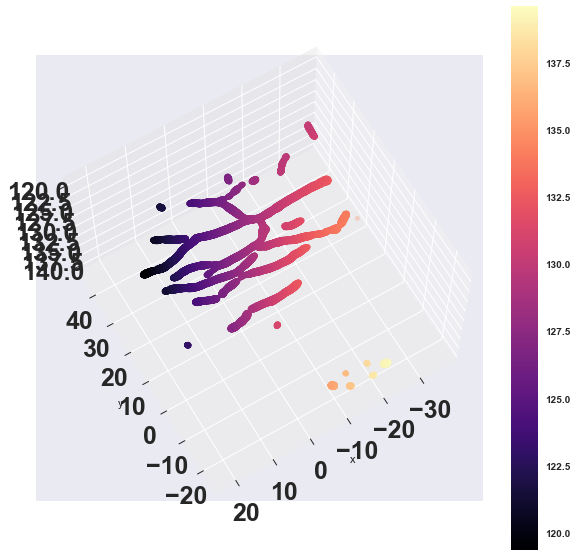

In [32]:
import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
mpl.style.use('seaborn')


fig = plt.figure(figsize=(10,10))
np.random.seed(11)


ax = fig.add_subplot(111, projection='3d')

c = p3ds[0:,[2]] 
rcParams['font.weight'] = 'bold'
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(25)
        tick.label.set_fontweight('bold')
        
        
p=ax.scatter(p3ds[0:,[0]],p3ds[0:,[1]],p3ds[0:,[2]],c = c, cmap=plt.cm.magma)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

elev = 245.25
azim = 120.5
ax.view_init(elev, azim)


fig.colorbar(p, ax=ax)

# fig.savefig("scatter_view_color_bar.png")
plt.show()

In [114]:
import open3d as o3d
import time

if __name__ == "__main__":
    o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Debug)
    pcd_data = o3d.data.DemoICPPointClouds()
    source_raw = o3d.io.read_point_cloud('data1.ply')

    
    source_raw = source_raw.voxel_down_sample(voxel_size=0.005)

    
    source = source_raw


    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(source)


    for i in range(100):
        time.sleep(.1)
        flip_transform = [[1, 0.1, 0, 0 ],
                          [0, 1, 0, 0], 
                          [0, 0, 1, 0], 
                          [0, 0, 0, 1 ]]
        source.transform(flip_transform)
        vis.update_geometry(source)
        vis.poll_events()
        vis.update_renderer()
        

        flip_transform = np.linalg.inv(np.array(flip_transform))

        source.transform(flip_transform)
        vis.update_geometry(source)
        vis.poll_events()
        vis.update_renderer()

    vis.destroy_window()
    o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Info)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D DEBUG] Format auto File data1.ply
[Open3D WARNING] Read PLY failed: unable to open file: data1.ply
[Open3D DEBUG] Read geometry::PointCloud: 0 vertices.
[Open3D DEBUG] Pointcloud down sampled from 0 points to 0 points.
[Open3D DEBUG] GLFW init.
[Open3D DEBUG] Add geometry and update bounding box to [(0.0000, 0.0000, 0.0000) - (0.0000, 0.0000, 0.0000)]
